## Real data

In [1]:
import sys
sys.path.insert(0,'..')

import training as tr
import emnet
import emsim_utils

import struct
import gc
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
#import scipy.optimize as optimize
from glob import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [2]:
# From https://stackoverflow.com/questions/1035340/reading-binary-file-and-looping-over-each-byte
def bytes_from_file(filename, chunksize=2):
    with open(filename, "rb") as f:
        while True:
            chunk = f.read(chunksize)
            if chunk:
                yield struct.unpack('<H', chunk)[0]
            else:
                break    


# Read the specified number of images from the given file.
# Each "image" is the difference between two 512x512 "pre"-images
#  read in succession. Each image is median subtracted.
def read_images(datfile,nimages):
    
    # Create a reader.
    freader = iter(bytes_from_file(datfile))

    # Read 4-byte header.
    for i in range(2):
        next(freader)

    # Read the images.
    imgs = []
    for ni in range(nimages):

        img1 = []
        for i in range(512*512):
            img1.append(next(freader))

        img2 = []
        for i in range(512*512):
            img2.append(next(freader))

        imgs.append(np.array(img2).reshape([512,512]) - np.array(img1).reshape([512,512]))

    # Return the final image array in numpy format.
    imgs = np.array(imgs)
    imgs = imgs - np.median(imgs,axis=0)
    
    return imgs

#### Read the images

In [ ]:
th = 100
all_img_proc, all_img_th_proc = [], []
datfiles = glob("/home/jrenner/local/data/4dstem/scan_0000001768/*.dat")
for datfile in datfiles:
    print("Reading datafile",datfile)
    
    # Read in all images from the data file.
    imgs = read_images(datfile,2048)
    
    # Average over all images to get the "processed" image.
    img_proc = np.average(imgs,axis=0)
    all_img_proc.append(img_proc)
    
    # Threshold the images to get individual counts.
    imgs_th = np.zeros(imgs.shape)
    imgs_th[imgs > th] = 1
    
    # Sum the thresholded images.
    img_th_proc = np.sum(imgs_th,axis=0)
    all_img_th_proc.append(img_th_proc)

all_img_proc = np.array(all_img_proc)
all_img_th_proc = np.array(all_img_th_proc)

In [ ]:
np.savez("aall_img_arrays.npz",all_img_proc=all_img_proc,all_img_th_proc=all_img_th_proc)

In [ ]:
# Load the arrays from the file
f_img_arrays = np.load("img_arrays_0_left.npz")
all_img_proc = f_img_arrays['all_img_proc']
all_img_th_proc = f_img_arrays['all_img_th_proc']

In [ ]:
fig, axs = plt.subplots(4, 8)
fig.set_figheight(8.0)
fig.set_figwidth(20.0)
for iplt in range(len(all_img_th_proc)):
    iaxis = int(iplt / 8)
    jaxis = iplt % 8
    axs[iaxis,jaxis].imshow(all_img_th_proc[iplt],vmax=100)

# plt.imshow(all_img_proc[11])
# plt.colorbar()

In [ ]:
# Create the summed, thresholded image from all datasets.
img_th_all = np.sum(all_img_th_proc,axis=0)
plt.imshow(img_th_all,vmax=1000)
plt.colorbar()

In [ ]:
# Check the numbers of counts in each pixel.
plt.hist(all_img_th_proc.flatten(),bins=100)
plt.yscale('log')

#### Histogram individual image elements to determine threshold

In [ ]:
# Create a histogram of all image elements.
plt.hist(imgs.flatten(),bins=100,range=[0,400])
plt.yscale("log")

In [ ]:
# Create a thresholded image.
th = 100
imgs_th = np.zeros(imgs.shape)
imgs_th[imgs > th] = 1#imgs[imgs > th]

In [ ]:
# Show the thresholded image.
img_th_proc = np.sum(imgs_th,axis=0)
plt.imshow(img_th_proc,vmax=10)
plt.colorbar()

#### Fit the edge of the thresholded image for each row

In [26]:
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

# Fit an s-curve to the specified row in img,
#  within a range of +/- rng centered upon x0.
def fit_scurve(img,nrow,x0,rng=50):
    
    # Choose the row, selecting elements (x0-rng):(x0+rng)
    xmin = max(0,x0-rng)
    xmax = min(img.shape[1],x0+rng)
    ydata = img[nrow,xmin:xmax]
    xdata = np.arange(xmin,xmax)

    # Set an initial guess and perform the fit.
    p0 = [np.mean(ydata[ydata > np.mean(ydata)]), x0, 1, min(ydata)]
    popt, pcov = curve_fit(sigmoid, xdata, ydata, p0, method='dogbox') #, bounds=((-max(ydata), x0-20, -np.inf, 0), (max(ydata), x0+20, np.inf, 200)))
    
    return popt

In [ ]:
x_guess = 357
x_edges = []
for row in range(img_th_all.shape[0]):
    
    # Perform the fit.
    try:
        L,x0,k,b = fit_scurve(img_th_all,row,x_guess)
    except:
        print("** Fit failed for row",row)
        L,k,b = None,None,None
        x0 = x_guess
    
    x_edge = int(np.round(x0))
    x_edges.append(x_edge)
    x_guess = x_edge
    print("-- Fit row",row,": L=",L,"x0=",x0,"k=",k,"b=",b)
x_edges = np.array(x_edges)

##### Plot the edge

In [ ]:
img_edge = np.zeros([512,512]) #img_th_all.shape)
for row,iedge in zip(range(img_edge.shape[0]),x_edges):
    img_edge[row,iedge] = 1

In [ ]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121)
plt.imshow(img_th_all,vmax=1000)
plt.colorbar()
#plt.imshow(img_edge,alpha=0.1)

ax2 = fig.add_subplot(122)
plt.imshow(img_edge)

##### Test a single fit

In [ ]:
row = 0
x_guess = 360
rng = 50

popt = fit_scurve(img_th_all,row,x_guess)

xmin = max(0,x_guess-rng)
xmax = min(img_th_all.shape[1],x_guess+rng)
ydata = img_th_all[row,xmin:xmax]
xdata = np.arange(xmin,xmax)

x = np.linspace(xdata[0], xdata[-1], 1000)
y = sigmoid(x, *popt)

plt.plot(xdata, ydata, label='data')
plt.plot(x,y, label='fit')
plt.legend(loc='best')
plt.xlabel("Image column")
plt.ylabel("Counts")

print("-- Fit row",row,": popt =",popt)
print(np.mean(ydata[ydata > np.mean(ydata)]))

In [ ]:
# Save all arrays.
np.savez("img_arrays_0_right.npz",all_img_proc=all_img_proc,all_img_th_proc=all_img_th_proc,x_edges=x_edges)

##### Select the images using the edge array

In [ ]:
f_img_arrays = np.load("img_arrays_0_left.npz")
x_edges = f_img_arrays['x_edges']
side = 1 # 0 = right, 1 = left

In [ ]:
# Determines whether the image is a valid event.
def check_subimage_th(subimg):
    valid = False
    
    # Ensure the maximum pixel index is within some number of pixels of the borders.
    pixel_padding = 1
    max_index = np.unravel_index(subimg.argmax(),subimg.shape)
    valid = (max_index[0] > pixel_padding) and (max_index[0] < subimg.shape[0]-pixel_padding-1) and (max_index[1] > pixel_padding) and (max_index[1] < subimg.shape[1]-pixel_padding-1)
    
    # Ensure there is at least 1 nonzero pixel.
    valid = valid and (len(subimg[subimg > 0]) > 0) 
    
    return valid

def choose_subimages(img, img_th, available_edges, debug=False):

    valid_subimages, valid_subimages_c, valid_subimages_th = [], [], []
    line_m, line_b = [], []

    # Loop until no available edges remain.
    done = (available_edges == -1).all()
    while(not done):

        # Choose a random location in the x-edges array.
        rmid = np.random.randint(rmax)

        # Make sure the current edge is available.
        if(available_edges[rmid] < 0):
            continue

        # Select a window equal to the subimage size in length.
        rstart = rmid - subimg_halfsize
        rend   = rmid + subimg_halfsize + 1
        if(rstart < rmin or rend >= rmax):
            if(rstart < rmin): rstart = rmin
            if(rend >= rmax):  rend = rmax
            available_edges[rstart:rend] = -1
            
            done = (available_edges == -1).all()
            continue

        # Ensure all edges for this image have not yet been used.
        aedges = available_edges[rstart:rend]
        if((aedges > 0).all()):

            # Construct the subimage.
            xmid = x_edges[rmid]
            cstart = xmid - subimg_halfsize
            cend   = xmid + subimg_halfsize + 1

            # Only continue with a subimage that fits properly in the full image.
            if(cstart >= cmin and cend < cmax):

                # Create the subimage.
                subimg    = img[rstart:rend,cstart:cend]
                subimg_th = img_th[rstart:rend,cstart:cend]
                
                # Compute the boundaries for the subimage centered on the max pixel.
                arg_max = np.unravel_index(np.argmax(subimg),subimg.shape)
                delta = int((subimg.shape[0]-1)/2)  # the extent of the event from the center pixel
                ileft = rstart + (arg_max[0] - delta)
                jleft = cstart + (arg_max[1] - delta)
                iright = rend + (arg_max[0] - delta)
                jright = cend + (arg_max[1] - delta)

                # Check that the (thresholded) subimage is valid.
                if(check_subimage_th(subimg_th)):

                    # Compute the slopes and intercepts.
                    x1 = (x_edges[rstart] - cstart) + 0.5
                    x2 = (x_edges[rend] - cstart) + 0.5
                    if(x2 == x1): 
                        if(side == 0): x2 = x1-1
                        else: x2 = x1+1
                    y1 = 0.5
                    y2 = (rend - rstart) - 0.5
                    m = (y2 - y1) / (x2 - x1)
                    b = y2 - m*x2
                    if(debug): print("xmid_rel = {}, cstart = {}, cend = {}".format(xmid-cstart,cstart,cend))
                    if(debug): print("(x1,y1) = ({},{}); (x2,y2) = ({},{})".format(x1,y1,x2,y2))
                    
                    # Only save the subimage if the slope is negative for side = 0 or positive for side = 1.
                    # (Note, because y increases downward, the notion of "negative" and "positive" is flipped.)
                    if(debug): print("side = {}, m = {}".format(side,m))
                    if((side == 0 and m < 0) or (side == 1 and m > 0)):

                        # Save the subimage if the centered subimage is also valid.
                        if(ileft >= rmin and iright < rmax and jleft >= cmin and jright < cmax):
                            if(debug): print("Centered subimage is valid.")
                            subimg_c = img[ileft:iright,jleft:jright]
                            arg_max_c = np.unravel_index(np.argmax(subimg_c),subimg_c.shape)

                            # Don't save the image if the center pixel is no longer the maximum.
                            if(arg_max_c[0] == delta and arg_max_c[1] == delta):
                                if(debug): print("Center pixel is no longer maximum: ADDING IMAGE")
                                valid_subimages.append(subimg)
                                valid_subimages_c.append(subimg_c)
                                valid_subimages_th.append(subimg_th)
                                line_m.append(m)
                                line_b.append(b)

                    # Remove all edges for this subimage from availability.
                    available_edges[rstart:rend] = -1

                # If the image is not valid, do nothing, but continue the loop.

            else:
                available_edges[rstart:rend] = -1

        # If not all edges are available, 
        else:
            available_edges[rstart:rend] = -1

        # Set the terminating condition.
        done = (available_edges == -1).all()
        #if(debug): print("Number of available edges:",np.sum(available_edges == 1),"/",len(available_edges))
    
    # Return the arrays.
    valid_subimages = np.array(valid_subimages)
    valid_subimages_c = np.array(valid_subimages_c)
    valid_subimages_th = np.array(valid_subimages_th)
    line_m = np.array(line_m)
    line_b = np.array(line_b)
    
    return valid_subimages, valid_subimages_c, valid_subimages_th, line_m, line_b

In [ ]:
th = 100
subimg_halfsize = 5
rmin = 0
rmax = len(x_edges)
cmin = 0
cmax = len(x_edges) # assume image is square

valid_subimages, valid_subimages_c, valid_subimages_th = None, None, None
line_m, line_b = None, None

datfiles = glob("/home/jrenner/local/data/4dstem/scan_0000001768/*.dat")
for datfile in datfiles[0:10]:
    print("Reading datafile",datfile)
    
    # Read in all images from the data file.
    imgs = read_images(datfile,2048)
    
    # Threshold the images to get individual counts
    imgs_th = np.zeros(imgs.shape)
    imgs_th[imgs > th] = 1
    
    # Get all subimages from each image.
    for iimg in range(len(imgs)):
        if(iimg % 200 == 0): print("--> Processing image",iimg,"of",len(imgs))
        
        # Get this image and its thresholded version.
        img = imgs[iimg]
        img_th = imgs_th[iimg]
        
        # Create a new array of available edges.
        available_edges = np.ones(len(x_edges))
        
        # Get the subimages.
        t_valid_subimages, t_valid_subimages_c, t_valid_subimages_th, t_line_m, t_line_b = choose_subimages(img, img_th, available_edges, debug = False)
        
        if(valid_subimages is None): valid_subimages = t_valid_subimages
        else: valid_subimages = np.append(valid_subimages, t_valid_subimages, axis=0)
        if(valid_subimages_c is None): valid_subimages_c = t_valid_subimages_c
        else: valid_subimages_c = np.append(valid_subimages_c, t_valid_subimages_c, axis=0)
        if(valid_subimages_th is None): valid_subimages_th = t_valid_subimages_th
        else: valid_subimages_th = np.append(valid_subimages_th, t_valid_subimages_th, axis=0)
        if(line_m is None): line_m = t_line_m
        else: line_m = np.append(line_m, t_line_m, axis=0)
        if(line_b is None): line_b = t_line_b
        else: line_b = np.append(line_b, t_line_b, axis=0)
        
    del imgs
    del imgs_th
    gc.collect()

# Convert to numpy arrays.
# valid_subimages = np.array(valid_subimages)
# valid_subimages_th = np.array(valid_subimages_th)
# line_m = np.array(line_m)
# line_b = np.array(line_b)

In [ ]:
valid_subimages_c.shape

In [ ]:
line_m.shape

In [ ]:
np.savez("subimgs_170k_left.npz",valid_subimages=valid_subimages,valid_subimages_c=valid_subimages_c,valid_subimages_th=valid_subimages_th,line_m=line_m,line_b=line_b)

In [ ]:
# Load the subimages
fn = np.load("subimgs_173k_right.npz")
valid_subimages = fn['valid_subimages']
valid_subimages_c = fn['valid_subimages_c']
valid_subimages_th = fn['valid_subimages_th']
line_m = fn['line_m']
line_b = fn['line_b']

In [ ]:
isub = 15
nrows = ncols = 11

In [ ]:
# Plot subimages.
mm = line_m[isub]
bb = line_b[isub]
xfit = np.arange(0,ncols-1,1e-4)
yfit = mm*xfit + bb

plt.imshow(valid_subimages[isub])
plt.plot(xfit[(yfit >= 0) & (yfit < nrows-1)],yfit[(yfit >= 0) & (yfit < nrows-1)],linewidth=2,color='red')
print("Slope is",mm,"and intercept is",bb)

In [ ]:
plt.imshow(valid_subimages_th[isub])
#plt.imshow(np.sum(valid_subimages_th,axis=0))

In [ ]:
len(valid_subimages)

#### Train the NN

In [3]:
modeldir = '/home/jrenner/local/jerenner/emsim/models'
lrate       = 1e-3   # Learning rate to use in the training.
load_model  = True   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 0      # Number of initial epoch
epoch_end   = 200    # Number of final epoch
model_load_checkpoint = "{}/realdata/model_150k_symmetrized.pt".format(modeldir)

# Create the dataset.
dataset_train = tr.RealFrameDataset("/home/jrenner/local/jerenner/emsim/notebooks/subimgs_170k_left.npz",
                                    "/home/jrenner/local/jerenner/emsim/notebooks/subimgs_173k_right.npz",
                                    0,150000)
dataset_val = tr.RealFrameDataset("/home/jrenner/local/jerenner/emsim/notebooks/subimgs_170k_left.npz",
                                  "/home/jrenner/local/jerenner/emsim/notebooks/subimgs_173k_right.npz",
                                  150000,20000)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=1000, shuffle=False, collate_fn=tr.my_collate_reg_line_realdata, num_workers=1)

# Define the model.
model = emnet.basicCNN_reg()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lrate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer = optim.RMSprop(model.parameters(), lr=lrate, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    for m in model.modules():
        for child in m.children():
            if type(child) == nn.BatchNorm2d:
                child.track_running_stats = False
                child.running_mean = None
                child.running_var = None
    model.eval()

In [ ]:
# Run the training.
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    train_loss = tr.train_regression_line(model, epoch, train_loader, optimizer, 1000)
    scheduler.step(train_loss)
    #if(epoch % 50 == 0):
    torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

##### Look at individual events

In [ ]:
# Look at individual events
evt_plt = 120
evt_item = dataset_val[evt_plt]
evt_frame_cmax = np.array(evt_item[0])
evt_frame      = np.array(evt_item[1])
evt_argmax     = np.array(evt_item[2])
evt_err        = np.array(evt_item[3])/emnet.PIXEL_SIZE
evt_lside      = np.array(evt_item[4])
evt_line_m     = evt_item[5]
evt_line_b     = evt_item[6]
print("Light side is",evt_lside)
print("Arg max is",evt_argmax)

# Information for drawing the line.
nrows = evt_frame.shape[0]
ncols = evt_frame.shape[1]
indices = np.indices((nrows,ncols))
irows = indices[0]
icols = indices[1]
print("Line drawn: m = {}, b = {}".format(evt_line_m,evt_line_b))

# Run the model and compute the reconstructed point.
data = torch.tensor(evt_frame_cmax).float().unsqueeze(0).unsqueeze(1).cuda()
output_score = model(data)
pred_err = np.array(output_score.cpu().detach().numpy()).squeeze()
row_pred = pred_err[1] + evt_argmax[0] + 0.5
col_pred = pred_err[0] + evt_argmax[1] + 0.5
print("Pred point (",col_pred,",",row_pred,")")
print("Pred vector (",pred_err[0],",",pred_err[1],")")

# Compute the distance from the reconstructed point to the line.
dist_pred = (evt_line_m*col_pred - row_pred + evt_line_b) / (evt_line_m**2 + 1)**0.5
print("Predicted distance to the line:",dist_pred)

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_frame_cmax,extent=[0,11,11,0])
#ax1.plot([evt_err[0]+5.5],[evt_err[1]+5.5],color='red',marker='*',markersize=10)
ax1.plot([pred_err[0]+5.5],[pred_err[1]+5.5],color='green',marker='o',markersize=10)
plt.colorbar()
plt.title("Event, seen by the NN\n(centered on max pixel)")

ax2 = fig.add_subplot(132)
plt.imshow(evt_frame,extent=[0,11,11,0])
#ax2.plot([col_true],[row_true],color='red',marker='*',markersize=10)
ax2.plot([col_pred],[row_pred],color='green',marker='o',markersize=10)
plt.colorbar()
plt.title("Event with line")
xfit = np.arange(0,ncols-1,0.1)
yfit = evt_line_m*xfit + evt_line_b
plt.plot(xfit[(yfit > 0) & (yfit < nrows)],yfit[(yfit > 0) & (yfit < nrows)],linewidth=2,color='red')

# Compute a test loss
batch_size = 1
indices = np.indices((emnet.EVT_SIZE,emnet.EVT_SIZE))
row_coords = torch.tensor(indices[0] + 0.5 - ((emnet.EVT_SIZE-1)/2 + 0.5)).repeat([batch_size,1,1]).cuda()
col_coords = torch.tensor(indices[1] + 0.5 - ((emnet.EVT_SIZE-1)/2 + 0.5)).repeat([batch_size,1,1]).cuda()
print("TEST LOSS")
#loss_vec, loss_dist = tr.loss_reg_edge(torch.tensor([[evt_err[0],evt_err[1]]]), np.array([evt_argmax]), line_m, line_b, evt_lside)
loss_vec, loss_dist, dist_reco_masked = tr.loss_reg_edge(data.squeeze(1), torch.tensor(evt_item[3]).unsqueeze(0).cuda(), output_score, row_coords, col_coords, torch.tensor([evt_argmax]).cuda(), evt_line_m, evt_line_b, evt_lside)
print("-- Test vector loss:",loss_vec)
print("-- Test distance loss:",loss_dist)

ax3 = fig.add_subplot(133)
plt.imshow(dist_reco_masked.cpu().detach().squeeze(0).numpy(),extent=[0,11,11,0])
#ax3.plot([evt_err[0]+5.5],[evt_err[1]+5.5],color='red',marker='*',markersize=10)
ax3.plot([pred_err[0]+5.5],[pred_err[1]+5.5],color='green',marker='o',markersize=10)
plt.colorbar()
plt.title("Cluster")
xfit = np.arange(0,ncols-1,0.1)
yfit = evt_line_m*xfit + evt_line_b

print("COMPARE LOSS")
if(evt_lside == 1):
    dist_pred *= -1
sigma_dist = 2
loss_vec = (pred_err[0]**2 + pred_err[1]**2)
loss_dist = np.exp(-dist_pred/sigma_dist)
print("-- Distance is:",dist_pred)
print("-- Compare vector loss:",loss_vec)
print("-- Compare distance loss:",loss_dist)
#print("True vector is ({},{})".format(evt_vec[0],evt_vec[1]))
#print("Predicted vector is ({},{})".format(pred_vec[0],pred_vec[1]))

## Evaluation/reconstruction of images

In [4]:
th = 100
subimg_halfsize = 5
rmin = 0; rmax = 511
cmin = 0; cmax = 511

r_th, c_th = [], []
r_NN, c_NN = [], []
datfiles = glob("/home/jrenner/local/data/4dstem/scan_0000001768/*.dat")
for datfile in datfiles:
    print("Reading datafile",datfile)
    
    # Read in all images from the data file.
    imgs = read_images(datfile,2048)
    
    # Threshold the images to get individual counts
    imgs_th = np.zeros(imgs.shape)
    imgs_th[imgs > th] = 1
    
    # For each point in the thresholded image, attempt to get an 11x11 subimage.
    for iimg in range(len(imgs_th)):
        
        print("-- Image index",iimg)
        
        i_subimgs, r_subimgs, c_subimgs = [], [], []
        
        r_nz, c_nz = np.nonzero(imgs_th[iimg])
        print("---> Number of nonzero indices:",len(r_nz))
        
        for r,c in zip(r_nz,c_nz):
            
#             rnz, cnz = np.nonzero(imgs_th[iimg])
#             print("---> Number of nonzero indices:",len(rnz))
            
            # If we've already erased this index, skip it.
            if(imgs_th[iimg,r,c] == 0):
                continue

            rstart = r - subimg_halfsize
            rend = r + subimg_halfsize + 1
            cstart = c - subimg_halfsize
            cend = c + subimg_halfsize + 1

            # Ensure we can select an 11x11 subimage.
            if((rstart >= rmin) and (rend <= rmax) and (cstart >= cmin) and (cend <= cmax)):
                
                # Get the subimage.
                subimg = imgs[iimg,rstart:rend,cstart:cend]
                
                # Compute the boundaries for the subimage centered on the max pixel.
                arg_max = np.unravel_index(np.argmax(subimg),subimg.shape)
                delta = int((subimg.shape[0]-1)/2)  # the extent of the event from the center pixel
                ileft = rstart + (arg_max[0] - delta)
                jleft = cstart + (arg_max[1] - delta)
                iright = rend + (arg_max[0] - delta)
                jright = cend + (arg_max[1] - delta)
                
                # Compute the central pixel values relative to the main image.
                rcenter = r + (arg_max[0] - delta)
                ccenter = c + (arg_max[1] - delta)
                
                # Ensure we can still select the 11x11 subimage.
                if(ileft >= rmin and iright < rmax and jleft >= cmin and jright < cmax):
                
                    # Zero all indices in the thresholded image.
                    imgs_th[iimg,ileft:iright,jleft:jright] = 0
                    
                    # Select the final subimage.
                    subimg = imgs[iimg,ileft:iright,jleft:jright]
                    
                    # Add to the array of subimages for this image.
                    i_subimgs.append(subimg)
                    r_subimgs.append(rcenter)
                    c_subimgs.append(ccenter)
                    
        i_subimgs = np.array(i_subimgs)
        r_subimgs = np.array(r_subimgs)
        c_subimgs = np.array(c_subimgs)
        
        # Reconstruct a single point for all subimages.
        data = torch.tensor(i_subimgs).float().unsqueeze(1).cuda()
        output_score = model(data)
        pred_err = np.array(output_score.cpu().detach().numpy()).squeeze()
        row_pred = r_subimgs + 0.5 + pred_err[:,1]
        col_pred = c_subimgs + 0.5 + pred_err[:,0]
        
        # Save the reconstructed points for this image.
        r_th.append(r_subimgs + 0.5)
        c_th.append(c_subimgs + 0.5)
        r_NN.append(row_pred)
        c_NN.append(col_pred)

Reading datafile /home/jrenner/local/data/4dstem/scan_0000001768/team1k_ued_0000001768_0000000015.dat
-- Image index 0
---> Number of nonzero indices: 1849
-- Image index 1
---> Number of nonzero indices: 1844
-- Image index 2
---> Number of nonzero indices: 1930
-- Image index 3
---> Number of nonzero indices: 1958
-- Image index 4
---> Number of nonzero indices: 1993
-- Image index 5
---> Number of nonzero indices: 1894
-- Image index 6
---> Number of nonzero indices: 1894
-- Image index 7
---> Number of nonzero indices: 1936
-- Image index 8
---> Number of nonzero indices: 1893


/home/jrenner/miniconda3/envs/tf2/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


-- Image index 9
---> Number of nonzero indices: 1951
-- Image index 10
---> Number of nonzero indices: 1875
-- Image index 11
---> Number of nonzero indices: 1877
-- Image index 12
---> Number of nonzero indices: 1918
-- Image index 13
---> Number of nonzero indices: 1886
-- Image index 14
---> Number of nonzero indices: 1780
-- Image index 15
---> Number of nonzero indices: 1842
-- Image index 16
---> Number of nonzero indices: 1927
-- Image index 17
---> Number of nonzero indices: 1949
-- Image index 18
---> Number of nonzero indices: 1850
-- Image index 19
---> Number of nonzero indices: 1898
-- Image index 20
---> Number of nonzero indices: 1753
-- Image index 21
---> Number of nonzero indices: 1964
-- Image index 22
---> Number of nonzero indices: 1908
-- Image index 23
---> Number of nonzero indices: 1933
-- Image index 24
---> Number of nonzero indices: 1945
-- Image index 25
---> Number of nonzero indices: 1959
-- Image index 26
---> Number of nonzero indices: 1881
-- Image in

-- Image index 159
---> Number of nonzero indices: 1829
-- Image index 160
---> Number of nonzero indices: 1858
-- Image index 161
---> Number of nonzero indices: 1847
-- Image index 162
---> Number of nonzero indices: 1808
-- Image index 163
---> Number of nonzero indices: 1840
-- Image index 164
---> Number of nonzero indices: 1852
-- Image index 165
---> Number of nonzero indices: 1910
-- Image index 166
---> Number of nonzero indices: 1922
-- Image index 167
---> Number of nonzero indices: 1822
-- Image index 168
---> Number of nonzero indices: 1873
-- Image index 169
---> Number of nonzero indices: 1859
-- Image index 170
---> Number of nonzero indices: 1836
-- Image index 171
---> Number of nonzero indices: 1868
-- Image index 172
---> Number of nonzero indices: 1949
-- Image index 173
---> Number of nonzero indices: 1992
-- Image index 174
---> Number of nonzero indices: 1856
-- Image index 175
---> Number of nonzero indices: 1856
-- Image index 176
---> Number of nonzero indice

-- Image index 313
---> Number of nonzero indices: 1869
-- Image index 314
---> Number of nonzero indices: 1895
-- Image index 315
---> Number of nonzero indices: 1978
-- Image index 316
---> Number of nonzero indices: 1971
-- Image index 317
---> Number of nonzero indices: 1928
-- Image index 318
---> Number of nonzero indices: 1804
-- Image index 319
---> Number of nonzero indices: 1814
-- Image index 320
---> Number of nonzero indices: 1853
-- Image index 321
---> Number of nonzero indices: 1877
-- Image index 322
---> Number of nonzero indices: 1845
-- Image index 323
---> Number of nonzero indices: 1922
-- Image index 324
---> Number of nonzero indices: 1778
-- Image index 325
---> Number of nonzero indices: 1839
-- Image index 326
---> Number of nonzero indices: 1799
-- Image index 327
---> Number of nonzero indices: 1802
-- Image index 328
---> Number of nonzero indices: 1986
-- Image index 329
---> Number of nonzero indices: 1897
-- Image index 330
---> Number of nonzero indice

-- Image index 464
---> Number of nonzero indices: 1915
-- Image index 465
---> Number of nonzero indices: 1853
-- Image index 466
---> Number of nonzero indices: 1873
-- Image index 467
---> Number of nonzero indices: 1812
-- Image index 468
---> Number of nonzero indices: 1917
-- Image index 469
---> Number of nonzero indices: 1881
-- Image index 470
---> Number of nonzero indices: 1877
-- Image index 471
---> Number of nonzero indices: 1905
-- Image index 472
---> Number of nonzero indices: 1940
-- Image index 473
---> Number of nonzero indices: 1832
-- Image index 474
---> Number of nonzero indices: 1877
-- Image index 475
---> Number of nonzero indices: 2019
-- Image index 476
---> Number of nonzero indices: 1968
-- Image index 477
---> Number of nonzero indices: 1861
-- Image index 478
---> Number of nonzero indices: 1925
-- Image index 479
---> Number of nonzero indices: 1842
-- Image index 480
---> Number of nonzero indices: 1975
-- Image index 481
---> Number of nonzero indice

---> Number of nonzero indices: 1872
-- Image index 617
---> Number of nonzero indices: 1863
-- Image index 618
---> Number of nonzero indices: 1830
-- Image index 619
---> Number of nonzero indices: 1905
-- Image index 620
---> Number of nonzero indices: 1944
-- Image index 621
---> Number of nonzero indices: 1905
-- Image index 622
---> Number of nonzero indices: 1958
-- Image index 623
---> Number of nonzero indices: 1975
-- Image index 624
---> Number of nonzero indices: 2009
-- Image index 625
---> Number of nonzero indices: 1775
-- Image index 626
---> Number of nonzero indices: 1986
-- Image index 627
---> Number of nonzero indices: 2009
-- Image index 628
---> Number of nonzero indices: 1851
-- Image index 629
---> Number of nonzero indices: 1860
-- Image index 630
---> Number of nonzero indices: 2001
-- Image index 631
---> Number of nonzero indices: 1907
-- Image index 632
---> Number of nonzero indices: 1856
-- Image index 633
---> Number of nonzero indices: 1859
-- Image in

-- Image index 769
---> Number of nonzero indices: 1886
-- Image index 770
---> Number of nonzero indices: 1867
-- Image index 771
---> Number of nonzero indices: 1957
-- Image index 772
---> Number of nonzero indices: 1922
-- Image index 773
---> Number of nonzero indices: 1939
-- Image index 774
---> Number of nonzero indices: 1921
-- Image index 775
---> Number of nonzero indices: 1824
-- Image index 776
---> Number of nonzero indices: 1930
-- Image index 777
---> Number of nonzero indices: 1915
-- Image index 778
---> Number of nonzero indices: 1896
-- Image index 779
---> Number of nonzero indices: 1899
-- Image index 780
---> Number of nonzero indices: 1973
-- Image index 781
---> Number of nonzero indices: 1847
-- Image index 782
---> Number of nonzero indices: 1940
-- Image index 783
---> Number of nonzero indices: 1848
-- Image index 784
---> Number of nonzero indices: 1815
-- Image index 785
---> Number of nonzero indices: 1871
-- Image index 786
---> Number of nonzero indice

-- Image index 920
---> Number of nonzero indices: 1866
-- Image index 921
---> Number of nonzero indices: 1911
-- Image index 922
---> Number of nonzero indices: 1877
-- Image index 923
---> Number of nonzero indices: 1829
-- Image index 924
---> Number of nonzero indices: 1895
-- Image index 925
---> Number of nonzero indices: 1779
-- Image index 926
---> Number of nonzero indices: 1872
-- Image index 927
---> Number of nonzero indices: 1930
-- Image index 928
---> Number of nonzero indices: 1925
-- Image index 929
---> Number of nonzero indices: 1947
-- Image index 930
---> Number of nonzero indices: 1856
-- Image index 931
---> Number of nonzero indices: 1896
-- Image index 932
---> Number of nonzero indices: 1975
-- Image index 933
---> Number of nonzero indices: 1879
-- Image index 934
---> Number of nonzero indices: 1820
-- Image index 935
---> Number of nonzero indices: 2006
-- Image index 936
---> Number of nonzero indices: 2045
-- Image index 937
---> Number of nonzero indice

-- Image index 1073
---> Number of nonzero indices: 1933
-- Image index 1074
---> Number of nonzero indices: 1837
-- Image index 1075
---> Number of nonzero indices: 1799
-- Image index 1076
---> Number of nonzero indices: 1942
-- Image index 1077
---> Number of nonzero indices: 1813
-- Image index 1078
---> Number of nonzero indices: 1844
-- Image index 1079
---> Number of nonzero indices: 1773
-- Image index 1080
---> Number of nonzero indices: 1925
-- Image index 1081
---> Number of nonzero indices: 1928
-- Image index 1082
---> Number of nonzero indices: 1813
-- Image index 1083
---> Number of nonzero indices: 1945
-- Image index 1084
---> Number of nonzero indices: 1926
-- Image index 1085
---> Number of nonzero indices: 1998
-- Image index 1086
---> Number of nonzero indices: 1834
-- Image index 1087
---> Number of nonzero indices: 1885
-- Image index 1088
---> Number of nonzero indices: 1843
-- Image index 1089
---> Number of nonzero indices: 1801
-- Image index 1090
---> Number

-- Image index 1224
---> Number of nonzero indices: 1866
-- Image index 1225
---> Number of nonzero indices: 1824
-- Image index 1226
---> Number of nonzero indices: 1901
-- Image index 1227
---> Number of nonzero indices: 1867
-- Image index 1228
---> Number of nonzero indices: 1806
-- Image index 1229
---> Number of nonzero indices: 1831
-- Image index 1230
---> Number of nonzero indices: 1854
-- Image index 1231
---> Number of nonzero indices: 1912
-- Image index 1232
---> Number of nonzero indices: 1899
-- Image index 1233
---> Number of nonzero indices: 1931
-- Image index 1234
---> Number of nonzero indices: 1921
-- Image index 1235
---> Number of nonzero indices: 1876
-- Image index 1236
---> Number of nonzero indices: 1940
-- Image index 1237
---> Number of nonzero indices: 1899
-- Image index 1238
---> Number of nonzero indices: 1843
-- Image index 1239
---> Number of nonzero indices: 1935
-- Image index 1240
---> Number of nonzero indices: 1844
-- Image index 1241
---> Number

-- Image index 1377
---> Number of nonzero indices: 1885
-- Image index 1378
---> Number of nonzero indices: 1874
-- Image index 1379
---> Number of nonzero indices: 1893
-- Image index 1380
---> Number of nonzero indices: 1873
-- Image index 1381
---> Number of nonzero indices: 1893
-- Image index 1382
---> Number of nonzero indices: 1781
-- Image index 1383
---> Number of nonzero indices: 1925
-- Image index 1384
---> Number of nonzero indices: 1960
-- Image index 1385
---> Number of nonzero indices: 1951
-- Image index 1386
---> Number of nonzero indices: 1912
-- Image index 1387
---> Number of nonzero indices: 1816
-- Image index 1388
---> Number of nonzero indices: 1861
-- Image index 1389
---> Number of nonzero indices: 1869
-- Image index 1390
---> Number of nonzero indices: 1793
-- Image index 1391
---> Number of nonzero indices: 1908
-- Image index 1392
---> Number of nonzero indices: 1862
-- Image index 1393
---> Number of nonzero indices: 1962
-- Image index 1394
---> Number

-- Image index 1527
---> Number of nonzero indices: 1837
-- Image index 1528
---> Number of nonzero indices: 1857
-- Image index 1529
---> Number of nonzero indices: 1866
-- Image index 1530
---> Number of nonzero indices: 1984
-- Image index 1531
---> Number of nonzero indices: 1831
-- Image index 1532
---> Number of nonzero indices: 1827
-- Image index 1533
---> Number of nonzero indices: 1841
-- Image index 1534
---> Number of nonzero indices: 1885
-- Image index 1535
---> Number of nonzero indices: 1896
-- Image index 1536
---> Number of nonzero indices: 1760
-- Image index 1537
---> Number of nonzero indices: 1770
-- Image index 1538
---> Number of nonzero indices: 1870
-- Image index 1539
---> Number of nonzero indices: 1950
-- Image index 1540
---> Number of nonzero indices: 1838
-- Image index 1541
---> Number of nonzero indices: 1969
-- Image index 1542
---> Number of nonzero indices: 1980
-- Image index 1543
---> Number of nonzero indices: 1923
-- Image index 1544
---> Number

-- Image index 1678
---> Number of nonzero indices: 1869
-- Image index 1679
---> Number of nonzero indices: 1815
-- Image index 1680
---> Number of nonzero indices: 1905
-- Image index 1681
---> Number of nonzero indices: 1773
-- Image index 1682
---> Number of nonzero indices: 1846
-- Image index 1683
---> Number of nonzero indices: 1844
-- Image index 1684
---> Number of nonzero indices: 1870
-- Image index 1685
---> Number of nonzero indices: 1942
-- Image index 1686
---> Number of nonzero indices: 1873
-- Image index 1687
---> Number of nonzero indices: 1898
-- Image index 1688
---> Number of nonzero indices: 1817
-- Image index 1689
---> Number of nonzero indices: 1815
-- Image index 1690
---> Number of nonzero indices: 1887
-- Image index 1691
---> Number of nonzero indices: 1883
-- Image index 1692
---> Number of nonzero indices: 1850
-- Image index 1693
---> Number of nonzero indices: 1865
-- Image index 1694
---> Number of nonzero indices: 1964
-- Image index 1695
---> Number

-- Image index 1828
---> Number of nonzero indices: 1918
-- Image index 1829
---> Number of nonzero indices: 1886
-- Image index 1830
---> Number of nonzero indices: 1948
-- Image index 1831
---> Number of nonzero indices: 1814
-- Image index 1832
---> Number of nonzero indices: 1856
-- Image index 1833
---> Number of nonzero indices: 1884
-- Image index 1834
---> Number of nonzero indices: 1916
-- Image index 1835
---> Number of nonzero indices: 1925
-- Image index 1836
---> Number of nonzero indices: 1815
-- Image index 1837
---> Number of nonzero indices: 1860
-- Image index 1838
---> Number of nonzero indices: 1880
-- Image index 1839
---> Number of nonzero indices: 1868
-- Image index 1840
---> Number of nonzero indices: 1891
-- Image index 1841
---> Number of nonzero indices: 1908
-- Image index 1842
---> Number of nonzero indices: 1848
-- Image index 1843
---> Number of nonzero indices: 1906
-- Image index 1844
---> Number of nonzero indices: 1876
-- Image index 1845
---> Number

-- Image index 1979
---> Number of nonzero indices: 1925
-- Image index 1980
---> Number of nonzero indices: 1923
-- Image index 1981
---> Number of nonzero indices: 1911
-- Image index 1982
---> Number of nonzero indices: 1917
-- Image index 1983
---> Number of nonzero indices: 1865
-- Image index 1984
---> Number of nonzero indices: 1878
-- Image index 1985
---> Number of nonzero indices: 1925
-- Image index 1986
---> Number of nonzero indices: 1882
-- Image index 1987
---> Number of nonzero indices: 1900
-- Image index 1988
---> Number of nonzero indices: 1789
-- Image index 1989
---> Number of nonzero indices: 1971
-- Image index 1990
---> Number of nonzero indices: 1777
-- Image index 1991
---> Number of nonzero indices: 1900
-- Image index 1992
---> Number of nonzero indices: 1972
-- Image index 1993
---> Number of nonzero indices: 1918
-- Image index 1994
---> Number of nonzero indices: 1780
-- Image index 1995
---> Number of nonzero indices: 1920
-- Image index 1996
---> Number

-- Image index 83
---> Number of nonzero indices: 1936
-- Image index 84
---> Number of nonzero indices: 1803
-- Image index 85
---> Number of nonzero indices: 1838
-- Image index 86
---> Number of nonzero indices: 1958
-- Image index 87
---> Number of nonzero indices: 1862
-- Image index 88
---> Number of nonzero indices: 1957
-- Image index 89
---> Number of nonzero indices: 1907
-- Image index 90
---> Number of nonzero indices: 2000
-- Image index 91
---> Number of nonzero indices: 1856
-- Image index 92
---> Number of nonzero indices: 1910
-- Image index 93
---> Number of nonzero indices: 1956
-- Image index 94
---> Number of nonzero indices: 1844
-- Image index 95
---> Number of nonzero indices: 1863
-- Image index 96
---> Number of nonzero indices: 1958
-- Image index 97
---> Number of nonzero indices: 1825
-- Image index 98
---> Number of nonzero indices: 1875
-- Image index 99
---> Number of nonzero indices: 1986
-- Image index 100
---> Number of nonzero indices: 1859
-- Image 

-- Image index 236
---> Number of nonzero indices: 1986
-- Image index 237
---> Number of nonzero indices: 1822
-- Image index 238
---> Number of nonzero indices: 1867
-- Image index 239
---> Number of nonzero indices: 1920
-- Image index 240
---> Number of nonzero indices: 1924
-- Image index 241
---> Number of nonzero indices: 1867
-- Image index 242
---> Number of nonzero indices: 1864
-- Image index 243
---> Number of nonzero indices: 1911
-- Image index 244
---> Number of nonzero indices: 1926
-- Image index 245
---> Number of nonzero indices: 1924
-- Image index 246
---> Number of nonzero indices: 1914
-- Image index 247
---> Number of nonzero indices: 1858
-- Image index 248
---> Number of nonzero indices: 1844
-- Image index 249
---> Number of nonzero indices: 1869
-- Image index 250
---> Number of nonzero indices: 1766
-- Image index 251
---> Number of nonzero indices: 1910
-- Image index 252
---> Number of nonzero indices: 1936
-- Image index 253
---> Number of nonzero indice

-- Image index 389
---> Number of nonzero indices: 1864
-- Image index 390
---> Number of nonzero indices: 1962
-- Image index 391
---> Number of nonzero indices: 1906
-- Image index 392
---> Number of nonzero indices: 1996
-- Image index 393
---> Number of nonzero indices: 1849
-- Image index 394
---> Number of nonzero indices: 1867
-- Image index 395
---> Number of nonzero indices: 1928
-- Image index 396
---> Number of nonzero indices: 1836
-- Image index 397
---> Number of nonzero indices: 1897
-- Image index 398
---> Number of nonzero indices: 1864
-- Image index 399
---> Number of nonzero indices: 1772
-- Image index 400
---> Number of nonzero indices: 1935
-- Image index 401
---> Number of nonzero indices: 1886
-- Image index 402
---> Number of nonzero indices: 1833
-- Image index 403
---> Number of nonzero indices: 1801
-- Image index 404
---> Number of nonzero indices: 1893
-- Image index 405
---> Number of nonzero indices: 1878
-- Image index 406
---> Number of nonzero indice

-- Image index 542
---> Number of nonzero indices: 1897
-- Image index 543
---> Number of nonzero indices: 1942
-- Image index 544
---> Number of nonzero indices: 1895
-- Image index 545
---> Number of nonzero indices: 1934
-- Image index 546
---> Number of nonzero indices: 1846
-- Image index 547
---> Number of nonzero indices: 2006
-- Image index 548
---> Number of nonzero indices: 1988
-- Image index 549
---> Number of nonzero indices: 1870
-- Image index 550
---> Number of nonzero indices: 1865
-- Image index 551
---> Number of nonzero indices: 1873
-- Image index 552
---> Number of nonzero indices: 1805
-- Image index 553
---> Number of nonzero indices: 1773
-- Image index 554
---> Number of nonzero indices: 1794
-- Image index 555
---> Number of nonzero indices: 1808
-- Image index 556
---> Number of nonzero indices: 1934
-- Image index 557
---> Number of nonzero indices: 1932
-- Image index 558
---> Number of nonzero indices: 1844
-- Image index 559
---> Number of nonzero indice

-- Image index 695
---> Number of nonzero indices: 1881
-- Image index 696
---> Number of nonzero indices: 1885
-- Image index 697
---> Number of nonzero indices: 1841
-- Image index 698
---> Number of nonzero indices: 1962
-- Image index 699
---> Number of nonzero indices: 1978
-- Image index 700
---> Number of nonzero indices: 1776
-- Image index 701
---> Number of nonzero indices: 1908
-- Image index 702
---> Number of nonzero indices: 1904
-- Image index 703
---> Number of nonzero indices: 1834
-- Image index 704
---> Number of nonzero indices: 1897
-- Image index 705
---> Number of nonzero indices: 1949
-- Image index 706
---> Number of nonzero indices: 1893
-- Image index 707
---> Number of nonzero indices: 1797
-- Image index 708
---> Number of nonzero indices: 1863
-- Image index 709
---> Number of nonzero indices: 1886
-- Image index 710
---> Number of nonzero indices: 1875
-- Image index 711
---> Number of nonzero indices: 1886
-- Image index 712
---> Number of nonzero indice

-- Image index 848
---> Number of nonzero indices: 1891
-- Image index 849
---> Number of nonzero indices: 1982
-- Image index 850
---> Number of nonzero indices: 1895
-- Image index 851
---> Number of nonzero indices: 1784
-- Image index 852
---> Number of nonzero indices: 1875
-- Image index 853
---> Number of nonzero indices: 1983
-- Image index 854
---> Number of nonzero indices: 1824
-- Image index 855
---> Number of nonzero indices: 1868
-- Image index 856
---> Number of nonzero indices: 1816
-- Image index 857
---> Number of nonzero indices: 1882
-- Image index 858
---> Number of nonzero indices: 1946
-- Image index 859
---> Number of nonzero indices: 1957
-- Image index 860
---> Number of nonzero indices: 1964
-- Image index 861
---> Number of nonzero indices: 1963
-- Image index 862
---> Number of nonzero indices: 1922
-- Image index 863
---> Number of nonzero indices: 1960
-- Image index 864
---> Number of nonzero indices: 1956
-- Image index 865
---> Number of nonzero indice

-- Image index 999
---> Number of nonzero indices: 1906
-- Image index 1000
---> Number of nonzero indices: 1955
-- Image index 1001
---> Number of nonzero indices: 1794
-- Image index 1002
---> Number of nonzero indices: 1906
-- Image index 1003
---> Number of nonzero indices: 1886
-- Image index 1004
---> Number of nonzero indices: 1885
-- Image index 1005
---> Number of nonzero indices: 1907
-- Image index 1006
---> Number of nonzero indices: 1907
-- Image index 1007
---> Number of nonzero indices: 1896
-- Image index 1008
---> Number of nonzero indices: 1878
-- Image index 1009
---> Number of nonzero indices: 1878
-- Image index 1010
---> Number of nonzero indices: 1867
-- Image index 1011
---> Number of nonzero indices: 1938
-- Image index 1012
---> Number of nonzero indices: 1908
-- Image index 1013
---> Number of nonzero indices: 1888
-- Image index 1014
---> Number of nonzero indices: 1985
-- Image index 1015
---> Number of nonzero indices: 1871
-- Image index 1016
---> Number 

-- Image index 1148
---> Number of nonzero indices: 1795
-- Image index 1149
---> Number of nonzero indices: 1913
-- Image index 1150
---> Number of nonzero indices: 1874
-- Image index 1151
---> Number of nonzero indices: 1993
-- Image index 1152
---> Number of nonzero indices: 1771
-- Image index 1153
---> Number of nonzero indices: 1909
-- Image index 1154
---> Number of nonzero indices: 1898
-- Image index 1155
---> Number of nonzero indices: 1985
-- Image index 1156
---> Number of nonzero indices: 1932
-- Image index 1157
---> Number of nonzero indices: 1828
-- Image index 1158
---> Number of nonzero indices: 1800
-- Image index 1159
---> Number of nonzero indices: 1962
-- Image index 1160
---> Number of nonzero indices: 1943
-- Image index 1161
---> Number of nonzero indices: 1866
-- Image index 1162
---> Number of nonzero indices: 1866
-- Image index 1163
---> Number of nonzero indices: 1932
-- Image index 1164
---> Number of nonzero indices: 1923
-- Image index 1165
---> Number

---> Number of nonzero indices: 1910
-- Image index 1301
---> Number of nonzero indices: 1869
-- Image index 1302
---> Number of nonzero indices: 1826
-- Image index 1303
---> Number of nonzero indices: 1995
-- Image index 1304
---> Number of nonzero indices: 1910
-- Image index 1305
---> Number of nonzero indices: 1926
-- Image index 1306
---> Number of nonzero indices: 1861
-- Image index 1307
---> Number of nonzero indices: 1898
-- Image index 1308
---> Number of nonzero indices: 1903
-- Image index 1309
---> Number of nonzero indices: 1932
-- Image index 1310
---> Number of nonzero indices: 1992
-- Image index 1311
---> Number of nonzero indices: 1704
-- Image index 1312
---> Number of nonzero indices: 1882
-- Image index 1313
---> Number of nonzero indices: 1862
-- Image index 1314
---> Number of nonzero indices: 1955
-- Image index 1315
---> Number of nonzero indices: 1866
-- Image index 1316
---> Number of nonzero indices: 1907
-- Image index 1317
---> Number of nonzero indices:

-- Image index 1454
---> Number of nonzero indices: 1828
-- Image index 1455
---> Number of nonzero indices: 1860
-- Image index 1456
---> Number of nonzero indices: 1802
-- Image index 1457
---> Number of nonzero indices: 1948
-- Image index 1458
---> Number of nonzero indices: 1935
-- Image index 1459
---> Number of nonzero indices: 1785
-- Image index 1460
---> Number of nonzero indices: 1963
-- Image index 1461
---> Number of nonzero indices: 1841
-- Image index 1462
---> Number of nonzero indices: 1914
-- Image index 1463
---> Number of nonzero indices: 1916
-- Image index 1464
---> Number of nonzero indices: 1940
-- Image index 1465
---> Number of nonzero indices: 1958
-- Image index 1466
---> Number of nonzero indices: 1991
-- Image index 1467
---> Number of nonzero indices: 1890
-- Image index 1468
---> Number of nonzero indices: 1867
-- Image index 1469
---> Number of nonzero indices: 1874
-- Image index 1470
---> Number of nonzero indices: 1875
-- Image index 1471
---> Number

-- Image index 1607
---> Number of nonzero indices: 1918
-- Image index 1608
---> Number of nonzero indices: 1866
-- Image index 1609
---> Number of nonzero indices: 1913
-- Image index 1610
---> Number of nonzero indices: 1926
-- Image index 1611
---> Number of nonzero indices: 1911
-- Image index 1612
---> Number of nonzero indices: 1928
-- Image index 1613
---> Number of nonzero indices: 1875
-- Image index 1614
---> Number of nonzero indices: 1867
-- Image index 1615
---> Number of nonzero indices: 1900
-- Image index 1616
---> Number of nonzero indices: 1997
-- Image index 1617
---> Number of nonzero indices: 1975
-- Image index 1618
---> Number of nonzero indices: 1982
-- Image index 1619
---> Number of nonzero indices: 1944
-- Image index 1620
---> Number of nonzero indices: 1917
-- Image index 1621
---> Number of nonzero indices: 1959
-- Image index 1622
---> Number of nonzero indices: 1894
-- Image index 1623
---> Number of nonzero indices: 1877
-- Image index 1624
---> Number

-- Image index 1760
---> Number of nonzero indices: 2035
-- Image index 1761
---> Number of nonzero indices: 1849
-- Image index 1762
---> Number of nonzero indices: 1862
-- Image index 1763
---> Number of nonzero indices: 1853
-- Image index 1764
---> Number of nonzero indices: 1844
-- Image index 1765
---> Number of nonzero indices: 1834
-- Image index 1766
---> Number of nonzero indices: 1917
-- Image index 1767
---> Number of nonzero indices: 1834
-- Image index 1768
---> Number of nonzero indices: 1886
-- Image index 1769
---> Number of nonzero indices: 1836
-- Image index 1770
---> Number of nonzero indices: 2015
-- Image index 1771
---> Number of nonzero indices: 1891
-- Image index 1772
---> Number of nonzero indices: 1924
-- Image index 1773
---> Number of nonzero indices: 1865
-- Image index 1774
---> Number of nonzero indices: 1980
-- Image index 1775
---> Number of nonzero indices: 1902
-- Image index 1776
---> Number of nonzero indices: 1795
-- Image index 1777
---> Number

-- Image index 1910
---> Number of nonzero indices: 1940
-- Image index 1911
---> Number of nonzero indices: 1876
-- Image index 1912
---> Number of nonzero indices: 1792
-- Image index 1913
---> Number of nonzero indices: 1890
-- Image index 1914
---> Number of nonzero indices: 1894
-- Image index 1915
---> Number of nonzero indices: 1919
-- Image index 1916
---> Number of nonzero indices: 1854
-- Image index 1917
---> Number of nonzero indices: 1914
-- Image index 1918
---> Number of nonzero indices: 1806
-- Image index 1919
---> Number of nonzero indices: 1828
-- Image index 1920
---> Number of nonzero indices: 2014
-- Image index 1921
---> Number of nonzero indices: 1996
-- Image index 1922
---> Number of nonzero indices: 1782
-- Image index 1923
---> Number of nonzero indices: 1846
-- Image index 1924
---> Number of nonzero indices: 1833
-- Image index 1925
---> Number of nonzero indices: 1897
-- Image index 1926
---> Number of nonzero indices: 1875
-- Image index 1927
---> Number

-- Image index 9
---> Number of nonzero indices: 1983
-- Image index 10
---> Number of nonzero indices: 1932
-- Image index 11
---> Number of nonzero indices: 1947
-- Image index 12
---> Number of nonzero indices: 1926
-- Image index 13
---> Number of nonzero indices: 1934
-- Image index 14
---> Number of nonzero indices: 1848
-- Image index 15
---> Number of nonzero indices: 1900
-- Image index 16
---> Number of nonzero indices: 1836
-- Image index 17
---> Number of nonzero indices: 1763
-- Image index 18
---> Number of nonzero indices: 1822
-- Image index 19
---> Number of nonzero indices: 1817
-- Image index 20
---> Number of nonzero indices: 1850
-- Image index 21
---> Number of nonzero indices: 1849
-- Image index 22
---> Number of nonzero indices: 1825
-- Image index 23
---> Number of nonzero indices: 1900
-- Image index 24
---> Number of nonzero indices: 1836
-- Image index 25
---> Number of nonzero indices: 1885
-- Image index 26
---> Number of nonzero indices: 1878
-- Image in

-- Image index 157
---> Number of nonzero indices: 1883
-- Image index 158
---> Number of nonzero indices: 1896
-- Image index 159
---> Number of nonzero indices: 1920
-- Image index 160
---> Number of nonzero indices: 1987
-- Image index 161
---> Number of nonzero indices: 1883
-- Image index 162
---> Number of nonzero indices: 1968
-- Image index 163
---> Number of nonzero indices: 1790
-- Image index 164
---> Number of nonzero indices: 1869
-- Image index 165
---> Number of nonzero indices: 1873
-- Image index 166
---> Number of nonzero indices: 1935
-- Image index 167
---> Number of nonzero indices: 1897
-- Image index 168
---> Number of nonzero indices: 1983
-- Image index 169
---> Number of nonzero indices: 1905
-- Image index 170
---> Number of nonzero indices: 1926
-- Image index 171
---> Number of nonzero indices: 1895
-- Image index 172
---> Number of nonzero indices: 1839
-- Image index 173
---> Number of nonzero indices: 1929
-- Image index 174
---> Number of nonzero indice

-- Image index 308
---> Number of nonzero indices: 1813
-- Image index 309
---> Number of nonzero indices: 1910
-- Image index 310
---> Number of nonzero indices: 1931
-- Image index 311
---> Number of nonzero indices: 1882
-- Image index 312
---> Number of nonzero indices: 1855
-- Image index 313
---> Number of nonzero indices: 1965
-- Image index 314
---> Number of nonzero indices: 1932
-- Image index 315
---> Number of nonzero indices: 1911
-- Image index 316
---> Number of nonzero indices: 1964
-- Image index 317
---> Number of nonzero indices: 1903
-- Image index 318
---> Number of nonzero indices: 1914
-- Image index 319
---> Number of nonzero indices: 1790
-- Image index 320
---> Number of nonzero indices: 1899
-- Image index 321
---> Number of nonzero indices: 1977
-- Image index 322
---> Number of nonzero indices: 1884
-- Image index 323
---> Number of nonzero indices: 1898
-- Image index 324
---> Number of nonzero indices: 1915
-- Image index 325
---> Number of nonzero indice

-- Image index 458
---> Number of nonzero indices: 1956
-- Image index 459
---> Number of nonzero indices: 1921
-- Image index 460
---> Number of nonzero indices: 2011
-- Image index 461
---> Number of nonzero indices: 1777
-- Image index 462
---> Number of nonzero indices: 2010
-- Image index 463
---> Number of nonzero indices: 1874
-- Image index 464
---> Number of nonzero indices: 1910
-- Image index 465
---> Number of nonzero indices: 1928
-- Image index 466
---> Number of nonzero indices: 1812
-- Image index 467
---> Number of nonzero indices: 1928
-- Image index 468
---> Number of nonzero indices: 2033
-- Image index 469
---> Number of nonzero indices: 1959
-- Image index 470
---> Number of nonzero indices: 1953
-- Image index 471
---> Number of nonzero indices: 1820
-- Image index 472
---> Number of nonzero indices: 1975
-- Image index 473
---> Number of nonzero indices: 1925
-- Image index 474
---> Number of nonzero indices: 1950
-- Image index 475
---> Number of nonzero indice

-- Image index 608
---> Number of nonzero indices: 1910
-- Image index 609
---> Number of nonzero indices: 1867
-- Image index 610
---> Number of nonzero indices: 1849
-- Image index 611
---> Number of nonzero indices: 1908
-- Image index 612
---> Number of nonzero indices: 1927
-- Image index 613
---> Number of nonzero indices: 1919
-- Image index 614
---> Number of nonzero indices: 1857
-- Image index 615
---> Number of nonzero indices: 2029
-- Image index 616
---> Number of nonzero indices: 1961
-- Image index 617
---> Number of nonzero indices: 1908
-- Image index 618
---> Number of nonzero indices: 1990
-- Image index 619
---> Number of nonzero indices: 1845
-- Image index 620
---> Number of nonzero indices: 2005
-- Image index 621
---> Number of nonzero indices: 1757
-- Image index 622
---> Number of nonzero indices: 1848
-- Image index 623
---> Number of nonzero indices: 1853
-- Image index 624
---> Number of nonzero indices: 1952
-- Image index 625
---> Number of nonzero indice

-- Image index 760
---> Number of nonzero indices: 1850
-- Image index 761
---> Number of nonzero indices: 1940
-- Image index 762
---> Number of nonzero indices: 1853
-- Image index 763
---> Number of nonzero indices: 1841
-- Image index 764
---> Number of nonzero indices: 1997
-- Image index 765
---> Number of nonzero indices: 2048
-- Image index 766
---> Number of nonzero indices: 1882
-- Image index 767
---> Number of nonzero indices: 1794
-- Image index 768
---> Number of nonzero indices: 1903
-- Image index 769
---> Number of nonzero indices: 1957
-- Image index 770
---> Number of nonzero indices: 1892
-- Image index 771
---> Number of nonzero indices: 1885
-- Image index 772
---> Number of nonzero indices: 1866
-- Image index 773
---> Number of nonzero indices: 1842
-- Image index 774
---> Number of nonzero indices: 1838
-- Image index 775
---> Number of nonzero indices: 1881
-- Image index 776
---> Number of nonzero indices: 1929
-- Image index 777
---> Number of nonzero indice

---> Number of nonzero indices: 1933
-- Image index 913
---> Number of nonzero indices: 1963
-- Image index 914
---> Number of nonzero indices: 1897
-- Image index 915
---> Number of nonzero indices: 1902
-- Image index 916
---> Number of nonzero indices: 1938
-- Image index 917
---> Number of nonzero indices: 1774
-- Image index 918
---> Number of nonzero indices: 1970
-- Image index 919
---> Number of nonzero indices: 1926
-- Image index 920
---> Number of nonzero indices: 1938
-- Image index 921
---> Number of nonzero indices: 1893
-- Image index 922
---> Number of nonzero indices: 1894
-- Image index 923
---> Number of nonzero indices: 1951
-- Image index 924
---> Number of nonzero indices: 1864
-- Image index 925
---> Number of nonzero indices: 1862
-- Image index 926
---> Number of nonzero indices: 1942
-- Image index 927
---> Number of nonzero indices: 1892
-- Image index 928
---> Number of nonzero indices: 1864
-- Image index 929
---> Number of nonzero indices: 1833
-- Image in

-- Image index 1065
---> Number of nonzero indices: 1891
-- Image index 1066
---> Number of nonzero indices: 1919
-- Image index 1067
---> Number of nonzero indices: 1887
-- Image index 1068
---> Number of nonzero indices: 1779
-- Image index 1069
---> Number of nonzero indices: 1873
-- Image index 1070
---> Number of nonzero indices: 1911
-- Image index 1071
---> Number of nonzero indices: 1892
-- Image index 1072
---> Number of nonzero indices: 1989
-- Image index 1073
---> Number of nonzero indices: 1923
-- Image index 1074
---> Number of nonzero indices: 1868
-- Image index 1075
---> Number of nonzero indices: 1856
-- Image index 1076
---> Number of nonzero indices: 1891
-- Image index 1077
---> Number of nonzero indices: 1846
-- Image index 1078
---> Number of nonzero indices: 1965
-- Image index 1079
---> Number of nonzero indices: 1779
-- Image index 1080
---> Number of nonzero indices: 1819
-- Image index 1081
---> Number of nonzero indices: 1887
-- Image index 1082
---> Number

-- Image index 1219
---> Number of nonzero indices: 1854
-- Image index 1220
---> Number of nonzero indices: 1879
-- Image index 1221
---> Number of nonzero indices: 1916
-- Image index 1222
---> Number of nonzero indices: 1873
-- Image index 1223
---> Number of nonzero indices: 1931
-- Image index 1224
---> Number of nonzero indices: 1914
-- Image index 1225
---> Number of nonzero indices: 1933
-- Image index 1226
---> Number of nonzero indices: 1949
-- Image index 1227
---> Number of nonzero indices: 1949
-- Image index 1228
---> Number of nonzero indices: 1836
-- Image index 1229
---> Number of nonzero indices: 1868
-- Image index 1230
---> Number of nonzero indices: 1937
-- Image index 1231
---> Number of nonzero indices: 1933
-- Image index 1232
---> Number of nonzero indices: 1806
-- Image index 1233
---> Number of nonzero indices: 1864
-- Image index 1234
---> Number of nonzero indices: 1884
-- Image index 1235
---> Number of nonzero indices: 1993
-- Image index 1236
---> Number

-- Image index 1373
---> Number of nonzero indices: 1876
-- Image index 1374
---> Number of nonzero indices: 1870
-- Image index 1375
---> Number of nonzero indices: 1809
-- Image index 1376
---> Number of nonzero indices: 1905
-- Image index 1377
---> Number of nonzero indices: 1969
-- Image index 1378
---> Number of nonzero indices: 1922
-- Image index 1379
---> Number of nonzero indices: 1904
-- Image index 1380
---> Number of nonzero indices: 1916
-- Image index 1381
---> Number of nonzero indices: 1940
-- Image index 1382
---> Number of nonzero indices: 1882
-- Image index 1383
---> Number of nonzero indices: 1904
-- Image index 1384
---> Number of nonzero indices: 1859
-- Image index 1385
---> Number of nonzero indices: 1885
-- Image index 1386
---> Number of nonzero indices: 2016
-- Image index 1387
---> Number of nonzero indices: 1773
-- Image index 1388
---> Number of nonzero indices: 1905
-- Image index 1389
---> Number of nonzero indices: 1850
-- Image index 1390
---> Number

-- Image index 1527
---> Number of nonzero indices: 2012
-- Image index 1528
---> Number of nonzero indices: 1895
-- Image index 1529
---> Number of nonzero indices: 1821
-- Image index 1530
---> Number of nonzero indices: 1814
-- Image index 1531
---> Number of nonzero indices: 1844
-- Image index 1532
---> Number of nonzero indices: 1928
-- Image index 1533
---> Number of nonzero indices: 1903
-- Image index 1534
---> Number of nonzero indices: 1802
-- Image index 1535
---> Number of nonzero indices: 1962
-- Image index 1536
---> Number of nonzero indices: 2072
-- Image index 1537
---> Number of nonzero indices: 1806
-- Image index 1538
---> Number of nonzero indices: 1886
-- Image index 1539
---> Number of nonzero indices: 1820
-- Image index 1540
---> Number of nonzero indices: 1843
-- Image index 1541
---> Number of nonzero indices: 1945
-- Image index 1542
---> Number of nonzero indices: 1876
-- Image index 1543
---> Number of nonzero indices: 1881
-- Image index 1544
---> Number

-- Image index 1681
---> Number of nonzero indices: 1770
-- Image index 1682
---> Number of nonzero indices: 1912
-- Image index 1683
---> Number of nonzero indices: 1871
-- Image index 1684
---> Number of nonzero indices: 1805
-- Image index 1685
---> Number of nonzero indices: 1755
-- Image index 1686
---> Number of nonzero indices: 1872
-- Image index 1687
---> Number of nonzero indices: 2011
-- Image index 1688
---> Number of nonzero indices: 1996
-- Image index 1689
---> Number of nonzero indices: 1942
-- Image index 1690
---> Number of nonzero indices: 1912
-- Image index 1691
---> Number of nonzero indices: 1941
-- Image index 1692
---> Number of nonzero indices: 1937
-- Image index 1693
---> Number of nonzero indices: 1934
-- Image index 1694
---> Number of nonzero indices: 1921
-- Image index 1695
---> Number of nonzero indices: 1859
-- Image index 1696
---> Number of nonzero indices: 1878
-- Image index 1697
---> Number of nonzero indices: 1821
-- Image index 1698
---> Number

-- Image index 1835
---> Number of nonzero indices: 1898
-- Image index 1836
---> Number of nonzero indices: 1849
-- Image index 1837
---> Number of nonzero indices: 1745
-- Image index 1838
---> Number of nonzero indices: 1890
-- Image index 1839
---> Number of nonzero indices: 1896
-- Image index 1840
---> Number of nonzero indices: 1886
-- Image index 1841
---> Number of nonzero indices: 1882
-- Image index 1842
---> Number of nonzero indices: 1878
-- Image index 1843
---> Number of nonzero indices: 1870
-- Image index 1844
---> Number of nonzero indices: 1910
-- Image index 1845
---> Number of nonzero indices: 1767
-- Image index 1846
---> Number of nonzero indices: 1825
-- Image index 1847
---> Number of nonzero indices: 1893
-- Image index 1848
---> Number of nonzero indices: 1942
-- Image index 1849
---> Number of nonzero indices: 1891
-- Image index 1850
---> Number of nonzero indices: 1861
-- Image index 1851
---> Number of nonzero indices: 2003
-- Image index 1852
---> Number

-- Image index 1988
---> Number of nonzero indices: 1934
-- Image index 1989
---> Number of nonzero indices: 1869
-- Image index 1990
---> Number of nonzero indices: 1893
-- Image index 1991
---> Number of nonzero indices: 1888
-- Image index 1992
---> Number of nonzero indices: 1841
-- Image index 1993
---> Number of nonzero indices: 1835
-- Image index 1994
---> Number of nonzero indices: 1985
-- Image index 1995
---> Number of nonzero indices: 1754
-- Image index 1996
---> Number of nonzero indices: 1834
-- Image index 1997
---> Number of nonzero indices: 1860
-- Image index 1998
---> Number of nonzero indices: 2018
-- Image index 1999
---> Number of nonzero indices: 1947
-- Image index 2000
---> Number of nonzero indices: 1893
-- Image index 2001
---> Number of nonzero indices: 1946
-- Image index 2002
---> Number of nonzero indices: 1832
-- Image index 2003
---> Number of nonzero indices: 1919
-- Image index 2004
---> Number of nonzero indices: 1970
-- Image index 2005
---> Number

-- Image index 93
---> Number of nonzero indices: 2009
-- Image index 94
---> Number of nonzero indices: 1844
-- Image index 95
---> Number of nonzero indices: 1795
-- Image index 96
---> Number of nonzero indices: 1918
-- Image index 97
---> Number of nonzero indices: 1959
-- Image index 98
---> Number of nonzero indices: 1947
-- Image index 99
---> Number of nonzero indices: 1897
-- Image index 100
---> Number of nonzero indices: 1803
-- Image index 101
---> Number of nonzero indices: 1878
-- Image index 102
---> Number of nonzero indices: 1936
-- Image index 103
---> Number of nonzero indices: 1812
-- Image index 104
---> Number of nonzero indices: 1881
-- Image index 105
---> Number of nonzero indices: 1846
-- Image index 106
---> Number of nonzero indices: 1911
-- Image index 107
---> Number of nonzero indices: 2005
-- Image index 108
---> Number of nonzero indices: 1772
-- Image index 109
---> Number of nonzero indices: 1864
-- Image index 110
---> Number of nonzero indices: 1790

-- Image index 245
---> Number of nonzero indices: 1856
-- Image index 246
---> Number of nonzero indices: 1811
-- Image index 247
---> Number of nonzero indices: 1815
-- Image index 248
---> Number of nonzero indices: 1903
-- Image index 249
---> Number of nonzero indices: 2033
-- Image index 250
---> Number of nonzero indices: 1908
-- Image index 251
---> Number of nonzero indices: 1970
-- Image index 252
---> Number of nonzero indices: 1849
-- Image index 253
---> Number of nonzero indices: 1802
-- Image index 254
---> Number of nonzero indices: 1853
-- Image index 255
---> Number of nonzero indices: 1947
-- Image index 256
---> Number of nonzero indices: 1893
-- Image index 257
---> Number of nonzero indices: 1940
-- Image index 258
---> Number of nonzero indices: 1961
-- Image index 259
---> Number of nonzero indices: 1931
-- Image index 260
---> Number of nonzero indices: 1914
-- Image index 261
---> Number of nonzero indices: 1934
-- Image index 262
---> Number of nonzero indice

-- Image index 398
---> Number of nonzero indices: 1917
-- Image index 399
---> Number of nonzero indices: 1871
-- Image index 400
---> Number of nonzero indices: 1932
-- Image index 401
---> Number of nonzero indices: 1897
-- Image index 402
---> Number of nonzero indices: 1934
-- Image index 403
---> Number of nonzero indices: 1843
-- Image index 404
---> Number of nonzero indices: 1897
-- Image index 405
---> Number of nonzero indices: 1919
-- Image index 406
---> Number of nonzero indices: 1926
-- Image index 407
---> Number of nonzero indices: 1858
-- Image index 408
---> Number of nonzero indices: 1815
-- Image index 409
---> Number of nonzero indices: 1868
-- Image index 410
---> Number of nonzero indices: 1865
-- Image index 411
---> Number of nonzero indices: 1943
-- Image index 412
---> Number of nonzero indices: 1843
-- Image index 413
---> Number of nonzero indices: 1918
-- Image index 414
---> Number of nonzero indices: 2022
-- Image index 415
---> Number of nonzero indice

-- Image index 551
---> Number of nonzero indices: 1991
-- Image index 552
---> Number of nonzero indices: 1860
-- Image index 553
---> Number of nonzero indices: 1961
-- Image index 554
---> Number of nonzero indices: 1937
-- Image index 555
---> Number of nonzero indices: 1927
-- Image index 556
---> Number of nonzero indices: 2013
-- Image index 557
---> Number of nonzero indices: 1893
-- Image index 558
---> Number of nonzero indices: 1886
-- Image index 559
---> Number of nonzero indices: 1919
-- Image index 560
---> Number of nonzero indices: 1959
-- Image index 561
---> Number of nonzero indices: 1805
-- Image index 562
---> Number of nonzero indices: 1896
-- Image index 563
---> Number of nonzero indices: 1908
-- Image index 564
---> Number of nonzero indices: 1896
-- Image index 565
---> Number of nonzero indices: 1796
-- Image index 566
---> Number of nonzero indices: 1924
-- Image index 567
---> Number of nonzero indices: 1961
-- Image index 568
---> Number of nonzero indice

-- Image index 705
---> Number of nonzero indices: 1880
-- Image index 706
---> Number of nonzero indices: 1832
-- Image index 707
---> Number of nonzero indices: 1896
-- Image index 708
---> Number of nonzero indices: 1867
-- Image index 709
---> Number of nonzero indices: 1932
-- Image index 710
---> Number of nonzero indices: 1871
-- Image index 711
---> Number of nonzero indices: 1936
-- Image index 712
---> Number of nonzero indices: 1868
-- Image index 713
---> Number of nonzero indices: 1902
-- Image index 714
---> Number of nonzero indices: 1759
-- Image index 715
---> Number of nonzero indices: 1877
-- Image index 716
---> Number of nonzero indices: 1891
-- Image index 717
---> Number of nonzero indices: 1806
-- Image index 718
---> Number of nonzero indices: 1887
-- Image index 719
---> Number of nonzero indices: 1857
-- Image index 720
---> Number of nonzero indices: 1811
-- Image index 721
---> Number of nonzero indices: 1754
-- Image index 722
---> Number of nonzero indice

-- Image index 859
---> Number of nonzero indices: 1959
-- Image index 860
---> Number of nonzero indices: 1906
-- Image index 861
---> Number of nonzero indices: 1946
-- Image index 862
---> Number of nonzero indices: 1897
-- Image index 863
---> Number of nonzero indices: 1900
-- Image index 864
---> Number of nonzero indices: 1884
-- Image index 865
---> Number of nonzero indices: 1891
-- Image index 866
---> Number of nonzero indices: 1806
-- Image index 867
---> Number of nonzero indices: 1943
-- Image index 868
---> Number of nonzero indices: 1992
-- Image index 869
---> Number of nonzero indices: 1961
-- Image index 870
---> Number of nonzero indices: 1875
-- Image index 871
---> Number of nonzero indices: 1905
-- Image index 872
---> Number of nonzero indices: 1782
-- Image index 873
---> Number of nonzero indices: 1891
-- Image index 874
---> Number of nonzero indices: 1916
-- Image index 875
---> Number of nonzero indices: 1938
-- Image index 876
---> Number of nonzero indice

-- Image index 1013
---> Number of nonzero indices: 1860
-- Image index 1014
---> Number of nonzero indices: 1997
-- Image index 1015
---> Number of nonzero indices: 1871
-- Image index 1016
---> Number of nonzero indices: 1882
-- Image index 1017
---> Number of nonzero indices: 1840
-- Image index 1018
---> Number of nonzero indices: 1865
-- Image index 1019
---> Number of nonzero indices: 1742
-- Image index 1020
---> Number of nonzero indices: 1890
-- Image index 1021
---> Number of nonzero indices: 1910
-- Image index 1022
---> Number of nonzero indices: 1860
-- Image index 1023
---> Number of nonzero indices: 1822
-- Image index 1024
---> Number of nonzero indices: 1963
-- Image index 1025
---> Number of nonzero indices: 1945
-- Image index 1026
---> Number of nonzero indices: 1909
-- Image index 1027
---> Number of nonzero indices: 1912
-- Image index 1028
---> Number of nonzero indices: 1834
-- Image index 1029
---> Number of nonzero indices: 1893
-- Image index 1030
---> Number

-- Image index 1167
---> Number of nonzero indices: 1937
-- Image index 1168
---> Number of nonzero indices: 1888
-- Image index 1169
---> Number of nonzero indices: 1872
-- Image index 1170
---> Number of nonzero indices: 1954
-- Image index 1171
---> Number of nonzero indices: 1898
-- Image index 1172
---> Number of nonzero indices: 1941
-- Image index 1173
---> Number of nonzero indices: 1825
-- Image index 1174
---> Number of nonzero indices: 1853
-- Image index 1175
---> Number of nonzero indices: 1855
-- Image index 1176
---> Number of nonzero indices: 1915
-- Image index 1177
---> Number of nonzero indices: 1854
-- Image index 1178
---> Number of nonzero indices: 1971
-- Image index 1179
---> Number of nonzero indices: 1873
-- Image index 1180
---> Number of nonzero indices: 1867
-- Image index 1181
---> Number of nonzero indices: 1882
-- Image index 1182
---> Number of nonzero indices: 1872
-- Image index 1183
---> Number of nonzero indices: 1918
-- Image index 1184
---> Number

-- Image index 1319
---> Number of nonzero indices: 1878
-- Image index 1320
---> Number of nonzero indices: 1818
-- Image index 1321
---> Number of nonzero indices: 1874
-- Image index 1322
---> Number of nonzero indices: 1938
-- Image index 1323
---> Number of nonzero indices: 1909
-- Image index 1324
---> Number of nonzero indices: 1971
-- Image index 1325
---> Number of nonzero indices: 1866
-- Image index 1326
---> Number of nonzero indices: 1832
-- Image index 1327
---> Number of nonzero indices: 1902
-- Image index 1328
---> Number of nonzero indices: 1875
-- Image index 1329
---> Number of nonzero indices: 1809
-- Image index 1330
---> Number of nonzero indices: 1928
-- Image index 1331
---> Number of nonzero indices: 1866
-- Image index 1332
---> Number of nonzero indices: 1839
-- Image index 1333
---> Number of nonzero indices: 1902
-- Image index 1334
---> Number of nonzero indices: 1935
-- Image index 1335
---> Number of nonzero indices: 1870
-- Image index 1336
---> Number

-- Image index 1472
---> Number of nonzero indices: 1784
-- Image index 1473
---> Number of nonzero indices: 1936
-- Image index 1474
---> Number of nonzero indices: 1922
-- Image index 1475
---> Number of nonzero indices: 1925
-- Image index 1476
---> Number of nonzero indices: 1911
-- Image index 1477
---> Number of nonzero indices: 1773
-- Image index 1478
---> Number of nonzero indices: 1909
-- Image index 1479
---> Number of nonzero indices: 1918
-- Image index 1480
---> Number of nonzero indices: 1838
-- Image index 1481
---> Number of nonzero indices: 1970
-- Image index 1482
---> Number of nonzero indices: 1853
-- Image index 1483
---> Number of nonzero indices: 1876
-- Image index 1484
---> Number of nonzero indices: 2069
-- Image index 1485
---> Number of nonzero indices: 1910
-- Image index 1486
---> Number of nonzero indices: 1895
-- Image index 1487
---> Number of nonzero indices: 1863
-- Image index 1488
---> Number of nonzero indices: 1861
-- Image index 1489
---> Number

-- Image index 1626
---> Number of nonzero indices: 1946
-- Image index 1627
---> Number of nonzero indices: 1941
-- Image index 1628
---> Number of nonzero indices: 1928
-- Image index 1629
---> Number of nonzero indices: 1878
-- Image index 1630
---> Number of nonzero indices: 1936
-- Image index 1631
---> Number of nonzero indices: 1810
-- Image index 1632
---> Number of nonzero indices: 1845
-- Image index 1633
---> Number of nonzero indices: 2083
-- Image index 1634
---> Number of nonzero indices: 1900
-- Image index 1635
---> Number of nonzero indices: 1960
-- Image index 1636
---> Number of nonzero indices: 2009
-- Image index 1637
---> Number of nonzero indices: 1791
-- Image index 1638
---> Number of nonzero indices: 1902
-- Image index 1639
---> Number of nonzero indices: 1942
-- Image index 1640
---> Number of nonzero indices: 1930
-- Image index 1641
---> Number of nonzero indices: 1818
-- Image index 1642
---> Number of nonzero indices: 1937
-- Image index 1643
---> Number

-- Image index 1779
---> Number of nonzero indices: 1936
-- Image index 1780
---> Number of nonzero indices: 1827
-- Image index 1781
---> Number of nonzero indices: 1906
-- Image index 1782
---> Number of nonzero indices: 1924
-- Image index 1783
---> Number of nonzero indices: 1894
-- Image index 1784
---> Number of nonzero indices: 1909
-- Image index 1785
---> Number of nonzero indices: 1915
-- Image index 1786
---> Number of nonzero indices: 1882
-- Image index 1787
---> Number of nonzero indices: 2008
-- Image index 1788
---> Number of nonzero indices: 1829
-- Image index 1789
---> Number of nonzero indices: 1868
-- Image index 1790
---> Number of nonzero indices: 1873
-- Image index 1791
---> Number of nonzero indices: 1938
-- Image index 1792
---> Number of nonzero indices: 1934
-- Image index 1793
---> Number of nonzero indices: 1869
-- Image index 1794
---> Number of nonzero indices: 1754
-- Image index 1795
---> Number of nonzero indices: 1872
-- Image index 1796
---> Number

-- Image index 1931
---> Number of nonzero indices: 1938
-- Image index 1932
---> Number of nonzero indices: 1915
-- Image index 1933
---> Number of nonzero indices: 1850
-- Image index 1934
---> Number of nonzero indices: 1885
-- Image index 1935
---> Number of nonzero indices: 1896
-- Image index 1936
---> Number of nonzero indices: 1932
-- Image index 1937
---> Number of nonzero indices: 1892
-- Image index 1938
---> Number of nonzero indices: 1929
-- Image index 1939
---> Number of nonzero indices: 1837
-- Image index 1940
---> Number of nonzero indices: 1857
-- Image index 1941
---> Number of nonzero indices: 1889
-- Image index 1942
---> Number of nonzero indices: 1891
-- Image index 1943
---> Number of nonzero indices: 1908
-- Image index 1944
---> Number of nonzero indices: 1907
-- Image index 1945
---> Number of nonzero indices: 1877
-- Image index 1946
---> Number of nonzero indices: 1903
-- Image index 1947
---> Number of nonzero indices: 1930
-- Image index 1948
---> Number

---> Number of nonzero indices: 1818
-- Image index 30
---> Number of nonzero indices: 2004
-- Image index 31
---> Number of nonzero indices: 1884
-- Image index 32
---> Number of nonzero indices: 1857
-- Image index 33
---> Number of nonzero indices: 1890
-- Image index 34
---> Number of nonzero indices: 1917
-- Image index 35
---> Number of nonzero indices: 1872
-- Image index 36
---> Number of nonzero indices: 1897
-- Image index 37
---> Number of nonzero indices: 1843
-- Image index 38
---> Number of nonzero indices: 1886
-- Image index 39
---> Number of nonzero indices: 1923
-- Image index 40
---> Number of nonzero indices: 1870
-- Image index 41
---> Number of nonzero indices: 1951
-- Image index 42
---> Number of nonzero indices: 1869
-- Image index 43
---> Number of nonzero indices: 1882
-- Image index 44
---> Number of nonzero indices: 1912
-- Image index 45
---> Number of nonzero indices: 1920
-- Image index 46
---> Number of nonzero indices: 1938
-- Image index 47
---> Numbe

-- Image index 181
---> Number of nonzero indices: 1884
-- Image index 182
---> Number of nonzero indices: 1879
-- Image index 183
---> Number of nonzero indices: 1978
-- Image index 184
---> Number of nonzero indices: 1891
-- Image index 185
---> Number of nonzero indices: 1833
-- Image index 186
---> Number of nonzero indices: 1893
-- Image index 187
---> Number of nonzero indices: 1829
-- Image index 188
---> Number of nonzero indices: 1967
-- Image index 189
---> Number of nonzero indices: 1910
-- Image index 190
---> Number of nonzero indices: 1964
-- Image index 191
---> Number of nonzero indices: 1842
-- Image index 192
---> Number of nonzero indices: 1998
-- Image index 193
---> Number of nonzero indices: 1875
-- Image index 194
---> Number of nonzero indices: 1925
-- Image index 195
---> Number of nonzero indices: 1850
-- Image index 196
---> Number of nonzero indices: 1864
-- Image index 197
---> Number of nonzero indices: 1901
-- Image index 198
---> Number of nonzero indice

-- Image index 330
---> Number of nonzero indices: 1886
-- Image index 331
---> Number of nonzero indices: 1909
-- Image index 332
---> Number of nonzero indices: 1815
-- Image index 333
---> Number of nonzero indices: 1800
-- Image index 334
---> Number of nonzero indices: 1898
-- Image index 335
---> Number of nonzero indices: 1901
-- Image index 336
---> Number of nonzero indices: 1903
-- Image index 337
---> Number of nonzero indices: 1848
-- Image index 338
---> Number of nonzero indices: 1896
-- Image index 339
---> Number of nonzero indices: 1889
-- Image index 340
---> Number of nonzero indices: 2032
-- Image index 341
---> Number of nonzero indices: 1875
-- Image index 342
---> Number of nonzero indices: 1891
-- Image index 343
---> Number of nonzero indices: 1925
-- Image index 344
---> Number of nonzero indices: 1945
-- Image index 345
---> Number of nonzero indices: 1955
-- Image index 346
---> Number of nonzero indices: 1790
-- Image index 347
---> Number of nonzero indice

-- Image index 484
---> Number of nonzero indices: 1775
-- Image index 485
---> Number of nonzero indices: 1911
-- Image index 486
---> Number of nonzero indices: 1872
-- Image index 487
---> Number of nonzero indices: 1870
-- Image index 488
---> Number of nonzero indices: 1899
-- Image index 489
---> Number of nonzero indices: 1933
-- Image index 490
---> Number of nonzero indices: 1872
-- Image index 491
---> Number of nonzero indices: 1900
-- Image index 492
---> Number of nonzero indices: 1912
-- Image index 493
---> Number of nonzero indices: 1872
-- Image index 494
---> Number of nonzero indices: 1894
-- Image index 495
---> Number of nonzero indices: 1830
-- Image index 496
---> Number of nonzero indices: 1942
-- Image index 497
---> Number of nonzero indices: 1859
-- Image index 498
---> Number of nonzero indices: 1918
-- Image index 499
---> Number of nonzero indices: 1916
-- Image index 500
---> Number of nonzero indices: 1933
-- Image index 501
---> Number of nonzero indice

-- Image index 637
---> Number of nonzero indices: 1882
-- Image index 638
---> Number of nonzero indices: 1985
-- Image index 639
---> Number of nonzero indices: 1819
-- Image index 640
---> Number of nonzero indices: 1922
-- Image index 641
---> Number of nonzero indices: 1953
-- Image index 642
---> Number of nonzero indices: 1840
-- Image index 643
---> Number of nonzero indices: 1880
-- Image index 644
---> Number of nonzero indices: 1877
-- Image index 645
---> Number of nonzero indices: 1880
-- Image index 646
---> Number of nonzero indices: 1789
-- Image index 647
---> Number of nonzero indices: 1917
-- Image index 648
---> Number of nonzero indices: 1878
-- Image index 649
---> Number of nonzero indices: 1964
-- Image index 650
---> Number of nonzero indices: 1922
-- Image index 651
---> Number of nonzero indices: 1814
-- Image index 652
---> Number of nonzero indices: 2012
-- Image index 653
---> Number of nonzero indices: 1811
-- Image index 654
---> Number of nonzero indice

-- Image index 789
---> Number of nonzero indices: 1886
-- Image index 790
---> Number of nonzero indices: 1913
-- Image index 791
---> Number of nonzero indices: 1888
-- Image index 792
---> Number of nonzero indices: 1921
-- Image index 793
---> Number of nonzero indices: 1958
-- Image index 794
---> Number of nonzero indices: 1943
-- Image index 795
---> Number of nonzero indices: 1847
-- Image index 796
---> Number of nonzero indices: 1834
-- Image index 797
---> Number of nonzero indices: 2012
-- Image index 798
---> Number of nonzero indices: 1813
-- Image index 799
---> Number of nonzero indices: 1945
-- Image index 800
---> Number of nonzero indices: 1798
-- Image index 801
---> Number of nonzero indices: 1853
-- Image index 802
---> Number of nonzero indices: 1890
-- Image index 803
---> Number of nonzero indices: 1904
-- Image index 804
---> Number of nonzero indices: 1808
-- Image index 805
---> Number of nonzero indices: 1846
-- Image index 806
---> Number of nonzero indice

-- Image index 940
---> Number of nonzero indices: 1875
-- Image index 941
---> Number of nonzero indices: 1830
-- Image index 942
---> Number of nonzero indices: 1911
-- Image index 943
---> Number of nonzero indices: 1905
-- Image index 944
---> Number of nonzero indices: 1936
-- Image index 945
---> Number of nonzero indices: 1832
-- Image index 946
---> Number of nonzero indices: 1783
-- Image index 947
---> Number of nonzero indices: 1909
-- Image index 948
---> Number of nonzero indices: 2040
-- Image index 949
---> Number of nonzero indices: 1828
-- Image index 950
---> Number of nonzero indices: 1970
-- Image index 951
---> Number of nonzero indices: 1880
-- Image index 952
---> Number of nonzero indices: 1890
-- Image index 953
---> Number of nonzero indices: 1873
-- Image index 954
---> Number of nonzero indices: 1934
-- Image index 955
---> Number of nonzero indices: 1870
-- Image index 956
---> Number of nonzero indices: 1931
-- Image index 957
---> Number of nonzero indice

-- Image index 1093
---> Number of nonzero indices: 1966
-- Image index 1094
---> Number of nonzero indices: 1787
-- Image index 1095
---> Number of nonzero indices: 1942
-- Image index 1096
---> Number of nonzero indices: 1856
-- Image index 1097
---> Number of nonzero indices: 1828
-- Image index 1098
---> Number of nonzero indices: 1845
-- Image index 1099
---> Number of nonzero indices: 1950
-- Image index 1100
---> Number of nonzero indices: 1910
-- Image index 1101
---> Number of nonzero indices: 1888
-- Image index 1102
---> Number of nonzero indices: 1974
-- Image index 1103
---> Number of nonzero indices: 1937
-- Image index 1104
---> Number of nonzero indices: 1846
-- Image index 1105
---> Number of nonzero indices: 1877
-- Image index 1106
---> Number of nonzero indices: 1952
-- Image index 1107
---> Number of nonzero indices: 1907
-- Image index 1108
---> Number of nonzero indices: 1872
-- Image index 1109
---> Number of nonzero indices: 1806
-- Image index 1110
---> Number

-- Image index 1246
---> Number of nonzero indices: 1942
-- Image index 1247
---> Number of nonzero indices: 1920
-- Image index 1248
---> Number of nonzero indices: 1837
-- Image index 1249
---> Number of nonzero indices: 1898
-- Image index 1250
---> Number of nonzero indices: 1725
-- Image index 1251
---> Number of nonzero indices: 1883
-- Image index 1252
---> Number of nonzero indices: 1893
-- Image index 1253
---> Number of nonzero indices: 1856
-- Image index 1254
---> Number of nonzero indices: 1809
-- Image index 1255
---> Number of nonzero indices: 1873
-- Image index 1256
---> Number of nonzero indices: 1884
-- Image index 1257
---> Number of nonzero indices: 1853
-- Image index 1258
---> Number of nonzero indices: 1853
-- Image index 1259
---> Number of nonzero indices: 2007
-- Image index 1260
---> Number of nonzero indices: 1881
-- Image index 1261
---> Number of nonzero indices: 1878
-- Image index 1262
---> Number of nonzero indices: 1884
-- Image index 1263
---> Number

-- Image index 1398
---> Number of nonzero indices: 1918
-- Image index 1399
---> Number of nonzero indices: 1869
-- Image index 1400
---> Number of nonzero indices: 1930
-- Image index 1401
---> Number of nonzero indices: 1942
-- Image index 1402
---> Number of nonzero indices: 1871
-- Image index 1403
---> Number of nonzero indices: 1935
-- Image index 1404
---> Number of nonzero indices: 1854
-- Image index 1405
---> Number of nonzero indices: 1888
-- Image index 1406
---> Number of nonzero indices: 1973
-- Image index 1407
---> Number of nonzero indices: 1910
-- Image index 1408
---> Number of nonzero indices: 1883
-- Image index 1409
---> Number of nonzero indices: 1894
-- Image index 1410
---> Number of nonzero indices: 1870
-- Image index 1411
---> Number of nonzero indices: 1893
-- Image index 1412
---> Number of nonzero indices: 1876
-- Image index 1413
---> Number of nonzero indices: 1815
-- Image index 1414
---> Number of nonzero indices: 2034
-- Image index 1415
---> Number

-- Image index 1551
---> Number of nonzero indices: 1879
-- Image index 1552
---> Number of nonzero indices: 1852
-- Image index 1553
---> Number of nonzero indices: 1828
-- Image index 1554
---> Number of nonzero indices: 1989
-- Image index 1555
---> Number of nonzero indices: 1835
-- Image index 1556
---> Number of nonzero indices: 1852
-- Image index 1557
---> Number of nonzero indices: 1759
-- Image index 1558
---> Number of nonzero indices: 1863
-- Image index 1559
---> Number of nonzero indices: 1950
-- Image index 1560
---> Number of nonzero indices: 1867
-- Image index 1561
---> Number of nonzero indices: 1906
-- Image index 1562
---> Number of nonzero indices: 1819
-- Image index 1563
---> Number of nonzero indices: 1905
-- Image index 1564
---> Number of nonzero indices: 1949
-- Image index 1565
---> Number of nonzero indices: 1861
-- Image index 1566
---> Number of nonzero indices: 1914
-- Image index 1567
---> Number of nonzero indices: 1969
-- Image index 1568
---> Number

-- Image index 1702
---> Number of nonzero indices: 1890
-- Image index 1703
---> Number of nonzero indices: 1902
-- Image index 1704
---> Number of nonzero indices: 1876
-- Image index 1705
---> Number of nonzero indices: 1801
-- Image index 1706
---> Number of nonzero indices: 1912
-- Image index 1707
---> Number of nonzero indices: 1859
-- Image index 1708
---> Number of nonzero indices: 1872
-- Image index 1709
---> Number of nonzero indices: 1880
-- Image index 1710
---> Number of nonzero indices: 1902
-- Image index 1711
---> Number of nonzero indices: 1819
-- Image index 1712
---> Number of nonzero indices: 1854
-- Image index 1713
---> Number of nonzero indices: 1945
-- Image index 1714
---> Number of nonzero indices: 1831
-- Image index 1715
---> Number of nonzero indices: 1844
-- Image index 1716
---> Number of nonzero indices: 1909
-- Image index 1717
---> Number of nonzero indices: 1814
-- Image index 1718
---> Number of nonzero indices: 1762
-- Image index 1719
---> Number

-- Image index 1855
---> Number of nonzero indices: 1939
-- Image index 1856
---> Number of nonzero indices: 1799
-- Image index 1857
---> Number of nonzero indices: 1773
-- Image index 1858
---> Number of nonzero indices: 1848
-- Image index 1859
---> Number of nonzero indices: 1930
-- Image index 1860
---> Number of nonzero indices: 1892
-- Image index 1861
---> Number of nonzero indices: 1894
-- Image index 1862
---> Number of nonzero indices: 1862
-- Image index 1863
---> Number of nonzero indices: 1844
-- Image index 1864
---> Number of nonzero indices: 1856
-- Image index 1865
---> Number of nonzero indices: 1843
-- Image index 1866
---> Number of nonzero indices: 1928
-- Image index 1867
---> Number of nonzero indices: 1877
-- Image index 1868
---> Number of nonzero indices: 1959
-- Image index 1869
---> Number of nonzero indices: 1838
-- Image index 1870
---> Number of nonzero indices: 1834
-- Image index 1871
---> Number of nonzero indices: 1881
-- Image index 1872
---> Number

-- Image index 2009
---> Number of nonzero indices: 1953
-- Image index 2010
---> Number of nonzero indices: 1889
-- Image index 2011
---> Number of nonzero indices: 1915
-- Image index 2012
---> Number of nonzero indices: 1894
-- Image index 2013
---> Number of nonzero indices: 1892
-- Image index 2014
---> Number of nonzero indices: 1805
-- Image index 2015
---> Number of nonzero indices: 1826
-- Image index 2016
---> Number of nonzero indices: 1933
-- Image index 2017
---> Number of nonzero indices: 1932
-- Image index 2018
---> Number of nonzero indices: 1904
-- Image index 2019
---> Number of nonzero indices: 1880
-- Image index 2020
---> Number of nonzero indices: 1806
-- Image index 2021
---> Number of nonzero indices: 1898
-- Image index 2022
---> Number of nonzero indices: 1866
-- Image index 2023
---> Number of nonzero indices: 1957
-- Image index 2024
---> Number of nonzero indices: 1997
-- Image index 2025
---> Number of nonzero indices: 1871
-- Image index 2026
---> Number

-- Image index 115
---> Number of nonzero indices: 1870
-- Image index 116
---> Number of nonzero indices: 1973
-- Image index 117
---> Number of nonzero indices: 1977
-- Image index 118
---> Number of nonzero indices: 1972
-- Image index 119
---> Number of nonzero indices: 1868
-- Image index 120
---> Number of nonzero indices: 1876
-- Image index 121
---> Number of nonzero indices: 1866
-- Image index 122
---> Number of nonzero indices: 1871
-- Image index 123
---> Number of nonzero indices: 1846
-- Image index 124
---> Number of nonzero indices: 1837
-- Image index 125
---> Number of nonzero indices: 1874
-- Image index 126
---> Number of nonzero indices: 1932
-- Image index 127
---> Number of nonzero indices: 1918
-- Image index 128
---> Number of nonzero indices: 1871
-- Image index 129
---> Number of nonzero indices: 1911
-- Image index 130
---> Number of nonzero indices: 1934
-- Image index 131
---> Number of nonzero indices: 1974
-- Image index 132
---> Number of nonzero indice

-- Image index 264
---> Number of nonzero indices: 1893
-- Image index 265
---> Number of nonzero indices: 1944
-- Image index 266
---> Number of nonzero indices: 1934
-- Image index 267
---> Number of nonzero indices: 1904
-- Image index 268
---> Number of nonzero indices: 1945
-- Image index 269
---> Number of nonzero indices: 1991
-- Image index 270
---> Number of nonzero indices: 1932
-- Image index 271
---> Number of nonzero indices: 1948
-- Image index 272
---> Number of nonzero indices: 1960
-- Image index 273
---> Number of nonzero indices: 1907
-- Image index 274
---> Number of nonzero indices: 1935
-- Image index 275
---> Number of nonzero indices: 1988
-- Image index 276
---> Number of nonzero indices: 1914
-- Image index 277
---> Number of nonzero indices: 1933
-- Image index 278
---> Number of nonzero indices: 1846
-- Image index 279
---> Number of nonzero indices: 1977
-- Image index 280
---> Number of nonzero indices: 1889
-- Image index 281
---> Number of nonzero indice

-- Image index 413
---> Number of nonzero indices: 1920
-- Image index 414
---> Number of nonzero indices: 1818
-- Image index 415
---> Number of nonzero indices: 1908
-- Image index 416
---> Number of nonzero indices: 1852
-- Image index 417
---> Number of nonzero indices: 1860
-- Image index 418
---> Number of nonzero indices: 1986
-- Image index 419
---> Number of nonzero indices: 1969
-- Image index 420
---> Number of nonzero indices: 1803
-- Image index 421
---> Number of nonzero indices: 1823
-- Image index 422
---> Number of nonzero indices: 1938
-- Image index 423
---> Number of nonzero indices: 1832
-- Image index 424
---> Number of nonzero indices: 1728
-- Image index 425
---> Number of nonzero indices: 1838
-- Image index 426
---> Number of nonzero indices: 1868
-- Image index 427
---> Number of nonzero indices: 1861
-- Image index 428
---> Number of nonzero indices: 1920
-- Image index 429
---> Number of nonzero indices: 1807
-- Image index 430
---> Number of nonzero indice

-- Image index 567
---> Number of nonzero indices: 1833
-- Image index 568
---> Number of nonzero indices: 1874
-- Image index 569
---> Number of nonzero indices: 1947
-- Image index 570
---> Number of nonzero indices: 1904
-- Image index 571
---> Number of nonzero indices: 1932
-- Image index 572
---> Number of nonzero indices: 1913
-- Image index 573
---> Number of nonzero indices: 1990
-- Image index 574
---> Number of nonzero indices: 1834
-- Image index 575
---> Number of nonzero indices: 1833
-- Image index 576
---> Number of nonzero indices: 1885
-- Image index 577
---> Number of nonzero indices: 1922
-- Image index 578
---> Number of nonzero indices: 1800
-- Image index 579
---> Number of nonzero indices: 1843
-- Image index 580
---> Number of nonzero indices: 1856
-- Image index 581
---> Number of nonzero indices: 2017
-- Image index 582
---> Number of nonzero indices: 1928
-- Image index 583
---> Number of nonzero indices: 1860
-- Image index 584
---> Number of nonzero indice

-- Image index 719
---> Number of nonzero indices: 1905
-- Image index 720
---> Number of nonzero indices: 1972
-- Image index 721
---> Number of nonzero indices: 1998
-- Image index 722
---> Number of nonzero indices: 1814
-- Image index 723
---> Number of nonzero indices: 1880
-- Image index 724
---> Number of nonzero indices: 1897
-- Image index 725
---> Number of nonzero indices: 1941
-- Image index 726
---> Number of nonzero indices: 1854
-- Image index 727
---> Number of nonzero indices: 1974
-- Image index 728
---> Number of nonzero indices: 1926
-- Image index 729
---> Number of nonzero indices: 1830
-- Image index 730
---> Number of nonzero indices: 1966
-- Image index 731
---> Number of nonzero indices: 1931
-- Image index 732
---> Number of nonzero indices: 1856
-- Image index 733
---> Number of nonzero indices: 1901
-- Image index 734
---> Number of nonzero indices: 1791
-- Image index 735
---> Number of nonzero indices: 1882
-- Image index 736
---> Number of nonzero indice

-- Image index 871
---> Number of nonzero indices: 1829
-- Image index 872
---> Number of nonzero indices: 1828
-- Image index 873
---> Number of nonzero indices: 1994
-- Image index 874
---> Number of nonzero indices: 1918
-- Image index 875
---> Number of nonzero indices: 1877
-- Image index 876
---> Number of nonzero indices: 1883
-- Image index 877
---> Number of nonzero indices: 1843
-- Image index 878
---> Number of nonzero indices: 1757
-- Image index 879
---> Number of nonzero indices: 1859
-- Image index 880
---> Number of nonzero indices: 1812
-- Image index 881
---> Number of nonzero indices: 1851
-- Image index 882
---> Number of nonzero indices: 1960
-- Image index 883
---> Number of nonzero indices: 1932
-- Image index 884
---> Number of nonzero indices: 1901
-- Image index 885
---> Number of nonzero indices: 1933
-- Image index 886
---> Number of nonzero indices: 1875
-- Image index 887
---> Number of nonzero indices: 1868
-- Image index 888
---> Number of nonzero indice

-- Image index 1023
---> Number of nonzero indices: 2026
-- Image index 1024
---> Number of nonzero indices: 1816
-- Image index 1025
---> Number of nonzero indices: 1911
-- Image index 1026
---> Number of nonzero indices: 1950
-- Image index 1027
---> Number of nonzero indices: 1915
-- Image index 1028
---> Number of nonzero indices: 2039
-- Image index 1029
---> Number of nonzero indices: 1879
-- Image index 1030
---> Number of nonzero indices: 1829
-- Image index 1031
---> Number of nonzero indices: 1923
-- Image index 1032
---> Number of nonzero indices: 1811
-- Image index 1033
---> Number of nonzero indices: 1865
-- Image index 1034
---> Number of nonzero indices: 1774
-- Image index 1035
---> Number of nonzero indices: 1843
-- Image index 1036
---> Number of nonzero indices: 1910
-- Image index 1037
---> Number of nonzero indices: 1843
-- Image index 1038
---> Number of nonzero indices: 1910
-- Image index 1039
---> Number of nonzero indices: 1987
-- Image index 1040
---> Number

-- Image index 1177
---> Number of nonzero indices: 1887
-- Image index 1178
---> Number of nonzero indices: 1996
-- Image index 1179
---> Number of nonzero indices: 1811
-- Image index 1180
---> Number of nonzero indices: 1902
-- Image index 1181
---> Number of nonzero indices: 1881
-- Image index 1182
---> Number of nonzero indices: 1889
-- Image index 1183
---> Number of nonzero indices: 1844
-- Image index 1184
---> Number of nonzero indices: 1958
-- Image index 1185
---> Number of nonzero indices: 1871
-- Image index 1186
---> Number of nonzero indices: 1886
-- Image index 1187
---> Number of nonzero indices: 1939
-- Image index 1188
---> Number of nonzero indices: 1884
-- Image index 1189
---> Number of nonzero indices: 1927
-- Image index 1190
---> Number of nonzero indices: 1891
-- Image index 1191
---> Number of nonzero indices: 1767
-- Image index 1192
---> Number of nonzero indices: 1842
-- Image index 1193
---> Number of nonzero indices: 1918
-- Image index 1194
---> Number

-- Image index 1330
---> Number of nonzero indices: 1880
-- Image index 1331
---> Number of nonzero indices: 1778
-- Image index 1332
---> Number of nonzero indices: 1959
-- Image index 1333
---> Number of nonzero indices: 1913
-- Image index 1334
---> Number of nonzero indices: 1906
-- Image index 1335
---> Number of nonzero indices: 1908
-- Image index 1336
---> Number of nonzero indices: 1926
-- Image index 1337
---> Number of nonzero indices: 1843
-- Image index 1338
---> Number of nonzero indices: 1978
-- Image index 1339
---> Number of nonzero indices: 1763
-- Image index 1340
---> Number of nonzero indices: 1897
-- Image index 1341
---> Number of nonzero indices: 1858
-- Image index 1342
---> Number of nonzero indices: 1888
-- Image index 1343
---> Number of nonzero indices: 1806
-- Image index 1344
---> Number of nonzero indices: 1892
-- Image index 1345
---> Number of nonzero indices: 1903
-- Image index 1346
---> Number of nonzero indices: 1882
-- Image index 1347
---> Number

-- Image index 1484
---> Number of nonzero indices: 1805
-- Image index 1485
---> Number of nonzero indices: 1875
-- Image index 1486
---> Number of nonzero indices: 1817
-- Image index 1487
---> Number of nonzero indices: 1800
-- Image index 1488
---> Number of nonzero indices: 1933
-- Image index 1489
---> Number of nonzero indices: 1993
-- Image index 1490
---> Number of nonzero indices: 1959
-- Image index 1491
---> Number of nonzero indices: 1831
-- Image index 1492
---> Number of nonzero indices: 2089
-- Image index 1493
---> Number of nonzero indices: 1857
-- Image index 1494
---> Number of nonzero indices: 1991
-- Image index 1495
---> Number of nonzero indices: 1862
-- Image index 1496
---> Number of nonzero indices: 1844
-- Image index 1497
---> Number of nonzero indices: 1901
-- Image index 1498
---> Number of nonzero indices: 1813
-- Image index 1499
---> Number of nonzero indices: 1903
-- Image index 1500
---> Number of nonzero indices: 1940
-- Image index 1501
---> Number

-- Image index 1638
---> Number of nonzero indices: 1866
-- Image index 1639
---> Number of nonzero indices: 1870
-- Image index 1640
---> Number of nonzero indices: 1951
-- Image index 1641
---> Number of nonzero indices: 1820
-- Image index 1642
---> Number of nonzero indices: 1848
-- Image index 1643
---> Number of nonzero indices: 1848
-- Image index 1644
---> Number of nonzero indices: 1891
-- Image index 1645
---> Number of nonzero indices: 1981
-- Image index 1646
---> Number of nonzero indices: 1950
-- Image index 1647
---> Number of nonzero indices: 1799
-- Image index 1648
---> Number of nonzero indices: 1902
-- Image index 1649
---> Number of nonzero indices: 1991
-- Image index 1650
---> Number of nonzero indices: 1820
-- Image index 1651
---> Number of nonzero indices: 1889
-- Image index 1652
---> Number of nonzero indices: 1945
-- Image index 1653
---> Number of nonzero indices: 1890
-- Image index 1654
---> Number of nonzero indices: 1800
-- Image index 1655
---> Number

-- Image index 1792
---> Number of nonzero indices: 1945
-- Image index 1793
---> Number of nonzero indices: 1860
-- Image index 1794
---> Number of nonzero indices: 1880
-- Image index 1795
---> Number of nonzero indices: 1885
-- Image index 1796
---> Number of nonzero indices: 1981
-- Image index 1797
---> Number of nonzero indices: 1825
-- Image index 1798
---> Number of nonzero indices: 1985
-- Image index 1799
---> Number of nonzero indices: 1942
-- Image index 1800
---> Number of nonzero indices: 1893
-- Image index 1801
---> Number of nonzero indices: 1812
-- Image index 1802
---> Number of nonzero indices: 1897
-- Image index 1803
---> Number of nonzero indices: 1834
-- Image index 1804
---> Number of nonzero indices: 1917
-- Image index 1805
---> Number of nonzero indices: 1870
-- Image index 1806
---> Number of nonzero indices: 1919
-- Image index 1807
---> Number of nonzero indices: 1979
-- Image index 1808
---> Number of nonzero indices: 1774
-- Image index 1809
---> Number

-- Image index 1946
---> Number of nonzero indices: 1859
-- Image index 1947
---> Number of nonzero indices: 1920
-- Image index 1948
---> Number of nonzero indices: 1912
-- Image index 1949
---> Number of nonzero indices: 1907
-- Image index 1950
---> Number of nonzero indices: 1862
-- Image index 1951
---> Number of nonzero indices: 1839
-- Image index 1952
---> Number of nonzero indices: 1893
-- Image index 1953
---> Number of nonzero indices: 1903
-- Image index 1954
---> Number of nonzero indices: 1943
-- Image index 1955
---> Number of nonzero indices: 1887
-- Image index 1956
---> Number of nonzero indices: 1930
-- Image index 1957
---> Number of nonzero indices: 1830
-- Image index 1958
---> Number of nonzero indices: 1763
-- Image index 1959
---> Number of nonzero indices: 1963
-- Image index 1960
---> Number of nonzero indices: 1908
-- Image index 1961
---> Number of nonzero indices: 1865
-- Image index 1962
---> Number of nonzero indices: 1906
-- Image index 1963
---> Number

-- Image index 51
---> Number of nonzero indices: 1857
-- Image index 52
---> Number of nonzero indices: 1869
-- Image index 53
---> Number of nonzero indices: 1873
-- Image index 54
---> Number of nonzero indices: 1882
-- Image index 55
---> Number of nonzero indices: 1863
-- Image index 56
---> Number of nonzero indices: 1884
-- Image index 57
---> Number of nonzero indices: 1828
-- Image index 58
---> Number of nonzero indices: 1946
-- Image index 59
---> Number of nonzero indices: 1889
-- Image index 60
---> Number of nonzero indices: 1840
-- Image index 61
---> Number of nonzero indices: 1905
-- Image index 62
---> Number of nonzero indices: 1911
-- Image index 63
---> Number of nonzero indices: 1822
-- Image index 64
---> Number of nonzero indices: 2009
-- Image index 65
---> Number of nonzero indices: 1904
-- Image index 66
---> Number of nonzero indices: 1862
-- Image index 67
---> Number of nonzero indices: 2001
-- Image index 68
---> Number of nonzero indices: 1825
-- Image i

-- Image index 205
---> Number of nonzero indices: 1925
-- Image index 206
---> Number of nonzero indices: 1902
-- Image index 207
---> Number of nonzero indices: 1910
-- Image index 208
---> Number of nonzero indices: 1838
-- Image index 209
---> Number of nonzero indices: 1898
-- Image index 210
---> Number of nonzero indices: 1976
-- Image index 211
---> Number of nonzero indices: 1845
-- Image index 212
---> Number of nonzero indices: 1868
-- Image index 213
---> Number of nonzero indices: 1936
-- Image index 214
---> Number of nonzero indices: 1809
-- Image index 215
---> Number of nonzero indices: 1915
-- Image index 216
---> Number of nonzero indices: 1883
-- Image index 217
---> Number of nonzero indices: 1848
-- Image index 218
---> Number of nonzero indices: 1976
-- Image index 219
---> Number of nonzero indices: 1885
-- Image index 220
---> Number of nonzero indices: 1939
-- Image index 221
---> Number of nonzero indices: 1924
-- Image index 222
---> Number of nonzero indice

-- Image index 358
---> Number of nonzero indices: 1819
-- Image index 359
---> Number of nonzero indices: 1882
-- Image index 360
---> Number of nonzero indices: 1857
-- Image index 361
---> Number of nonzero indices: 1826
-- Image index 362
---> Number of nonzero indices: 1847
-- Image index 363
---> Number of nonzero indices: 1930
-- Image index 364
---> Number of nonzero indices: 1867
-- Image index 365
---> Number of nonzero indices: 1921
-- Image index 366
---> Number of nonzero indices: 1810
-- Image index 367
---> Number of nonzero indices: 1867
-- Image index 368
---> Number of nonzero indices: 2007
-- Image index 369
---> Number of nonzero indices: 1808
-- Image index 370
---> Number of nonzero indices: 1925
-- Image index 371
---> Number of nonzero indices: 1889
-- Image index 372
---> Number of nonzero indices: 1849
-- Image index 373
---> Number of nonzero indices: 1833
-- Image index 374
---> Number of nonzero indices: 1891
-- Image index 375
---> Number of nonzero indice

-- Image index 512
---> Number of nonzero indices: 1968
-- Image index 513
---> Number of nonzero indices: 1778
-- Image index 514
---> Number of nonzero indices: 1912
-- Image index 515
---> Number of nonzero indices: 1829
-- Image index 516
---> Number of nonzero indices: 1880
-- Image index 517
---> Number of nonzero indices: 1991
-- Image index 518
---> Number of nonzero indices: 1813
-- Image index 519
---> Number of nonzero indices: 1887
-- Image index 520
---> Number of nonzero indices: 1965
-- Image index 521
---> Number of nonzero indices: 1883
-- Image index 522
---> Number of nonzero indices: 1970
-- Image index 523
---> Number of nonzero indices: 2014
-- Image index 524
---> Number of nonzero indices: 1929
-- Image index 525
---> Number of nonzero indices: 1871
-- Image index 526
---> Number of nonzero indices: 1813
-- Image index 527
---> Number of nonzero indices: 1904
-- Image index 528
---> Number of nonzero indices: 1946
-- Image index 529
---> Number of nonzero indice

-- Image index 665
---> Number of nonzero indices: 1963
-- Image index 666
---> Number of nonzero indices: 1839
-- Image index 667
---> Number of nonzero indices: 1943
-- Image index 668
---> Number of nonzero indices: 1916
-- Image index 669
---> Number of nonzero indices: 1946
-- Image index 670
---> Number of nonzero indices: 1995
-- Image index 671
---> Number of nonzero indices: 1846
-- Image index 672
---> Number of nonzero indices: 1859
-- Image index 673
---> Number of nonzero indices: 1929
-- Image index 674
---> Number of nonzero indices: 1900
-- Image index 675
---> Number of nonzero indices: 2008
-- Image index 676
---> Number of nonzero indices: 1843
-- Image index 677
---> Number of nonzero indices: 1889
-- Image index 678
---> Number of nonzero indices: 1915
-- Image index 679
---> Number of nonzero indices: 2071
-- Image index 680
---> Number of nonzero indices: 1850
-- Image index 681
---> Number of nonzero indices: 1813
-- Image index 682
---> Number of nonzero indice

-- Image index 816
---> Number of nonzero indices: 1854
-- Image index 817
---> Number of nonzero indices: 1829
-- Image index 818
---> Number of nonzero indices: 1972
-- Image index 819
---> Number of nonzero indices: 1873
-- Image index 820
---> Number of nonzero indices: 1947
-- Image index 821
---> Number of nonzero indices: 1953
-- Image index 822
---> Number of nonzero indices: 1938
-- Image index 823
---> Number of nonzero indices: 1784
-- Image index 824
---> Number of nonzero indices: 1908
-- Image index 825
---> Number of nonzero indices: 2008
-- Image index 826
---> Number of nonzero indices: 1952
-- Image index 827
---> Number of nonzero indices: 1816
-- Image index 828
---> Number of nonzero indices: 1948
-- Image index 829
---> Number of nonzero indices: 1809
-- Image index 830
---> Number of nonzero indices: 1875
-- Image index 831
---> Number of nonzero indices: 1847
-- Image index 832
---> Number of nonzero indices: 1812
-- Image index 833
---> Number of nonzero indice

-- Image index 969
---> Number of nonzero indices: 1886
-- Image index 970
---> Number of nonzero indices: 1829
-- Image index 971
---> Number of nonzero indices: 1905
-- Image index 972
---> Number of nonzero indices: 1902
-- Image index 973
---> Number of nonzero indices: 1900
-- Image index 974
---> Number of nonzero indices: 1877
-- Image index 975
---> Number of nonzero indices: 1803
-- Image index 976
---> Number of nonzero indices: 1923
-- Image index 977
---> Number of nonzero indices: 1915
-- Image index 978
---> Number of nonzero indices: 1936
-- Image index 979
---> Number of nonzero indices: 1935
-- Image index 980
---> Number of nonzero indices: 1930
-- Image index 981
---> Number of nonzero indices: 1887
-- Image index 982
---> Number of nonzero indices: 1912
-- Image index 983
---> Number of nonzero indices: 1930
-- Image index 984
---> Number of nonzero indices: 1802
-- Image index 985
---> Number of nonzero indices: 1834
-- Image index 986
---> Number of nonzero indice

-- Image index 1120
---> Number of nonzero indices: 1989
-- Image index 1121
---> Number of nonzero indices: 1961
-- Image index 1122
---> Number of nonzero indices: 1865
-- Image index 1123
---> Number of nonzero indices: 1820
-- Image index 1124
---> Number of nonzero indices: 1794
-- Image index 1125
---> Number of nonzero indices: 1915
-- Image index 1126
---> Number of nonzero indices: 1949
-- Image index 1127
---> Number of nonzero indices: 1908
-- Image index 1128
---> Number of nonzero indices: 1853
-- Image index 1129
---> Number of nonzero indices: 1882
-- Image index 1130
---> Number of nonzero indices: 1892
-- Image index 1131
---> Number of nonzero indices: 1855
-- Image index 1132
---> Number of nonzero indices: 1936
-- Image index 1133
---> Number of nonzero indices: 1855
-- Image index 1134
---> Number of nonzero indices: 1826
-- Image index 1135
---> Number of nonzero indices: 1908
-- Image index 1136
---> Number of nonzero indices: 1840
-- Image index 1137
---> Number

-- Image index 1272
---> Number of nonzero indices: 1939
-- Image index 1273
---> Number of nonzero indices: 1844
-- Image index 1274
---> Number of nonzero indices: 1832
-- Image index 1275
---> Number of nonzero indices: 1817
-- Image index 1276
---> Number of nonzero indices: 1902
-- Image index 1277
---> Number of nonzero indices: 1881
-- Image index 1278
---> Number of nonzero indices: 1833
-- Image index 1279
---> Number of nonzero indices: 2062
-- Image index 1280
---> Number of nonzero indices: 1900
-- Image index 1281
---> Number of nonzero indices: 1915
-- Image index 1282
---> Number of nonzero indices: 1919
-- Image index 1283
---> Number of nonzero indices: 1863
-- Image index 1284
---> Number of nonzero indices: 1869
-- Image index 1285
---> Number of nonzero indices: 1830
-- Image index 1286
---> Number of nonzero indices: 1970
-- Image index 1287
---> Number of nonzero indices: 1880
-- Image index 1288
---> Number of nonzero indices: 1874
-- Image index 1289
---> Number

-- Image index 1426
---> Number of nonzero indices: 1853
-- Image index 1427
---> Number of nonzero indices: 1879
-- Image index 1428
---> Number of nonzero indices: 1823
-- Image index 1429
---> Number of nonzero indices: 1896
-- Image index 1430
---> Number of nonzero indices: 1865
-- Image index 1431
---> Number of nonzero indices: 1905
-- Image index 1432
---> Number of nonzero indices: 1842
-- Image index 1433
---> Number of nonzero indices: 1812
-- Image index 1434
---> Number of nonzero indices: 1940
-- Image index 1435
---> Number of nonzero indices: 1770
-- Image index 1436
---> Number of nonzero indices: 1967
-- Image index 1437
---> Number of nonzero indices: 1798
-- Image index 1438
---> Number of nonzero indices: 1852
-- Image index 1439
---> Number of nonzero indices: 1896
-- Image index 1440
---> Number of nonzero indices: 1986
-- Image index 1441
---> Number of nonzero indices: 1892
-- Image index 1442
---> Number of nonzero indices: 1820
-- Image index 1443
---> Number

-- Image index 1580
---> Number of nonzero indices: 1867
-- Image index 1581
---> Number of nonzero indices: 1820
-- Image index 1582
---> Number of nonzero indices: 1870
-- Image index 1583
---> Number of nonzero indices: 1806
-- Image index 1584
---> Number of nonzero indices: 1848
-- Image index 1585
---> Number of nonzero indices: 1941
-- Image index 1586
---> Number of nonzero indices: 1816
-- Image index 1587
---> Number of nonzero indices: 1870
-- Image index 1588
---> Number of nonzero indices: 1825
-- Image index 1589
---> Number of nonzero indices: 1855
-- Image index 1590
---> Number of nonzero indices: 1942
-- Image index 1591
---> Number of nonzero indices: 1891
-- Image index 1592
---> Number of nonzero indices: 1891
-- Image index 1593
---> Number of nonzero indices: 1899
-- Image index 1594
---> Number of nonzero indices: 1863
-- Image index 1595
---> Number of nonzero indices: 1867
-- Image index 1596
---> Number of nonzero indices: 1813
-- Image index 1597
---> Number

-- Image index 1734
---> Number of nonzero indices: 1850
-- Image index 1735
---> Number of nonzero indices: 1850
-- Image index 1736
---> Number of nonzero indices: 1929
-- Image index 1737
---> Number of nonzero indices: 1888
-- Image index 1738
---> Number of nonzero indices: 1854
-- Image index 1739
---> Number of nonzero indices: 1880
-- Image index 1740
---> Number of nonzero indices: 1818
-- Image index 1741
---> Number of nonzero indices: 1775
-- Image index 1742
---> Number of nonzero indices: 1898
-- Image index 1743
---> Number of nonzero indices: 1929
-- Image index 1744
---> Number of nonzero indices: 1927
-- Image index 1745
---> Number of nonzero indices: 1831
-- Image index 1746
---> Number of nonzero indices: 1991
-- Image index 1747
---> Number of nonzero indices: 1976
-- Image index 1748
---> Number of nonzero indices: 1819
-- Image index 1749
---> Number of nonzero indices: 1838
-- Image index 1750
---> Number of nonzero indices: 1817
-- Image index 1751
---> Number

-- Image index 1888
---> Number of nonzero indices: 1937
-- Image index 1889
---> Number of nonzero indices: 1829
-- Image index 1890
---> Number of nonzero indices: 1926
-- Image index 1891
---> Number of nonzero indices: 1831
-- Image index 1892
---> Number of nonzero indices: 1955
-- Image index 1893
---> Number of nonzero indices: 1862
-- Image index 1894
---> Number of nonzero indices: 1984
-- Image index 1895
---> Number of nonzero indices: 1903
-- Image index 1896
---> Number of nonzero indices: 1869
-- Image index 1897
---> Number of nonzero indices: 1817
-- Image index 1898
---> Number of nonzero indices: 1844
-- Image index 1899
---> Number of nonzero indices: 1922
-- Image index 1900
---> Number of nonzero indices: 1862
-- Image index 1901
---> Number of nonzero indices: 1982
-- Image index 1902
---> Number of nonzero indices: 1828
-- Image index 1903
---> Number of nonzero indices: 1970
-- Image index 1904
---> Number of nonzero indices: 1817
-- Image index 1905
---> Number

-- Image index 2040
---> Number of nonzero indices: 1786
-- Image index 2041
---> Number of nonzero indices: 1833
-- Image index 2042
---> Number of nonzero indices: 1850
-- Image index 2043
---> Number of nonzero indices: 1837
-- Image index 2044
---> Number of nonzero indices: 1876
-- Image index 2045
---> Number of nonzero indices: 1938
-- Image index 2046
---> Number of nonzero indices: 1904
-- Image index 2047
---> Number of nonzero indices: 1962
Reading datafile /home/jrenner/local/data/4dstem/scan_0000001768/team1k_ued_0000001768_0000000026.dat
-- Image index 0
---> Number of nonzero indices: 1939
-- Image index 1
---> Number of nonzero indices: 1987
-- Image index 2
---> Number of nonzero indices: 1982
-- Image index 3
---> Number of nonzero indices: 1934
-- Image index 4
---> Number of nonzero indices: 1896
-- Image index 5
---> Number of nonzero indices: 1860
-- Image index 6
---> Number of nonzero indices: 1909
-- Image index 7
---> Number of nonzero indices: 1765
-- Image i

-- Image index 139
---> Number of nonzero indices: 1900
-- Image index 140
---> Number of nonzero indices: 1904
-- Image index 141
---> Number of nonzero indices: 1783
-- Image index 142
---> Number of nonzero indices: 2007
-- Image index 143
---> Number of nonzero indices: 1935
-- Image index 144
---> Number of nonzero indices: 1891
-- Image index 145
---> Number of nonzero indices: 1922
-- Image index 146
---> Number of nonzero indices: 1874
-- Image index 147
---> Number of nonzero indices: 1914
-- Image index 148
---> Number of nonzero indices: 1910
-- Image index 149
---> Number of nonzero indices: 1847
-- Image index 150
---> Number of nonzero indices: 2022
-- Image index 151
---> Number of nonzero indices: 1899
-- Image index 152
---> Number of nonzero indices: 1948
-- Image index 153
---> Number of nonzero indices: 1853
-- Image index 154
---> Number of nonzero indices: 1859
-- Image index 155
---> Number of nonzero indices: 1911
-- Image index 156
---> Number of nonzero indice

-- Image index 293
---> Number of nonzero indices: 1849
-- Image index 294
---> Number of nonzero indices: 1859
-- Image index 295
---> Number of nonzero indices: 1781
-- Image index 296
---> Number of nonzero indices: 1767
-- Image index 297
---> Number of nonzero indices: 2008
-- Image index 298
---> Number of nonzero indices: 1947
-- Image index 299
---> Number of nonzero indices: 1917
-- Image index 300
---> Number of nonzero indices: 1877
-- Image index 301
---> Number of nonzero indices: 1876
-- Image index 302
---> Number of nonzero indices: 1844
-- Image index 303
---> Number of nonzero indices: 1879
-- Image index 304
---> Number of nonzero indices: 1887
-- Image index 305
---> Number of nonzero indices: 1796
-- Image index 306
---> Number of nonzero indices: 1852
-- Image index 307
---> Number of nonzero indices: 1822
-- Image index 308
---> Number of nonzero indices: 1950
-- Image index 309
---> Number of nonzero indices: 1821
-- Image index 310
---> Number of nonzero indice

-- Image index 447
---> Number of nonzero indices: 1932
-- Image index 448
---> Number of nonzero indices: 2011
-- Image index 449
---> Number of nonzero indices: 1958
-- Image index 450
---> Number of nonzero indices: 1832
-- Image index 451
---> Number of nonzero indices: 1860
-- Image index 452
---> Number of nonzero indices: 2004
-- Image index 453
---> Number of nonzero indices: 1930
-- Image index 454
---> Number of nonzero indices: 1827
-- Image index 455
---> Number of nonzero indices: 1935
-- Image index 456
---> Number of nonzero indices: 1958
-- Image index 457
---> Number of nonzero indices: 1860
-- Image index 458
---> Number of nonzero indices: 1790
-- Image index 459
---> Number of nonzero indices: 1851
-- Image index 460
---> Number of nonzero indices: 1875
-- Image index 461
---> Number of nonzero indices: 1925
-- Image index 462
---> Number of nonzero indices: 1914
-- Image index 463
---> Number of nonzero indices: 1940
-- Image index 464
---> Number of nonzero indice

-- Image index 600
---> Number of nonzero indices: 1814
-- Image index 601
---> Number of nonzero indices: 1875
-- Image index 602
---> Number of nonzero indices: 1955
-- Image index 603
---> Number of nonzero indices: 1855
-- Image index 604
---> Number of nonzero indices: 1896
-- Image index 605
---> Number of nonzero indices: 1951
-- Image index 606
---> Number of nonzero indices: 1914
-- Image index 607
---> Number of nonzero indices: 1896
-- Image index 608
---> Number of nonzero indices: 1874
-- Image index 609
---> Number of nonzero indices: 1891
-- Image index 610
---> Number of nonzero indices: 1788
-- Image index 611
---> Number of nonzero indices: 1814
-- Image index 612
---> Number of nonzero indices: 1823
-- Image index 613
---> Number of nonzero indices: 1851
-- Image index 614
---> Number of nonzero indices: 1917
-- Image index 615
---> Number of nonzero indices: 1951
-- Image index 616
---> Number of nonzero indices: 1906
-- Image index 617
---> Number of nonzero indice

-- Image index 752
---> Number of nonzero indices: 2011
-- Image index 753
---> Number of nonzero indices: 1879
-- Image index 754
---> Number of nonzero indices: 1914
-- Image index 755
---> Number of nonzero indices: 1935
-- Image index 756
---> Number of nonzero indices: 1908
-- Image index 757
---> Number of nonzero indices: 1881
-- Image index 758
---> Number of nonzero indices: 1975
-- Image index 759
---> Number of nonzero indices: 1900
-- Image index 760
---> Number of nonzero indices: 1952
-- Image index 761
---> Number of nonzero indices: 1957
-- Image index 762
---> Number of nonzero indices: 1823
-- Image index 763
---> Number of nonzero indices: 1943
-- Image index 764
---> Number of nonzero indices: 1883
-- Image index 765
---> Number of nonzero indices: 1866
-- Image index 766
---> Number of nonzero indices: 1868
-- Image index 767
---> Number of nonzero indices: 1928
-- Image index 768
---> Number of nonzero indices: 1803
-- Image index 769
---> Number of nonzero indice

---> Number of nonzero indices: 1830
-- Image index 904
---> Number of nonzero indices: 2010
-- Image index 905
---> Number of nonzero indices: 1890
-- Image index 906
---> Number of nonzero indices: 1868
-- Image index 907
---> Number of nonzero indices: 1884
-- Image index 908
---> Number of nonzero indices: 1836
-- Image index 909
---> Number of nonzero indices: 1854
-- Image index 910
---> Number of nonzero indices: 1958
-- Image index 911
---> Number of nonzero indices: 1790
-- Image index 912
---> Number of nonzero indices: 1775
-- Image index 913
---> Number of nonzero indices: 1860
-- Image index 914
---> Number of nonzero indices: 1780
-- Image index 915
---> Number of nonzero indices: 1840
-- Image index 916
---> Number of nonzero indices: 1936
-- Image index 917
---> Number of nonzero indices: 1906
-- Image index 918
---> Number of nonzero indices: 1816
-- Image index 919
---> Number of nonzero indices: 1851
-- Image index 920
---> Number of nonzero indices: 1876
-- Image in

-- Image index 1055
---> Number of nonzero indices: 1917
-- Image index 1056
---> Number of nonzero indices: 1926
-- Image index 1057
---> Number of nonzero indices: 1788
-- Image index 1058
---> Number of nonzero indices: 1835
-- Image index 1059
---> Number of nonzero indices: 1967
-- Image index 1060
---> Number of nonzero indices: 1796
-- Image index 1061
---> Number of nonzero indices: 1941
-- Image index 1062
---> Number of nonzero indices: 1935
-- Image index 1063
---> Number of nonzero indices: 2028
-- Image index 1064
---> Number of nonzero indices: 1913
-- Image index 1065
---> Number of nonzero indices: 1806
-- Image index 1066
---> Number of nonzero indices: 1946
-- Image index 1067
---> Number of nonzero indices: 1897
-- Image index 1068
---> Number of nonzero indices: 1942
-- Image index 1069
---> Number of nonzero indices: 1826
-- Image index 1070
---> Number of nonzero indices: 1893
-- Image index 1071
---> Number of nonzero indices: 1997
-- Image index 1072
---> Number

-- Image index 1209
---> Number of nonzero indices: 1866
-- Image index 1210
---> Number of nonzero indices: 1843
-- Image index 1211
---> Number of nonzero indices: 1851
-- Image index 1212
---> Number of nonzero indices: 1937
-- Image index 1213
---> Number of nonzero indices: 1859
-- Image index 1214
---> Number of nonzero indices: 1953
-- Image index 1215
---> Number of nonzero indices: 1950
-- Image index 1216
---> Number of nonzero indices: 1878
-- Image index 1217
---> Number of nonzero indices: 1931
-- Image index 1218
---> Number of nonzero indices: 1894
-- Image index 1219
---> Number of nonzero indices: 1934
-- Image index 1220
---> Number of nonzero indices: 1896
-- Image index 1221
---> Number of nonzero indices: 1904
-- Image index 1222
---> Number of nonzero indices: 1840
-- Image index 1223
---> Number of nonzero indices: 1888
-- Image index 1224
---> Number of nonzero indices: 1911
-- Image index 1225
---> Number of nonzero indices: 1891
-- Image index 1226
---> Number

-- Image index 1355
---> Number of nonzero indices: 1904
-- Image index 1356
---> Number of nonzero indices: 1774
-- Image index 1357
---> Number of nonzero indices: 1881
-- Image index 1358
---> Number of nonzero indices: 1879
-- Image index 1359
---> Number of nonzero indices: 1906
-- Image index 1360
---> Number of nonzero indices: 1876
-- Image index 1361
---> Number of nonzero indices: 1923
-- Image index 1362
---> Number of nonzero indices: 1945
-- Image index 1363
---> Number of nonzero indices: 1889
-- Image index 1364
---> Number of nonzero indices: 1960
-- Image index 1365
---> Number of nonzero indices: 1838
-- Image index 1366
---> Number of nonzero indices: 1912
-- Image index 1367
---> Number of nonzero indices: 1971
-- Image index 1368
---> Number of nonzero indices: 2015
-- Image index 1369
---> Number of nonzero indices: 1951
-- Image index 1370
---> Number of nonzero indices: 1930
-- Image index 1371
---> Number of nonzero indices: 1902
-- Image index 1372
---> Number

-- Image index 1508
---> Number of nonzero indices: 1849
-- Image index 1509
---> Number of nonzero indices: 1895
-- Image index 1510
---> Number of nonzero indices: 1852
-- Image index 1511
---> Number of nonzero indices: 2005
-- Image index 1512
---> Number of nonzero indices: 1865
-- Image index 1513
---> Number of nonzero indices: 1946
-- Image index 1514
---> Number of nonzero indices: 1849
-- Image index 1515
---> Number of nonzero indices: 1884
-- Image index 1516
---> Number of nonzero indices: 1864
-- Image index 1517
---> Number of nonzero indices: 1906
-- Image index 1518
---> Number of nonzero indices: 1921
-- Image index 1519
---> Number of nonzero indices: 1855
-- Image index 1520
---> Number of nonzero indices: 1823
-- Image index 1521
---> Number of nonzero indices: 1852
-- Image index 1522
---> Number of nonzero indices: 1992
-- Image index 1523
---> Number of nonzero indices: 1902
-- Image index 1524
---> Number of nonzero indices: 1874
-- Image index 1525
---> Number

-- Image index 1661
---> Number of nonzero indices: 1936
-- Image index 1662
---> Number of nonzero indices: 1899
-- Image index 1663
---> Number of nonzero indices: 1922
-- Image index 1664
---> Number of nonzero indices: 1923
-- Image index 1665
---> Number of nonzero indices: 1892
-- Image index 1666
---> Number of nonzero indices: 1942
-- Image index 1667
---> Number of nonzero indices: 1915
-- Image index 1668
---> Number of nonzero indices: 1943
-- Image index 1669
---> Number of nonzero indices: 1895
-- Image index 1670
---> Number of nonzero indices: 1867
-- Image index 1671
---> Number of nonzero indices: 1960
-- Image index 1672
---> Number of nonzero indices: 1924
-- Image index 1673
---> Number of nonzero indices: 1906
-- Image index 1674
---> Number of nonzero indices: 1818
-- Image index 1675
---> Number of nonzero indices: 1964
-- Image index 1676
---> Number of nonzero indices: 1858
-- Image index 1677
---> Number of nonzero indices: 1832
-- Image index 1678
---> Number

-- Image index 1814
---> Number of nonzero indices: 1915
-- Image index 1815
---> Number of nonzero indices: 1986
-- Image index 1816
---> Number of nonzero indices: 1894
-- Image index 1817
---> Number of nonzero indices: 1921
-- Image index 1818
---> Number of nonzero indices: 1958
-- Image index 1819
---> Number of nonzero indices: 1850
-- Image index 1820
---> Number of nonzero indices: 1837
-- Image index 1821
---> Number of nonzero indices: 1878
-- Image index 1822
---> Number of nonzero indices: 2045
-- Image index 1823
---> Number of nonzero indices: 1820
-- Image index 1824
---> Number of nonzero indices: 1897
-- Image index 1825
---> Number of nonzero indices: 1859
-- Image index 1826
---> Number of nonzero indices: 1860
-- Image index 1827
---> Number of nonzero indices: 1939
-- Image index 1828
---> Number of nonzero indices: 1837
-- Image index 1829
---> Number of nonzero indices: 1770
-- Image index 1830
---> Number of nonzero indices: 1945
-- Image index 1831
---> Number

-- Image index 1968
---> Number of nonzero indices: 2010
-- Image index 1969
---> Number of nonzero indices: 1899
-- Image index 1970
---> Number of nonzero indices: 1806
-- Image index 1971
---> Number of nonzero indices: 1879
-- Image index 1972
---> Number of nonzero indices: 1821
-- Image index 1973
---> Number of nonzero indices: 1839
-- Image index 1974
---> Number of nonzero indices: 1875
-- Image index 1975
---> Number of nonzero indices: 1849
-- Image index 1976
---> Number of nonzero indices: 1895
-- Image index 1977
---> Number of nonzero indices: 1969
-- Image index 1978
---> Number of nonzero indices: 1891
-- Image index 1979
---> Number of nonzero indices: 1923
-- Image index 1980
---> Number of nonzero indices: 1889
-- Image index 1981
---> Number of nonzero indices: 1801
-- Image index 1982
---> Number of nonzero indices: 1805
-- Image index 1983
---> Number of nonzero indices: 1876
-- Image index 1984
---> Number of nonzero indices: 1910
-- Image index 1985
---> Number

-- Image index 72
---> Number of nonzero indices: 1875
-- Image index 73
---> Number of nonzero indices: 1916
-- Image index 74
---> Number of nonzero indices: 1905
-- Image index 75
---> Number of nonzero indices: 1877
-- Image index 76
---> Number of nonzero indices: 1924
-- Image index 77
---> Number of nonzero indices: 1814
-- Image index 78
---> Number of nonzero indices: 1955
-- Image index 79
---> Number of nonzero indices: 1919
-- Image index 80
---> Number of nonzero indices: 1871
-- Image index 81
---> Number of nonzero indices: 1839
-- Image index 82
---> Number of nonzero indices: 1924
-- Image index 83
---> Number of nonzero indices: 1787
-- Image index 84
---> Number of nonzero indices: 1764
-- Image index 85
---> Number of nonzero indices: 1896
-- Image index 86
---> Number of nonzero indices: 1966
-- Image index 87
---> Number of nonzero indices: 1916
-- Image index 88
---> Number of nonzero indices: 1928
-- Image index 89
---> Number of nonzero indices: 1996
-- Image i

-- Image index 225
---> Number of nonzero indices: 1759
-- Image index 226
---> Number of nonzero indices: 1899
-- Image index 227
---> Number of nonzero indices: 1848
-- Image index 228
---> Number of nonzero indices: 1900
-- Image index 229
---> Number of nonzero indices: 1882
-- Image index 230
---> Number of nonzero indices: 1957
-- Image index 231
---> Number of nonzero indices: 1919
-- Image index 232
---> Number of nonzero indices: 1865
-- Image index 233
---> Number of nonzero indices: 1854
-- Image index 234
---> Number of nonzero indices: 1861
-- Image index 235
---> Number of nonzero indices: 1865
-- Image index 236
---> Number of nonzero indices: 1958
-- Image index 237
---> Number of nonzero indices: 1864
-- Image index 238
---> Number of nonzero indices: 1960
-- Image index 239
---> Number of nonzero indices: 1894
-- Image index 240
---> Number of nonzero indices: 1865
-- Image index 241
---> Number of nonzero indices: 1864
-- Image index 242
---> Number of nonzero indice

-- Image index 378
---> Number of nonzero indices: 1925
-- Image index 379
---> Number of nonzero indices: 1845
-- Image index 380
---> Number of nonzero indices: 1969
-- Image index 381
---> Number of nonzero indices: 1884
-- Image index 382
---> Number of nonzero indices: 1837
-- Image index 383
---> Number of nonzero indices: 1850
-- Image index 384
---> Number of nonzero indices: 1931
-- Image index 385
---> Number of nonzero indices: 1859
-- Image index 386
---> Number of nonzero indices: 1977
-- Image index 387
---> Number of nonzero indices: 1814
-- Image index 388
---> Number of nonzero indices: 1839
-- Image index 389
---> Number of nonzero indices: 1911
-- Image index 390
---> Number of nonzero indices: 1859
-- Image index 391
---> Number of nonzero indices: 1906
-- Image index 392
---> Number of nonzero indices: 2006
-- Image index 393
---> Number of nonzero indices: 1883
-- Image index 394
---> Number of nonzero indices: 1887
-- Image index 395
---> Number of nonzero indice

-- Image index 532
---> Number of nonzero indices: 1834
-- Image index 533
---> Number of nonzero indices: 1848
-- Image index 534
---> Number of nonzero indices: 1904
-- Image index 535
---> Number of nonzero indices: 1921
-- Image index 536
---> Number of nonzero indices: 1927
-- Image index 537
---> Number of nonzero indices: 1879
-- Image index 538
---> Number of nonzero indices: 1940
-- Image index 539
---> Number of nonzero indices: 1883
-- Image index 540
---> Number of nonzero indices: 1882
-- Image index 541
---> Number of nonzero indices: 1895
-- Image index 542
---> Number of nonzero indices: 1903
-- Image index 543
---> Number of nonzero indices: 1959
-- Image index 544
---> Number of nonzero indices: 1886
-- Image index 545
---> Number of nonzero indices: 1916
-- Image index 546
---> Number of nonzero indices: 1926
-- Image index 547
---> Number of nonzero indices: 1837
-- Image index 548
---> Number of nonzero indices: 1974
-- Image index 549
---> Number of nonzero indice

-- Image index 685
---> Number of nonzero indices: 1838
-- Image index 686
---> Number of nonzero indices: 1891
-- Image index 687
---> Number of nonzero indices: 1768
-- Image index 688
---> Number of nonzero indices: 1829
-- Image index 689
---> Number of nonzero indices: 1794
-- Image index 690
---> Number of nonzero indices: 1905
-- Image index 691
---> Number of nonzero indices: 1920
-- Image index 692
---> Number of nonzero indices: 2018
-- Image index 693
---> Number of nonzero indices: 1896
-- Image index 694
---> Number of nonzero indices: 1832
-- Image index 695
---> Number of nonzero indices: 1855
-- Image index 696
---> Number of nonzero indices: 1955
-- Image index 697
---> Number of nonzero indices: 1821
-- Image index 698
---> Number of nonzero indices: 1882
-- Image index 699
---> Number of nonzero indices: 1831
-- Image index 700
---> Number of nonzero indices: 1922
-- Image index 701
---> Number of nonzero indices: 1941
-- Image index 702
---> Number of nonzero indice

-- Image index 839
---> Number of nonzero indices: 1901
-- Image index 840
---> Number of nonzero indices: 1881
-- Image index 841
---> Number of nonzero indices: 1867
-- Image index 842
---> Number of nonzero indices: 1883
-- Image index 843
---> Number of nonzero indices: 1873
-- Image index 844
---> Number of nonzero indices: 1921
-- Image index 845
---> Number of nonzero indices: 1874
-- Image index 846
---> Number of nonzero indices: 1912
-- Image index 847
---> Number of nonzero indices: 1907
-- Image index 848
---> Number of nonzero indices: 1829
-- Image index 849
---> Number of nonzero indices: 1901
-- Image index 850
---> Number of nonzero indices: 1836
-- Image index 851
---> Number of nonzero indices: 1943
-- Image index 852
---> Number of nonzero indices: 1880
-- Image index 853
---> Number of nonzero indices: 1981
-- Image index 854
---> Number of nonzero indices: 1848
-- Image index 855
---> Number of nonzero indices: 1823
-- Image index 856
---> Number of nonzero indice

-- Image index 993
---> Number of nonzero indices: 1923
-- Image index 994
---> Number of nonzero indices: 1883
-- Image index 995
---> Number of nonzero indices: 1854
-- Image index 996
---> Number of nonzero indices: 1840
-- Image index 997
---> Number of nonzero indices: 1921
-- Image index 998
---> Number of nonzero indices: 1927
-- Image index 999
---> Number of nonzero indices: 1889
-- Image index 1000
---> Number of nonzero indices: 1773
-- Image index 1001
---> Number of nonzero indices: 1807
-- Image index 1002
---> Number of nonzero indices: 1965
-- Image index 1003
---> Number of nonzero indices: 1879
-- Image index 1004
---> Number of nonzero indices: 1906
-- Image index 1005
---> Number of nonzero indices: 1851
-- Image index 1006
---> Number of nonzero indices: 1796
-- Image index 1007
---> Number of nonzero indices: 1873
-- Image index 1008
---> Number of nonzero indices: 1838
-- Image index 1009
---> Number of nonzero indices: 1792
-- Image index 1010
---> Number of non

-- Image index 1147
---> Number of nonzero indices: 1982
-- Image index 1148
---> Number of nonzero indices: 1862
-- Image index 1149
---> Number of nonzero indices: 1831
-- Image index 1150
---> Number of nonzero indices: 1855
-- Image index 1151
---> Number of nonzero indices: 2013
-- Image index 1152
---> Number of nonzero indices: 1767
-- Image index 1153
---> Number of nonzero indices: 1863
-- Image index 1154
---> Number of nonzero indices: 1969
-- Image index 1155
---> Number of nonzero indices: 1824
-- Image index 1156
---> Number of nonzero indices: 1893
-- Image index 1157
---> Number of nonzero indices: 1821
-- Image index 1158
---> Number of nonzero indices: 1907
-- Image index 1159
---> Number of nonzero indices: 2013
-- Image index 1160
---> Number of nonzero indices: 1791
-- Image index 1161
---> Number of nonzero indices: 1858
-- Image index 1162
---> Number of nonzero indices: 2059
-- Image index 1163
---> Number of nonzero indices: 1830
-- Image index 1164
---> Number

-- Image index 1301
---> Number of nonzero indices: 1939
-- Image index 1302
---> Number of nonzero indices: 1763
-- Image index 1303
---> Number of nonzero indices: 1945
-- Image index 1304
---> Number of nonzero indices: 1940
-- Image index 1305
---> Number of nonzero indices: 1845
-- Image index 1306
---> Number of nonzero indices: 1917
-- Image index 1307
---> Number of nonzero indices: 1963
-- Image index 1308
---> Number of nonzero indices: 1987
-- Image index 1309
---> Number of nonzero indices: 1879
-- Image index 1310
---> Number of nonzero indices: 1964
-- Image index 1311
---> Number of nonzero indices: 1898
-- Image index 1312
---> Number of nonzero indices: 1949
-- Image index 1313
---> Number of nonzero indices: 1938
-- Image index 1314
---> Number of nonzero indices: 1937
-- Image index 1315
---> Number of nonzero indices: 1978
-- Image index 1316
---> Number of nonzero indices: 1845
-- Image index 1317
---> Number of nonzero indices: 1971
-- Image index 1318
---> Number

-- Image index 1455
---> Number of nonzero indices: 1874
-- Image index 1456
---> Number of nonzero indices: 1869
-- Image index 1457
---> Number of nonzero indices: 1957
-- Image index 1458
---> Number of nonzero indices: 1828
-- Image index 1459
---> Number of nonzero indices: 1878
-- Image index 1460
---> Number of nonzero indices: 1961
-- Image index 1461
---> Number of nonzero indices: 1824
-- Image index 1462
---> Number of nonzero indices: 1890
-- Image index 1463
---> Number of nonzero indices: 1917
-- Image index 1464
---> Number of nonzero indices: 1893
-- Image index 1465
---> Number of nonzero indices: 1880
-- Image index 1466
---> Number of nonzero indices: 1865
-- Image index 1467
---> Number of nonzero indices: 1989
-- Image index 1468
---> Number of nonzero indices: 1842
-- Image index 1469
---> Number of nonzero indices: 1776
-- Image index 1470
---> Number of nonzero indices: 1915
-- Image index 1471
---> Number of nonzero indices: 1970
-- Image index 1472
---> Number

-- Image index 1609
---> Number of nonzero indices: 1852
-- Image index 1610
---> Number of nonzero indices: 1847
-- Image index 1611
---> Number of nonzero indices: 1904
-- Image index 1612
---> Number of nonzero indices: 1929
-- Image index 1613
---> Number of nonzero indices: 1884
-- Image index 1614
---> Number of nonzero indices: 1927
-- Image index 1615
---> Number of nonzero indices: 1855
-- Image index 1616
---> Number of nonzero indices: 1812
-- Image index 1617
---> Number of nonzero indices: 1949
-- Image index 1618
---> Number of nonzero indices: 1836
-- Image index 1619
---> Number of nonzero indices: 1901
-- Image index 1620
---> Number of nonzero indices: 1834
-- Image index 1621
---> Number of nonzero indices: 1870
-- Image index 1622
---> Number of nonzero indices: 1884
-- Image index 1623
---> Number of nonzero indices: 1849
-- Image index 1624
---> Number of nonzero indices: 1901
-- Image index 1625
---> Number of nonzero indices: 1922
-- Image index 1626
---> Number

-- Image index 1763
---> Number of nonzero indices: 1974
-- Image index 1764
---> Number of nonzero indices: 1866
-- Image index 1765
---> Number of nonzero indices: 1819
-- Image index 1766
---> Number of nonzero indices: 1869
-- Image index 1767
---> Number of nonzero indices: 1923
-- Image index 1768
---> Number of nonzero indices: 1918
-- Image index 1769
---> Number of nonzero indices: 1912
-- Image index 1770
---> Number of nonzero indices: 1844
-- Image index 1771
---> Number of nonzero indices: 1873
-- Image index 1772
---> Number of nonzero indices: 1774
-- Image index 1773
---> Number of nonzero indices: 1997
-- Image index 1774
---> Number of nonzero indices: 1948
-- Image index 1775
---> Number of nonzero indices: 1882
-- Image index 1776
---> Number of nonzero indices: 1830
-- Image index 1777
---> Number of nonzero indices: 1886
-- Image index 1778
---> Number of nonzero indices: 1896
-- Image index 1779
---> Number of nonzero indices: 1921
-- Image index 1780
---> Number

-- Image index 1917
---> Number of nonzero indices: 1941
-- Image index 1918
---> Number of nonzero indices: 1814
-- Image index 1919
---> Number of nonzero indices: 1849
-- Image index 1920
---> Number of nonzero indices: 1948
-- Image index 1921
---> Number of nonzero indices: 1750
-- Image index 1922
---> Number of nonzero indices: 1896
-- Image index 1923
---> Number of nonzero indices: 1776
-- Image index 1924
---> Number of nonzero indices: 1765
-- Image index 1925
---> Number of nonzero indices: 1967
-- Image index 1926
---> Number of nonzero indices: 1914
-- Image index 1927
---> Number of nonzero indices: 1837
-- Image index 1928
---> Number of nonzero indices: 1830
-- Image index 1929
---> Number of nonzero indices: 1922
-- Image index 1930
---> Number of nonzero indices: 1884
-- Image index 1931
---> Number of nonzero indices: 1847
-- Image index 1932
---> Number of nonzero indices: 1860
-- Image index 1933
---> Number of nonzero indices: 1808
-- Image index 1934
---> Number

---> Number of nonzero indices: 1925
-- Image index 20
---> Number of nonzero indices: 1874
-- Image index 21
---> Number of nonzero indices: 1974
-- Image index 22
---> Number of nonzero indices: 1941
-- Image index 23
---> Number of nonzero indices: 1835
-- Image index 24
---> Number of nonzero indices: 1939
-- Image index 25
---> Number of nonzero indices: 1986
-- Image index 26
---> Number of nonzero indices: 1882
-- Image index 27
---> Number of nonzero indices: 1884
-- Image index 28
---> Number of nonzero indices: 1883
-- Image index 29
---> Number of nonzero indices: 1921
-- Image index 30
---> Number of nonzero indices: 1868
-- Image index 31
---> Number of nonzero indices: 1810
-- Image index 32
---> Number of nonzero indices: 1822
-- Image index 33
---> Number of nonzero indices: 1963
-- Image index 34
---> Number of nonzero indices: 1860
-- Image index 35
---> Number of nonzero indices: 1864
-- Image index 36
---> Number of nonzero indices: 1877
-- Image index 37
---> Numbe

-- Image index 172
---> Number of nonzero indices: 1907
-- Image index 173
---> Number of nonzero indices: 1909
-- Image index 174
---> Number of nonzero indices: 1946
-- Image index 175
---> Number of nonzero indices: 1913
-- Image index 176
---> Number of nonzero indices: 1956
-- Image index 177
---> Number of nonzero indices: 1931
-- Image index 178
---> Number of nonzero indices: 1896
-- Image index 179
---> Number of nonzero indices: 1809
-- Image index 180
---> Number of nonzero indices: 1845
-- Image index 181
---> Number of nonzero indices: 1883
-- Image index 182
---> Number of nonzero indices: 2001
-- Image index 183
---> Number of nonzero indices: 1869
-- Image index 184
---> Number of nonzero indices: 1825
-- Image index 185
---> Number of nonzero indices: 1925
-- Image index 186
---> Number of nonzero indices: 1819
-- Image index 187
---> Number of nonzero indices: 1944
-- Image index 188
---> Number of nonzero indices: 1785
-- Image index 189
---> Number of nonzero indice

-- Image index 325
---> Number of nonzero indices: 1988
-- Image index 326
---> Number of nonzero indices: 1916
-- Image index 327
---> Number of nonzero indices: 1993
-- Image index 328
---> Number of nonzero indices: 2007
-- Image index 329
---> Number of nonzero indices: 1834
-- Image index 330
---> Number of nonzero indices: 1911
-- Image index 331
---> Number of nonzero indices: 1821
-- Image index 332
---> Number of nonzero indices: 1900
-- Image index 333
---> Number of nonzero indices: 1863
-- Image index 334
---> Number of nonzero indices: 1884
-- Image index 335
---> Number of nonzero indices: 1929
-- Image index 336
---> Number of nonzero indices: 2004
-- Image index 337
---> Number of nonzero indices: 1844
-- Image index 338
---> Number of nonzero indices: 1977
-- Image index 339
---> Number of nonzero indices: 1891
-- Image index 340
---> Number of nonzero indices: 1892
-- Image index 341
---> Number of nonzero indices: 1866
-- Image index 342
---> Number of nonzero indice

-- Image index 479
---> Number of nonzero indices: 1931
-- Image index 480
---> Number of nonzero indices: 1911
-- Image index 481
---> Number of nonzero indices: 1798
-- Image index 482
---> Number of nonzero indices: 1878
-- Image index 483
---> Number of nonzero indices: 1948
-- Image index 484
---> Number of nonzero indices: 1857
-- Image index 485
---> Number of nonzero indices: 1817
-- Image index 486
---> Number of nonzero indices: 1915
-- Image index 487
---> Number of nonzero indices: 1875
-- Image index 488
---> Number of nonzero indices: 1911
-- Image index 489
---> Number of nonzero indices: 1990
-- Image index 490
---> Number of nonzero indices: 1966
-- Image index 491
---> Number of nonzero indices: 1930
-- Image index 492
---> Number of nonzero indices: 1944
-- Image index 493
---> Number of nonzero indices: 1917
-- Image index 494
---> Number of nonzero indices: 1867
-- Image index 495
---> Number of nonzero indices: 1763
-- Image index 496
---> Number of nonzero indice

-- Image index 632
---> Number of nonzero indices: 1959
-- Image index 633
---> Number of nonzero indices: 1970
-- Image index 634
---> Number of nonzero indices: 1804
-- Image index 635
---> Number of nonzero indices: 1887
-- Image index 636
---> Number of nonzero indices: 1986
-- Image index 637
---> Number of nonzero indices: 1808
-- Image index 638
---> Number of nonzero indices: 1995
-- Image index 639
---> Number of nonzero indices: 1938
-- Image index 640
---> Number of nonzero indices: 1872
-- Image index 641
---> Number of nonzero indices: 1888
-- Image index 642
---> Number of nonzero indices: 1875
-- Image index 643
---> Number of nonzero indices: 1950
-- Image index 644
---> Number of nonzero indices: 1818
-- Image index 645
---> Number of nonzero indices: 1920
-- Image index 646
---> Number of nonzero indices: 1933
-- Image index 647
---> Number of nonzero indices: 1922
-- Image index 648
---> Number of nonzero indices: 1836
-- Image index 649
---> Number of nonzero indice

-- Image index 783
---> Number of nonzero indices: 1949
-- Image index 784
---> Number of nonzero indices: 1841
-- Image index 785
---> Number of nonzero indices: 2026
-- Image index 786
---> Number of nonzero indices: 2018
-- Image index 787
---> Number of nonzero indices: 1911
-- Image index 788
---> Number of nonzero indices: 1924
-- Image index 789
---> Number of nonzero indices: 1860
-- Image index 790
---> Number of nonzero indices: 1920
-- Image index 791
---> Number of nonzero indices: 1943
-- Image index 792
---> Number of nonzero indices: 1898
-- Image index 793
---> Number of nonzero indices: 2093
-- Image index 794
---> Number of nonzero indices: 1999
-- Image index 795
---> Number of nonzero indices: 1891
-- Image index 796
---> Number of nonzero indices: 1911
-- Image index 797
---> Number of nonzero indices: 1930
-- Image index 798
---> Number of nonzero indices: 1899
-- Image index 799
---> Number of nonzero indices: 1918
-- Image index 800
---> Number of nonzero indice

-- Image index 935
---> Number of nonzero indices: 1885
-- Image index 936
---> Number of nonzero indices: 1863
-- Image index 937
---> Number of nonzero indices: 1901
-- Image index 938
---> Number of nonzero indices: 1813
-- Image index 939
---> Number of nonzero indices: 1903
-- Image index 940
---> Number of nonzero indices: 1935
-- Image index 941
---> Number of nonzero indices: 1849
-- Image index 942
---> Number of nonzero indices: 1815
-- Image index 943
---> Number of nonzero indices: 1843
-- Image index 944
---> Number of nonzero indices: 1917
-- Image index 945
---> Number of nonzero indices: 1928
-- Image index 946
---> Number of nonzero indices: 1868
-- Image index 947
---> Number of nonzero indices: 1857
-- Image index 948
---> Number of nonzero indices: 1951
-- Image index 949
---> Number of nonzero indices: 1843
-- Image index 950
---> Number of nonzero indices: 1857
-- Image index 951
---> Number of nonzero indices: 1913
-- Image index 952
---> Number of nonzero indice

-- Image index 1089
---> Number of nonzero indices: 1920
-- Image index 1090
---> Number of nonzero indices: 1781
-- Image index 1091
---> Number of nonzero indices: 1956
-- Image index 1092
---> Number of nonzero indices: 1938
-- Image index 1093
---> Number of nonzero indices: 1986
-- Image index 1094
---> Number of nonzero indices: 1996
-- Image index 1095
---> Number of nonzero indices: 1770
-- Image index 1096
---> Number of nonzero indices: 1882
-- Image index 1097
---> Number of nonzero indices: 1957
-- Image index 1098
---> Number of nonzero indices: 1875
-- Image index 1099
---> Number of nonzero indices: 1847
-- Image index 1100
---> Number of nonzero indices: 2052
-- Image index 1101
---> Number of nonzero indices: 1793
-- Image index 1102
---> Number of nonzero indices: 1790
-- Image index 1103
---> Number of nonzero indices: 1810
-- Image index 1104
---> Number of nonzero indices: 1913
-- Image index 1105
---> Number of nonzero indices: 1923
-- Image index 1106
---> Number

-- Image index 1242
---> Number of nonzero indices: 1931
-- Image index 1243
---> Number of nonzero indices: 1960
-- Image index 1244
---> Number of nonzero indices: 1887
-- Image index 1245
---> Number of nonzero indices: 1903
-- Image index 1246
---> Number of nonzero indices: 1840
-- Image index 1247
---> Number of nonzero indices: 1896
-- Image index 1248
---> Number of nonzero indices: 1987
-- Image index 1249
---> Number of nonzero indices: 1839
-- Image index 1250
---> Number of nonzero indices: 1966
-- Image index 1251
---> Number of nonzero indices: 1864
-- Image index 1252
---> Number of nonzero indices: 1835
-- Image index 1253
---> Number of nonzero indices: 1820
-- Image index 1254
---> Number of nonzero indices: 1777
-- Image index 1255
---> Number of nonzero indices: 1885
-- Image index 1256
---> Number of nonzero indices: 2070
-- Image index 1257
---> Number of nonzero indices: 1907
-- Image index 1258
---> Number of nonzero indices: 1840
-- Image index 1259
---> Number

-- Image index 1396
---> Number of nonzero indices: 1806
-- Image index 1397
---> Number of nonzero indices: 1935
-- Image index 1398
---> Number of nonzero indices: 1873
-- Image index 1399
---> Number of nonzero indices: 1975
-- Image index 1400
---> Number of nonzero indices: 1946
-- Image index 1401
---> Number of nonzero indices: 1840
-- Image index 1402
---> Number of nonzero indices: 1859
-- Image index 1403
---> Number of nonzero indices: 1804
-- Image index 1404
---> Number of nonzero indices: 1879
-- Image index 1405
---> Number of nonzero indices: 1899
-- Image index 1406
---> Number of nonzero indices: 1866
-- Image index 1407
---> Number of nonzero indices: 1978
-- Image index 1408
---> Number of nonzero indices: 1896
-- Image index 1409
---> Number of nonzero indices: 1922
-- Image index 1410
---> Number of nonzero indices: 1897
-- Image index 1411
---> Number of nonzero indices: 1838
-- Image index 1412
---> Number of nonzero indices: 1828
-- Image index 1413
---> Number

-- Image index 1549
---> Number of nonzero indices: 2036
-- Image index 1550
---> Number of nonzero indices: 1860
-- Image index 1551
---> Number of nonzero indices: 1869
-- Image index 1552
---> Number of nonzero indices: 1798
-- Image index 1553
---> Number of nonzero indices: 1787
-- Image index 1554
---> Number of nonzero indices: 1895
-- Image index 1555
---> Number of nonzero indices: 1839
-- Image index 1556
---> Number of nonzero indices: 1886
-- Image index 1557
---> Number of nonzero indices: 1831
-- Image index 1558
---> Number of nonzero indices: 1964
-- Image index 1559
---> Number of nonzero indices: 1947
-- Image index 1560
---> Number of nonzero indices: 1771
-- Image index 1561
---> Number of nonzero indices: 1918
-- Image index 1562
---> Number of nonzero indices: 1897
-- Image index 1563
---> Number of nonzero indices: 1905
-- Image index 1564
---> Number of nonzero indices: 1861
-- Image index 1565
---> Number of nonzero indices: 1843
-- Image index 1566
---> Number

-- Image index 1702
---> Number of nonzero indices: 1861
-- Image index 1703
---> Number of nonzero indices: 1865
-- Image index 1704
---> Number of nonzero indices: 1952
-- Image index 1705
---> Number of nonzero indices: 2000
-- Image index 1706
---> Number of nonzero indices: 1824
-- Image index 1707
---> Number of nonzero indices: 1976
-- Image index 1708
---> Number of nonzero indices: 1985
-- Image index 1709
---> Number of nonzero indices: 1859
-- Image index 1710
---> Number of nonzero indices: 1832
-- Image index 1711
---> Number of nonzero indices: 1789
-- Image index 1712
---> Number of nonzero indices: 1873
-- Image index 1713
---> Number of nonzero indices: 1846
-- Image index 1714
---> Number of nonzero indices: 1867
-- Image index 1715
---> Number of nonzero indices: 1894
-- Image index 1716
---> Number of nonzero indices: 1967
-- Image index 1717
---> Number of nonzero indices: 1929
-- Image index 1718
---> Number of nonzero indices: 1987
-- Image index 1719
---> Number

-- Image index 1854
---> Number of nonzero indices: 1905
-- Image index 1855
---> Number of nonzero indices: 1849
-- Image index 1856
---> Number of nonzero indices: 1804
-- Image index 1857
---> Number of nonzero indices: 1957
-- Image index 1858
---> Number of nonzero indices: 1910
-- Image index 1859
---> Number of nonzero indices: 2015
-- Image index 1860
---> Number of nonzero indices: 1804
-- Image index 1861
---> Number of nonzero indices: 1921
-- Image index 1862
---> Number of nonzero indices: 1825
-- Image index 1863
---> Number of nonzero indices: 1886
-- Image index 1864
---> Number of nonzero indices: 1812
-- Image index 1865
---> Number of nonzero indices: 1833
-- Image index 1866
---> Number of nonzero indices: 1808
-- Image index 1867
---> Number of nonzero indices: 1803
-- Image index 1868
---> Number of nonzero indices: 1968
-- Image index 1869
---> Number of nonzero indices: 1888
-- Image index 1870
---> Number of nonzero indices: 1814
-- Image index 1871
---> Number

-- Image index 2006
---> Number of nonzero indices: 1823
-- Image index 2007
---> Number of nonzero indices: 1889
-- Image index 2008
---> Number of nonzero indices: 1830
-- Image index 2009
---> Number of nonzero indices: 1853
-- Image index 2010
---> Number of nonzero indices: 1937
-- Image index 2011
---> Number of nonzero indices: 1845
-- Image index 2012
---> Number of nonzero indices: 1724
-- Image index 2013
---> Number of nonzero indices: 1848
-- Image index 2014
---> Number of nonzero indices: 1838
-- Image index 2015
---> Number of nonzero indices: 1865
-- Image index 2016
---> Number of nonzero indices: 1889
-- Image index 2017
---> Number of nonzero indices: 1830
-- Image index 2018
---> Number of nonzero indices: 1895
-- Image index 2019
---> Number of nonzero indices: 1883
-- Image index 2020
---> Number of nonzero indices: 1859
-- Image index 2021
---> Number of nonzero indices: 1949
-- Image index 2022
---> Number of nonzero indices: 1885
-- Image index 2023
---> Number

-- Image index 114
---> Number of nonzero indices: 1890
-- Image index 115
---> Number of nonzero indices: 1875
-- Image index 116
---> Number of nonzero indices: 1825
-- Image index 117
---> Number of nonzero indices: 2052
-- Image index 118
---> Number of nonzero indices: 1958
-- Image index 119
---> Number of nonzero indices: 1773
-- Image index 120
---> Number of nonzero indices: 1995
-- Image index 121
---> Number of nonzero indices: 1927
-- Image index 122
---> Number of nonzero indices: 1918
-- Image index 123
---> Number of nonzero indices: 1880
-- Image index 124
---> Number of nonzero indices: 1963
-- Image index 125
---> Number of nonzero indices: 1894
-- Image index 126
---> Number of nonzero indices: 1891
-- Image index 127
---> Number of nonzero indices: 1849
-- Image index 128
---> Number of nonzero indices: 1919
-- Image index 129
---> Number of nonzero indices: 1954
-- Image index 130
---> Number of nonzero indices: 1894
-- Image index 131
---> Number of nonzero indice

-- Image index 268
---> Number of nonzero indices: 1873
-- Image index 269
---> Number of nonzero indices: 1869
-- Image index 270
---> Number of nonzero indices: 1802
-- Image index 271
---> Number of nonzero indices: 1771
-- Image index 272
---> Number of nonzero indices: 1945
-- Image index 273
---> Number of nonzero indices: 1956
-- Image index 274
---> Number of nonzero indices: 1900
-- Image index 275
---> Number of nonzero indices: 1901
-- Image index 276
---> Number of nonzero indices: 1964
-- Image index 277
---> Number of nonzero indices: 1897
-- Image index 278
---> Number of nonzero indices: 1894
-- Image index 279
---> Number of nonzero indices: 1864
-- Image index 280
---> Number of nonzero indices: 1951
-- Image index 281
---> Number of nonzero indices: 1971
-- Image index 282
---> Number of nonzero indices: 1902
-- Image index 283
---> Number of nonzero indices: 1898
-- Image index 284
---> Number of nonzero indices: 1971
-- Image index 285
---> Number of nonzero indice

-- Image index 420
---> Number of nonzero indices: 1863
-- Image index 421
---> Number of nonzero indices: 1946
-- Image index 422
---> Number of nonzero indices: 1766
-- Image index 423
---> Number of nonzero indices: 1843
-- Image index 424
---> Number of nonzero indices: 1941
-- Image index 425
---> Number of nonzero indices: 1817
-- Image index 426
---> Number of nonzero indices: 1945
-- Image index 427
---> Number of nonzero indices: 1911
-- Image index 428
---> Number of nonzero indices: 1932
-- Image index 429
---> Number of nonzero indices: 1927
-- Image index 430
---> Number of nonzero indices: 1826
-- Image index 431
---> Number of nonzero indices: 2000
-- Image index 432
---> Number of nonzero indices: 1842
-- Image index 433
---> Number of nonzero indices: 1910
-- Image index 434
---> Number of nonzero indices: 1901
-- Image index 435
---> Number of nonzero indices: 1845
-- Image index 436
---> Number of nonzero indices: 1946
-- Image index 437
---> Number of nonzero indice

-- Image index 572
---> Number of nonzero indices: 1832
-- Image index 573
---> Number of nonzero indices: 1851
-- Image index 574
---> Number of nonzero indices: 1890
-- Image index 575
---> Number of nonzero indices: 1940
-- Image index 576
---> Number of nonzero indices: 1921
-- Image index 577
---> Number of nonzero indices: 1875
-- Image index 578
---> Number of nonzero indices: 1839
-- Image index 579
---> Number of nonzero indices: 1984
-- Image index 580
---> Number of nonzero indices: 1851
-- Image index 581
---> Number of nonzero indices: 1803
-- Image index 582
---> Number of nonzero indices: 1803
-- Image index 583
---> Number of nonzero indices: 2025
-- Image index 584
---> Number of nonzero indices: 1904
-- Image index 585
---> Number of nonzero indices: 2004
-- Image index 586
---> Number of nonzero indices: 1811
-- Image index 587
---> Number of nonzero indices: 1969
-- Image index 588
---> Number of nonzero indices: 1807
-- Image index 589
---> Number of nonzero indice

-- Image index 723
---> Number of nonzero indices: 1880
-- Image index 724
---> Number of nonzero indices: 1937
-- Image index 725
---> Number of nonzero indices: 1893
-- Image index 726
---> Number of nonzero indices: 1899
-- Image index 727
---> Number of nonzero indices: 1963
-- Image index 728
---> Number of nonzero indices: 1894
-- Image index 729
---> Number of nonzero indices: 1922
-- Image index 730
---> Number of nonzero indices: 1990
-- Image index 731
---> Number of nonzero indices: 1856
-- Image index 732
---> Number of nonzero indices: 1871
-- Image index 733
---> Number of nonzero indices: 1893
-- Image index 734
---> Number of nonzero indices: 1892
-- Image index 735
---> Number of nonzero indices: 1902
-- Image index 736
---> Number of nonzero indices: 1924
-- Image index 737
---> Number of nonzero indices: 1860
-- Image index 738
---> Number of nonzero indices: 1945
-- Image index 739
---> Number of nonzero indices: 1859
-- Image index 740
---> Number of nonzero indice

-- Image index 874
---> Number of nonzero indices: 1895
-- Image index 875
---> Number of nonzero indices: 1801
-- Image index 876
---> Number of nonzero indices: 1830
-- Image index 877
---> Number of nonzero indices: 1808
-- Image index 878
---> Number of nonzero indices: 1896
-- Image index 879
---> Number of nonzero indices: 1814
-- Image index 880
---> Number of nonzero indices: 1946
-- Image index 881
---> Number of nonzero indices: 1884
-- Image index 882
---> Number of nonzero indices: 1939
-- Image index 883
---> Number of nonzero indices: 1829
-- Image index 884
---> Number of nonzero indices: 2010
-- Image index 885
---> Number of nonzero indices: 1861
-- Image index 886
---> Number of nonzero indices: 1936
-- Image index 887
---> Number of nonzero indices: 1984
-- Image index 888
---> Number of nonzero indices: 1860
-- Image index 889
---> Number of nonzero indices: 1909
-- Image index 890
---> Number of nonzero indices: 1826
-- Image index 891
---> Number of nonzero indice

-- Image index 1028
---> Number of nonzero indices: 1828
-- Image index 1029
---> Number of nonzero indices: 1922
-- Image index 1030
---> Number of nonzero indices: 1824
-- Image index 1031
---> Number of nonzero indices: 1893
-- Image index 1032
---> Number of nonzero indices: 1970
-- Image index 1033
---> Number of nonzero indices: 1862
-- Image index 1034
---> Number of nonzero indices: 1873
-- Image index 1035
---> Number of nonzero indices: 1825
-- Image index 1036
---> Number of nonzero indices: 1953
-- Image index 1037
---> Number of nonzero indices: 1894
-- Image index 1038
---> Number of nonzero indices: 1881
-- Image index 1039
---> Number of nonzero indices: 1963
-- Image index 1040
---> Number of nonzero indices: 1944
-- Image index 1041
---> Number of nonzero indices: 1867
-- Image index 1042
---> Number of nonzero indices: 1813
-- Image index 1043
---> Number of nonzero indices: 1916
-- Image index 1044
---> Number of nonzero indices: 1848
-- Image index 1045
---> Number

-- Image index 1180
---> Number of nonzero indices: 1928
-- Image index 1181
---> Number of nonzero indices: 1796
-- Image index 1182
---> Number of nonzero indices: 1868
-- Image index 1183
---> Number of nonzero indices: 1774
-- Image index 1184
---> Number of nonzero indices: 1860
-- Image index 1185
---> Number of nonzero indices: 1900
-- Image index 1186
---> Number of nonzero indices: 1983
-- Image index 1187
---> Number of nonzero indices: 1894
-- Image index 1188
---> Number of nonzero indices: 1939
-- Image index 1189
---> Number of nonzero indices: 2032
-- Image index 1190
---> Number of nonzero indices: 1833
-- Image index 1191
---> Number of nonzero indices: 1914
-- Image index 1192
---> Number of nonzero indices: 1903
-- Image index 1193
---> Number of nonzero indices: 1951
-- Image index 1194
---> Number of nonzero indices: 2008
-- Image index 1195
---> Number of nonzero indices: 1812
-- Image index 1196
---> Number of nonzero indices: 1837
-- Image index 1197
---> Number

---> Number of nonzero indices: 1916
-- Image index 1331
---> Number of nonzero indices: 2024
-- Image index 1332
---> Number of nonzero indices: 1855
-- Image index 1333
---> Number of nonzero indices: 1958
-- Image index 1334
---> Number of nonzero indices: 1922
-- Image index 1335
---> Number of nonzero indices: 1901
-- Image index 1336
---> Number of nonzero indices: 1924
-- Image index 1337
---> Number of nonzero indices: 1860
-- Image index 1338
---> Number of nonzero indices: 1868
-- Image index 1339
---> Number of nonzero indices: 1895
-- Image index 1340
---> Number of nonzero indices: 1979
-- Image index 1341
---> Number of nonzero indices: 1758
-- Image index 1342
---> Number of nonzero indices: 1942
-- Image index 1343
---> Number of nonzero indices: 1861
-- Image index 1344
---> Number of nonzero indices: 1934
-- Image index 1345
---> Number of nonzero indices: 1936
-- Image index 1346
---> Number of nonzero indices: 1867
-- Image index 1347
---> Number of nonzero indices:

-- Image index 1482
---> Number of nonzero indices: 1897
-- Image index 1483
---> Number of nonzero indices: 1916
-- Image index 1484
---> Number of nonzero indices: 1862
-- Image index 1485
---> Number of nonzero indices: 1843
-- Image index 1486
---> Number of nonzero indices: 1917
-- Image index 1487
---> Number of nonzero indices: 1939
-- Image index 1488
---> Number of nonzero indices: 1860
-- Image index 1489
---> Number of nonzero indices: 1888
-- Image index 1490
---> Number of nonzero indices: 1957
-- Image index 1491
---> Number of nonzero indices: 1801
-- Image index 1492
---> Number of nonzero indices: 1879
-- Image index 1493
---> Number of nonzero indices: 1884
-- Image index 1494
---> Number of nonzero indices: 1934
-- Image index 1495
---> Number of nonzero indices: 1889
-- Image index 1496
---> Number of nonzero indices: 1922
-- Image index 1497
---> Number of nonzero indices: 1782
-- Image index 1498
---> Number of nonzero indices: 1893
-- Image index 1499
---> Number

-- Image index 1632
---> Number of nonzero indices: 1884
-- Image index 1633
---> Number of nonzero indices: 1904
-- Image index 1634
---> Number of nonzero indices: 1825
-- Image index 1635
---> Number of nonzero indices: 1812
-- Image index 1636
---> Number of nonzero indices: 1820
-- Image index 1637
---> Number of nonzero indices: 1773
-- Image index 1638
---> Number of nonzero indices: 1788
-- Image index 1639
---> Number of nonzero indices: 1926
-- Image index 1640
---> Number of nonzero indices: 2006
-- Image index 1641
---> Number of nonzero indices: 1873
-- Image index 1642
---> Number of nonzero indices: 1858
-- Image index 1643
---> Number of nonzero indices: 1834
-- Image index 1644
---> Number of nonzero indices: 1878
-- Image index 1645
---> Number of nonzero indices: 1953
-- Image index 1646
---> Number of nonzero indices: 1916
-- Image index 1647
---> Number of nonzero indices: 1802
-- Image index 1648
---> Number of nonzero indices: 1858
-- Image index 1649
---> Number

-- Image index 1783
---> Number of nonzero indices: 1897
-- Image index 1784
---> Number of nonzero indices: 2000
-- Image index 1785
---> Number of nonzero indices: 1826
-- Image index 1786
---> Number of nonzero indices: 1840
-- Image index 1787
---> Number of nonzero indices: 1911
-- Image index 1788
---> Number of nonzero indices: 1868
-- Image index 1789
---> Number of nonzero indices: 1918
-- Image index 1790
---> Number of nonzero indices: 1894
-- Image index 1791
---> Number of nonzero indices: 1976
-- Image index 1792
---> Number of nonzero indices: 1888
-- Image index 1793
---> Number of nonzero indices: 1860
-- Image index 1794
---> Number of nonzero indices: 1815
-- Image index 1795
---> Number of nonzero indices: 1811
-- Image index 1796
---> Number of nonzero indices: 1867
-- Image index 1797
---> Number of nonzero indices: 1880
-- Image index 1798
---> Number of nonzero indices: 1931
-- Image index 1799
---> Number of nonzero indices: 1888
-- Image index 1800
---> Number

-- Image index 1937
---> Number of nonzero indices: 1988
-- Image index 1938
---> Number of nonzero indices: 1948
-- Image index 1939
---> Number of nonzero indices: 1954
-- Image index 1940
---> Number of nonzero indices: 1793
-- Image index 1941
---> Number of nonzero indices: 1885
-- Image index 1942
---> Number of nonzero indices: 1905
-- Image index 1943
---> Number of nonzero indices: 1992
-- Image index 1944
---> Number of nonzero indices: 1967
-- Image index 1945
---> Number of nonzero indices: 1777
-- Image index 1946
---> Number of nonzero indices: 1819
-- Image index 1947
---> Number of nonzero indices: 1885
-- Image index 1948
---> Number of nonzero indices: 1829
-- Image index 1949
---> Number of nonzero indices: 1827
-- Image index 1950
---> Number of nonzero indices: 1909
-- Image index 1951
---> Number of nonzero indices: 1912
-- Image index 1952
---> Number of nonzero indices: 1864
-- Image index 1953
---> Number of nonzero indices: 1917
-- Image index 1954
---> Number

-- Image index 42
---> Number of nonzero indices: 1853
-- Image index 43
---> Number of nonzero indices: 1972
-- Image index 44
---> Number of nonzero indices: 1919
-- Image index 45
---> Number of nonzero indices: 1893
-- Image index 46
---> Number of nonzero indices: 1947
-- Image index 47
---> Number of nonzero indices: 1880
-- Image index 48
---> Number of nonzero indices: 1903
-- Image index 49
---> Number of nonzero indices: 1829
-- Image index 50
---> Number of nonzero indices: 1885
-- Image index 51
---> Number of nonzero indices: 1938
-- Image index 52
---> Number of nonzero indices: 1924
-- Image index 53
---> Number of nonzero indices: 1974
-- Image index 54
---> Number of nonzero indices: 1866
-- Image index 55
---> Number of nonzero indices: 1821
-- Image index 56
---> Number of nonzero indices: 1998
-- Image index 57
---> Number of nonzero indices: 1812
-- Image index 58
---> Number of nonzero indices: 1906
-- Image index 59
---> Number of nonzero indices: 1871
-- Image i

-- Image index 194
---> Number of nonzero indices: 1901
-- Image index 195
---> Number of nonzero indices: 1911
-- Image index 196
---> Number of nonzero indices: 1987
-- Image index 197
---> Number of nonzero indices: 1872
-- Image index 198
---> Number of nonzero indices: 1837
-- Image index 199
---> Number of nonzero indices: 1804
-- Image index 200
---> Number of nonzero indices: 1851
-- Image index 201
---> Number of nonzero indices: 1799
-- Image index 202
---> Number of nonzero indices: 1969
-- Image index 203
---> Number of nonzero indices: 2005
-- Image index 204
---> Number of nonzero indices: 1986
-- Image index 205
---> Number of nonzero indices: 1915
-- Image index 206
---> Number of nonzero indices: 1802
-- Image index 207
---> Number of nonzero indices: 1924
-- Image index 208
---> Number of nonzero indices: 1933
-- Image index 209
---> Number of nonzero indices: 1878
-- Image index 210
---> Number of nonzero indices: 1879
-- Image index 211
---> Number of nonzero indice

-- Image index 348
---> Number of nonzero indices: 1837
-- Image index 349
---> Number of nonzero indices: 1821
-- Image index 350
---> Number of nonzero indices: 1890
-- Image index 351
---> Number of nonzero indices: 1857
-- Image index 352
---> Number of nonzero indices: 1923
-- Image index 353
---> Number of nonzero indices: 1893
-- Image index 354
---> Number of nonzero indices: 1832
-- Image index 355
---> Number of nonzero indices: 1844
-- Image index 356
---> Number of nonzero indices: 1853
-- Image index 357
---> Number of nonzero indices: 2011
-- Image index 358
---> Number of nonzero indices: 1890
-- Image index 359
---> Number of nonzero indices: 1894
-- Image index 360
---> Number of nonzero indices: 1946
-- Image index 361
---> Number of nonzero indices: 1838
-- Image index 362
---> Number of nonzero indices: 1836
-- Image index 363
---> Number of nonzero indices: 1933
-- Image index 364
---> Number of nonzero indices: 1965
-- Image index 365
---> Number of nonzero indice

-- Image index 500
---> Number of nonzero indices: 1931
-- Image index 501
---> Number of nonzero indices: 1812
-- Image index 502
---> Number of nonzero indices: 1874
-- Image index 503
---> Number of nonzero indices: 1942
-- Image index 504
---> Number of nonzero indices: 1893
-- Image index 505
---> Number of nonzero indices: 1828
-- Image index 506
---> Number of nonzero indices: 1919
-- Image index 507
---> Number of nonzero indices: 1889
-- Image index 508
---> Number of nonzero indices: 1852
-- Image index 509
---> Number of nonzero indices: 1891
-- Image index 510
---> Number of nonzero indices: 1863
-- Image index 511
---> Number of nonzero indices: 1832
-- Image index 512
---> Number of nonzero indices: 1857
-- Image index 513
---> Number of nonzero indices: 1947
-- Image index 514
---> Number of nonzero indices: 2092
-- Image index 515
---> Number of nonzero indices: 1941
-- Image index 516
---> Number of nonzero indices: 1883
-- Image index 517
---> Number of nonzero indice

-- Image index 653
---> Number of nonzero indices: 1968
-- Image index 654
---> Number of nonzero indices: 1986
-- Image index 655
---> Number of nonzero indices: 1790
-- Image index 656
---> Number of nonzero indices: 1923
-- Image index 657
---> Number of nonzero indices: 1937
-- Image index 658
---> Number of nonzero indices: 1840
-- Image index 659
---> Number of nonzero indices: 1916
-- Image index 660
---> Number of nonzero indices: 1838
-- Image index 661
---> Number of nonzero indices: 1849
-- Image index 662
---> Number of nonzero indices: 1803
-- Image index 663
---> Number of nonzero indices: 1850
-- Image index 664
---> Number of nonzero indices: 1820
-- Image index 665
---> Number of nonzero indices: 1873
-- Image index 666
---> Number of nonzero indices: 1854
-- Image index 667
---> Number of nonzero indices: 1860
-- Image index 668
---> Number of nonzero indices: 1929
-- Image index 669
---> Number of nonzero indices: 1796
-- Image index 670
---> Number of nonzero indice

---> Number of nonzero indices: 1870
-- Image index 806
---> Number of nonzero indices: 1897
-- Image index 807
---> Number of nonzero indices: 1894
-- Image index 808
---> Number of nonzero indices: 1872
-- Image index 809
---> Number of nonzero indices: 1812
-- Image index 810
---> Number of nonzero indices: 1781
-- Image index 811
---> Number of nonzero indices: 1913
-- Image index 812
---> Number of nonzero indices: 1996
-- Image index 813
---> Number of nonzero indices: 1808
-- Image index 814
---> Number of nonzero indices: 1809
-- Image index 815
---> Number of nonzero indices: 1816
-- Image index 816
---> Number of nonzero indices: 1942
-- Image index 817
---> Number of nonzero indices: 1841
-- Image index 818
---> Number of nonzero indices: 1931
-- Image index 819
---> Number of nonzero indices: 1972
-- Image index 820
---> Number of nonzero indices: 1853
-- Image index 821
---> Number of nonzero indices: 1946
-- Image index 822
---> Number of nonzero indices: 1888
-- Image in

-- Image index 955
---> Number of nonzero indices: 1850
-- Image index 956
---> Number of nonzero indices: 1928
-- Image index 957
---> Number of nonzero indices: 1886
-- Image index 958
---> Number of nonzero indices: 1849
-- Image index 959
---> Number of nonzero indices: 1883
-- Image index 960
---> Number of nonzero indices: 1809
-- Image index 961
---> Number of nonzero indices: 1930
-- Image index 962
---> Number of nonzero indices: 1829
-- Image index 963
---> Number of nonzero indices: 1860
-- Image index 964
---> Number of nonzero indices: 1880
-- Image index 965
---> Number of nonzero indices: 1844
-- Image index 966
---> Number of nonzero indices: 2043
-- Image index 967
---> Number of nonzero indices: 1918
-- Image index 968
---> Number of nonzero indices: 1978
-- Image index 969
---> Number of nonzero indices: 1934
-- Image index 970
---> Number of nonzero indices: 1996
-- Image index 971
---> Number of nonzero indices: 1912
-- Image index 972
---> Number of nonzero indice

-- Image index 1107
---> Number of nonzero indices: 1822
-- Image index 1108
---> Number of nonzero indices: 1848
-- Image index 1109
---> Number of nonzero indices: 1824
-- Image index 1110
---> Number of nonzero indices: 1953
-- Image index 1111
---> Number of nonzero indices: 1918
-- Image index 1112
---> Number of nonzero indices: 1932
-- Image index 1113
---> Number of nonzero indices: 1794
-- Image index 1114
---> Number of nonzero indices: 1907
-- Image index 1115
---> Number of nonzero indices: 1858
-- Image index 1116
---> Number of nonzero indices: 1900
-- Image index 1117
---> Number of nonzero indices: 1922
-- Image index 1118
---> Number of nonzero indices: 1922
-- Image index 1119
---> Number of nonzero indices: 1810
-- Image index 1120
---> Number of nonzero indices: 1802
-- Image index 1121
---> Number of nonzero indices: 1905
-- Image index 1122
---> Number of nonzero indices: 1852
-- Image index 1123
---> Number of nonzero indices: 1908
-- Image index 1124
---> Number

-- Image index 1261
---> Number of nonzero indices: 1892
-- Image index 1262
---> Number of nonzero indices: 1979
-- Image index 1263
---> Number of nonzero indices: 1977
-- Image index 1264
---> Number of nonzero indices: 1881
-- Image index 1265
---> Number of nonzero indices: 1988
-- Image index 1266
---> Number of nonzero indices: 1919
-- Image index 1267
---> Number of nonzero indices: 1924
-- Image index 1268
---> Number of nonzero indices: 1903
-- Image index 1269
---> Number of nonzero indices: 1844
-- Image index 1270
---> Number of nonzero indices: 1886
-- Image index 1271
---> Number of nonzero indices: 1828
-- Image index 1272
---> Number of nonzero indices: 1894
-- Image index 1273
---> Number of nonzero indices: 2003
-- Image index 1274
---> Number of nonzero indices: 1899
-- Image index 1275
---> Number of nonzero indices: 1911
-- Image index 1276
---> Number of nonzero indices: 1862
-- Image index 1277
---> Number of nonzero indices: 1927
-- Image index 1278
---> Number

-- Image index 1412
---> Number of nonzero indices: 1985
-- Image index 1413
---> Number of nonzero indices: 1793
-- Image index 1414
---> Number of nonzero indices: 1971
-- Image index 1415
---> Number of nonzero indices: 1896
-- Image index 1416
---> Number of nonzero indices: 1891
-- Image index 1417
---> Number of nonzero indices: 1896
-- Image index 1418
---> Number of nonzero indices: 1910
-- Image index 1419
---> Number of nonzero indices: 1916
-- Image index 1420
---> Number of nonzero indices: 1911
-- Image index 1421
---> Number of nonzero indices: 1982
-- Image index 1422
---> Number of nonzero indices: 1985
-- Image index 1423
---> Number of nonzero indices: 1853
-- Image index 1424
---> Number of nonzero indices: 1912
-- Image index 1425
---> Number of nonzero indices: 1894
-- Image index 1426
---> Number of nonzero indices: 1827
-- Image index 1427
---> Number of nonzero indices: 1897
-- Image index 1428
---> Number of nonzero indices: 1952
-- Image index 1429
---> Number

-- Image index 1562
---> Number of nonzero indices: 1933
-- Image index 1563
---> Number of nonzero indices: 1885
-- Image index 1564
---> Number of nonzero indices: 1874
-- Image index 1565
---> Number of nonzero indices: 1993
-- Image index 1566
---> Number of nonzero indices: 1845
-- Image index 1567
---> Number of nonzero indices: 1894
-- Image index 1568
---> Number of nonzero indices: 1876
-- Image index 1569
---> Number of nonzero indices: 2008
-- Image index 1570
---> Number of nonzero indices: 1880
-- Image index 1571
---> Number of nonzero indices: 1913
-- Image index 1572
---> Number of nonzero indices: 1941
-- Image index 1573
---> Number of nonzero indices: 1826
-- Image index 1574
---> Number of nonzero indices: 1884
-- Image index 1575
---> Number of nonzero indices: 1846
-- Image index 1576
---> Number of nonzero indices: 1826
-- Image index 1577
---> Number of nonzero indices: 1929
-- Image index 1578
---> Number of nonzero indices: 1915
-- Image index 1579
---> Number

-- Image index 1714
---> Number of nonzero indices: 1828
-- Image index 1715
---> Number of nonzero indices: 1889
-- Image index 1716
---> Number of nonzero indices: 1921
-- Image index 1717
---> Number of nonzero indices: 1838
-- Image index 1718
---> Number of nonzero indices: 1847
-- Image index 1719
---> Number of nonzero indices: 1930
-- Image index 1720
---> Number of nonzero indices: 1825
-- Image index 1721
---> Number of nonzero indices: 1825
-- Image index 1722
---> Number of nonzero indices: 1849
-- Image index 1723
---> Number of nonzero indices: 1826
-- Image index 1724
---> Number of nonzero indices: 1875
-- Image index 1725
---> Number of nonzero indices: 1808
-- Image index 1726
---> Number of nonzero indices: 1799
-- Image index 1727
---> Number of nonzero indices: 1949
-- Image index 1728
---> Number of nonzero indices: 1863
-- Image index 1729
---> Number of nonzero indices: 1945
-- Image index 1730
---> Number of nonzero indices: 1877
-- Image index 1731
---> Number

-- Image index 1868
---> Number of nonzero indices: 1875
-- Image index 1869
---> Number of nonzero indices: 1844
-- Image index 1870
---> Number of nonzero indices: 1908
-- Image index 1871
---> Number of nonzero indices: 1867
-- Image index 1872
---> Number of nonzero indices: 1950
-- Image index 1873
---> Number of nonzero indices: 1718
-- Image index 1874
---> Number of nonzero indices: 1788
-- Image index 1875
---> Number of nonzero indices: 1844
-- Image index 1876
---> Number of nonzero indices: 1914
-- Image index 1877
---> Number of nonzero indices: 1872
-- Image index 1878
---> Number of nonzero indices: 1873
-- Image index 1879
---> Number of nonzero indices: 1961
-- Image index 1880
---> Number of nonzero indices: 1971
-- Image index 1881
---> Number of nonzero indices: 1965
-- Image index 1882
---> Number of nonzero indices: 1956
-- Image index 1883
---> Number of nonzero indices: 1963
-- Image index 1884
---> Number of nonzero indices: 1939
-- Image index 1885
---> Number

-- Image index 2021
---> Number of nonzero indices: 1926
-- Image index 2022
---> Number of nonzero indices: 1861
-- Image index 2023
---> Number of nonzero indices: 1807
-- Image index 2024
---> Number of nonzero indices: 1881
-- Image index 2025
---> Number of nonzero indices: 1873
-- Image index 2026
---> Number of nonzero indices: 1893
-- Image index 2027
---> Number of nonzero indices: 1883
-- Image index 2028
---> Number of nonzero indices: 1852
-- Image index 2029
---> Number of nonzero indices: 1849
-- Image index 2030
---> Number of nonzero indices: 1843
-- Image index 2031
---> Number of nonzero indices: 1872
-- Image index 2032
---> Number of nonzero indices: 1956
-- Image index 2033
---> Number of nonzero indices: 1830
-- Image index 2034
---> Number of nonzero indices: 1847
-- Image index 2035
---> Number of nonzero indices: 1934
-- Image index 2036
---> Number of nonzero indices: 1885
-- Image index 2037
---> Number of nonzero indices: 1912
-- Image index 2038
---> Number

-- Image index 127
---> Number of nonzero indices: 1970
-- Image index 128
---> Number of nonzero indices: 1975
-- Image index 129
---> Number of nonzero indices: 1918
-- Image index 130
---> Number of nonzero indices: 1905
-- Image index 131
---> Number of nonzero indices: 1936
-- Image index 132
---> Number of nonzero indices: 1848
-- Image index 133
---> Number of nonzero indices: 1923
-- Image index 134
---> Number of nonzero indices: 1902
-- Image index 135
---> Number of nonzero indices: 1860
-- Image index 136
---> Number of nonzero indices: 1976
-- Image index 137
---> Number of nonzero indices: 1886
-- Image index 138
---> Number of nonzero indices: 1911
-- Image index 139
---> Number of nonzero indices: 1796
-- Image index 140
---> Number of nonzero indices: 1916
-- Image index 141
---> Number of nonzero indices: 1873
-- Image index 142
---> Number of nonzero indices: 1844
-- Image index 143
---> Number of nonzero indices: 1949
-- Image index 144
---> Number of nonzero indice

-- Image index 281
---> Number of nonzero indices: 1903
-- Image index 282
---> Number of nonzero indices: 1995
-- Image index 283
---> Number of nonzero indices: 1946
-- Image index 284
---> Number of nonzero indices: 1878
-- Image index 285
---> Number of nonzero indices: 1835
-- Image index 286
---> Number of nonzero indices: 1861
-- Image index 287
---> Number of nonzero indices: 1760
-- Image index 288
---> Number of nonzero indices: 1865
-- Image index 289
---> Number of nonzero indices: 1907
-- Image index 290
---> Number of nonzero indices: 1875
-- Image index 291
---> Number of nonzero indices: 1917
-- Image index 292
---> Number of nonzero indices: 2061
-- Image index 293
---> Number of nonzero indices: 1929
-- Image index 294
---> Number of nonzero indices: 1884
-- Image index 295
---> Number of nonzero indices: 1848
-- Image index 296
---> Number of nonzero indices: 1889
-- Image index 297
---> Number of nonzero indices: 1857
-- Image index 298
---> Number of nonzero indice

-- Image index 435
---> Number of nonzero indices: 1942
-- Image index 436
---> Number of nonzero indices: 1906
-- Image index 437
---> Number of nonzero indices: 1944
-- Image index 438
---> Number of nonzero indices: 1942
-- Image index 439
---> Number of nonzero indices: 1868
-- Image index 440
---> Number of nonzero indices: 1839
-- Image index 441
---> Number of nonzero indices: 1912
-- Image index 442
---> Number of nonzero indices: 1823
-- Image index 443
---> Number of nonzero indices: 1879
-- Image index 444
---> Number of nonzero indices: 1951
-- Image index 445
---> Number of nonzero indices: 1984
-- Image index 446
---> Number of nonzero indices: 1902
-- Image index 447
---> Number of nonzero indices: 1900
-- Image index 448
---> Number of nonzero indices: 1889
-- Image index 449
---> Number of nonzero indices: 1979
-- Image index 450
---> Number of nonzero indices: 1876
-- Image index 451
---> Number of nonzero indices: 1803
-- Image index 452
---> Number of nonzero indice

-- Image index 589
---> Number of nonzero indices: 1929
-- Image index 590
---> Number of nonzero indices: 1890
-- Image index 591
---> Number of nonzero indices: 1812
-- Image index 592
---> Number of nonzero indices: 1891
-- Image index 593
---> Number of nonzero indices: 1913
-- Image index 594
---> Number of nonzero indices: 1872
-- Image index 595
---> Number of nonzero indices: 1939
-- Image index 596
---> Number of nonzero indices: 1866
-- Image index 597
---> Number of nonzero indices: 1936
-- Image index 598
---> Number of nonzero indices: 1882
-- Image index 599
---> Number of nonzero indices: 1974
-- Image index 600
---> Number of nonzero indices: 1868
-- Image index 601
---> Number of nonzero indices: 1979
-- Image index 602
---> Number of nonzero indices: 1854
-- Image index 603
---> Number of nonzero indices: 1913
-- Image index 604
---> Number of nonzero indices: 1885
-- Image index 605
---> Number of nonzero indices: 1878
-- Image index 606
---> Number of nonzero indice

-- Image index 743
---> Number of nonzero indices: 1805
-- Image index 744
---> Number of nonzero indices: 1921
-- Image index 745
---> Number of nonzero indices: 1866
-- Image index 746
---> Number of nonzero indices: 1870
-- Image index 747
---> Number of nonzero indices: 1957
-- Image index 748
---> Number of nonzero indices: 1825
-- Image index 749
---> Number of nonzero indices: 1869
-- Image index 750
---> Number of nonzero indices: 1923
-- Image index 751
---> Number of nonzero indices: 1904
-- Image index 752
---> Number of nonzero indices: 1848
-- Image index 753
---> Number of nonzero indices: 1982
-- Image index 754
---> Number of nonzero indices: 1894
-- Image index 755
---> Number of nonzero indices: 1829
-- Image index 756
---> Number of nonzero indices: 1935
-- Image index 757
---> Number of nonzero indices: 1818
-- Image index 758
---> Number of nonzero indices: 1807
-- Image index 759
---> Number of nonzero indices: 1927
-- Image index 760
---> Number of nonzero indice

-- Image index 897
---> Number of nonzero indices: 1958
-- Image index 898
---> Number of nonzero indices: 1877
-- Image index 899
---> Number of nonzero indices: 1786
-- Image index 900
---> Number of nonzero indices: 1929
-- Image index 901
---> Number of nonzero indices: 1926
-- Image index 902
---> Number of nonzero indices: 1842
-- Image index 903
---> Number of nonzero indices: 1924
-- Image index 904
---> Number of nonzero indices: 1791
-- Image index 905
---> Number of nonzero indices: 1890
-- Image index 906
---> Number of nonzero indices: 1973
-- Image index 907
---> Number of nonzero indices: 1900
-- Image index 908
---> Number of nonzero indices: 1911
-- Image index 909
---> Number of nonzero indices: 1823
-- Image index 910
---> Number of nonzero indices: 1901
-- Image index 911
---> Number of nonzero indices: 1815
-- Image index 912
---> Number of nonzero indices: 1958
-- Image index 913
---> Number of nonzero indices: 1894
-- Image index 914
---> Number of nonzero indice

-- Image index 1050
---> Number of nonzero indices: 1848
-- Image index 1051
---> Number of nonzero indices: 1899
-- Image index 1052
---> Number of nonzero indices: 2017
-- Image index 1053
---> Number of nonzero indices: 1952
-- Image index 1054
---> Number of nonzero indices: 1865
-- Image index 1055
---> Number of nonzero indices: 1880
-- Image index 1056
---> Number of nonzero indices: 1792
-- Image index 1057
---> Number of nonzero indices: 1894
-- Image index 1058
---> Number of nonzero indices: 1897
-- Image index 1059
---> Number of nonzero indices: 1929
-- Image index 1060
---> Number of nonzero indices: 1840
-- Image index 1061
---> Number of nonzero indices: 1893
-- Image index 1062
---> Number of nonzero indices: 2026
-- Image index 1063
---> Number of nonzero indices: 1760
-- Image index 1064
---> Number of nonzero indices: 1814
-- Image index 1065
---> Number of nonzero indices: 1880
-- Image index 1066
---> Number of nonzero indices: 1778
-- Image index 1067
---> Number

-- Image index 1201
---> Number of nonzero indices: 1883
-- Image index 1202
---> Number of nonzero indices: 1863
-- Image index 1203
---> Number of nonzero indices: 1865
-- Image index 1204
---> Number of nonzero indices: 1946
-- Image index 1205
---> Number of nonzero indices: 1905
-- Image index 1206
---> Number of nonzero indices: 1951
-- Image index 1207
---> Number of nonzero indices: 1914
-- Image index 1208
---> Number of nonzero indices: 1901
-- Image index 1209
---> Number of nonzero indices: 1853
-- Image index 1210
---> Number of nonzero indices: 1903
-- Image index 1211
---> Number of nonzero indices: 1855
-- Image index 1212
---> Number of nonzero indices: 1969
-- Image index 1213
---> Number of nonzero indices: 1858
-- Image index 1214
---> Number of nonzero indices: 1837
-- Image index 1215
---> Number of nonzero indices: 1994
-- Image index 1216
---> Number of nonzero indices: 1923
-- Image index 1217
---> Number of nonzero indices: 1839
-- Image index 1218
---> Number

-- Image index 1355
---> Number of nonzero indices: 1885
-- Image index 1356
---> Number of nonzero indices: 1872
-- Image index 1357
---> Number of nonzero indices: 1890
-- Image index 1358
---> Number of nonzero indices: 1944
-- Image index 1359
---> Number of nonzero indices: 1867
-- Image index 1360
---> Number of nonzero indices: 1839
-- Image index 1361
---> Number of nonzero indices: 1846
-- Image index 1362
---> Number of nonzero indices: 1840
-- Image index 1363
---> Number of nonzero indices: 1825
-- Image index 1364
---> Number of nonzero indices: 1923
-- Image index 1365
---> Number of nonzero indices: 1877
-- Image index 1366
---> Number of nonzero indices: 1880
-- Image index 1367
---> Number of nonzero indices: 2060
-- Image index 1368
---> Number of nonzero indices: 1869
-- Image index 1369
---> Number of nonzero indices: 1885
-- Image index 1370
---> Number of nonzero indices: 1835
-- Image index 1371
---> Number of nonzero indices: 1886
-- Image index 1372
---> Number

---> Number of nonzero indices: 1876
-- Image index 1502
---> Number of nonzero indices: 1835
-- Image index 1503
---> Number of nonzero indices: 1913
-- Image index 1504
---> Number of nonzero indices: 1745
-- Image index 1505
---> Number of nonzero indices: 1910
-- Image index 1506
---> Number of nonzero indices: 2032
-- Image index 1507
---> Number of nonzero indices: 1957
-- Image index 1508
---> Number of nonzero indices: 1775
-- Image index 1509
---> Number of nonzero indices: 1867
-- Image index 1510
---> Number of nonzero indices: 1872
-- Image index 1511
---> Number of nonzero indices: 1980
-- Image index 1512
---> Number of nonzero indices: 1907
-- Image index 1513
---> Number of nonzero indices: 1830
-- Image index 1514
---> Number of nonzero indices: 1962
-- Image index 1515
---> Number of nonzero indices: 1910
-- Image index 1516
---> Number of nonzero indices: 1809
-- Image index 1517
---> Number of nonzero indices: 1967
-- Image index 1518
---> Number of nonzero indices:

-- Image index 1652
---> Number of nonzero indices: 1916
-- Image index 1653
---> Number of nonzero indices: 1923
-- Image index 1654
---> Number of nonzero indices: 1939
-- Image index 1655
---> Number of nonzero indices: 1910
-- Image index 1656
---> Number of nonzero indices: 1928
-- Image index 1657
---> Number of nonzero indices: 1880
-- Image index 1658
---> Number of nonzero indices: 1765
-- Image index 1659
---> Number of nonzero indices: 1875
-- Image index 1660
---> Number of nonzero indices: 1921
-- Image index 1661
---> Number of nonzero indices: 1853
-- Image index 1662
---> Number of nonzero indices: 1892
-- Image index 1663
---> Number of nonzero indices: 1924
-- Image index 1664
---> Number of nonzero indices: 1865
-- Image index 1665
---> Number of nonzero indices: 1857
-- Image index 1666
---> Number of nonzero indices: 1732
-- Image index 1667
---> Number of nonzero indices: 1885
-- Image index 1668
---> Number of nonzero indices: 1884
-- Image index 1669
---> Number

---> Number of nonzero indices: 1799
-- Image index 1806
---> Number of nonzero indices: 1854
-- Image index 1807
---> Number of nonzero indices: 1892
-- Image index 1808
---> Number of nonzero indices: 1860
-- Image index 1809
---> Number of nonzero indices: 2007
-- Image index 1810
---> Number of nonzero indices: 1901
-- Image index 1811
---> Number of nonzero indices: 1909
-- Image index 1812
---> Number of nonzero indices: 1958
-- Image index 1813
---> Number of nonzero indices: 1880
-- Image index 1814
---> Number of nonzero indices: 1956
-- Image index 1815
---> Number of nonzero indices: 1864
-- Image index 1816
---> Number of nonzero indices: 1810
-- Image index 1817
---> Number of nonzero indices: 1849
-- Image index 1818
---> Number of nonzero indices: 1758
-- Image index 1819
---> Number of nonzero indices: 1910
-- Image index 1820
---> Number of nonzero indices: 1945
-- Image index 1821
---> Number of nonzero indices: 1825
-- Image index 1822
---> Number of nonzero indices:

-- Image index 1959
---> Number of nonzero indices: 1881
-- Image index 1960
---> Number of nonzero indices: 1858
-- Image index 1961
---> Number of nonzero indices: 1965
-- Image index 1962
---> Number of nonzero indices: 1896
-- Image index 1963
---> Number of nonzero indices: 1762
-- Image index 1964
---> Number of nonzero indices: 1932
-- Image index 1965
---> Number of nonzero indices: 1872
-- Image index 1966
---> Number of nonzero indices: 1856
-- Image index 1967
---> Number of nonzero indices: 1908
-- Image index 1968
---> Number of nonzero indices: 1966
-- Image index 1969
---> Number of nonzero indices: 1985
-- Image index 1970
---> Number of nonzero indices: 1848
-- Image index 1971
---> Number of nonzero indices: 1826
-- Image index 1972
---> Number of nonzero indices: 1957
-- Image index 1973
---> Number of nonzero indices: 1912
-- Image index 1974
---> Number of nonzero indices: 1824
-- Image index 1975
---> Number of nonzero indices: 1880
-- Image index 1976
---> Number

-- Image index 60
---> Number of nonzero indices: 1950
-- Image index 61
---> Number of nonzero indices: 1883
-- Image index 62
---> Number of nonzero indices: 1895
-- Image index 63
---> Number of nonzero indices: 1905
-- Image index 64
---> Number of nonzero indices: 1933
-- Image index 65
---> Number of nonzero indices: 1761
-- Image index 66
---> Number of nonzero indices: 2016
-- Image index 67
---> Number of nonzero indices: 1926
-- Image index 68
---> Number of nonzero indices: 1880
-- Image index 69
---> Number of nonzero indices: 1839
-- Image index 70
---> Number of nonzero indices: 1882
-- Image index 71
---> Number of nonzero indices: 1843
-- Image index 72
---> Number of nonzero indices: 1802
-- Image index 73
---> Number of nonzero indices: 1920
-- Image index 74
---> Number of nonzero indices: 1892
-- Image index 75
---> Number of nonzero indices: 1970
-- Image index 76
---> Number of nonzero indices: 1880
-- Image index 77
---> Number of nonzero indices: 1991
-- Image i

-- Image index 214
---> Number of nonzero indices: 1875
-- Image index 215
---> Number of nonzero indices: 1875
-- Image index 216
---> Number of nonzero indices: 1892
-- Image index 217
---> Number of nonzero indices: 1824
-- Image index 218
---> Number of nonzero indices: 1977
-- Image index 219
---> Number of nonzero indices: 1835
-- Image index 220
---> Number of nonzero indices: 1863
-- Image index 221
---> Number of nonzero indices: 1869
-- Image index 222
---> Number of nonzero indices: 1936
-- Image index 223
---> Number of nonzero indices: 1935
-- Image index 224
---> Number of nonzero indices: 1909
-- Image index 225
---> Number of nonzero indices: 1830
-- Image index 226
---> Number of nonzero indices: 1808
-- Image index 227
---> Number of nonzero indices: 1890
-- Image index 228
---> Number of nonzero indices: 1834
-- Image index 229
---> Number of nonzero indices: 1951
-- Image index 230
---> Number of nonzero indices: 1961
-- Image index 231
---> Number of nonzero indice

-- Image index 368
---> Number of nonzero indices: 2000
-- Image index 369
---> Number of nonzero indices: 1899
-- Image index 370
---> Number of nonzero indices: 1939
-- Image index 371
---> Number of nonzero indices: 1998
-- Image index 372
---> Number of nonzero indices: 1797
-- Image index 373
---> Number of nonzero indices: 1854
-- Image index 374
---> Number of nonzero indices: 1820
-- Image index 375
---> Number of nonzero indices: 1861
-- Image index 376
---> Number of nonzero indices: 1889
-- Image index 377
---> Number of nonzero indices: 1921
-- Image index 378
---> Number of nonzero indices: 1868
-- Image index 379
---> Number of nonzero indices: 1894
-- Image index 380
---> Number of nonzero indices: 1850
-- Image index 381
---> Number of nonzero indices: 1913
-- Image index 382
---> Number of nonzero indices: 1818
-- Image index 383
---> Number of nonzero indices: 1885
-- Image index 384
---> Number of nonzero indices: 1904
-- Image index 385
---> Number of nonzero indice

-- Image index 522
---> Number of nonzero indices: 1967
-- Image index 523
---> Number of nonzero indices: 1890
-- Image index 524
---> Number of nonzero indices: 1923
-- Image index 525
---> Number of nonzero indices: 1837
-- Image index 526
---> Number of nonzero indices: 1921
-- Image index 527
---> Number of nonzero indices: 1896
-- Image index 528
---> Number of nonzero indices: 1914
-- Image index 529
---> Number of nonzero indices: 1916
-- Image index 530
---> Number of nonzero indices: 1912
-- Image index 531
---> Number of nonzero indices: 1946
-- Image index 532
---> Number of nonzero indices: 1996
-- Image index 533
---> Number of nonzero indices: 1878
-- Image index 534
---> Number of nonzero indices: 1887
-- Image index 535
---> Number of nonzero indices: 1906
-- Image index 536
---> Number of nonzero indices: 1886
-- Image index 537
---> Number of nonzero indices: 1733
-- Image index 538
---> Number of nonzero indices: 1798
-- Image index 539
---> Number of nonzero indice

-- Image index 676
---> Number of nonzero indices: 1888
-- Image index 677
---> Number of nonzero indices: 1887
-- Image index 678
---> Number of nonzero indices: 1875
-- Image index 679
---> Number of nonzero indices: 1934
-- Image index 680
---> Number of nonzero indices: 1946
-- Image index 681
---> Number of nonzero indices: 1799
-- Image index 682
---> Number of nonzero indices: 1895
-- Image index 683
---> Number of nonzero indices: 1814
-- Image index 684
---> Number of nonzero indices: 1949
-- Image index 685
---> Number of nonzero indices: 1976
-- Image index 686
---> Number of nonzero indices: 2029
-- Image index 687
---> Number of nonzero indices: 1872
-- Image index 688
---> Number of nonzero indices: 1834
-- Image index 689
---> Number of nonzero indices: 1789
-- Image index 690
---> Number of nonzero indices: 1990
-- Image index 691
---> Number of nonzero indices: 1850
-- Image index 692
---> Number of nonzero indices: 1943
-- Image index 693
---> Number of nonzero indice

-- Image index 829
---> Number of nonzero indices: 1960
-- Image index 830
---> Number of nonzero indices: 1861
-- Image index 831
---> Number of nonzero indices: 1881
-- Image index 832
---> Number of nonzero indices: 1911
-- Image index 833
---> Number of nonzero indices: 1851
-- Image index 834
---> Number of nonzero indices: 1805
-- Image index 835
---> Number of nonzero indices: 1853
-- Image index 836
---> Number of nonzero indices: 1817
-- Image index 837
---> Number of nonzero indices: 1862
-- Image index 838
---> Number of nonzero indices: 1829
-- Image index 839
---> Number of nonzero indices: 1779
-- Image index 840
---> Number of nonzero indices: 1909
-- Image index 841
---> Number of nonzero indices: 1908
-- Image index 842
---> Number of nonzero indices: 1842
-- Image index 843
---> Number of nonzero indices: 1828
-- Image index 844
---> Number of nonzero indices: 1883
-- Image index 845
---> Number of nonzero indices: 1770
-- Image index 846
---> Number of nonzero indice

-- Image index 983
---> Number of nonzero indices: 1837
-- Image index 984
---> Number of nonzero indices: 1852
-- Image index 985
---> Number of nonzero indices: 1957
-- Image index 986
---> Number of nonzero indices: 1862
-- Image index 987
---> Number of nonzero indices: 1911
-- Image index 988
---> Number of nonzero indices: 1959
-- Image index 989
---> Number of nonzero indices: 1825
-- Image index 990
---> Number of nonzero indices: 1796
-- Image index 991
---> Number of nonzero indices: 1845
-- Image index 992
---> Number of nonzero indices: 1891
-- Image index 993
---> Number of nonzero indices: 1854
-- Image index 994
---> Number of nonzero indices: 1898
-- Image index 995
---> Number of nonzero indices: 1875
-- Image index 996
---> Number of nonzero indices: 2021
-- Image index 997
---> Number of nonzero indices: 1835
-- Image index 998
---> Number of nonzero indices: 1896
-- Image index 999
---> Number of nonzero indices: 1980
-- Image index 1000
---> Number of nonzero indic

-- Image index 1137
---> Number of nonzero indices: 1912
-- Image index 1138
---> Number of nonzero indices: 1953
-- Image index 1139
---> Number of nonzero indices: 1880
-- Image index 1140
---> Number of nonzero indices: 1894
-- Image index 1141
---> Number of nonzero indices: 1812
-- Image index 1142
---> Number of nonzero indices: 1948
-- Image index 1143
---> Number of nonzero indices: 1942
-- Image index 1144
---> Number of nonzero indices: 1988
-- Image index 1145
---> Number of nonzero indices: 1829
-- Image index 1146
---> Number of nonzero indices: 1860
-- Image index 1147
---> Number of nonzero indices: 1843
-- Image index 1148
---> Number of nonzero indices: 1889
-- Image index 1149
---> Number of nonzero indices: 1933
-- Image index 1150
---> Number of nonzero indices: 1921
-- Image index 1151
---> Number of nonzero indices: 2016
-- Image index 1152
---> Number of nonzero indices: 1935
-- Image index 1153
---> Number of nonzero indices: 1972
-- Image index 1154
---> Number

-- Image index 1290
---> Number of nonzero indices: 1849
-- Image index 1291
---> Number of nonzero indices: 1894
-- Image index 1292
---> Number of nonzero indices: 1909
-- Image index 1293
---> Number of nonzero indices: 1895
-- Image index 1294
---> Number of nonzero indices: 1861
-- Image index 1295
---> Number of nonzero indices: 1917
-- Image index 1296
---> Number of nonzero indices: 1970
-- Image index 1297
---> Number of nonzero indices: 1854
-- Image index 1298
---> Number of nonzero indices: 1874
-- Image index 1299
---> Number of nonzero indices: 1947
-- Image index 1300
---> Number of nonzero indices: 1865
-- Image index 1301
---> Number of nonzero indices: 1932
-- Image index 1302
---> Number of nonzero indices: 1937
-- Image index 1303
---> Number of nonzero indices: 1814
-- Image index 1304
---> Number of nonzero indices: 1889
-- Image index 1305
---> Number of nonzero indices: 1898
-- Image index 1306
---> Number of nonzero indices: 1981
-- Image index 1307
---> Number

-- Image index 1444
---> Number of nonzero indices: 2015
-- Image index 1445
---> Number of nonzero indices: 1908
-- Image index 1446
---> Number of nonzero indices: 1936
-- Image index 1447
---> Number of nonzero indices: 1941
-- Image index 1448
---> Number of nonzero indices: 1979
-- Image index 1449
---> Number of nonzero indices: 1746
-- Image index 1450
---> Number of nonzero indices: 1884
-- Image index 1451
---> Number of nonzero indices: 1942
-- Image index 1452
---> Number of nonzero indices: 1871
-- Image index 1453
---> Number of nonzero indices: 2029
-- Image index 1454
---> Number of nonzero indices: 1774
-- Image index 1455
---> Number of nonzero indices: 1864
-- Image index 1456
---> Number of nonzero indices: 1969
-- Image index 1457
---> Number of nonzero indices: 1859
-- Image index 1458
---> Number of nonzero indices: 1921
-- Image index 1459
---> Number of nonzero indices: 1934
-- Image index 1460
---> Number of nonzero indices: 1883
-- Image index 1461
---> Number

-- Image index 1598
---> Number of nonzero indices: 1955
-- Image index 1599
---> Number of nonzero indices: 1921
-- Image index 1600
---> Number of nonzero indices: 1919
-- Image index 1601
---> Number of nonzero indices: 1901
-- Image index 1602
---> Number of nonzero indices: 1947
-- Image index 1603
---> Number of nonzero indices: 1887
-- Image index 1604
---> Number of nonzero indices: 1963
-- Image index 1605
---> Number of nonzero indices: 1899
-- Image index 1606
---> Number of nonzero indices: 1765
-- Image index 1607
---> Number of nonzero indices: 1824
-- Image index 1608
---> Number of nonzero indices: 1963
-- Image index 1609
---> Number of nonzero indices: 1935
-- Image index 1610
---> Number of nonzero indices: 1828
-- Image index 1611
---> Number of nonzero indices: 1963
-- Image index 1612
---> Number of nonzero indices: 1778
-- Image index 1613
---> Number of nonzero indices: 1846
-- Image index 1614
---> Number of nonzero indices: 1757
-- Image index 1615
---> Number

-- Image index 1752
---> Number of nonzero indices: 1898
-- Image index 1753
---> Number of nonzero indices: 1933
-- Image index 1754
---> Number of nonzero indices: 1914
-- Image index 1755
---> Number of nonzero indices: 1817
-- Image index 1756
---> Number of nonzero indices: 1945
-- Image index 1757
---> Number of nonzero indices: 1975
-- Image index 1758
---> Number of nonzero indices: 1979
-- Image index 1759
---> Number of nonzero indices: 1926
-- Image index 1760
---> Number of nonzero indices: 1896
-- Image index 1761
---> Number of nonzero indices: 1866
-- Image index 1762
---> Number of nonzero indices: 1821
-- Image index 1763
---> Number of nonzero indices: 1960
-- Image index 1764
---> Number of nonzero indices: 1982
-- Image index 1765
---> Number of nonzero indices: 1867
-- Image index 1766
---> Number of nonzero indices: 1768
-- Image index 1767
---> Number of nonzero indices: 1910
-- Image index 1768
---> Number of nonzero indices: 1902
-- Image index 1769
---> Number

-- Image index 1906
---> Number of nonzero indices: 1835
-- Image index 1907
---> Number of nonzero indices: 1934
-- Image index 1908
---> Number of nonzero indices: 1898
-- Image index 1909
---> Number of nonzero indices: 1808
-- Image index 1910
---> Number of nonzero indices: 1912
-- Image index 1911
---> Number of nonzero indices: 1984
-- Image index 1912
---> Number of nonzero indices: 1831
-- Image index 1913
---> Number of nonzero indices: 1953
-- Image index 1914
---> Number of nonzero indices: 1764
-- Image index 1915
---> Number of nonzero indices: 1968
-- Image index 1916
---> Number of nonzero indices: 1945
-- Image index 1917
---> Number of nonzero indices: 1871
-- Image index 1918
---> Number of nonzero indices: 1964
-- Image index 1919
---> Number of nonzero indices: 1890
-- Image index 1920
---> Number of nonzero indices: 2008
-- Image index 1921
---> Number of nonzero indices: 1881
-- Image index 1922
---> Number of nonzero indices: 1847
-- Image index 1923
---> Number

-- Image index 0
---> Number of nonzero indices: 1821
-- Image index 1
---> Number of nonzero indices: 1877
-- Image index 2
---> Number of nonzero indices: 1928
-- Image index 3
---> Number of nonzero indices: 1947
-- Image index 4
---> Number of nonzero indices: 1925
-- Image index 5
---> Number of nonzero indices: 1927
-- Image index 6
---> Number of nonzero indices: 1831
-- Image index 7
---> Number of nonzero indices: 1910
-- Image index 8
---> Number of nonzero indices: 1809
-- Image index 9
---> Number of nonzero indices: 1828
-- Image index 10
---> Number of nonzero indices: 1958
-- Image index 11
---> Number of nonzero indices: 1860
-- Image index 12
---> Number of nonzero indices: 1747
-- Image index 13
---> Number of nonzero indices: 1811
-- Image index 14
---> Number of nonzero indices: 1952
-- Image index 15
---> Number of nonzero indices: 1840
-- Image index 16
---> Number of nonzero indices: 1846
-- Image index 17
---> Number of nonzero indices: 1926
-- Image index 18
--

-- Image index 158
---> Number of nonzero indices: 1919
-- Image index 159
---> Number of nonzero indices: 1942
-- Image index 160
---> Number of nonzero indices: 1930
-- Image index 161
---> Number of nonzero indices: 1961
-- Image index 162
---> Number of nonzero indices: 1939
-- Image index 163
---> Number of nonzero indices: 1857
-- Image index 164
---> Number of nonzero indices: 1832
-- Image index 165
---> Number of nonzero indices: 1902
-- Image index 166
---> Number of nonzero indices: 2016
-- Image index 167
---> Number of nonzero indices: 1933
-- Image index 168
---> Number of nonzero indices: 1802
-- Image index 169
---> Number of nonzero indices: 1800
-- Image index 170
---> Number of nonzero indices: 1903
-- Image index 171
---> Number of nonzero indices: 1853
-- Image index 172
---> Number of nonzero indices: 1905
-- Image index 173
---> Number of nonzero indices: 2005
-- Image index 174
---> Number of nonzero indices: 1814
-- Image index 175
---> Number of nonzero indice

-- Image index 308
---> Number of nonzero indices: 1922
-- Image index 309
---> Number of nonzero indices: 1866
-- Image index 310
---> Number of nonzero indices: 1965
-- Image index 311
---> Number of nonzero indices: 1895
-- Image index 312
---> Number of nonzero indices: 1971
-- Image index 313
---> Number of nonzero indices: 1870
-- Image index 314
---> Number of nonzero indices: 1918
-- Image index 315
---> Number of nonzero indices: 1946
-- Image index 316
---> Number of nonzero indices: 1844
-- Image index 317
---> Number of nonzero indices: 1863
-- Image index 318
---> Number of nonzero indices: 1894
-- Image index 319
---> Number of nonzero indices: 1906
-- Image index 320
---> Number of nonzero indices: 1914
-- Image index 321
---> Number of nonzero indices: 1933
-- Image index 322
---> Number of nonzero indices: 1894
-- Image index 323
---> Number of nonzero indices: 1988
-- Image index 324
---> Number of nonzero indices: 1898
-- Image index 325
---> Number of nonzero indice

-- Image index 459
---> Number of nonzero indices: 1956
-- Image index 460
---> Number of nonzero indices: 1865
-- Image index 461
---> Number of nonzero indices: 1839
-- Image index 462
---> Number of nonzero indices: 1797
-- Image index 463
---> Number of nonzero indices: 1902
-- Image index 464
---> Number of nonzero indices: 1802
-- Image index 465
---> Number of nonzero indices: 1914
-- Image index 466
---> Number of nonzero indices: 1920
-- Image index 467
---> Number of nonzero indices: 1853
-- Image index 468
---> Number of nonzero indices: 1879
-- Image index 469
---> Number of nonzero indices: 1869
-- Image index 470
---> Number of nonzero indices: 1881
-- Image index 471
---> Number of nonzero indices: 1966
-- Image index 472
---> Number of nonzero indices: 1909
-- Image index 473
---> Number of nonzero indices: 1926
-- Image index 474
---> Number of nonzero indices: 1844
-- Image index 475
---> Number of nonzero indices: 1895
-- Image index 476
---> Number of nonzero indice

-- Image index 612
---> Number of nonzero indices: 1845
-- Image index 613
---> Number of nonzero indices: 1860
-- Image index 614
---> Number of nonzero indices: 1855
-- Image index 615
---> Number of nonzero indices: 1901
-- Image index 616
---> Number of nonzero indices: 1939
-- Image index 617
---> Number of nonzero indices: 1880
-- Image index 618
---> Number of nonzero indices: 1947
-- Image index 619
---> Number of nonzero indices: 1918
-- Image index 620
---> Number of nonzero indices: 1907
-- Image index 621
---> Number of nonzero indices: 1811
-- Image index 622
---> Number of nonzero indices: 1805
-- Image index 623
---> Number of nonzero indices: 1921
-- Image index 624
---> Number of nonzero indices: 1875
-- Image index 625
---> Number of nonzero indices: 1949
-- Image index 626
---> Number of nonzero indices: 1898
-- Image index 627
---> Number of nonzero indices: 1924
-- Image index 628
---> Number of nonzero indices: 1894
-- Image index 629
---> Number of nonzero indice

-- Image index 766
---> Number of nonzero indices: 1861
-- Image index 767
---> Number of nonzero indices: 1993
-- Image index 768
---> Number of nonzero indices: 1818
-- Image index 769
---> Number of nonzero indices: 1832
-- Image index 770
---> Number of nonzero indices: 1952
-- Image index 771
---> Number of nonzero indices: 1857
-- Image index 772
---> Number of nonzero indices: 1907
-- Image index 773
---> Number of nonzero indices: 1772
-- Image index 774
---> Number of nonzero indices: 2020
-- Image index 775
---> Number of nonzero indices: 1973
-- Image index 776
---> Number of nonzero indices: 1914
-- Image index 777
---> Number of nonzero indices: 1893
-- Image index 778
---> Number of nonzero indices: 1844
-- Image index 779
---> Number of nonzero indices: 1975
-- Image index 780
---> Number of nonzero indices: 1854
-- Image index 781
---> Number of nonzero indices: 1882
-- Image index 782
---> Number of nonzero indices: 1835
-- Image index 783
---> Number of nonzero indice

-- Image index 920
---> Number of nonzero indices: 1964
-- Image index 921
---> Number of nonzero indices: 1854
-- Image index 922
---> Number of nonzero indices: 2066
-- Image index 923
---> Number of nonzero indices: 1898
-- Image index 924
---> Number of nonzero indices: 1840
-- Image index 925
---> Number of nonzero indices: 1868
-- Image index 926
---> Number of nonzero indices: 1888
-- Image index 927
---> Number of nonzero indices: 1879
-- Image index 928
---> Number of nonzero indices: 1790
-- Image index 929
---> Number of nonzero indices: 1813
-- Image index 930
---> Number of nonzero indices: 1884
-- Image index 931
---> Number of nonzero indices: 1940
-- Image index 932
---> Number of nonzero indices: 1859
-- Image index 933
---> Number of nonzero indices: 1920
-- Image index 934
---> Number of nonzero indices: 1937
-- Image index 935
---> Number of nonzero indices: 1968
-- Image index 936
---> Number of nonzero indices: 1966
-- Image index 937
---> Number of nonzero indice

-- Image index 1074
---> Number of nonzero indices: 1811
-- Image index 1075
---> Number of nonzero indices: 1981
-- Image index 1076
---> Number of nonzero indices: 1867
-- Image index 1077
---> Number of nonzero indices: 1866
-- Image index 1078
---> Number of nonzero indices: 1972
-- Image index 1079
---> Number of nonzero indices: 1881
-- Image index 1080
---> Number of nonzero indices: 1910
-- Image index 1081
---> Number of nonzero indices: 1984
-- Image index 1082
---> Number of nonzero indices: 1939
-- Image index 1083
---> Number of nonzero indices: 1884
-- Image index 1084
---> Number of nonzero indices: 1881
-- Image index 1085
---> Number of nonzero indices: 1822
-- Image index 1086
---> Number of nonzero indices: 1917
-- Image index 1087
---> Number of nonzero indices: 1839
-- Image index 1088
---> Number of nonzero indices: 1946
-- Image index 1089
---> Number of nonzero indices: 1862
-- Image index 1090
---> Number of nonzero indices: 1916
-- Image index 1091
---> Number

-- Image index 1228
---> Number of nonzero indices: 1884
-- Image index 1229
---> Number of nonzero indices: 2056
-- Image index 1230
---> Number of nonzero indices: 1929
-- Image index 1231
---> Number of nonzero indices: 1970
-- Image index 1232
---> Number of nonzero indices: 1840
-- Image index 1233
---> Number of nonzero indices: 1877
-- Image index 1234
---> Number of nonzero indices: 1952
-- Image index 1235
---> Number of nonzero indices: 1991
-- Image index 1236
---> Number of nonzero indices: 1846
-- Image index 1237
---> Number of nonzero indices: 1754
-- Image index 1238
---> Number of nonzero indices: 1919
-- Image index 1239
---> Number of nonzero indices: 1876
-- Image index 1240
---> Number of nonzero indices: 1918
-- Image index 1241
---> Number of nonzero indices: 1902
-- Image index 1242
---> Number of nonzero indices: 1975
-- Image index 1243
---> Number of nonzero indices: 1949
-- Image index 1244
---> Number of nonzero indices: 1828
-- Image index 1245
---> Number

-- Image index 1382
---> Number of nonzero indices: 1872
-- Image index 1383
---> Number of nonzero indices: 1860
-- Image index 1384
---> Number of nonzero indices: 1950
-- Image index 1385
---> Number of nonzero indices: 1914
-- Image index 1386
---> Number of nonzero indices: 1899
-- Image index 1387
---> Number of nonzero indices: 1891
-- Image index 1388
---> Number of nonzero indices: 1949
-- Image index 1389
---> Number of nonzero indices: 1863
-- Image index 1390
---> Number of nonzero indices: 1837
-- Image index 1391
---> Number of nonzero indices: 1929
-- Image index 1392
---> Number of nonzero indices: 1906
-- Image index 1393
---> Number of nonzero indices: 1855
-- Image index 1394
---> Number of nonzero indices: 1804
-- Image index 1395
---> Number of nonzero indices: 1881
-- Image index 1396
---> Number of nonzero indices: 1892
-- Image index 1397
---> Number of nonzero indices: 1970
-- Image index 1398
---> Number of nonzero indices: 1870
-- Image index 1399
---> Number

-- Image index 1536
---> Number of nonzero indices: 1951
-- Image index 1537
---> Number of nonzero indices: 1999
-- Image index 1538
---> Number of nonzero indices: 1902
-- Image index 1539
---> Number of nonzero indices: 1755
-- Image index 1540
---> Number of nonzero indices: 1848
-- Image index 1541
---> Number of nonzero indices: 1908
-- Image index 1542
---> Number of nonzero indices: 1858
-- Image index 1543
---> Number of nonzero indices: 1917
-- Image index 1544
---> Number of nonzero indices: 1836
-- Image index 1545
---> Number of nonzero indices: 1992
-- Image index 1546
---> Number of nonzero indices: 1835
-- Image index 1547
---> Number of nonzero indices: 1833
-- Image index 1548
---> Number of nonzero indices: 1828
-- Image index 1549
---> Number of nonzero indices: 1914
-- Image index 1550
---> Number of nonzero indices: 1769
-- Image index 1551
---> Number of nonzero indices: 1876
-- Image index 1552
---> Number of nonzero indices: 1918
-- Image index 1553
---> Number

-- Image index 1690
---> Number of nonzero indices: 1847
-- Image index 1691
---> Number of nonzero indices: 1876
-- Image index 1692
---> Number of nonzero indices: 1889
-- Image index 1693
---> Number of nonzero indices: 1840
-- Image index 1694
---> Number of nonzero indices: 1956
-- Image index 1695
---> Number of nonzero indices: 1855
-- Image index 1696
---> Number of nonzero indices: 1705
-- Image index 1697
---> Number of nonzero indices: 1977
-- Image index 1698
---> Number of nonzero indices: 1910
-- Image index 1699
---> Number of nonzero indices: 1870
-- Image index 1700
---> Number of nonzero indices: 1821
-- Image index 1701
---> Number of nonzero indices: 1883
-- Image index 1702
---> Number of nonzero indices: 1872
-- Image index 1703
---> Number of nonzero indices: 1784
-- Image index 1704
---> Number of nonzero indices: 1867
-- Image index 1705
---> Number of nonzero indices: 1943
-- Image index 1706
---> Number of nonzero indices: 1743
-- Image index 1707
---> Number

-- Image index 1836
---> Number of nonzero indices: 1853
-- Image index 1837
---> Number of nonzero indices: 1961
-- Image index 1838
---> Number of nonzero indices: 1976
-- Image index 1839
---> Number of nonzero indices: 1817
-- Image index 1840
---> Number of nonzero indices: 1887
-- Image index 1841
---> Number of nonzero indices: 1864
-- Image index 1842
---> Number of nonzero indices: 1886
-- Image index 1843
---> Number of nonzero indices: 1881
-- Image index 1844
---> Number of nonzero indices: 1855
-- Image index 1845
---> Number of nonzero indices: 2013
-- Image index 1846
---> Number of nonzero indices: 1842
-- Image index 1847
---> Number of nonzero indices: 1902
-- Image index 1848
---> Number of nonzero indices: 1797
-- Image index 1849
---> Number of nonzero indices: 1866
-- Image index 1850
---> Number of nonzero indices: 1913
-- Image index 1851
---> Number of nonzero indices: 1833
-- Image index 1852
---> Number of nonzero indices: 1883
-- Image index 1853
---> Number

-- Image index 1990
---> Number of nonzero indices: 2015
-- Image index 1991
---> Number of nonzero indices: 1864
-- Image index 1992
---> Number of nonzero indices: 1844
-- Image index 1993
---> Number of nonzero indices: 1928
-- Image index 1994
---> Number of nonzero indices: 1823
-- Image index 1995
---> Number of nonzero indices: 1950
-- Image index 1996
---> Number of nonzero indices: 1902
-- Image index 1997
---> Number of nonzero indices: 1935
-- Image index 1998
---> Number of nonzero indices: 1833
-- Image index 1999
---> Number of nonzero indices: 1784
-- Image index 2000
---> Number of nonzero indices: 1790
-- Image index 2001
---> Number of nonzero indices: 1980
-- Image index 2002
---> Number of nonzero indices: 1885
-- Image index 2003
---> Number of nonzero indices: 1900
-- Image index 2004
---> Number of nonzero indices: 1843
-- Image index 2005
---> Number of nonzero indices: 1887
-- Image index 2006
---> Number of nonzero indices: 1903
-- Image index 2007
---> Number

-- Image index 96
---> Number of nonzero indices: 1970
-- Image index 97
---> Number of nonzero indices: 1958
-- Image index 98
---> Number of nonzero indices: 1895
-- Image index 99
---> Number of nonzero indices: 1963
-- Image index 100
---> Number of nonzero indices: 2007
-- Image index 101
---> Number of nonzero indices: 1987
-- Image index 102
---> Number of nonzero indices: 2047
-- Image index 103
---> Number of nonzero indices: 1892
-- Image index 104
---> Number of nonzero indices: 1873
-- Image index 105
---> Number of nonzero indices: 1959
-- Image index 106
---> Number of nonzero indices: 1842
-- Image index 107
---> Number of nonzero indices: 1834
-- Image index 108
---> Number of nonzero indices: 1919
-- Image index 109
---> Number of nonzero indices: 1899
-- Image index 110
---> Number of nonzero indices: 1886
-- Image index 111
---> Number of nonzero indices: 1813
-- Image index 112
---> Number of nonzero indices: 1966
-- Image index 113
---> Number of nonzero indices: 1

-- Image index 250
---> Number of nonzero indices: 1876
-- Image index 251
---> Number of nonzero indices: 1875
-- Image index 252
---> Number of nonzero indices: 1813
-- Image index 253
---> Number of nonzero indices: 1938
-- Image index 254
---> Number of nonzero indices: 1960
-- Image index 255
---> Number of nonzero indices: 1947
-- Image index 256
---> Number of nonzero indices: 1845
-- Image index 257
---> Number of nonzero indices: 1899
-- Image index 258
---> Number of nonzero indices: 1890
-- Image index 259
---> Number of nonzero indices: 1843
-- Image index 260
---> Number of nonzero indices: 1938
-- Image index 261
---> Number of nonzero indices: 1841
-- Image index 262
---> Number of nonzero indices: 1909
-- Image index 263
---> Number of nonzero indices: 1871
-- Image index 264
---> Number of nonzero indices: 1922
-- Image index 265
---> Number of nonzero indices: 1956
-- Image index 266
---> Number of nonzero indices: 1885
-- Image index 267
---> Number of nonzero indice

-- Image index 402
---> Number of nonzero indices: 1881
-- Image index 403
---> Number of nonzero indices: 1762
-- Image index 404
---> Number of nonzero indices: 1898
-- Image index 405
---> Number of nonzero indices: 1894
-- Image index 406
---> Number of nonzero indices: 1927
-- Image index 407
---> Number of nonzero indices: 1900
-- Image index 408
---> Number of nonzero indices: 1864
-- Image index 409
---> Number of nonzero indices: 1910
-- Image index 410
---> Number of nonzero indices: 1977
-- Image index 411
---> Number of nonzero indices: 1878
-- Image index 412
---> Number of nonzero indices: 1979
-- Image index 413
---> Number of nonzero indices: 1879
-- Image index 414
---> Number of nonzero indices: 1833
-- Image index 415
---> Number of nonzero indices: 1883
-- Image index 416
---> Number of nonzero indices: 1979
-- Image index 417
---> Number of nonzero indices: 1927
-- Image index 418
---> Number of nonzero indices: 1832
-- Image index 419
---> Number of nonzero indice

-- Image index 555
---> Number of nonzero indices: 1904
-- Image index 556
---> Number of nonzero indices: 1804
-- Image index 557
---> Number of nonzero indices: 1939
-- Image index 558
---> Number of nonzero indices: 1916
-- Image index 559
---> Number of nonzero indices: 1972
-- Image index 560
---> Number of nonzero indices: 1900
-- Image index 561
---> Number of nonzero indices: 1884
-- Image index 562
---> Number of nonzero indices: 1961
-- Image index 563
---> Number of nonzero indices: 1883
-- Image index 564
---> Number of nonzero indices: 1871
-- Image index 565
---> Number of nonzero indices: 1803
-- Image index 566
---> Number of nonzero indices: 1782
-- Image index 567
---> Number of nonzero indices: 1771
-- Image index 568
---> Number of nonzero indices: 1828
-- Image index 569
---> Number of nonzero indices: 1809
-- Image index 570
---> Number of nonzero indices: 1991
-- Image index 571
---> Number of nonzero indices: 1963
-- Image index 572
---> Number of nonzero indice

---> Number of nonzero indices: 1907
-- Image index 709
---> Number of nonzero indices: 1843
-- Image index 710
---> Number of nonzero indices: 1887
-- Image index 711
---> Number of nonzero indices: 2060
-- Image index 712
---> Number of nonzero indices: 1954
-- Image index 713
---> Number of nonzero indices: 1819
-- Image index 714
---> Number of nonzero indices: 1952
-- Image index 715
---> Number of nonzero indices: 1854
-- Image index 716
---> Number of nonzero indices: 1929
-- Image index 717
---> Number of nonzero indices: 1778
-- Image index 718
---> Number of nonzero indices: 1871
-- Image index 719
---> Number of nonzero indices: 1934
-- Image index 720
---> Number of nonzero indices: 1880
-- Image index 721
---> Number of nonzero indices: 1857
-- Image index 722
---> Number of nonzero indices: 1909
-- Image index 723
---> Number of nonzero indices: 2005
-- Image index 724
---> Number of nonzero indices: 1906
-- Image index 725
---> Number of nonzero indices: 1888
-- Image in

---> Number of nonzero indices: 1942
-- Image index 861
---> Number of nonzero indices: 1916
-- Image index 862
---> Number of nonzero indices: 1790
-- Image index 863
---> Number of nonzero indices: 1885
-- Image index 864
---> Number of nonzero indices: 1893
-- Image index 865
---> Number of nonzero indices: 1858
-- Image index 866
---> Number of nonzero indices: 1901
-- Image index 867
---> Number of nonzero indices: 1930
-- Image index 868
---> Number of nonzero indices: 1835
-- Image index 869
---> Number of nonzero indices: 1905
-- Image index 870
---> Number of nonzero indices: 1921
-- Image index 871
---> Number of nonzero indices: 1862
-- Image index 872
---> Number of nonzero indices: 1824
-- Image index 873
---> Number of nonzero indices: 1809
-- Image index 874
---> Number of nonzero indices: 1863
-- Image index 875
---> Number of nonzero indices: 1856
-- Image index 876
---> Number of nonzero indices: 1813
-- Image index 877
---> Number of nonzero indices: 1854
-- Image in

-- Image index 1012
---> Number of nonzero indices: 1926
-- Image index 1013
---> Number of nonzero indices: 1727
-- Image index 1014
---> Number of nonzero indices: 1882
-- Image index 1015
---> Number of nonzero indices: 1862
-- Image index 1016
---> Number of nonzero indices: 1916
-- Image index 1017
---> Number of nonzero indices: 1815
-- Image index 1018
---> Number of nonzero indices: 2034
-- Image index 1019
---> Number of nonzero indices: 1838
-- Image index 1020
---> Number of nonzero indices: 1794
-- Image index 1021
---> Number of nonzero indices: 1889
-- Image index 1022
---> Number of nonzero indices: 1873
-- Image index 1023
---> Number of nonzero indices: 1842
-- Image index 1024
---> Number of nonzero indices: 1972
-- Image index 1025
---> Number of nonzero indices: 2000
-- Image index 1026
---> Number of nonzero indices: 1798
-- Image index 1027
---> Number of nonzero indices: 1835
-- Image index 1028
---> Number of nonzero indices: 1975
-- Image index 1029
---> Number

-- Image index 1165
---> Number of nonzero indices: 1928
-- Image index 1166
---> Number of nonzero indices: 1821
-- Image index 1167
---> Number of nonzero indices: 1868
-- Image index 1168
---> Number of nonzero indices: 1923
-- Image index 1169
---> Number of nonzero indices: 1820
-- Image index 1170
---> Number of nonzero indices: 1860
-- Image index 1171
---> Number of nonzero indices: 1883
-- Image index 1172
---> Number of nonzero indices: 1747
-- Image index 1173
---> Number of nonzero indices: 1874
-- Image index 1174
---> Number of nonzero indices: 1768
-- Image index 1175
---> Number of nonzero indices: 1848
-- Image index 1176
---> Number of nonzero indices: 1931
-- Image index 1177
---> Number of nonzero indices: 1818
-- Image index 1178
---> Number of nonzero indices: 1841
-- Image index 1179
---> Number of nonzero indices: 1912
-- Image index 1180
---> Number of nonzero indices: 1902
-- Image index 1181
---> Number of nonzero indices: 1911
-- Image index 1182
---> Number

-- Image index 1317
---> Number of nonzero indices: 1959
-- Image index 1318
---> Number of nonzero indices: 1872
-- Image index 1319
---> Number of nonzero indices: 1907
-- Image index 1320
---> Number of nonzero indices: 1918
-- Image index 1321
---> Number of nonzero indices: 1866
-- Image index 1322
---> Number of nonzero indices: 1800
-- Image index 1323
---> Number of nonzero indices: 1915
-- Image index 1324
---> Number of nonzero indices: 1863
-- Image index 1325
---> Number of nonzero indices: 1891
-- Image index 1326
---> Number of nonzero indices: 1863
-- Image index 1327
---> Number of nonzero indices: 1892
-- Image index 1328
---> Number of nonzero indices: 1861
-- Image index 1329
---> Number of nonzero indices: 1918
-- Image index 1330
---> Number of nonzero indices: 1914
-- Image index 1331
---> Number of nonzero indices: 1917
-- Image index 1332
---> Number of nonzero indices: 1795
-- Image index 1333
---> Number of nonzero indices: 1856
-- Image index 1334
---> Number

-- Image index 1469
---> Number of nonzero indices: 1867
-- Image index 1470
---> Number of nonzero indices: 1932
-- Image index 1471
---> Number of nonzero indices: 1809
-- Image index 1472
---> Number of nonzero indices: 1811
-- Image index 1473
---> Number of nonzero indices: 1830
-- Image index 1474
---> Number of nonzero indices: 1852
-- Image index 1475
---> Number of nonzero indices: 1903
-- Image index 1476
---> Number of nonzero indices: 1813
-- Image index 1477
---> Number of nonzero indices: 1893
-- Image index 1478
---> Number of nonzero indices: 1940
-- Image index 1479
---> Number of nonzero indices: 1833
-- Image index 1480
---> Number of nonzero indices: 1970
-- Image index 1481
---> Number of nonzero indices: 1824
-- Image index 1482
---> Number of nonzero indices: 1939
-- Image index 1483
---> Number of nonzero indices: 1978
-- Image index 1484
---> Number of nonzero indices: 1903
-- Image index 1485
---> Number of nonzero indices: 2001
-- Image index 1486
---> Number

-- Image index 1622
---> Number of nonzero indices: 1892
-- Image index 1623
---> Number of nonzero indices: 1839
-- Image index 1624
---> Number of nonzero indices: 1915
-- Image index 1625
---> Number of nonzero indices: 1894
-- Image index 1626
---> Number of nonzero indices: 1835
-- Image index 1627
---> Number of nonzero indices: 1860
-- Image index 1628
---> Number of nonzero indices: 1913
-- Image index 1629
---> Number of nonzero indices: 1851
-- Image index 1630
---> Number of nonzero indices: 2019
-- Image index 1631
---> Number of nonzero indices: 1843
-- Image index 1632
---> Number of nonzero indices: 1799
-- Image index 1633
---> Number of nonzero indices: 1948
-- Image index 1634
---> Number of nonzero indices: 1921
-- Image index 1635
---> Number of nonzero indices: 1835
-- Image index 1636
---> Number of nonzero indices: 2021
-- Image index 1637
---> Number of nonzero indices: 1951
-- Image index 1638
---> Number of nonzero indices: 1797
-- Image index 1639
---> Number

-- Image index 1774
---> Number of nonzero indices: 1828
-- Image index 1775
---> Number of nonzero indices: 1912
-- Image index 1776
---> Number of nonzero indices: 1818
-- Image index 1777
---> Number of nonzero indices: 1875
-- Image index 1778
---> Number of nonzero indices: 1917
-- Image index 1779
---> Number of nonzero indices: 1830
-- Image index 1780
---> Number of nonzero indices: 1967
-- Image index 1781
---> Number of nonzero indices: 2003
-- Image index 1782
---> Number of nonzero indices: 1833
-- Image index 1783
---> Number of nonzero indices: 1866
-- Image index 1784
---> Number of nonzero indices: 1958
-- Image index 1785
---> Number of nonzero indices: 1843
-- Image index 1786
---> Number of nonzero indices: 1944
-- Image index 1787
---> Number of nonzero indices: 1919
-- Image index 1788
---> Number of nonzero indices: 1939
-- Image index 1789
---> Number of nonzero indices: 1861
-- Image index 1790
---> Number of nonzero indices: 1843
-- Image index 1791
---> Number

-- Image index 1926
---> Number of nonzero indices: 1883
-- Image index 1927
---> Number of nonzero indices: 2013
-- Image index 1928
---> Number of nonzero indices: 1757
-- Image index 1929
---> Number of nonzero indices: 2010
-- Image index 1930
---> Number of nonzero indices: 1839
-- Image index 1931
---> Number of nonzero indices: 1868
-- Image index 1932
---> Number of nonzero indices: 1907
-- Image index 1933
---> Number of nonzero indices: 1827
-- Image index 1934
---> Number of nonzero indices: 1882
-- Image index 1935
---> Number of nonzero indices: 2029
-- Image index 1936
---> Number of nonzero indices: 1910
-- Image index 1937
---> Number of nonzero indices: 1955
-- Image index 1938
---> Number of nonzero indices: 1834
-- Image index 1939
---> Number of nonzero indices: 1911
-- Image index 1940
---> Number of nonzero indices: 1937
-- Image index 1941
---> Number of nonzero indices: 1888
-- Image index 1942
---> Number of nonzero indices: 1950
-- Image index 1943
---> Number

-- Image index 29
---> Number of nonzero indices: 1871
-- Image index 30
---> Number of nonzero indices: 1912
-- Image index 31
---> Number of nonzero indices: 1857
-- Image index 32
---> Number of nonzero indices: 1799
-- Image index 33
---> Number of nonzero indices: 1890
-- Image index 34
---> Number of nonzero indices: 1931
-- Image index 35
---> Number of nonzero indices: 1870
-- Image index 36
---> Number of nonzero indices: 1868
-- Image index 37
---> Number of nonzero indices: 1929
-- Image index 38
---> Number of nonzero indices: 1843
-- Image index 39
---> Number of nonzero indices: 1911
-- Image index 40
---> Number of nonzero indices: 1987
-- Image index 41
---> Number of nonzero indices: 1890
-- Image index 42
---> Number of nonzero indices: 1906
-- Image index 43
---> Number of nonzero indices: 1884
-- Image index 44
---> Number of nonzero indices: 1908
-- Image index 45
---> Number of nonzero indices: 1879
-- Image index 46
---> Number of nonzero indices: 1934
-- Image i

-- Image index 182
---> Number of nonzero indices: 1907
-- Image index 183
---> Number of nonzero indices: 1913
-- Image index 184
---> Number of nonzero indices: 1933
-- Image index 185
---> Number of nonzero indices: 1945
-- Image index 186
---> Number of nonzero indices: 1932
-- Image index 187
---> Number of nonzero indices: 1844
-- Image index 188
---> Number of nonzero indices: 2011
-- Image index 189
---> Number of nonzero indices: 1848
-- Image index 190
---> Number of nonzero indices: 1913
-- Image index 191
---> Number of nonzero indices: 1873
-- Image index 192
---> Number of nonzero indices: 1953
-- Image index 193
---> Number of nonzero indices: 1941
-- Image index 194
---> Number of nonzero indices: 1977
-- Image index 195
---> Number of nonzero indices: 1914
-- Image index 196
---> Number of nonzero indices: 1893
-- Image index 197
---> Number of nonzero indices: 1831
-- Image index 198
---> Number of nonzero indices: 1890
-- Image index 199
---> Number of nonzero indice

-- Image index 336
---> Number of nonzero indices: 1914
-- Image index 337
---> Number of nonzero indices: 1883
-- Image index 338
---> Number of nonzero indices: 1864
-- Image index 339
---> Number of nonzero indices: 1852
-- Image index 340
---> Number of nonzero indices: 1991
-- Image index 341
---> Number of nonzero indices: 1904
-- Image index 342
---> Number of nonzero indices: 1891
-- Image index 343
---> Number of nonzero indices: 1941
-- Image index 344
---> Number of nonzero indices: 1977
-- Image index 345
---> Number of nonzero indices: 1955
-- Image index 346
---> Number of nonzero indices: 1880
-- Image index 347
---> Number of nonzero indices: 1849
-- Image index 348
---> Number of nonzero indices: 1859
-- Image index 349
---> Number of nonzero indices: 1877
-- Image index 350
---> Number of nonzero indices: 1914
-- Image index 351
---> Number of nonzero indices: 1906
-- Image index 352
---> Number of nonzero indices: 1998
-- Image index 353
---> Number of nonzero indice

-- Image index 490
---> Number of nonzero indices: 1948
-- Image index 491
---> Number of nonzero indices: 1798
-- Image index 492
---> Number of nonzero indices: 1830
-- Image index 493
---> Number of nonzero indices: 1909
-- Image index 494
---> Number of nonzero indices: 1880
-- Image index 495
---> Number of nonzero indices: 1934
-- Image index 496
---> Number of nonzero indices: 1903
-- Image index 497
---> Number of nonzero indices: 1989
-- Image index 498
---> Number of nonzero indices: 1784
-- Image index 499
---> Number of nonzero indices: 1935
-- Image index 500
---> Number of nonzero indices: 1974
-- Image index 501
---> Number of nonzero indices: 1928
-- Image index 502
---> Number of nonzero indices: 1951
-- Image index 503
---> Number of nonzero indices: 1821
-- Image index 504
---> Number of nonzero indices: 1900
-- Image index 505
---> Number of nonzero indices: 1979
-- Image index 506
---> Number of nonzero indices: 1886
-- Image index 507
---> Number of nonzero indice

-- Image index 642
---> Number of nonzero indices: 1849
-- Image index 643
---> Number of nonzero indices: 1962
-- Image index 644
---> Number of nonzero indices: 1891
-- Image index 645
---> Number of nonzero indices: 1907
-- Image index 646
---> Number of nonzero indices: 1853
-- Image index 647
---> Number of nonzero indices: 1915
-- Image index 648
---> Number of nonzero indices: 1893
-- Image index 649
---> Number of nonzero indices: 1937
-- Image index 650
---> Number of nonzero indices: 1905
-- Image index 651
---> Number of nonzero indices: 1901
-- Image index 652
---> Number of nonzero indices: 1869
-- Image index 653
---> Number of nonzero indices: 1875
-- Image index 654
---> Number of nonzero indices: 1843
-- Image index 655
---> Number of nonzero indices: 1899
-- Image index 656
---> Number of nonzero indices: 1816
-- Image index 657
---> Number of nonzero indices: 1912
-- Image index 658
---> Number of nonzero indices: 1957
-- Image index 659
---> Number of nonzero indice

-- Image index 793
---> Number of nonzero indices: 1977
-- Image index 794
---> Number of nonzero indices: 1812
-- Image index 795
---> Number of nonzero indices: 1893
-- Image index 796
---> Number of nonzero indices: 1860
-- Image index 797
---> Number of nonzero indices: 1894
-- Image index 798
---> Number of nonzero indices: 1975
-- Image index 799
---> Number of nonzero indices: 1867
-- Image index 800
---> Number of nonzero indices: 1980
-- Image index 801
---> Number of nonzero indices: 1877
-- Image index 802
---> Number of nonzero indices: 1884
-- Image index 803
---> Number of nonzero indices: 1909
-- Image index 804
---> Number of nonzero indices: 1925
-- Image index 805
---> Number of nonzero indices: 1938
-- Image index 806
---> Number of nonzero indices: 1886
-- Image index 807
---> Number of nonzero indices: 1833
-- Image index 808
---> Number of nonzero indices: 1892
-- Image index 809
---> Number of nonzero indices: 1885
-- Image index 810
---> Number of nonzero indice

---> Number of nonzero indices: 1849
-- Image index 946
---> Number of nonzero indices: 1881
-- Image index 947
---> Number of nonzero indices: 1945
-- Image index 948
---> Number of nonzero indices: 1990
-- Image index 949
---> Number of nonzero indices: 1852
-- Image index 950
---> Number of nonzero indices: 1800
-- Image index 951
---> Number of nonzero indices: 1830
-- Image index 952
---> Number of nonzero indices: 1969
-- Image index 953
---> Number of nonzero indices: 1857
-- Image index 954
---> Number of nonzero indices: 1826
-- Image index 955
---> Number of nonzero indices: 1876
-- Image index 956
---> Number of nonzero indices: 1989
-- Image index 957
---> Number of nonzero indices: 1931
-- Image index 958
---> Number of nonzero indices: 1910
-- Image index 959
---> Number of nonzero indices: 1935
-- Image index 960
---> Number of nonzero indices: 1807
-- Image index 961
---> Number of nonzero indices: 1780
-- Image index 962
---> Number of nonzero indices: 1980
-- Image in

-- Image index 1096
---> Number of nonzero indices: 1935
-- Image index 1097
---> Number of nonzero indices: 1942
-- Image index 1098
---> Number of nonzero indices: 1847
-- Image index 1099
---> Number of nonzero indices: 1890
-- Image index 1100
---> Number of nonzero indices: 1926
-- Image index 1101
---> Number of nonzero indices: 1899
-- Image index 1102
---> Number of nonzero indices: 1857
-- Image index 1103
---> Number of nonzero indices: 1978
-- Image index 1104
---> Number of nonzero indices: 1786
-- Image index 1105
---> Number of nonzero indices: 1846
-- Image index 1106
---> Number of nonzero indices: 1960
-- Image index 1107
---> Number of nonzero indices: 1914
-- Image index 1108
---> Number of nonzero indices: 1821
-- Image index 1109
---> Number of nonzero indices: 1883
-- Image index 1110
---> Number of nonzero indices: 1938
-- Image index 1111
---> Number of nonzero indices: 1886
-- Image index 1112
---> Number of nonzero indices: 1886
-- Image index 1113
---> Number

-- Image index 1249
---> Number of nonzero indices: 1856
-- Image index 1250
---> Number of nonzero indices: 1851
-- Image index 1251
---> Number of nonzero indices: 1939
-- Image index 1252
---> Number of nonzero indices: 1888
-- Image index 1253
---> Number of nonzero indices: 1837
-- Image index 1254
---> Number of nonzero indices: 1840
-- Image index 1255
---> Number of nonzero indices: 1905
-- Image index 1256
---> Number of nonzero indices: 1914
-- Image index 1257
---> Number of nonzero indices: 1921
-- Image index 1258
---> Number of nonzero indices: 1873
-- Image index 1259
---> Number of nonzero indices: 1889
-- Image index 1260
---> Number of nonzero indices: 1783
-- Image index 1261
---> Number of nonzero indices: 1772
-- Image index 1262
---> Number of nonzero indices: 1841
-- Image index 1263
---> Number of nonzero indices: 1814
-- Image index 1264
---> Number of nonzero indices: 1905
-- Image index 1265
---> Number of nonzero indices: 1879
-- Image index 1266
---> Number

-- Image index 1403
---> Number of nonzero indices: 1859
-- Image index 1404
---> Number of nonzero indices: 1956
-- Image index 1405
---> Number of nonzero indices: 1906
-- Image index 1406
---> Number of nonzero indices: 1975
-- Image index 1407
---> Number of nonzero indices: 1885
-- Image index 1408
---> Number of nonzero indices: 1965
-- Image index 1409
---> Number of nonzero indices: 1908
-- Image index 1410
---> Number of nonzero indices: 1916
-- Image index 1411
---> Number of nonzero indices: 1970
-- Image index 1412
---> Number of nonzero indices: 1796
-- Image index 1413
---> Number of nonzero indices: 1878
-- Image index 1414
---> Number of nonzero indices: 1838
-- Image index 1415
---> Number of nonzero indices: 1793
-- Image index 1416
---> Number of nonzero indices: 1790
-- Image index 1417
---> Number of nonzero indices: 1923
-- Image index 1418
---> Number of nonzero indices: 1878
-- Image index 1419
---> Number of nonzero indices: 1972
-- Image index 1420
---> Number

-- Image index 1556
---> Number of nonzero indices: 1825
-- Image index 1557
---> Number of nonzero indices: 1948
-- Image index 1558
---> Number of nonzero indices: 1805
-- Image index 1559
---> Number of nonzero indices: 1793
-- Image index 1560
---> Number of nonzero indices: 1828
-- Image index 1561
---> Number of nonzero indices: 1728
-- Image index 1562
---> Number of nonzero indices: 1984
-- Image index 1563
---> Number of nonzero indices: 1868
-- Image index 1564
---> Number of nonzero indices: 1934
-- Image index 1565
---> Number of nonzero indices: 1885
-- Image index 1566
---> Number of nonzero indices: 1793
-- Image index 1567
---> Number of nonzero indices: 1896
-- Image index 1568
---> Number of nonzero indices: 1841
-- Image index 1569
---> Number of nonzero indices: 1920
-- Image index 1570
---> Number of nonzero indices: 1899
-- Image index 1571
---> Number of nonzero indices: 1914
-- Image index 1572
---> Number of nonzero indices: 1897
-- Image index 1573
---> Number

-- Image index 1709
---> Number of nonzero indices: 1985
-- Image index 1710
---> Number of nonzero indices: 1931
-- Image index 1711
---> Number of nonzero indices: 1866
-- Image index 1712
---> Number of nonzero indices: 1789
-- Image index 1713
---> Number of nonzero indices: 1913
-- Image index 1714
---> Number of nonzero indices: 1813
-- Image index 1715
---> Number of nonzero indices: 1982
-- Image index 1716
---> Number of nonzero indices: 1943
-- Image index 1717
---> Number of nonzero indices: 1885
-- Image index 1718
---> Number of nonzero indices: 1913
-- Image index 1719
---> Number of nonzero indices: 1847
-- Image index 1720
---> Number of nonzero indices: 1954
-- Image index 1721
---> Number of nonzero indices: 1852
-- Image index 1722
---> Number of nonzero indices: 1947
-- Image index 1723
---> Number of nonzero indices: 1880
-- Image index 1724
---> Number of nonzero indices: 1820
-- Image index 1725
---> Number of nonzero indices: 1864
-- Image index 1726
---> Number

-- Image index 1861
---> Number of nonzero indices: 1795
-- Image index 1862
---> Number of nonzero indices: 1851
-- Image index 1863
---> Number of nonzero indices: 1850
-- Image index 1864
---> Number of nonzero indices: 1841
-- Image index 1865
---> Number of nonzero indices: 1921
-- Image index 1866
---> Number of nonzero indices: 1788
-- Image index 1867
---> Number of nonzero indices: 1937
-- Image index 1868
---> Number of nonzero indices: 1972
-- Image index 1869
---> Number of nonzero indices: 1885
-- Image index 1870
---> Number of nonzero indices: 1952
-- Image index 1871
---> Number of nonzero indices: 1932
-- Image index 1872
---> Number of nonzero indices: 2014
-- Image index 1873
---> Number of nonzero indices: 1808
-- Image index 1874
---> Number of nonzero indices: 1805
-- Image index 1875
---> Number of nonzero indices: 1865
-- Image index 1876
---> Number of nonzero indices: 1934
-- Image index 1877
---> Number of nonzero indices: 1892
-- Image index 1878
---> Number

-- Image index 2011
---> Number of nonzero indices: 1867
-- Image index 2012
---> Number of nonzero indices: 1929
-- Image index 2013
---> Number of nonzero indices: 1907
-- Image index 2014
---> Number of nonzero indices: 1911
-- Image index 2015
---> Number of nonzero indices: 1957
-- Image index 2016
---> Number of nonzero indices: 1891
-- Image index 2017
---> Number of nonzero indices: 1830
-- Image index 2018
---> Number of nonzero indices: 1867
-- Image index 2019
---> Number of nonzero indices: 1888
-- Image index 2020
---> Number of nonzero indices: 1849
-- Image index 2021
---> Number of nonzero indices: 1961
-- Image index 2022
---> Number of nonzero indices: 1817
-- Image index 2023
---> Number of nonzero indices: 1872
-- Image index 2024
---> Number of nonzero indices: 1902
-- Image index 2025
---> Number of nonzero indices: 1794
-- Image index 2026
---> Number of nonzero indices: 1941
-- Image index 2027
---> Number of nonzero indices: 1967
-- Image index 2028
---> Number

-- Image index 115
---> Number of nonzero indices: 1980
-- Image index 116
---> Number of nonzero indices: 1821
-- Image index 117
---> Number of nonzero indices: 1886
-- Image index 118
---> Number of nonzero indices: 1770
-- Image index 119
---> Number of nonzero indices: 1894
-- Image index 120
---> Number of nonzero indices: 1976
-- Image index 121
---> Number of nonzero indices: 1880
-- Image index 122
---> Number of nonzero indices: 1901
-- Image index 123
---> Number of nonzero indices: 1860
-- Image index 124
---> Number of nonzero indices: 1896
-- Image index 125
---> Number of nonzero indices: 1922
-- Image index 126
---> Number of nonzero indices: 1951
-- Image index 127
---> Number of nonzero indices: 1900
-- Image index 128
---> Number of nonzero indices: 1933
-- Image index 129
---> Number of nonzero indices: 1901
-- Image index 130
---> Number of nonzero indices: 1873
-- Image index 131
---> Number of nonzero indices: 1942
-- Image index 132
---> Number of nonzero indice

-- Image index 268
---> Number of nonzero indices: 1863
-- Image index 269
---> Number of nonzero indices: 1920
-- Image index 270
---> Number of nonzero indices: 1884
-- Image index 271
---> Number of nonzero indices: 1849
-- Image index 272
---> Number of nonzero indices: 1879
-- Image index 273
---> Number of nonzero indices: 1894
-- Image index 274
---> Number of nonzero indices: 1889
-- Image index 275
---> Number of nonzero indices: 1834
-- Image index 276
---> Number of nonzero indices: 1905
-- Image index 277
---> Number of nonzero indices: 1848
-- Image index 278
---> Number of nonzero indices: 1761
-- Image index 279
---> Number of nonzero indices: 1792
-- Image index 280
---> Number of nonzero indices: 1906
-- Image index 281
---> Number of nonzero indices: 1889
-- Image index 282
---> Number of nonzero indices: 1896
-- Image index 283
---> Number of nonzero indices: 1898
-- Image index 284
---> Number of nonzero indices: 1858
-- Image index 285
---> Number of nonzero indice

-- Image index 420
---> Number of nonzero indices: 1881
-- Image index 421
---> Number of nonzero indices: 1828
-- Image index 422
---> Number of nonzero indices: 1940
-- Image index 423
---> Number of nonzero indices: 1976
-- Image index 424
---> Number of nonzero indices: 1982
-- Image index 425
---> Number of nonzero indices: 1861
-- Image index 426
---> Number of nonzero indices: 1855
-- Image index 427
---> Number of nonzero indices: 1915
-- Image index 428
---> Number of nonzero indices: 1857
-- Image index 429
---> Number of nonzero indices: 1854
-- Image index 430
---> Number of nonzero indices: 1862
-- Image index 431
---> Number of nonzero indices: 1871
-- Image index 432
---> Number of nonzero indices: 1909
-- Image index 433
---> Number of nonzero indices: 1907
-- Image index 434
---> Number of nonzero indices: 1789
-- Image index 435
---> Number of nonzero indices: 1812
-- Image index 436
---> Number of nonzero indices: 1896
-- Image index 437
---> Number of nonzero indice

-- Image index 573
---> Number of nonzero indices: 1818
-- Image index 574
---> Number of nonzero indices: 1981
-- Image index 575
---> Number of nonzero indices: 1907
-- Image index 576
---> Number of nonzero indices: 1897
-- Image index 577
---> Number of nonzero indices: 1911
-- Image index 578
---> Number of nonzero indices: 2041
-- Image index 579
---> Number of nonzero indices: 1859
-- Image index 580
---> Number of nonzero indices: 1898
-- Image index 581
---> Number of nonzero indices: 1783
-- Image index 582
---> Number of nonzero indices: 1973
-- Image index 583
---> Number of nonzero indices: 1890
-- Image index 584
---> Number of nonzero indices: 1902
-- Image index 585
---> Number of nonzero indices: 2034
-- Image index 586
---> Number of nonzero indices: 1958
-- Image index 587
---> Number of nonzero indices: 1882
-- Image index 588
---> Number of nonzero indices: 1894
-- Image index 589
---> Number of nonzero indices: 1865
-- Image index 590
---> Number of nonzero indice

-- Image index 727
---> Number of nonzero indices: 1787
-- Image index 728
---> Number of nonzero indices: 1886
-- Image index 729
---> Number of nonzero indices: 1880
-- Image index 730
---> Number of nonzero indices: 1844
-- Image index 731
---> Number of nonzero indices: 1799
-- Image index 732
---> Number of nonzero indices: 1733
-- Image index 733
---> Number of nonzero indices: 1959
-- Image index 734
---> Number of nonzero indices: 1926
-- Image index 735
---> Number of nonzero indices: 1919
-- Image index 736
---> Number of nonzero indices: 1783
-- Image index 737
---> Number of nonzero indices: 1864
-- Image index 738
---> Number of nonzero indices: 1983
-- Image index 739
---> Number of nonzero indices: 1899
-- Image index 740
---> Number of nonzero indices: 2025
-- Image index 741
---> Number of nonzero indices: 1899
-- Image index 742
---> Number of nonzero indices: 1815
-- Image index 743
---> Number of nonzero indices: 1873
-- Image index 744
---> Number of nonzero indice

-- Image index 881
---> Number of nonzero indices: 1908
-- Image index 882
---> Number of nonzero indices: 1931
-- Image index 883
---> Number of nonzero indices: 2036
-- Image index 884
---> Number of nonzero indices: 1883
-- Image index 885
---> Number of nonzero indices: 1915
-- Image index 886
---> Number of nonzero indices: 1949
-- Image index 887
---> Number of nonzero indices: 1990
-- Image index 888
---> Number of nonzero indices: 1950
-- Image index 889
---> Number of nonzero indices: 1875
-- Image index 890
---> Number of nonzero indices: 1797
-- Image index 891
---> Number of nonzero indices: 1862
-- Image index 892
---> Number of nonzero indices: 1883
-- Image index 893
---> Number of nonzero indices: 1772
-- Image index 894
---> Number of nonzero indices: 1976
-- Image index 895
---> Number of nonzero indices: 1940
-- Image index 896
---> Number of nonzero indices: 1863
-- Image index 897
---> Number of nonzero indices: 1920
-- Image index 898
---> Number of nonzero indice

---> Number of nonzero indices: 1926
-- Image index 1033
---> Number of nonzero indices: 1913
-- Image index 1034
---> Number of nonzero indices: 1773
-- Image index 1035
---> Number of nonzero indices: 1835
-- Image index 1036
---> Number of nonzero indices: 1886
-- Image index 1037
---> Number of nonzero indices: 1791
-- Image index 1038
---> Number of nonzero indices: 1897
-- Image index 1039
---> Number of nonzero indices: 1847
-- Image index 1040
---> Number of nonzero indices: 1956
-- Image index 1041
---> Number of nonzero indices: 1928
-- Image index 1042
---> Number of nonzero indices: 1922
-- Image index 1043
---> Number of nonzero indices: 1950
-- Image index 1044
---> Number of nonzero indices: 1823
-- Image index 1045
---> Number of nonzero indices: 1905
-- Image index 1046
---> Number of nonzero indices: 1990
-- Image index 1047
---> Number of nonzero indices: 2002
-- Image index 1048
---> Number of nonzero indices: 1853
-- Image index 1049
---> Number of nonzero indices:

-- Image index 1185
---> Number of nonzero indices: 1871
-- Image index 1186
---> Number of nonzero indices: 2098
-- Image index 1187
---> Number of nonzero indices: 2011
-- Image index 1188
---> Number of nonzero indices: 1855
-- Image index 1189
---> Number of nonzero indices: 1914
-- Image index 1190
---> Number of nonzero indices: 1842
-- Image index 1191
---> Number of nonzero indices: 1975
-- Image index 1192
---> Number of nonzero indices: 1957
-- Image index 1193
---> Number of nonzero indices: 1818
-- Image index 1194
---> Number of nonzero indices: 1968
-- Image index 1195
---> Number of nonzero indices: 1869
-- Image index 1196
---> Number of nonzero indices: 1801
-- Image index 1197
---> Number of nonzero indices: 1909
-- Image index 1198
---> Number of nonzero indices: 1891
-- Image index 1199
---> Number of nonzero indices: 1857
-- Image index 1200
---> Number of nonzero indices: 1810
-- Image index 1201
---> Number of nonzero indices: 1921
-- Image index 1202
---> Number

-- Image index 1331
---> Number of nonzero indices: 1945
-- Image index 1332
---> Number of nonzero indices: 1855
-- Image index 1333
---> Number of nonzero indices: 1745
-- Image index 1334
---> Number of nonzero indices: 1961
-- Image index 1335
---> Number of nonzero indices: 1873
-- Image index 1336
---> Number of nonzero indices: 1816
-- Image index 1337
---> Number of nonzero indices: 1819
-- Image index 1338
---> Number of nonzero indices: 1915
-- Image index 1339
---> Number of nonzero indices: 1828
-- Image index 1340
---> Number of nonzero indices: 2011
-- Image index 1341
---> Number of nonzero indices: 1958
-- Image index 1342
---> Number of nonzero indices: 1924
-- Image index 1343
---> Number of nonzero indices: 1947
-- Image index 1344
---> Number of nonzero indices: 1894
-- Image index 1345
---> Number of nonzero indices: 1832
-- Image index 1346
---> Number of nonzero indices: 1974
-- Image index 1347
---> Number of nonzero indices: 1947
-- Image index 1348
---> Number

-- Image index 1484
---> Number of nonzero indices: 1809
-- Image index 1485
---> Number of nonzero indices: 1901
-- Image index 1486
---> Number of nonzero indices: 1861
-- Image index 1487
---> Number of nonzero indices: 1858
-- Image index 1488
---> Number of nonzero indices: 1811
-- Image index 1489
---> Number of nonzero indices: 1999
-- Image index 1490
---> Number of nonzero indices: 1862
-- Image index 1491
---> Number of nonzero indices: 1904
-- Image index 1492
---> Number of nonzero indices: 1852
-- Image index 1493
---> Number of nonzero indices: 1820
-- Image index 1494
---> Number of nonzero indices: 1941
-- Image index 1495
---> Number of nonzero indices: 1907
-- Image index 1496
---> Number of nonzero indices: 1799
-- Image index 1497
---> Number of nonzero indices: 1881
-- Image index 1498
---> Number of nonzero indices: 1853
-- Image index 1499
---> Number of nonzero indices: 1997
-- Image index 1500
---> Number of nonzero indices: 1827
-- Image index 1501
---> Number

-- Image index 1638
---> Number of nonzero indices: 1893
-- Image index 1639
---> Number of nonzero indices: 1911
-- Image index 1640
---> Number of nonzero indices: 1856
-- Image index 1641
---> Number of nonzero indices: 1975
-- Image index 1642
---> Number of nonzero indices: 1893
-- Image index 1643
---> Number of nonzero indices: 1806
-- Image index 1644
---> Number of nonzero indices: 1849
-- Image index 1645
---> Number of nonzero indices: 1916
-- Image index 1646
---> Number of nonzero indices: 1848
-- Image index 1647
---> Number of nonzero indices: 1897
-- Image index 1648
---> Number of nonzero indices: 1914
-- Image index 1649
---> Number of nonzero indices: 1878
-- Image index 1650
---> Number of nonzero indices: 1839
-- Image index 1651
---> Number of nonzero indices: 1840
-- Image index 1652
---> Number of nonzero indices: 1939
-- Image index 1653
---> Number of nonzero indices: 1914
-- Image index 1654
---> Number of nonzero indices: 1860
-- Image index 1655
---> Number

-- Image index 1792
---> Number of nonzero indices: 1866
-- Image index 1793
---> Number of nonzero indices: 1872
-- Image index 1794
---> Number of nonzero indices: 1969
-- Image index 1795
---> Number of nonzero indices: 1909
-- Image index 1796
---> Number of nonzero indices: 1989
-- Image index 1797
---> Number of nonzero indices: 1901
-- Image index 1798
---> Number of nonzero indices: 1834
-- Image index 1799
---> Number of nonzero indices: 1974
-- Image index 1800
---> Number of nonzero indices: 1918
-- Image index 1801
---> Number of nonzero indices: 2020
-- Image index 1802
---> Number of nonzero indices: 1903
-- Image index 1803
---> Number of nonzero indices: 1834
-- Image index 1804
---> Number of nonzero indices: 1844
-- Image index 1805
---> Number of nonzero indices: 1901
-- Image index 1806
---> Number of nonzero indices: 1776
-- Image index 1807
---> Number of nonzero indices: 1876
-- Image index 1808
---> Number of nonzero indices: 1907
-- Image index 1809
---> Number

-- Image index 1946
---> Number of nonzero indices: 1853
-- Image index 1947
---> Number of nonzero indices: 1993
-- Image index 1948
---> Number of nonzero indices: 1905
-- Image index 1949
---> Number of nonzero indices: 1867
-- Image index 1950
---> Number of nonzero indices: 1861
-- Image index 1951
---> Number of nonzero indices: 1936
-- Image index 1952
---> Number of nonzero indices: 1912
-- Image index 1953
---> Number of nonzero indices: 1926
-- Image index 1954
---> Number of nonzero indices: 1834
-- Image index 1955
---> Number of nonzero indices: 1896
-- Image index 1956
---> Number of nonzero indices: 1868
-- Image index 1957
---> Number of nonzero indices: 1841
-- Image index 1958
---> Number of nonzero indices: 1796
-- Image index 1959
---> Number of nonzero indices: 1875
-- Image index 1960
---> Number of nonzero indices: 1862
-- Image index 1961
---> Number of nonzero indices: 1907
-- Image index 1962
---> Number of nonzero indices: 1907
-- Image index 1963
---> Number

-- Image index 42
---> Number of nonzero indices: 1911
-- Image index 43
---> Number of nonzero indices: 1971
-- Image index 44
---> Number of nonzero indices: 1894
-- Image index 45
---> Number of nonzero indices: 1897
-- Image index 46
---> Number of nonzero indices: 1905
-- Image index 47
---> Number of nonzero indices: 1980
-- Image index 48
---> Number of nonzero indices: 1864
-- Image index 49
---> Number of nonzero indices: 1883
-- Image index 50
---> Number of nonzero indices: 1880
-- Image index 51
---> Number of nonzero indices: 1945
-- Image index 52
---> Number of nonzero indices: 1947
-- Image index 53
---> Number of nonzero indices: 1856
-- Image index 54
---> Number of nonzero indices: 1862
-- Image index 55
---> Number of nonzero indices: 1813
-- Image index 56
---> Number of nonzero indices: 1922
-- Image index 57
---> Number of nonzero indices: 1872
-- Image index 58
---> Number of nonzero indices: 1961
-- Image index 59
---> Number of nonzero indices: 1912
-- Image i

-- Image index 195
---> Number of nonzero indices: 1930
-- Image index 196
---> Number of nonzero indices: 1881
-- Image index 197
---> Number of nonzero indices: 1943
-- Image index 198
---> Number of nonzero indices: 1791
-- Image index 199
---> Number of nonzero indices: 1822
-- Image index 200
---> Number of nonzero indices: 1865
-- Image index 201
---> Number of nonzero indices: 1810
-- Image index 202
---> Number of nonzero indices: 2039
-- Image index 203
---> Number of nonzero indices: 1877
-- Image index 204
---> Number of nonzero indices: 1929
-- Image index 205
---> Number of nonzero indices: 2007
-- Image index 206
---> Number of nonzero indices: 1908
-- Image index 207
---> Number of nonzero indices: 1921
-- Image index 208
---> Number of nonzero indices: 1952
-- Image index 209
---> Number of nonzero indices: 1910
-- Image index 210
---> Number of nonzero indices: 1946
-- Image index 211
---> Number of nonzero indices: 1822
-- Image index 212
---> Number of nonzero indice

-- Image index 348
---> Number of nonzero indices: 1860
-- Image index 349
---> Number of nonzero indices: 1771
-- Image index 350
---> Number of nonzero indices: 1923
-- Image index 351
---> Number of nonzero indices: 1942
-- Image index 352
---> Number of nonzero indices: 1862
-- Image index 353
---> Number of nonzero indices: 1825
-- Image index 354
---> Number of nonzero indices: 1764
-- Image index 355
---> Number of nonzero indices: 1914
-- Image index 356
---> Number of nonzero indices: 1925
-- Image index 357
---> Number of nonzero indices: 1726
-- Image index 358
---> Number of nonzero indices: 1919
-- Image index 359
---> Number of nonzero indices: 1900
-- Image index 360
---> Number of nonzero indices: 2052
-- Image index 361
---> Number of nonzero indices: 1755
-- Image index 362
---> Number of nonzero indices: 1853
-- Image index 363
---> Number of nonzero indices: 1956
-- Image index 364
---> Number of nonzero indices: 1883
-- Image index 365
---> Number of nonzero indice

-- Image index 502
---> Number of nonzero indices: 1920
-- Image index 503
---> Number of nonzero indices: 1842
-- Image index 504
---> Number of nonzero indices: 1909
-- Image index 505
---> Number of nonzero indices: 1902
-- Image index 506
---> Number of nonzero indices: 1927
-- Image index 507
---> Number of nonzero indices: 1919
-- Image index 508
---> Number of nonzero indices: 1963
-- Image index 509
---> Number of nonzero indices: 2011
-- Image index 510
---> Number of nonzero indices: 1922
-- Image index 511
---> Number of nonzero indices: 1847
-- Image index 512
---> Number of nonzero indices: 1899
-- Image index 513
---> Number of nonzero indices: 1931
-- Image index 514
---> Number of nonzero indices: 1973
-- Image index 515
---> Number of nonzero indices: 1939
-- Image index 516
---> Number of nonzero indices: 1955
-- Image index 517
---> Number of nonzero indices: 1794
-- Image index 518
---> Number of nonzero indices: 1816
-- Image index 519
---> Number of nonzero indice

-- Image index 655
---> Number of nonzero indices: 1936
-- Image index 656
---> Number of nonzero indices: 1939
-- Image index 657
---> Number of nonzero indices: 1939
-- Image index 658
---> Number of nonzero indices: 1791
-- Image index 659
---> Number of nonzero indices: 1890
-- Image index 660
---> Number of nonzero indices: 1932
-- Image index 661
---> Number of nonzero indices: 1919
-- Image index 662
---> Number of nonzero indices: 1995
-- Image index 663
---> Number of nonzero indices: 1902
-- Image index 664
---> Number of nonzero indices: 1907
-- Image index 665
---> Number of nonzero indices: 1920
-- Image index 666
---> Number of nonzero indices: 1856
-- Image index 667
---> Number of nonzero indices: 1830
-- Image index 668
---> Number of nonzero indices: 1925
-- Image index 669
---> Number of nonzero indices: 1953
-- Image index 670
---> Number of nonzero indices: 1932
-- Image index 671
---> Number of nonzero indices: 1824
-- Image index 672
---> Number of nonzero indice

-- Image index 809
---> Number of nonzero indices: 1971
-- Image index 810
---> Number of nonzero indices: 1861
-- Image index 811
---> Number of nonzero indices: 1917
-- Image index 812
---> Number of nonzero indices: 1827
-- Image index 813
---> Number of nonzero indices: 1930
-- Image index 814
---> Number of nonzero indices: 1891
-- Image index 815
---> Number of nonzero indices: 1895
-- Image index 816
---> Number of nonzero indices: 1961
-- Image index 817
---> Number of nonzero indices: 1946
-- Image index 818
---> Number of nonzero indices: 1789
-- Image index 819
---> Number of nonzero indices: 1768
-- Image index 820
---> Number of nonzero indices: 1802
-- Image index 821
---> Number of nonzero indices: 1910
-- Image index 822
---> Number of nonzero indices: 1822
-- Image index 823
---> Number of nonzero indices: 1908
-- Image index 824
---> Number of nonzero indices: 1852
-- Image index 825
---> Number of nonzero indices: 1896
-- Image index 826
---> Number of nonzero indice

-- Image index 961
---> Number of nonzero indices: 2002
-- Image index 962
---> Number of nonzero indices: 1910
-- Image index 963
---> Number of nonzero indices: 1898
-- Image index 964
---> Number of nonzero indices: 1824
-- Image index 965
---> Number of nonzero indices: 1873
-- Image index 966
---> Number of nonzero indices: 1756
-- Image index 967
---> Number of nonzero indices: 1930
-- Image index 968
---> Number of nonzero indices: 1916
-- Image index 969
---> Number of nonzero indices: 1967
-- Image index 970
---> Number of nonzero indices: 1891
-- Image index 971
---> Number of nonzero indices: 1999
-- Image index 972
---> Number of nonzero indices: 1914
-- Image index 973
---> Number of nonzero indices: 1903
-- Image index 974
---> Number of nonzero indices: 1873
-- Image index 975
---> Number of nonzero indices: 1898
-- Image index 976
---> Number of nonzero indices: 1888
-- Image index 977
---> Number of nonzero indices: 2018
-- Image index 978
---> Number of nonzero indice

-- Image index 1114
---> Number of nonzero indices: 1845
-- Image index 1115
---> Number of nonzero indices: 1909
-- Image index 1116
---> Number of nonzero indices: 2008
-- Image index 1117
---> Number of nonzero indices: 1963
-- Image index 1118
---> Number of nonzero indices: 1839
-- Image index 1119
---> Number of nonzero indices: 1933
-- Image index 1120
---> Number of nonzero indices: 1890
-- Image index 1121
---> Number of nonzero indices: 1792
-- Image index 1122
---> Number of nonzero indices: 1876
-- Image index 1123
---> Number of nonzero indices: 1880
-- Image index 1124
---> Number of nonzero indices: 1935
-- Image index 1125
---> Number of nonzero indices: 1935
-- Image index 1126
---> Number of nonzero indices: 1850
-- Image index 1127
---> Number of nonzero indices: 2046
-- Image index 1128
---> Number of nonzero indices: 1919
-- Image index 1129
---> Number of nonzero indices: 1822
-- Image index 1130
---> Number of nonzero indices: 1835
-- Image index 1131
---> Number

-- Image index 1268
---> Number of nonzero indices: 1890
-- Image index 1269
---> Number of nonzero indices: 1906
-- Image index 1270
---> Number of nonzero indices: 1926
-- Image index 1271
---> Number of nonzero indices: 1871
-- Image index 1272
---> Number of nonzero indices: 1893
-- Image index 1273
---> Number of nonzero indices: 1875
-- Image index 1274
---> Number of nonzero indices: 1721
-- Image index 1275
---> Number of nonzero indices: 1945
-- Image index 1276
---> Number of nonzero indices: 1837
-- Image index 1277
---> Number of nonzero indices: 1971
-- Image index 1278
---> Number of nonzero indices: 1855
-- Image index 1279
---> Number of nonzero indices: 1868
-- Image index 1280
---> Number of nonzero indices: 1983
-- Image index 1281
---> Number of nonzero indices: 1799
-- Image index 1282
---> Number of nonzero indices: 1903
-- Image index 1283
---> Number of nonzero indices: 1724
-- Image index 1284
---> Number of nonzero indices: 1792
-- Image index 1285
---> Number

-- Image index 1422
---> Number of nonzero indices: 1814
-- Image index 1423
---> Number of nonzero indices: 1947
-- Image index 1424
---> Number of nonzero indices: 1916
-- Image index 1425
---> Number of nonzero indices: 1818
-- Image index 1426
---> Number of nonzero indices: 1919
-- Image index 1427
---> Number of nonzero indices: 1825
-- Image index 1428
---> Number of nonzero indices: 1838
-- Image index 1429
---> Number of nonzero indices: 1983
-- Image index 1430
---> Number of nonzero indices: 1876
-- Image index 1431
---> Number of nonzero indices: 1933
-- Image index 1432
---> Number of nonzero indices: 1821
-- Image index 1433
---> Number of nonzero indices: 1885
-- Image index 1434
---> Number of nonzero indices: 1913
-- Image index 1435
---> Number of nonzero indices: 1870
-- Image index 1436
---> Number of nonzero indices: 1929
-- Image index 1437
---> Number of nonzero indices: 1858
-- Image index 1438
---> Number of nonzero indices: 1941
-- Image index 1439
---> Number

-- Image index 1576
---> Number of nonzero indices: 1777
-- Image index 1577
---> Number of nonzero indices: 1773
-- Image index 1578
---> Number of nonzero indices: 1817
-- Image index 1579
---> Number of nonzero indices: 1934
-- Image index 1580
---> Number of nonzero indices: 1815
-- Image index 1581
---> Number of nonzero indices: 1770
-- Image index 1582
---> Number of nonzero indices: 1941
-- Image index 1583
---> Number of nonzero indices: 1878
-- Image index 1584
---> Number of nonzero indices: 1906
-- Image index 1585
---> Number of nonzero indices: 1813
-- Image index 1586
---> Number of nonzero indices: 1925
-- Image index 1587
---> Number of nonzero indices: 1933
-- Image index 1588
---> Number of nonzero indices: 1917
-- Image index 1589
---> Number of nonzero indices: 1898
-- Image index 1590
---> Number of nonzero indices: 1893
-- Image index 1591
---> Number of nonzero indices: 1777
-- Image index 1592
---> Number of nonzero indices: 1922
-- Image index 1593
---> Number

-- Image index 1729
---> Number of nonzero indices: 1899
-- Image index 1730
---> Number of nonzero indices: 1956
-- Image index 1731
---> Number of nonzero indices: 1826
-- Image index 1732
---> Number of nonzero indices: 1943
-- Image index 1733
---> Number of nonzero indices: 1957
-- Image index 1734
---> Number of nonzero indices: 1973
-- Image index 1735
---> Number of nonzero indices: 1848
-- Image index 1736
---> Number of nonzero indices: 1829
-- Image index 1737
---> Number of nonzero indices: 1895
-- Image index 1738
---> Number of nonzero indices: 1836
-- Image index 1739
---> Number of nonzero indices: 1942
-- Image index 1740
---> Number of nonzero indices: 1920
-- Image index 1741
---> Number of nonzero indices: 1859
-- Image index 1742
---> Number of nonzero indices: 1813
-- Image index 1743
---> Number of nonzero indices: 1815
-- Image index 1744
---> Number of nonzero indices: 1922
-- Image index 1745
---> Number of nonzero indices: 1891
-- Image index 1746
---> Number

-- Image index 1883
---> Number of nonzero indices: 1879
-- Image index 1884
---> Number of nonzero indices: 1935
-- Image index 1885
---> Number of nonzero indices: 1980
-- Image index 1886
---> Number of nonzero indices: 1829
-- Image index 1887
---> Number of nonzero indices: 1855
-- Image index 1888
---> Number of nonzero indices: 1838
-- Image index 1889
---> Number of nonzero indices: 1942
-- Image index 1890
---> Number of nonzero indices: 1863
-- Image index 1891
---> Number of nonzero indices: 1885
-- Image index 1892
---> Number of nonzero indices: 1939
-- Image index 1893
---> Number of nonzero indices: 1969
-- Image index 1894
---> Number of nonzero indices: 1898
-- Image index 1895
---> Number of nonzero indices: 1808
-- Image index 1896
---> Number of nonzero indices: 1892
-- Image index 1897
---> Number of nonzero indices: 1881
-- Image index 1898
---> Number of nonzero indices: 1973
-- Image index 1899
---> Number of nonzero indices: 1937
-- Image index 1900
---> Number

-- Image index 2037
---> Number of nonzero indices: 1823
-- Image index 2038
---> Number of nonzero indices: 1843
-- Image index 2039
---> Number of nonzero indices: 1874
-- Image index 2040
---> Number of nonzero indices: 1935
-- Image index 2041
---> Number of nonzero indices: 1920
-- Image index 2042
---> Number of nonzero indices: 1862
-- Image index 2043
---> Number of nonzero indices: 1873
-- Image index 2044
---> Number of nonzero indices: 1891
-- Image index 2045
---> Number of nonzero indices: 1891
-- Image index 2046
---> Number of nonzero indices: 1886
-- Image index 2047
---> Number of nonzero indices: 1983
Reading datafile /home/jrenner/local/data/4dstem/scan_0000001768/team1k_ued_0000001768_0000000010.dat
-- Image index 0
---> Number of nonzero indices: 1863
-- Image index 1
---> Number of nonzero indices: 1923
-- Image index 2
---> Number of nonzero indices: 1886
-- Image index 3
---> Number of nonzero indices: 1786
-- Image index 4
---> Number of nonzero indices: 1966
-

-- Image index 140
---> Number of nonzero indices: 1869
-- Image index 141
---> Number of nonzero indices: 1756
-- Image index 142
---> Number of nonzero indices: 1842
-- Image index 143
---> Number of nonzero indices: 1968
-- Image index 144
---> Number of nonzero indices: 1875
-- Image index 145
---> Number of nonzero indices: 1939
-- Image index 146
---> Number of nonzero indices: 1839
-- Image index 147
---> Number of nonzero indices: 1833
-- Image index 148
---> Number of nonzero indices: 1766
-- Image index 149
---> Number of nonzero indices: 1976
-- Image index 150
---> Number of nonzero indices: 1946
-- Image index 151
---> Number of nonzero indices: 1831
-- Image index 152
---> Number of nonzero indices: 1878
-- Image index 153
---> Number of nonzero indices: 1941
-- Image index 154
---> Number of nonzero indices: 1796
-- Image index 155
---> Number of nonzero indices: 1699
-- Image index 156
---> Number of nonzero indices: 1896
-- Image index 157
---> Number of nonzero indice

-- Image index 293
---> Number of nonzero indices: 1893
-- Image index 294
---> Number of nonzero indices: 1970
-- Image index 295
---> Number of nonzero indices: 1830
-- Image index 296
---> Number of nonzero indices: 2048
-- Image index 297
---> Number of nonzero indices: 1877
-- Image index 298
---> Number of nonzero indices: 1862
-- Image index 299
---> Number of nonzero indices: 1800
-- Image index 300
---> Number of nonzero indices: 1973
-- Image index 301
---> Number of nonzero indices: 1926
-- Image index 302
---> Number of nonzero indices: 1806
-- Image index 303
---> Number of nonzero indices: 1967
-- Image index 304
---> Number of nonzero indices: 1925
-- Image index 305
---> Number of nonzero indices: 1873
-- Image index 306
---> Number of nonzero indices: 1951
-- Image index 307
---> Number of nonzero indices: 1959
-- Image index 308
---> Number of nonzero indices: 1958
-- Image index 309
---> Number of nonzero indices: 1899
-- Image index 310
---> Number of nonzero indice

-- Image index 446
---> Number of nonzero indices: 1925
-- Image index 447
---> Number of nonzero indices: 1827
-- Image index 448
---> Number of nonzero indices: 1947
-- Image index 449
---> Number of nonzero indices: 1884
-- Image index 450
---> Number of nonzero indices: 1859
-- Image index 451
---> Number of nonzero indices: 1797
-- Image index 452
---> Number of nonzero indices: 1884
-- Image index 453
---> Number of nonzero indices: 1926
-- Image index 454
---> Number of nonzero indices: 1979
-- Image index 455
---> Number of nonzero indices: 1861
-- Image index 456
---> Number of nonzero indices: 1925
-- Image index 457
---> Number of nonzero indices: 1930
-- Image index 458
---> Number of nonzero indices: 1830
-- Image index 459
---> Number of nonzero indices: 1825
-- Image index 460
---> Number of nonzero indices: 1871
-- Image index 461
---> Number of nonzero indices: 1936
-- Image index 462
---> Number of nonzero indices: 1801
-- Image index 463
---> Number of nonzero indice

-- Image index 600
---> Number of nonzero indices: 1866
-- Image index 601
---> Number of nonzero indices: 2005
-- Image index 602
---> Number of nonzero indices: 1768
-- Image index 603
---> Number of nonzero indices: 1847
-- Image index 604
---> Number of nonzero indices: 1971
-- Image index 605
---> Number of nonzero indices: 2010
-- Image index 606
---> Number of nonzero indices: 1855
-- Image index 607
---> Number of nonzero indices: 1929
-- Image index 608
---> Number of nonzero indices: 1854
-- Image index 609
---> Number of nonzero indices: 1883
-- Image index 610
---> Number of nonzero indices: 1891
-- Image index 611
---> Number of nonzero indices: 1991
-- Image index 612
---> Number of nonzero indices: 1882
-- Image index 613
---> Number of nonzero indices: 1899
-- Image index 614
---> Number of nonzero indices: 1888
-- Image index 615
---> Number of nonzero indices: 1976
-- Image index 616
---> Number of nonzero indices: 1884
-- Image index 617
---> Number of nonzero indice

-- Image index 754
---> Number of nonzero indices: 1967
-- Image index 755
---> Number of nonzero indices: 1914
-- Image index 756
---> Number of nonzero indices: 1844
-- Image index 757
---> Number of nonzero indices: 1870
-- Image index 758
---> Number of nonzero indices: 1822
-- Image index 759
---> Number of nonzero indices: 1895
-- Image index 760
---> Number of nonzero indices: 1911
-- Image index 761
---> Number of nonzero indices: 1853
-- Image index 762
---> Number of nonzero indices: 1862
-- Image index 763
---> Number of nonzero indices: 1800
-- Image index 764
---> Number of nonzero indices: 1806
-- Image index 765
---> Number of nonzero indices: 1900
-- Image index 766
---> Number of nonzero indices: 1907
-- Image index 767
---> Number of nonzero indices: 1906
-- Image index 768
---> Number of nonzero indices: 1956
-- Image index 769
---> Number of nonzero indices: 1906
-- Image index 770
---> Number of nonzero indices: 1930
-- Image index 771
---> Number of nonzero indice

-- Image index 908
---> Number of nonzero indices: 1985
-- Image index 909
---> Number of nonzero indices: 1927
-- Image index 910
---> Number of nonzero indices: 1925
-- Image index 911
---> Number of nonzero indices: 1935
-- Image index 912
---> Number of nonzero indices: 1892
-- Image index 913
---> Number of nonzero indices: 1853
-- Image index 914
---> Number of nonzero indices: 1921
-- Image index 915
---> Number of nonzero indices: 1925
-- Image index 916
---> Number of nonzero indices: 1966
-- Image index 917
---> Number of nonzero indices: 1887
-- Image index 918
---> Number of nonzero indices: 1878
-- Image index 919
---> Number of nonzero indices: 1921
-- Image index 920
---> Number of nonzero indices: 1854
-- Image index 921
---> Number of nonzero indices: 1904
-- Image index 922
---> Number of nonzero indices: 1897
-- Image index 923
---> Number of nonzero indices: 1934
-- Image index 924
---> Number of nonzero indices: 1900
-- Image index 925
---> Number of nonzero indice

-- Image index 1060
---> Number of nonzero indices: 1907
-- Image index 1061
---> Number of nonzero indices: 1953
-- Image index 1062
---> Number of nonzero indices: 1849
-- Image index 1063
---> Number of nonzero indices: 1886
-- Image index 1064
---> Number of nonzero indices: 1902
-- Image index 1065
---> Number of nonzero indices: 1826
-- Image index 1066
---> Number of nonzero indices: 1801
-- Image index 1067
---> Number of nonzero indices: 1890
-- Image index 1068
---> Number of nonzero indices: 1822
-- Image index 1069
---> Number of nonzero indices: 1985
-- Image index 1070
---> Number of nonzero indices: 1936
-- Image index 1071
---> Number of nonzero indices: 1755
-- Image index 1072
---> Number of nonzero indices: 1895
-- Image index 1073
---> Number of nonzero indices: 1852
-- Image index 1074
---> Number of nonzero indices: 1807
-- Image index 1075
---> Number of nonzero indices: 1857
-- Image index 1076
---> Number of nonzero indices: 1862
-- Image index 1077
---> Number

-- Image index 1214
---> Number of nonzero indices: 1846
-- Image index 1215
---> Number of nonzero indices: 1956
-- Image index 1216
---> Number of nonzero indices: 1864
-- Image index 1217
---> Number of nonzero indices: 1930
-- Image index 1218
---> Number of nonzero indices: 1943
-- Image index 1219
---> Number of nonzero indices: 1833
-- Image index 1220
---> Number of nonzero indices: 1782
-- Image index 1221
---> Number of nonzero indices: 1855
-- Image index 1222
---> Number of nonzero indices: 1897
-- Image index 1223
---> Number of nonzero indices: 1878
-- Image index 1224
---> Number of nonzero indices: 1938
-- Image index 1225
---> Number of nonzero indices: 1832
-- Image index 1226
---> Number of nonzero indices: 1902
-- Image index 1227
---> Number of nonzero indices: 1906
-- Image index 1228
---> Number of nonzero indices: 1955
-- Image index 1229
---> Number of nonzero indices: 1861
-- Image index 1230
---> Number of nonzero indices: 1912
-- Image index 1231
---> Number

-- Image index 1367
---> Number of nonzero indices: 1864
-- Image index 1368
---> Number of nonzero indices: 1944
-- Image index 1369
---> Number of nonzero indices: 1952
-- Image index 1370
---> Number of nonzero indices: 1920
-- Image index 1371
---> Number of nonzero indices: 1836
-- Image index 1372
---> Number of nonzero indices: 1877
-- Image index 1373
---> Number of nonzero indices: 1946
-- Image index 1374
---> Number of nonzero indices: 1776
-- Image index 1375
---> Number of nonzero indices: 1865
-- Image index 1376
---> Number of nonzero indices: 1836
-- Image index 1377
---> Number of nonzero indices: 1938
-- Image index 1378
---> Number of nonzero indices: 1930
-- Image index 1379
---> Number of nonzero indices: 1836
-- Image index 1380
---> Number of nonzero indices: 1903
-- Image index 1381
---> Number of nonzero indices: 1941
-- Image index 1382
---> Number of nonzero indices: 1909
-- Image index 1383
---> Number of nonzero indices: 1770
-- Image index 1384
---> Number

-- Image index 1518
---> Number of nonzero indices: 1922
-- Image index 1519
---> Number of nonzero indices: 1824
-- Image index 1520
---> Number of nonzero indices: 1893
-- Image index 1521
---> Number of nonzero indices: 1849
-- Image index 1522
---> Number of nonzero indices: 1859
-- Image index 1523
---> Number of nonzero indices: 1848
-- Image index 1524
---> Number of nonzero indices: 1900
-- Image index 1525
---> Number of nonzero indices: 1880
-- Image index 1526
---> Number of nonzero indices: 1851
-- Image index 1527
---> Number of nonzero indices: 1941
-- Image index 1528
---> Number of nonzero indices: 1949
-- Image index 1529
---> Number of nonzero indices: 1839
-- Image index 1530
---> Number of nonzero indices: 1849
-- Image index 1531
---> Number of nonzero indices: 1887
-- Image index 1532
---> Number of nonzero indices: 1911
-- Image index 1533
---> Number of nonzero indices: 1938
-- Image index 1534
---> Number of nonzero indices: 1870
-- Image index 1535
---> Number

-- Image index 1672
---> Number of nonzero indices: 1929
-- Image index 1673
---> Number of nonzero indices: 1892
-- Image index 1674
---> Number of nonzero indices: 1898
-- Image index 1675
---> Number of nonzero indices: 1925
-- Image index 1676
---> Number of nonzero indices: 1915
-- Image index 1677
---> Number of nonzero indices: 1905
-- Image index 1678
---> Number of nonzero indices: 1834
-- Image index 1679
---> Number of nonzero indices: 1920
-- Image index 1680
---> Number of nonzero indices: 1845
-- Image index 1681
---> Number of nonzero indices: 1980
-- Image index 1682
---> Number of nonzero indices: 1870
-- Image index 1683
---> Number of nonzero indices: 1876
-- Image index 1684
---> Number of nonzero indices: 1847
-- Image index 1685
---> Number of nonzero indices: 1830
-- Image index 1686
---> Number of nonzero indices: 1966
-- Image index 1687
---> Number of nonzero indices: 1865
-- Image index 1688
---> Number of nonzero indices: 2011
-- Image index 1689
---> Number

-- Image index 1824
---> Number of nonzero indices: 1827
-- Image index 1825
---> Number of nonzero indices: 1961
-- Image index 1826
---> Number of nonzero indices: 1962
-- Image index 1827
---> Number of nonzero indices: 1928
-- Image index 1828
---> Number of nonzero indices: 1942
-- Image index 1829
---> Number of nonzero indices: 1833
-- Image index 1830
---> Number of nonzero indices: 1842
-- Image index 1831
---> Number of nonzero indices: 1903
-- Image index 1832
---> Number of nonzero indices: 1834
-- Image index 1833
---> Number of nonzero indices: 1779
-- Image index 1834
---> Number of nonzero indices: 1861
-- Image index 1835
---> Number of nonzero indices: 2031
-- Image index 1836
---> Number of nonzero indices: 1937
-- Image index 1837
---> Number of nonzero indices: 1801
-- Image index 1838
---> Number of nonzero indices: 1930
-- Image index 1839
---> Number of nonzero indices: 1866
-- Image index 1840
---> Number of nonzero indices: 1910
-- Image index 1841
---> Number

---> Number of nonzero indices: 1777
-- Image index 1978
---> Number of nonzero indices: 1950
-- Image index 1979
---> Number of nonzero indices: 1964
-- Image index 1980
---> Number of nonzero indices: 1978
-- Image index 1981
---> Number of nonzero indices: 1882
-- Image index 1982
---> Number of nonzero indices: 1777
-- Image index 1983
---> Number of nonzero indices: 1856
-- Image index 1984
---> Number of nonzero indices: 1886
-- Image index 1985
---> Number of nonzero indices: 1882
-- Image index 1986
---> Number of nonzero indices: 1862
-- Image index 1987
---> Number of nonzero indices: 1708
-- Image index 1988
---> Number of nonzero indices: 1879
-- Image index 1989
---> Number of nonzero indices: 1890
-- Image index 1990
---> Number of nonzero indices: 1970
-- Image index 1991
---> Number of nonzero indices: 1847
-- Image index 1992
---> Number of nonzero indices: 1892
-- Image index 1993
---> Number of nonzero indices: 1964
-- Image index 1994
---> Number of nonzero indices:

-- Image index 83
---> Number of nonzero indices: 1858
-- Image index 84
---> Number of nonzero indices: 1902
-- Image index 85
---> Number of nonzero indices: 2004
-- Image index 86
---> Number of nonzero indices: 1932
-- Image index 87
---> Number of nonzero indices: 1935
-- Image index 88
---> Number of nonzero indices: 1828
-- Image index 89
---> Number of nonzero indices: 1929
-- Image index 90
---> Number of nonzero indices: 1918
-- Image index 91
---> Number of nonzero indices: 1948
-- Image index 92
---> Number of nonzero indices: 1855
-- Image index 93
---> Number of nonzero indices: 1895
-- Image index 94
---> Number of nonzero indices: 1964
-- Image index 95
---> Number of nonzero indices: 2020
-- Image index 96
---> Number of nonzero indices: 1761
-- Image index 97
---> Number of nonzero indices: 1957
-- Image index 98
---> Number of nonzero indices: 1910
-- Image index 99
---> Number of nonzero indices: 1990
-- Image index 100
---> Number of nonzero indices: 1880
-- Image 

-- Image index 235
---> Number of nonzero indices: 1748
-- Image index 236
---> Number of nonzero indices: 1838
-- Image index 237
---> Number of nonzero indices: 2054
-- Image index 238
---> Number of nonzero indices: 1865
-- Image index 239
---> Number of nonzero indices: 1838
-- Image index 240
---> Number of nonzero indices: 1943
-- Image index 241
---> Number of nonzero indices: 1893
-- Image index 242
---> Number of nonzero indices: 1942
-- Image index 243
---> Number of nonzero indices: 1846
-- Image index 244
---> Number of nonzero indices: 1893
-- Image index 245
---> Number of nonzero indices: 1889
-- Image index 246
---> Number of nonzero indices: 1888
-- Image index 247
---> Number of nonzero indices: 1867
-- Image index 248
---> Number of nonzero indices: 1867
-- Image index 249
---> Number of nonzero indices: 1918
-- Image index 250
---> Number of nonzero indices: 2005
-- Image index 251
---> Number of nonzero indices: 1954
-- Image index 252
---> Number of nonzero indice

-- Image index 389
---> Number of nonzero indices: 1963
-- Image index 390
---> Number of nonzero indices: 1855
-- Image index 391
---> Number of nonzero indices: 1898
-- Image index 392
---> Number of nonzero indices: 1951
-- Image index 393
---> Number of nonzero indices: 1899
-- Image index 394
---> Number of nonzero indices: 1965
-- Image index 395
---> Number of nonzero indices: 1914
-- Image index 396
---> Number of nonzero indices: 1906
-- Image index 397
---> Number of nonzero indices: 1884
-- Image index 398
---> Number of nonzero indices: 1909
-- Image index 399
---> Number of nonzero indices: 1943
-- Image index 400
---> Number of nonzero indices: 1932
-- Image index 401
---> Number of nonzero indices: 1984
-- Image index 402
---> Number of nonzero indices: 1881
-- Image index 403
---> Number of nonzero indices: 1875
-- Image index 404
---> Number of nonzero indices: 1877
-- Image index 405
---> Number of nonzero indices: 1810
-- Image index 406
---> Number of nonzero indice

-- Image index 543
---> Number of nonzero indices: 1864
-- Image index 544
---> Number of nonzero indices: 1819
-- Image index 545
---> Number of nonzero indices: 1909
-- Image index 546
---> Number of nonzero indices: 1768
-- Image index 547
---> Number of nonzero indices: 1858
-- Image index 548
---> Number of nonzero indices: 1832
-- Image index 549
---> Number of nonzero indices: 1923
-- Image index 550
---> Number of nonzero indices: 1873
-- Image index 551
---> Number of nonzero indices: 1936
-- Image index 552
---> Number of nonzero indices: 1938
-- Image index 553
---> Number of nonzero indices: 1938
-- Image index 554
---> Number of nonzero indices: 1879
-- Image index 555
---> Number of nonzero indices: 1846
-- Image index 556
---> Number of nonzero indices: 1896
-- Image index 557
---> Number of nonzero indices: 1798
-- Image index 558
---> Number of nonzero indices: 1860
-- Image index 559
---> Number of nonzero indices: 1904
-- Image index 560
---> Number of nonzero indice

-- Image index 697
---> Number of nonzero indices: 1885
-- Image index 698
---> Number of nonzero indices: 1833
-- Image index 699
---> Number of nonzero indices: 1751
-- Image index 700
---> Number of nonzero indices: 1891
-- Image index 701
---> Number of nonzero indices: 1919
-- Image index 702
---> Number of nonzero indices: 1809
-- Image index 703
---> Number of nonzero indices: 1705
-- Image index 704
---> Number of nonzero indices: 1947
-- Image index 705
---> Number of nonzero indices: 1837
-- Image index 706
---> Number of nonzero indices: 1795
-- Image index 707
---> Number of nonzero indices: 1853
-- Image index 708
---> Number of nonzero indices: 1965
-- Image index 709
---> Number of nonzero indices: 1915
-- Image index 710
---> Number of nonzero indices: 1901
-- Image index 711
---> Number of nonzero indices: 1883
-- Image index 712
---> Number of nonzero indices: 1930
-- Image index 713
---> Number of nonzero indices: 1798
-- Image index 714
---> Number of nonzero indice

-- Image index 854
---> Number of nonzero indices: 1780
-- Image index 855
---> Number of nonzero indices: 1931
-- Image index 856
---> Number of nonzero indices: 1917
-- Image index 857
---> Number of nonzero indices: 1870
-- Image index 858
---> Number of nonzero indices: 1855
-- Image index 859
---> Number of nonzero indices: 1943
-- Image index 860
---> Number of nonzero indices: 1864
-- Image index 861
---> Number of nonzero indices: 1857
-- Image index 862
---> Number of nonzero indices: 1936
-- Image index 863
---> Number of nonzero indices: 1890
-- Image index 864
---> Number of nonzero indices: 1820
-- Image index 865
---> Number of nonzero indices: 1886
-- Image index 866
---> Number of nonzero indices: 1915
-- Image index 867
---> Number of nonzero indices: 1875
-- Image index 868
---> Number of nonzero indices: 1854
-- Image index 869
---> Number of nonzero indices: 1975
-- Image index 870
---> Number of nonzero indices: 1863
-- Image index 871
---> Number of nonzero indice

-- Image index 1006
---> Number of nonzero indices: 1792
-- Image index 1007
---> Number of nonzero indices: 1893
-- Image index 1008
---> Number of nonzero indices: 1868
-- Image index 1009
---> Number of nonzero indices: 1905
-- Image index 1010
---> Number of nonzero indices: 1959
-- Image index 1011
---> Number of nonzero indices: 1804
-- Image index 1012
---> Number of nonzero indices: 1853
-- Image index 1013
---> Number of nonzero indices: 2023
-- Image index 1014
---> Number of nonzero indices: 1860
-- Image index 1015
---> Number of nonzero indices: 1882
-- Image index 1016
---> Number of nonzero indices: 1959
-- Image index 1017
---> Number of nonzero indices: 1886
-- Image index 1018
---> Number of nonzero indices: 1919
-- Image index 1019
---> Number of nonzero indices: 1933
-- Image index 1020
---> Number of nonzero indices: 1785
-- Image index 1021
---> Number of nonzero indices: 1919
-- Image index 1022
---> Number of nonzero indices: 1869
-- Image index 1023
---> Number

---> Number of nonzero indices: 1853
-- Image index 1159
---> Number of nonzero indices: 1940
-- Image index 1160
---> Number of nonzero indices: 1755
-- Image index 1161
---> Number of nonzero indices: 1836
-- Image index 1162
---> Number of nonzero indices: 1955
-- Image index 1163
---> Number of nonzero indices: 1861
-- Image index 1164
---> Number of nonzero indices: 1793
-- Image index 1165
---> Number of nonzero indices: 1846
-- Image index 1166
---> Number of nonzero indices: 1869
-- Image index 1167
---> Number of nonzero indices: 1919
-- Image index 1168
---> Number of nonzero indices: 1889
-- Image index 1169
---> Number of nonzero indices: 1967
-- Image index 1170
---> Number of nonzero indices: 1852
-- Image index 1171
---> Number of nonzero indices: 1872
-- Image index 1172
---> Number of nonzero indices: 1859
-- Image index 1173
---> Number of nonzero indices: 1953
-- Image index 1174
---> Number of nonzero indices: 1755
-- Image index 1175
---> Number of nonzero indices:

-- Image index 1311
---> Number of nonzero indices: 1816
-- Image index 1312
---> Number of nonzero indices: 1943
-- Image index 1313
---> Number of nonzero indices: 1956
-- Image index 1314
---> Number of nonzero indices: 1826
-- Image index 1315
---> Number of nonzero indices: 1992
-- Image index 1316
---> Number of nonzero indices: 1871
-- Image index 1317
---> Number of nonzero indices: 1851
-- Image index 1318
---> Number of nonzero indices: 1840
-- Image index 1319
---> Number of nonzero indices: 1832
-- Image index 1320
---> Number of nonzero indices: 1913
-- Image index 1321
---> Number of nonzero indices: 1823
-- Image index 1322
---> Number of nonzero indices: 1995
-- Image index 1323
---> Number of nonzero indices: 1766
-- Image index 1324
---> Number of nonzero indices: 1881
-- Image index 1325
---> Number of nonzero indices: 1876
-- Image index 1326
---> Number of nonzero indices: 1828
-- Image index 1327
---> Number of nonzero indices: 1960
-- Image index 1328
---> Number

-- Image index 1465
---> Number of nonzero indices: 1819
-- Image index 1466
---> Number of nonzero indices: 1982
-- Image index 1467
---> Number of nonzero indices: 1787
-- Image index 1468
---> Number of nonzero indices: 1787
-- Image index 1469
---> Number of nonzero indices: 2077
-- Image index 1470
---> Number of nonzero indices: 1933
-- Image index 1471
---> Number of nonzero indices: 1788
-- Image index 1472
---> Number of nonzero indices: 1877
-- Image index 1473
---> Number of nonzero indices: 1900
-- Image index 1474
---> Number of nonzero indices: 1936
-- Image index 1475
---> Number of nonzero indices: 1983
-- Image index 1476
---> Number of nonzero indices: 2002
-- Image index 1477
---> Number of nonzero indices: 2004
-- Image index 1478
---> Number of nonzero indices: 1942
-- Image index 1479
---> Number of nonzero indices: 1868
-- Image index 1480
---> Number of nonzero indices: 1920
-- Image index 1481
---> Number of nonzero indices: 1926
-- Image index 1482
---> Number

-- Image index 1619
---> Number of nonzero indices: 1959
-- Image index 1620
---> Number of nonzero indices: 1912
-- Image index 1621
---> Number of nonzero indices: 1868
-- Image index 1622
---> Number of nonzero indices: 1878
-- Image index 1623
---> Number of nonzero indices: 1933
-- Image index 1624
---> Number of nonzero indices: 1931
-- Image index 1625
---> Number of nonzero indices: 1893
-- Image index 1626
---> Number of nonzero indices: 1953
-- Image index 1627
---> Number of nonzero indices: 1906
-- Image index 1628
---> Number of nonzero indices: 1832
-- Image index 1629
---> Number of nonzero indices: 1961
-- Image index 1630
---> Number of nonzero indices: 1862
-- Image index 1631
---> Number of nonzero indices: 1860
-- Image index 1632
---> Number of nonzero indices: 1831
-- Image index 1633
---> Number of nonzero indices: 1755
-- Image index 1634
---> Number of nonzero indices: 1875
-- Image index 1635
---> Number of nonzero indices: 1820
-- Image index 1636
---> Number

-- Image index 1772
---> Number of nonzero indices: 1833
-- Image index 1773
---> Number of nonzero indices: 1915
-- Image index 1774
---> Number of nonzero indices: 1865
-- Image index 1775
---> Number of nonzero indices: 1938
-- Image index 1776
---> Number of nonzero indices: 1956
-- Image index 1777
---> Number of nonzero indices: 1937
-- Image index 1778
---> Number of nonzero indices: 1879
-- Image index 1779
---> Number of nonzero indices: 1789
-- Image index 1780
---> Number of nonzero indices: 1925
-- Image index 1781
---> Number of nonzero indices: 1904
-- Image index 1782
---> Number of nonzero indices: 1842
-- Image index 1783
---> Number of nonzero indices: 1792
-- Image index 1784
---> Number of nonzero indices: 1857
-- Image index 1785
---> Number of nonzero indices: 1852
-- Image index 1786
---> Number of nonzero indices: 1842
-- Image index 1787
---> Number of nonzero indices: 1905
-- Image index 1788
---> Number of nonzero indices: 1932
-- Image index 1789
---> Number

-- Image index 1922
---> Number of nonzero indices: 1893
-- Image index 1923
---> Number of nonzero indices: 1901
-- Image index 1924
---> Number of nonzero indices: 1829
-- Image index 1925
---> Number of nonzero indices: 1851
-- Image index 1926
---> Number of nonzero indices: 1833
-- Image index 1927
---> Number of nonzero indices: 1983
-- Image index 1928
---> Number of nonzero indices: 1927
-- Image index 1929
---> Number of nonzero indices: 1958
-- Image index 1930
---> Number of nonzero indices: 1781
-- Image index 1931
---> Number of nonzero indices: 1938
-- Image index 1932
---> Number of nonzero indices: 1892
-- Image index 1933
---> Number of nonzero indices: 1876
-- Image index 1934
---> Number of nonzero indices: 1778
-- Image index 1935
---> Number of nonzero indices: 1960
-- Image index 1936
---> Number of nonzero indices: 1915
-- Image index 1937
---> Number of nonzero indices: 1926
-- Image index 1938
---> Number of nonzero indices: 1891
-- Image index 1939
---> Number

-- Image index 19
---> Number of nonzero indices: 1900
-- Image index 20
---> Number of nonzero indices: 1865
-- Image index 21
---> Number of nonzero indices: 1941
-- Image index 22
---> Number of nonzero indices: 1849
-- Image index 23
---> Number of nonzero indices: 1836
-- Image index 24
---> Number of nonzero indices: 1939
-- Image index 25
---> Number of nonzero indices: 1819
-- Image index 26
---> Number of nonzero indices: 1935
-- Image index 27
---> Number of nonzero indices: 1918
-- Image index 28
---> Number of nonzero indices: 1843
-- Image index 29
---> Number of nonzero indices: 1882
-- Image index 30
---> Number of nonzero indices: 1879
-- Image index 31
---> Number of nonzero indices: 1867
-- Image index 32
---> Number of nonzero indices: 1934
-- Image index 33
---> Number of nonzero indices: 1876
-- Image index 34
---> Number of nonzero indices: 1957
-- Image index 35
---> Number of nonzero indices: 1881
-- Image index 36
---> Number of nonzero indices: 1906
-- Image i

-- Image index 172
---> Number of nonzero indices: 1841
-- Image index 173
---> Number of nonzero indices: 1973
-- Image index 174
---> Number of nonzero indices: 1791
-- Image index 175
---> Number of nonzero indices: 1891
-- Image index 176
---> Number of nonzero indices: 1914
-- Image index 177
---> Number of nonzero indices: 1761
-- Image index 178
---> Number of nonzero indices: 1964
-- Image index 179
---> Number of nonzero indices: 1972
-- Image index 180
---> Number of nonzero indices: 1888
-- Image index 181
---> Number of nonzero indices: 1843
-- Image index 182
---> Number of nonzero indices: 1867
-- Image index 183
---> Number of nonzero indices: 1848
-- Image index 184
---> Number of nonzero indices: 2011
-- Image index 185
---> Number of nonzero indices: 1850
-- Image index 186
---> Number of nonzero indices: 1898
-- Image index 187
---> Number of nonzero indices: 1785
-- Image index 188
---> Number of nonzero indices: 1925
-- Image index 189
---> Number of nonzero indice

-- Image index 326
---> Number of nonzero indices: 1912
-- Image index 327
---> Number of nonzero indices: 1999
-- Image index 328
---> Number of nonzero indices: 1876
-- Image index 329
---> Number of nonzero indices: 1795
-- Image index 330
---> Number of nonzero indices: 1851
-- Image index 331
---> Number of nonzero indices: 1800
-- Image index 332
---> Number of nonzero indices: 1819
-- Image index 333
---> Number of nonzero indices: 1900
-- Image index 334
---> Number of nonzero indices: 1860
-- Image index 335
---> Number of nonzero indices: 1997
-- Image index 336
---> Number of nonzero indices: 1880
-- Image index 337
---> Number of nonzero indices: 1967
-- Image index 338
---> Number of nonzero indices: 1814
-- Image index 339
---> Number of nonzero indices: 1786
-- Image index 340
---> Number of nonzero indices: 1914
-- Image index 341
---> Number of nonzero indices: 1930
-- Image index 342
---> Number of nonzero indices: 1848
-- Image index 343
---> Number of nonzero indice

-- Image index 480
---> Number of nonzero indices: 1947
-- Image index 481
---> Number of nonzero indices: 2006
-- Image index 482
---> Number of nonzero indices: 1892
-- Image index 483
---> Number of nonzero indices: 1889
-- Image index 484
---> Number of nonzero indices: 1900
-- Image index 485
---> Number of nonzero indices: 1916
-- Image index 486
---> Number of nonzero indices: 1952
-- Image index 487
---> Number of nonzero indices: 1970
-- Image index 488
---> Number of nonzero indices: 1900
-- Image index 489
---> Number of nonzero indices: 1866
-- Image index 490
---> Number of nonzero indices: 1884
-- Image index 491
---> Number of nonzero indices: 1827
-- Image index 492
---> Number of nonzero indices: 1934
-- Image index 493
---> Number of nonzero indices: 1870
-- Image index 494
---> Number of nonzero indices: 1818
-- Image index 495
---> Number of nonzero indices: 1925
-- Image index 496
---> Number of nonzero indices: 1942
-- Image index 497
---> Number of nonzero indice

-- Image index 627
---> Number of nonzero indices: 1967
-- Image index 628
---> Number of nonzero indices: 1968
-- Image index 629
---> Number of nonzero indices: 1904
-- Image index 630
---> Number of nonzero indices: 1970
-- Image index 631
---> Number of nonzero indices: 1947
-- Image index 632
---> Number of nonzero indices: 1853
-- Image index 633
---> Number of nonzero indices: 1854
-- Image index 634
---> Number of nonzero indices: 1848
-- Image index 635
---> Number of nonzero indices: 1994
-- Image index 636
---> Number of nonzero indices: 1906
-- Image index 637
---> Number of nonzero indices: 2030
-- Image index 638
---> Number of nonzero indices: 1842
-- Image index 639
---> Number of nonzero indices: 1942
-- Image index 640
---> Number of nonzero indices: 1899
-- Image index 641
---> Number of nonzero indices: 1921
-- Image index 642
---> Number of nonzero indices: 1895
-- Image index 643
---> Number of nonzero indices: 1879
-- Image index 644
---> Number of nonzero indice

-- Image index 777
---> Number of nonzero indices: 1918
-- Image index 778
---> Number of nonzero indices: 1985
-- Image index 779
---> Number of nonzero indices: 1923
-- Image index 780
---> Number of nonzero indices: 1912
-- Image index 781
---> Number of nonzero indices: 1890
-- Image index 782
---> Number of nonzero indices: 1847
-- Image index 783
---> Number of nonzero indices: 1911
-- Image index 784
---> Number of nonzero indices: 1906
-- Image index 785
---> Number of nonzero indices: 1879
-- Image index 786
---> Number of nonzero indices: 1939
-- Image index 787
---> Number of nonzero indices: 1848
-- Image index 788
---> Number of nonzero indices: 2001
-- Image index 789
---> Number of nonzero indices: 1850
-- Image index 790
---> Number of nonzero indices: 1949
-- Image index 791
---> Number of nonzero indices: 1960
-- Image index 792
---> Number of nonzero indices: 1822
-- Image index 793
---> Number of nonzero indices: 1978
-- Image index 794
---> Number of nonzero indice

-- Image index 933
---> Number of nonzero indices: 1816
-- Image index 934
---> Number of nonzero indices: 1895
-- Image index 935
---> Number of nonzero indices: 1809
-- Image index 936
---> Number of nonzero indices: 1909
-- Image index 937
---> Number of nonzero indices: 1904
-- Image index 938
---> Number of nonzero indices: 1999
-- Image index 939
---> Number of nonzero indices: 1850
-- Image index 940
---> Number of nonzero indices: 1959
-- Image index 941
---> Number of nonzero indices: 1801
-- Image index 942
---> Number of nonzero indices: 1962
-- Image index 943
---> Number of nonzero indices: 1884
-- Image index 944
---> Number of nonzero indices: 1866
-- Image index 945
---> Number of nonzero indices: 1789
-- Image index 946
---> Number of nonzero indices: 1874
-- Image index 947
---> Number of nonzero indices: 1902
-- Image index 948
---> Number of nonzero indices: 1780
-- Image index 949
---> Number of nonzero indices: 1774
-- Image index 950
---> Number of nonzero indice

-- Image index 1080
---> Number of nonzero indices: 1833
-- Image index 1081
---> Number of nonzero indices: 1982
-- Image index 1082
---> Number of nonzero indices: 1894
-- Image index 1083
---> Number of nonzero indices: 1833
-- Image index 1084
---> Number of nonzero indices: 1872
-- Image index 1085
---> Number of nonzero indices: 1813
-- Image index 1086
---> Number of nonzero indices: 1942
-- Image index 1087
---> Number of nonzero indices: 1805
-- Image index 1088
---> Number of nonzero indices: 1994
-- Image index 1089
---> Number of nonzero indices: 2037
-- Image index 1090
---> Number of nonzero indices: 1883
-- Image index 1091
---> Number of nonzero indices: 1747
-- Image index 1092
---> Number of nonzero indices: 1842
-- Image index 1093
---> Number of nonzero indices: 1832
-- Image index 1094
---> Number of nonzero indices: 1900
-- Image index 1095
---> Number of nonzero indices: 1847
-- Image index 1096
---> Number of nonzero indices: 1917
-- Image index 1097
---> Number

-- Image index 1227
---> Number of nonzero indices: 1937
-- Image index 1228
---> Number of nonzero indices: 1901
-- Image index 1229
---> Number of nonzero indices: 1881
-- Image index 1230
---> Number of nonzero indices: 1981
-- Image index 1231
---> Number of nonzero indices: 1898
-- Image index 1232
---> Number of nonzero indices: 1900
-- Image index 1233
---> Number of nonzero indices: 1872
-- Image index 1234
---> Number of nonzero indices: 1842
-- Image index 1235
---> Number of nonzero indices: 1921
-- Image index 1236
---> Number of nonzero indices: 1930
-- Image index 1237
---> Number of nonzero indices: 1882
-- Image index 1238
---> Number of nonzero indices: 1852
-- Image index 1239
---> Number of nonzero indices: 1839
-- Image index 1240
---> Number of nonzero indices: 1931
-- Image index 1241
---> Number of nonzero indices: 1921
-- Image index 1242
---> Number of nonzero indices: 1934
-- Image index 1243
---> Number of nonzero indices: 1891
-- Image index 1244
---> Number

-- Image index 1373
---> Number of nonzero indices: 1843
-- Image index 1374
---> Number of nonzero indices: 1894
-- Image index 1375
---> Number of nonzero indices: 1892
-- Image index 1376
---> Number of nonzero indices: 1878
-- Image index 1377
---> Number of nonzero indices: 1885
-- Image index 1378
---> Number of nonzero indices: 1887
-- Image index 1379
---> Number of nonzero indices: 1953
-- Image index 1380
---> Number of nonzero indices: 1959
-- Image index 1381
---> Number of nonzero indices: 1921
-- Image index 1382
---> Number of nonzero indices: 1818
-- Image index 1383
---> Number of nonzero indices: 1936
-- Image index 1384
---> Number of nonzero indices: 1748
-- Image index 1385
---> Number of nonzero indices: 1960
-- Image index 1386
---> Number of nonzero indices: 1937
-- Image index 1387
---> Number of nonzero indices: 1894
-- Image index 1388
---> Number of nonzero indices: 2008
-- Image index 1389
---> Number of nonzero indices: 1880
-- Image index 1390
---> Number

-- Image index 1527
---> Number of nonzero indices: 1911
-- Image index 1528
---> Number of nonzero indices: 1948
-- Image index 1529
---> Number of nonzero indices: 1892
-- Image index 1530
---> Number of nonzero indices: 1926
-- Image index 1531
---> Number of nonzero indices: 1860
-- Image index 1532
---> Number of nonzero indices: 1946
-- Image index 1533
---> Number of nonzero indices: 1893
-- Image index 1534
---> Number of nonzero indices: 1916
-- Image index 1535
---> Number of nonzero indices: 1874
-- Image index 1536
---> Number of nonzero indices: 1803
-- Image index 1537
---> Number of nonzero indices: 1839
-- Image index 1538
---> Number of nonzero indices: 1859
-- Image index 1539
---> Number of nonzero indices: 1863
-- Image index 1540
---> Number of nonzero indices: 1947
-- Image index 1541
---> Number of nonzero indices: 1881
-- Image index 1542
---> Number of nonzero indices: 1843
-- Image index 1543
---> Number of nonzero indices: 2006
-- Image index 1544
---> Number

-- Image index 1681
---> Number of nonzero indices: 1825
-- Image index 1682
---> Number of nonzero indices: 1973
-- Image index 1683
---> Number of nonzero indices: 1942
-- Image index 1684
---> Number of nonzero indices: 1964
-- Image index 1685
---> Number of nonzero indices: 1893
-- Image index 1686
---> Number of nonzero indices: 1810
-- Image index 1687
---> Number of nonzero indices: 1827
-- Image index 1688
---> Number of nonzero indices: 1790
-- Image index 1689
---> Number of nonzero indices: 1992
-- Image index 1690
---> Number of nonzero indices: 1853
-- Image index 1691
---> Number of nonzero indices: 1890
-- Image index 1692
---> Number of nonzero indices: 1835
-- Image index 1693
---> Number of nonzero indices: 1867
-- Image index 1694
---> Number of nonzero indices: 1865
-- Image index 1695
---> Number of nonzero indices: 1923
-- Image index 1696
---> Number of nonzero indices: 1907
-- Image index 1697
---> Number of nonzero indices: 1919
-- Image index 1698
---> Number

-- Image index 1834
---> Number of nonzero indices: 1900
-- Image index 1835
---> Number of nonzero indices: 1771
-- Image index 1836
---> Number of nonzero indices: 1851
-- Image index 1837
---> Number of nonzero indices: 1908
-- Image index 1838
---> Number of nonzero indices: 1932
-- Image index 1839
---> Number of nonzero indices: 1860
-- Image index 1840
---> Number of nonzero indices: 1853
-- Image index 1841
---> Number of nonzero indices: 1856
-- Image index 1842
---> Number of nonzero indices: 1933
-- Image index 1843
---> Number of nonzero indices: 1849
-- Image index 1844
---> Number of nonzero indices: 1909
-- Image index 1845
---> Number of nonzero indices: 1922
-- Image index 1846
---> Number of nonzero indices: 1925
-- Image index 1847
---> Number of nonzero indices: 1967
-- Image index 1848
---> Number of nonzero indices: 1891
-- Image index 1849
---> Number of nonzero indices: 1872
-- Image index 1850
---> Number of nonzero indices: 1969
-- Image index 1851
---> Number

-- Image index 1988
---> Number of nonzero indices: 1844
-- Image index 1989
---> Number of nonzero indices: 1992
-- Image index 1990
---> Number of nonzero indices: 1933
-- Image index 1991
---> Number of nonzero indices: 1883
-- Image index 1992
---> Number of nonzero indices: 1835
-- Image index 1993
---> Number of nonzero indices: 1779
-- Image index 1994
---> Number of nonzero indices: 1961
-- Image index 1995
---> Number of nonzero indices: 1893
-- Image index 1996
---> Number of nonzero indices: 1956
-- Image index 1997
---> Number of nonzero indices: 1865
-- Image index 1998
---> Number of nonzero indices: 1889
-- Image index 1999
---> Number of nonzero indices: 1910
-- Image index 2000
---> Number of nonzero indices: 1894
-- Image index 2001
---> Number of nonzero indices: 1981
-- Image index 2002
---> Number of nonzero indices: 1810
-- Image index 2003
---> Number of nonzero indices: 1999
-- Image index 2004
---> Number of nonzero indices: 1835
-- Image index 2005
---> Number

-- Image index 95
---> Number of nonzero indices: 1875
-- Image index 96
---> Number of nonzero indices: 1975
-- Image index 97
---> Number of nonzero indices: 1878
-- Image index 98
---> Number of nonzero indices: 1864
-- Image index 99
---> Number of nonzero indices: 1961
-- Image index 100
---> Number of nonzero indices: 1911
-- Image index 101
---> Number of nonzero indices: 1836
-- Image index 102
---> Number of nonzero indices: 1932
-- Image index 103
---> Number of nonzero indices: 1848
-- Image index 104
---> Number of nonzero indices: 1887
-- Image index 105
---> Number of nonzero indices: 1956
-- Image index 106
---> Number of nonzero indices: 1892
-- Image index 107
---> Number of nonzero indices: 1721
-- Image index 108
---> Number of nonzero indices: 1917
-- Image index 109
---> Number of nonzero indices: 1875
-- Image index 110
---> Number of nonzero indices: 1856
-- Image index 111
---> Number of nonzero indices: 1895
-- Image index 112
---> Number of nonzero indices: 18

-- Image index 249
---> Number of nonzero indices: 1950
-- Image index 250
---> Number of nonzero indices: 1813
-- Image index 251
---> Number of nonzero indices: 1881
-- Image index 252
---> Number of nonzero indices: 1832
-- Image index 253
---> Number of nonzero indices: 1765
-- Image index 254
---> Number of nonzero indices: 1921
-- Image index 255
---> Number of nonzero indices: 1982
-- Image index 256
---> Number of nonzero indices: 1860
-- Image index 257
---> Number of nonzero indices: 1930
-- Image index 258
---> Number of nonzero indices: 1896
-- Image index 259
---> Number of nonzero indices: 1928
-- Image index 260
---> Number of nonzero indices: 1826
-- Image index 261
---> Number of nonzero indices: 1902
-- Image index 262
---> Number of nonzero indices: 1876
-- Image index 263
---> Number of nonzero indices: 1890
-- Image index 264
---> Number of nonzero indices: 1919
-- Image index 265
---> Number of nonzero indices: 1891
-- Image index 266
---> Number of nonzero indice

-- Image index 403
---> Number of nonzero indices: 1928
-- Image index 404
---> Number of nonzero indices: 1880
-- Image index 405
---> Number of nonzero indices: 1769
-- Image index 406
---> Number of nonzero indices: 1897
-- Image index 407
---> Number of nonzero indices: 1813
-- Image index 408
---> Number of nonzero indices: 1832
-- Image index 409
---> Number of nonzero indices: 1861
-- Image index 410
---> Number of nonzero indices: 1944
-- Image index 411
---> Number of nonzero indices: 1914
-- Image index 412
---> Number of nonzero indices: 1869
-- Image index 413
---> Number of nonzero indices: 1935
-- Image index 414
---> Number of nonzero indices: 1958
-- Image index 415
---> Number of nonzero indices: 1885
-- Image index 416
---> Number of nonzero indices: 1928
-- Image index 417
---> Number of nonzero indices: 1885
-- Image index 418
---> Number of nonzero indices: 1954
-- Image index 419
---> Number of nonzero indices: 1860
-- Image index 420
---> Number of nonzero indice

-- Image index 557
---> Number of nonzero indices: 1923
-- Image index 558
---> Number of nonzero indices: 1950
-- Image index 559
---> Number of nonzero indices: 1950
-- Image index 560
---> Number of nonzero indices: 1976
-- Image index 561
---> Number of nonzero indices: 1836
-- Image index 562
---> Number of nonzero indices: 1932
-- Image index 563
---> Number of nonzero indices: 1817
-- Image index 564
---> Number of nonzero indices: 1856
-- Image index 565
---> Number of nonzero indices: 1895
-- Image index 566
---> Number of nonzero indices: 1899
-- Image index 567
---> Number of nonzero indices: 1840
-- Image index 568
---> Number of nonzero indices: 2026
-- Image index 569
---> Number of nonzero indices: 1932
-- Image index 570
---> Number of nonzero indices: 1831
-- Image index 571
---> Number of nonzero indices: 1792
-- Image index 572
---> Number of nonzero indices: 1911
-- Image index 573
---> Number of nonzero indices: 1901
-- Image index 574
---> Number of nonzero indice

-- Image index 711
---> Number of nonzero indices: 1937
-- Image index 712
---> Number of nonzero indices: 1973
-- Image index 713
---> Number of nonzero indices: 1907
-- Image index 714
---> Number of nonzero indices: 1869
-- Image index 715
---> Number of nonzero indices: 1944
-- Image index 716
---> Number of nonzero indices: 1825
-- Image index 717
---> Number of nonzero indices: 1927
-- Image index 718
---> Number of nonzero indices: 1893
-- Image index 719
---> Number of nonzero indices: 1820
-- Image index 720
---> Number of nonzero indices: 1949
-- Image index 721
---> Number of nonzero indices: 1905
-- Image index 722
---> Number of nonzero indices: 1885
-- Image index 723
---> Number of nonzero indices: 1918
-- Image index 724
---> Number of nonzero indices: 1862
-- Image index 725
---> Number of nonzero indices: 1795
-- Image index 726
---> Number of nonzero indices: 1856
-- Image index 727
---> Number of nonzero indices: 1965
-- Image index 728
---> Number of nonzero indice

-- Image index 865
---> Number of nonzero indices: 2019
-- Image index 866
---> Number of nonzero indices: 1934
-- Image index 867
---> Number of nonzero indices: 1859
-- Image index 868
---> Number of nonzero indices: 1849
-- Image index 869
---> Number of nonzero indices: 1865
-- Image index 870
---> Number of nonzero indices: 1819
-- Image index 871
---> Number of nonzero indices: 1894
-- Image index 872
---> Number of nonzero indices: 1925
-- Image index 873
---> Number of nonzero indices: 1926
-- Image index 874
---> Number of nonzero indices: 1926
-- Image index 875
---> Number of nonzero indices: 1898
-- Image index 876
---> Number of nonzero indices: 1851
-- Image index 877
---> Number of nonzero indices: 1901
-- Image index 878
---> Number of nonzero indices: 1844
-- Image index 879
---> Number of nonzero indices: 1897
-- Image index 880
---> Number of nonzero indices: 1874
-- Image index 881
---> Number of nonzero indices: 1813
-- Image index 882
---> Number of nonzero indice

-- Image index 1019
---> Number of nonzero indices: 1889
-- Image index 1020
---> Number of nonzero indices: 1877
-- Image index 1021
---> Number of nonzero indices: 1900
-- Image index 1022
---> Number of nonzero indices: 1877
-- Image index 1023
---> Number of nonzero indices: 1886
-- Image index 1024
---> Number of nonzero indices: 1842
-- Image index 1025
---> Number of nonzero indices: 1876
-- Image index 1026
---> Number of nonzero indices: 1908
-- Image index 1027
---> Number of nonzero indices: 1846
-- Image index 1028
---> Number of nonzero indices: 1861
-- Image index 1029
---> Number of nonzero indices: 1834
-- Image index 1030
---> Number of nonzero indices: 1872
-- Image index 1031
---> Number of nonzero indices: 1888
-- Image index 1032
---> Number of nonzero indices: 1842
-- Image index 1033
---> Number of nonzero indices: 1879
-- Image index 1034
---> Number of nonzero indices: 1859
-- Image index 1035
---> Number of nonzero indices: 1882
-- Image index 1036
---> Number

-- Image index 1173
---> Number of nonzero indices: 1877
-- Image index 1174
---> Number of nonzero indices: 1875
-- Image index 1175
---> Number of nonzero indices: 1920
-- Image index 1176
---> Number of nonzero indices: 1947
-- Image index 1177
---> Number of nonzero indices: 1936
-- Image index 1178
---> Number of nonzero indices: 1964
-- Image index 1179
---> Number of nonzero indices: 2010
-- Image index 1180
---> Number of nonzero indices: 1941
-- Image index 1181
---> Number of nonzero indices: 1906
-- Image index 1182
---> Number of nonzero indices: 1881
-- Image index 1183
---> Number of nonzero indices: 1987
-- Image index 1184
---> Number of nonzero indices: 1920
-- Image index 1185
---> Number of nonzero indices: 1870
-- Image index 1186
---> Number of nonzero indices: 1898
-- Image index 1187
---> Number of nonzero indices: 1954
-- Image index 1188
---> Number of nonzero indices: 1866
-- Image index 1189
---> Number of nonzero indices: 1896
-- Image index 1190
---> Number

-- Image index 1327
---> Number of nonzero indices: 1888
-- Image index 1328
---> Number of nonzero indices: 1889
-- Image index 1329
---> Number of nonzero indices: 1810
-- Image index 1330
---> Number of nonzero indices: 1884
-- Image index 1331
---> Number of nonzero indices: 1960
-- Image index 1332
---> Number of nonzero indices: 1909
-- Image index 1333
---> Number of nonzero indices: 1843
-- Image index 1334
---> Number of nonzero indices: 1965
-- Image index 1335
---> Number of nonzero indices: 1869
-- Image index 1336
---> Number of nonzero indices: 1772
-- Image index 1337
---> Number of nonzero indices: 1857
-- Image index 1338
---> Number of nonzero indices: 1862
-- Image index 1339
---> Number of nonzero indices: 1879
-- Image index 1340
---> Number of nonzero indices: 1917
-- Image index 1341
---> Number of nonzero indices: 1865
-- Image index 1342
---> Number of nonzero indices: 1913
-- Image index 1343
---> Number of nonzero indices: 1761
-- Image index 1344
---> Number

-- Image index 1481
---> Number of nonzero indices: 1810
-- Image index 1482
---> Number of nonzero indices: 1885
-- Image index 1483
---> Number of nonzero indices: 1844
-- Image index 1484
---> Number of nonzero indices: 1937
-- Image index 1485
---> Number of nonzero indices: 1961
-- Image index 1486
---> Number of nonzero indices: 1891
-- Image index 1487
---> Number of nonzero indices: 1848
-- Image index 1488
---> Number of nonzero indices: 1816
-- Image index 1489
---> Number of nonzero indices: 1793
-- Image index 1490
---> Number of nonzero indices: 1879
-- Image index 1491
---> Number of nonzero indices: 1933
-- Image index 1492
---> Number of nonzero indices: 1933
-- Image index 1493
---> Number of nonzero indices: 1866
-- Image index 1494
---> Number of nonzero indices: 1951
-- Image index 1495
---> Number of nonzero indices: 1863
-- Image index 1496
---> Number of nonzero indices: 1810
-- Image index 1497
---> Number of nonzero indices: 1875
-- Image index 1498
---> Number

-- Image index 1634
---> Number of nonzero indices: 1853
-- Image index 1635
---> Number of nonzero indices: 1939
-- Image index 1636
---> Number of nonzero indices: 1909
-- Image index 1637
---> Number of nonzero indices: 1931
-- Image index 1638
---> Number of nonzero indices: 1793
-- Image index 1639
---> Number of nonzero indices: 1922
-- Image index 1640
---> Number of nonzero indices: 1954
-- Image index 1641
---> Number of nonzero indices: 2007
-- Image index 1642
---> Number of nonzero indices: 1932
-- Image index 1643
---> Number of nonzero indices: 1861
-- Image index 1644
---> Number of nonzero indices: 1912
-- Image index 1645
---> Number of nonzero indices: 1830
-- Image index 1646
---> Number of nonzero indices: 2055
-- Image index 1647
---> Number of nonzero indices: 1753
-- Image index 1648
---> Number of nonzero indices: 1844
-- Image index 1649
---> Number of nonzero indices: 1817
-- Image index 1650
---> Number of nonzero indices: 1878
-- Image index 1651
---> Number

-- Image index 1788
---> Number of nonzero indices: 1949
-- Image index 1789
---> Number of nonzero indices: 1839
-- Image index 1790
---> Number of nonzero indices: 1896
-- Image index 1791
---> Number of nonzero indices: 1932
-- Image index 1792
---> Number of nonzero indices: 1886
-- Image index 1793
---> Number of nonzero indices: 1896
-- Image index 1794
---> Number of nonzero indices: 1822
-- Image index 1795
---> Number of nonzero indices: 1878
-- Image index 1796
---> Number of nonzero indices: 1826
-- Image index 1797
---> Number of nonzero indices: 1890
-- Image index 1798
---> Number of nonzero indices: 1897
-- Image index 1799
---> Number of nonzero indices: 2020
-- Image index 1800
---> Number of nonzero indices: 1819
-- Image index 1801
---> Number of nonzero indices: 2024
-- Image index 1802
---> Number of nonzero indices: 1891
-- Image index 1803
---> Number of nonzero indices: 1803
-- Image index 1804
---> Number of nonzero indices: 1890
-- Image index 1805
---> Number

-- Image index 1942
---> Number of nonzero indices: 1975
-- Image index 1943
---> Number of nonzero indices: 1815
-- Image index 1944
---> Number of nonzero indices: 1927
-- Image index 1945
---> Number of nonzero indices: 1912
-- Image index 1946
---> Number of nonzero indices: 1905
-- Image index 1947
---> Number of nonzero indices: 1819
-- Image index 1948
---> Number of nonzero indices: 1843
-- Image index 1949
---> Number of nonzero indices: 1841
-- Image index 1950
---> Number of nonzero indices: 1878
-- Image index 1951
---> Number of nonzero indices: 1800
-- Image index 1952
---> Number of nonzero indices: 1897
-- Image index 1953
---> Number of nonzero indices: 1896
-- Image index 1954
---> Number of nonzero indices: 1803
-- Image index 1955
---> Number of nonzero indices: 1902
-- Image index 1956
---> Number of nonzero indices: 1867
-- Image index 1957
---> Number of nonzero indices: 1835
-- Image index 1958
---> Number of nonzero indices: 1885
-- Image index 1959
---> Number

-- Image index 38
---> Number of nonzero indices: 1996
-- Image index 39
---> Number of nonzero indices: 2020
-- Image index 40
---> Number of nonzero indices: 1995
-- Image index 41
---> Number of nonzero indices: 1928
-- Image index 42
---> Number of nonzero indices: 1931
-- Image index 43
---> Number of nonzero indices: 1905
-- Image index 44
---> Number of nonzero indices: 1801
-- Image index 45
---> Number of nonzero indices: 1961
-- Image index 46
---> Number of nonzero indices: 1997
-- Image index 47
---> Number of nonzero indices: 1888
-- Image index 48
---> Number of nonzero indices: 1983
-- Image index 49
---> Number of nonzero indices: 1878
-- Image index 50
---> Number of nonzero indices: 1959
-- Image index 51
---> Number of nonzero indices: 1792
-- Image index 52
---> Number of nonzero indices: 1962
-- Image index 53
---> Number of nonzero indices: 1945
-- Image index 54
---> Number of nonzero indices: 1914
-- Image index 55
---> Number of nonzero indices: 1926
-- Image i

-- Image index 191
---> Number of nonzero indices: 1898
-- Image index 192
---> Number of nonzero indices: 1938
-- Image index 193
---> Number of nonzero indices: 1880
-- Image index 194
---> Number of nonzero indices: 1914
-- Image index 195
---> Number of nonzero indices: 1985
-- Image index 196
---> Number of nonzero indices: 1849
-- Image index 197
---> Number of nonzero indices: 1919
-- Image index 198
---> Number of nonzero indices: 1930
-- Image index 199
---> Number of nonzero indices: 1914
-- Image index 200
---> Number of nonzero indices: 1823
-- Image index 201
---> Number of nonzero indices: 2004
-- Image index 202
---> Number of nonzero indices: 1883
-- Image index 203
---> Number of nonzero indices: 1931
-- Image index 204
---> Number of nonzero indices: 1914
-- Image index 205
---> Number of nonzero indices: 1996
-- Image index 206
---> Number of nonzero indices: 1966
-- Image index 207
---> Number of nonzero indices: 1779
-- Image index 208
---> Number of nonzero indice

-- Image index 345
---> Number of nonzero indices: 1999
-- Image index 346
---> Number of nonzero indices: 1966
-- Image index 347
---> Number of nonzero indices: 1908
-- Image index 348
---> Number of nonzero indices: 1969
-- Image index 349
---> Number of nonzero indices: 1993
-- Image index 350
---> Number of nonzero indices: 1852
-- Image index 351
---> Number of nonzero indices: 1853
-- Image index 352
---> Number of nonzero indices: 1846
-- Image index 353
---> Number of nonzero indices: 1800
-- Image index 354
---> Number of nonzero indices: 1957
-- Image index 355
---> Number of nonzero indices: 1945
-- Image index 356
---> Number of nonzero indices: 1892
-- Image index 357
---> Number of nonzero indices: 1942
-- Image index 358
---> Number of nonzero indices: 1888
-- Image index 359
---> Number of nonzero indices: 1851
-- Image index 360
---> Number of nonzero indices: 1910
-- Image index 361
---> Number of nonzero indices: 1906
-- Image index 362
---> Number of nonzero indice

-- Image index 499
---> Number of nonzero indices: 1945
-- Image index 500
---> Number of nonzero indices: 1861
-- Image index 501
---> Number of nonzero indices: 1824
-- Image index 502
---> Number of nonzero indices: 1932
-- Image index 503
---> Number of nonzero indices: 1964
-- Image index 504
---> Number of nonzero indices: 1923
-- Image index 505
---> Number of nonzero indices: 1980
-- Image index 506
---> Number of nonzero indices: 1937
-- Image index 507
---> Number of nonzero indices: 1932
-- Image index 508
---> Number of nonzero indices: 1936
-- Image index 509
---> Number of nonzero indices: 2001
-- Image index 510
---> Number of nonzero indices: 1948
-- Image index 511
---> Number of nonzero indices: 1944
-- Image index 512
---> Number of nonzero indices: 1902
-- Image index 513
---> Number of nonzero indices: 1854
-- Image index 514
---> Number of nonzero indices: 1890
-- Image index 515
---> Number of nonzero indices: 1822
-- Image index 516
---> Number of nonzero indice

-- Image index 652
---> Number of nonzero indices: 1948
-- Image index 653
---> Number of nonzero indices: 1889
-- Image index 654
---> Number of nonzero indices: 1865
-- Image index 655
---> Number of nonzero indices: 1845
-- Image index 656
---> Number of nonzero indices: 1995
-- Image index 657
---> Number of nonzero indices: 1856
-- Image index 658
---> Number of nonzero indices: 1900
-- Image index 659
---> Number of nonzero indices: 1931
-- Image index 660
---> Number of nonzero indices: 1826
-- Image index 661
---> Number of nonzero indices: 1911
-- Image index 662
---> Number of nonzero indices: 1862
-- Image index 663
---> Number of nonzero indices: 1823
-- Image index 664
---> Number of nonzero indices: 1906
-- Image index 665
---> Number of nonzero indices: 1996
-- Image index 666
---> Number of nonzero indices: 1784
-- Image index 667
---> Number of nonzero indices: 1913
-- Image index 668
---> Number of nonzero indices: 1907
-- Image index 669
---> Number of nonzero indice

-- Image index 809
---> Number of nonzero indices: 1850
-- Image index 810
---> Number of nonzero indices: 1817
-- Image index 811
---> Number of nonzero indices: 1816
-- Image index 812
---> Number of nonzero indices: 1769
-- Image index 813
---> Number of nonzero indices: 1906
-- Image index 814
---> Number of nonzero indices: 1856
-- Image index 815
---> Number of nonzero indices: 1866
-- Image index 816
---> Number of nonzero indices: 1841
-- Image index 817
---> Number of nonzero indices: 1891
-- Image index 818
---> Number of nonzero indices: 1886
-- Image index 819
---> Number of nonzero indices: 1902
-- Image index 820
---> Number of nonzero indices: 1940
-- Image index 821
---> Number of nonzero indices: 1822
-- Image index 822
---> Number of nonzero indices: 1897
-- Image index 823
---> Number of nonzero indices: 2016
-- Image index 824
---> Number of nonzero indices: 1919
-- Image index 825
---> Number of nonzero indices: 1873
-- Image index 826
---> Number of nonzero indice

-- Image index 963
---> Number of nonzero indices: 1890
-- Image index 964
---> Number of nonzero indices: 1931
-- Image index 965
---> Number of nonzero indices: 1819
-- Image index 966
---> Number of nonzero indices: 1855
-- Image index 967
---> Number of nonzero indices: 1810
-- Image index 968
---> Number of nonzero indices: 1812
-- Image index 969
---> Number of nonzero indices: 1847
-- Image index 970
---> Number of nonzero indices: 1944
-- Image index 971
---> Number of nonzero indices: 1891
-- Image index 972
---> Number of nonzero indices: 1883
-- Image index 973
---> Number of nonzero indices: 1904
-- Image index 974
---> Number of nonzero indices: 1944
-- Image index 975
---> Number of nonzero indices: 1955
-- Image index 976
---> Number of nonzero indices: 1971
-- Image index 977
---> Number of nonzero indices: 1828
-- Image index 978
---> Number of nonzero indices: 1956
-- Image index 979
---> Number of nonzero indices: 1906
-- Image index 980
---> Number of nonzero indice

-- Image index 1117
---> Number of nonzero indices: 1951
-- Image index 1118
---> Number of nonzero indices: 1944
-- Image index 1119
---> Number of nonzero indices: 1968
-- Image index 1120
---> Number of nonzero indices: 1872
-- Image index 1121
---> Number of nonzero indices: 1985
-- Image index 1122
---> Number of nonzero indices: 2013
-- Image index 1123
---> Number of nonzero indices: 1768
-- Image index 1124
---> Number of nonzero indices: 1942
-- Image index 1125
---> Number of nonzero indices: 1887
-- Image index 1126
---> Number of nonzero indices: 1792
-- Image index 1127
---> Number of nonzero indices: 1828
-- Image index 1128
---> Number of nonzero indices: 1965
-- Image index 1129
---> Number of nonzero indices: 1869
-- Image index 1130
---> Number of nonzero indices: 1914
-- Image index 1131
---> Number of nonzero indices: 1834
-- Image index 1132
---> Number of nonzero indices: 1815
-- Image index 1133
---> Number of nonzero indices: 1839
-- Image index 1134
---> Number

-- Image index 1271
---> Number of nonzero indices: 1806
-- Image index 1272
---> Number of nonzero indices: 1976
-- Image index 1273
---> Number of nonzero indices: 1919
-- Image index 1274
---> Number of nonzero indices: 1983
-- Image index 1275
---> Number of nonzero indices: 1815
-- Image index 1276
---> Number of nonzero indices: 1912
-- Image index 1277
---> Number of nonzero indices: 1781
-- Image index 1278
---> Number of nonzero indices: 1887
-- Image index 1279
---> Number of nonzero indices: 1885
-- Image index 1280
---> Number of nonzero indices: 1927
-- Image index 1281
---> Number of nonzero indices: 1853
-- Image index 1282
---> Number of nonzero indices: 1864
-- Image index 1283
---> Number of nonzero indices: 1971
-- Image index 1284
---> Number of nonzero indices: 1875
-- Image index 1285
---> Number of nonzero indices: 1897
-- Image index 1286
---> Number of nonzero indices: 1838
-- Image index 1287
---> Number of nonzero indices: 1810
-- Image index 1288
---> Number

-- Image index 1425
---> Number of nonzero indices: 1879
-- Image index 1426
---> Number of nonzero indices: 1837
-- Image index 1427
---> Number of nonzero indices: 1900
-- Image index 1428
---> Number of nonzero indices: 2009
-- Image index 1429
---> Number of nonzero indices: 1870
-- Image index 1430
---> Number of nonzero indices: 1778
-- Image index 1431
---> Number of nonzero indices: 1896
-- Image index 1432
---> Number of nonzero indices: 1845
-- Image index 1433
---> Number of nonzero indices: 1945
-- Image index 1434
---> Number of nonzero indices: 2049
-- Image index 1435
---> Number of nonzero indices: 1832
-- Image index 1436
---> Number of nonzero indices: 1836
-- Image index 1437
---> Number of nonzero indices: 1899
-- Image index 1438
---> Number of nonzero indices: 1814
-- Image index 1439
---> Number of nonzero indices: 1851
-- Image index 1440
---> Number of nonzero indices: 1733
-- Image index 1441
---> Number of nonzero indices: 1882
-- Image index 1442
---> Number

-- Image index 1579
---> Number of nonzero indices: 1924
-- Image index 1580
---> Number of nonzero indices: 1873
-- Image index 1581
---> Number of nonzero indices: 1903
-- Image index 1582
---> Number of nonzero indices: 1927
-- Image index 1583
---> Number of nonzero indices: 1890
-- Image index 1584
---> Number of nonzero indices: 1875
-- Image index 1585
---> Number of nonzero indices: 1920
-- Image index 1586
---> Number of nonzero indices: 1854
-- Image index 1587
---> Number of nonzero indices: 1763
-- Image index 1588
---> Number of nonzero indices: 1959
-- Image index 1589
---> Number of nonzero indices: 1909
-- Image index 1590
---> Number of nonzero indices: 1900
-- Image index 1591
---> Number of nonzero indices: 1888
-- Image index 1592
---> Number of nonzero indices: 1954
-- Image index 1593
---> Number of nonzero indices: 1904
-- Image index 1594
---> Number of nonzero indices: 1952
-- Image index 1595
---> Number of nonzero indices: 1815
-- Image index 1596
---> Number

-- Image index 1732
---> Number of nonzero indices: 1974
-- Image index 1733
---> Number of nonzero indices: 1929
-- Image index 1734
---> Number of nonzero indices: 1877
-- Image index 1735
---> Number of nonzero indices: 1851
-- Image index 1736
---> Number of nonzero indices: 2016
-- Image index 1737
---> Number of nonzero indices: 1844
-- Image index 1738
---> Number of nonzero indices: 1883
-- Image index 1739
---> Number of nonzero indices: 1941
-- Image index 1740
---> Number of nonzero indices: 2010
-- Image index 1741
---> Number of nonzero indices: 1857
-- Image index 1742
---> Number of nonzero indices: 1851
-- Image index 1743
---> Number of nonzero indices: 1865
-- Image index 1744
---> Number of nonzero indices: 1739
-- Image index 1745
---> Number of nonzero indices: 1923
-- Image index 1746
---> Number of nonzero indices: 1824
-- Image index 1747
---> Number of nonzero indices: 1945
-- Image index 1748
---> Number of nonzero indices: 1829
-- Image index 1749
---> Number

-- Image index 1886
---> Number of nonzero indices: 1933
-- Image index 1887
---> Number of nonzero indices: 1870
-- Image index 1888
---> Number of nonzero indices: 1835
-- Image index 1889
---> Number of nonzero indices: 1809
-- Image index 1890
---> Number of nonzero indices: 1910
-- Image index 1891
---> Number of nonzero indices: 1844
-- Image index 1892
---> Number of nonzero indices: 1827
-- Image index 1893
---> Number of nonzero indices: 1907
-- Image index 1894
---> Number of nonzero indices: 1881
-- Image index 1895
---> Number of nonzero indices: 2011
-- Image index 1896
---> Number of nonzero indices: 1882
-- Image index 1897
---> Number of nonzero indices: 1873
-- Image index 1898
---> Number of nonzero indices: 1906
-- Image index 1899
---> Number of nonzero indices: 1783
-- Image index 1900
---> Number of nonzero indices: 1979
-- Image index 1901
---> Number of nonzero indices: 1969
-- Image index 1902
---> Number of nonzero indices: 1896
-- Image index 1903
---> Number

-- Image index 2040
---> Number of nonzero indices: 1807
-- Image index 2041
---> Number of nonzero indices: 1874
-- Image index 2042
---> Number of nonzero indices: 1774
-- Image index 2043
---> Number of nonzero indices: 1847
-- Image index 2044
---> Number of nonzero indices: 1781
-- Image index 2045
---> Number of nonzero indices: 1881
-- Image index 2046
---> Number of nonzero indices: 1850
-- Image index 2047
---> Number of nonzero indices: 1842
Reading datafile /home/jrenner/local/data/4dstem/scan_0000001768/team1k_ued_0000001768_0000000000.dat
-- Image index 0
---> Number of nonzero indices: 2050
-- Image index 1
---> Number of nonzero indices: 1859
-- Image index 2
---> Number of nonzero indices: 1939
-- Image index 3
---> Number of nonzero indices: 1875
-- Image index 4
---> Number of nonzero indices: 1968
-- Image index 5
---> Number of nonzero indices: 1975
-- Image index 6
---> Number of nonzero indices: 1958
-- Image index 7
---> Number of nonzero indices: 1905
-- Image i

-- Image index 149
---> Number of nonzero indices: 1892
-- Image index 150
---> Number of nonzero indices: 1943
-- Image index 151
---> Number of nonzero indices: 1983
-- Image index 152
---> Number of nonzero indices: 1947
-- Image index 153
---> Number of nonzero indices: 1975
-- Image index 154
---> Number of nonzero indices: 1948
-- Image index 155
---> Number of nonzero indices: 1883
-- Image index 156
---> Number of nonzero indices: 2023
-- Image index 157
---> Number of nonzero indices: 2142
-- Image index 158
---> Number of nonzero indices: 1903
-- Image index 159
---> Number of nonzero indices: 2003
-- Image index 160
---> Number of nonzero indices: 1880
-- Image index 161
---> Number of nonzero indices: 1990
-- Image index 162
---> Number of nonzero indices: 1946
-- Image index 163
---> Number of nonzero indices: 1922
-- Image index 164
---> Number of nonzero indices: 1889
-- Image index 165
---> Number of nonzero indices: 1828
-- Image index 166
---> Number of nonzero indice

-- Image index 303
---> Number of nonzero indices: 1997
-- Image index 304
---> Number of nonzero indices: 1930
-- Image index 305
---> Number of nonzero indices: 1981
-- Image index 306
---> Number of nonzero indices: 1887
-- Image index 307
---> Number of nonzero indices: 1834
-- Image index 308
---> Number of nonzero indices: 1879
-- Image index 309
---> Number of nonzero indices: 1855
-- Image index 310
---> Number of nonzero indices: 1927
-- Image index 311
---> Number of nonzero indices: 1962
-- Image index 312
---> Number of nonzero indices: 1867
-- Image index 313
---> Number of nonzero indices: 1893
-- Image index 314
---> Number of nonzero indices: 1994
-- Image index 315
---> Number of nonzero indices: 1943
-- Image index 316
---> Number of nonzero indices: 1899
-- Image index 317
---> Number of nonzero indices: 1998
-- Image index 318
---> Number of nonzero indices: 1945
-- Image index 319
---> Number of nonzero indices: 1932
-- Image index 320
---> Number of nonzero indice

-- Image index 457
---> Number of nonzero indices: 1919
-- Image index 458
---> Number of nonzero indices: 1850
-- Image index 459
---> Number of nonzero indices: 1923
-- Image index 460
---> Number of nonzero indices: 1923
-- Image index 461
---> Number of nonzero indices: 1858
-- Image index 462
---> Number of nonzero indices: 1937
-- Image index 463
---> Number of nonzero indices: 1949
-- Image index 464
---> Number of nonzero indices: 1933
-- Image index 465
---> Number of nonzero indices: 1904
-- Image index 466
---> Number of nonzero indices: 1839
-- Image index 467
---> Number of nonzero indices: 1956
-- Image index 468
---> Number of nonzero indices: 1825
-- Image index 469
---> Number of nonzero indices: 1974
-- Image index 470
---> Number of nonzero indices: 1788
-- Image index 471
---> Number of nonzero indices: 1872
-- Image index 472
---> Number of nonzero indices: 1905
-- Image index 473
---> Number of nonzero indices: 1925
-- Image index 474
---> Number of nonzero indice

-- Image index 611
---> Number of nonzero indices: 1934
-- Image index 612
---> Number of nonzero indices: 1900
-- Image index 613
---> Number of nonzero indices: 1972
-- Image index 614
---> Number of nonzero indices: 1904
-- Image index 615
---> Number of nonzero indices: 1859
-- Image index 616
---> Number of nonzero indices: 2037
-- Image index 617
---> Number of nonzero indices: 1851
-- Image index 618
---> Number of nonzero indices: 1928
-- Image index 619
---> Number of nonzero indices: 1900
-- Image index 620
---> Number of nonzero indices: 1865
-- Image index 621
---> Number of nonzero indices: 1834
-- Image index 622
---> Number of nonzero indices: 1968
-- Image index 623
---> Number of nonzero indices: 1944
-- Image index 624
---> Number of nonzero indices: 1931
-- Image index 625
---> Number of nonzero indices: 1928
-- Image index 626
---> Number of nonzero indices: 1946
-- Image index 627
---> Number of nonzero indices: 1970
-- Image index 628
---> Number of nonzero indice

-- Image index 765
---> Number of nonzero indices: 1857
-- Image index 766
---> Number of nonzero indices: 1931
-- Image index 767
---> Number of nonzero indices: 1868
-- Image index 768
---> Number of nonzero indices: 1925
-- Image index 769
---> Number of nonzero indices: 1953
-- Image index 770
---> Number of nonzero indices: 1948
-- Image index 771
---> Number of nonzero indices: 1830
-- Image index 772
---> Number of nonzero indices: 1894
-- Image index 773
---> Number of nonzero indices: 1928
-- Image index 774
---> Number of nonzero indices: 1936
-- Image index 775
---> Number of nonzero indices: 1830
-- Image index 776
---> Number of nonzero indices: 1882
-- Image index 777
---> Number of nonzero indices: 1853
-- Image index 778
---> Number of nonzero indices: 1911
-- Image index 779
---> Number of nonzero indices: 1872
-- Image index 780
---> Number of nonzero indices: 1895
-- Image index 781
---> Number of nonzero indices: 1959
-- Image index 782
---> Number of nonzero indice

-- Image index 919
---> Number of nonzero indices: 1945
-- Image index 920
---> Number of nonzero indices: 1883
-- Image index 921
---> Number of nonzero indices: 1857
-- Image index 922
---> Number of nonzero indices: 1858
-- Image index 923
---> Number of nonzero indices: 1929
-- Image index 924
---> Number of nonzero indices: 1939
-- Image index 925
---> Number of nonzero indices: 1815
-- Image index 926
---> Number of nonzero indices: 1907
-- Image index 927
---> Number of nonzero indices: 1903
-- Image index 928
---> Number of nonzero indices: 1845
-- Image index 929
---> Number of nonzero indices: 1820
-- Image index 930
---> Number of nonzero indices: 1806
-- Image index 931
---> Number of nonzero indices: 1954
-- Image index 932
---> Number of nonzero indices: 1925
-- Image index 933
---> Number of nonzero indices: 1883
-- Image index 934
---> Number of nonzero indices: 1909
-- Image index 935
---> Number of nonzero indices: 1857
-- Image index 936
---> Number of nonzero indice

-- Image index 1073
---> Number of nonzero indices: 1917
-- Image index 1074
---> Number of nonzero indices: 1867
-- Image index 1075
---> Number of nonzero indices: 1826
-- Image index 1076
---> Number of nonzero indices: 1893
-- Image index 1077
---> Number of nonzero indices: 1926
-- Image index 1078
---> Number of nonzero indices: 1859
-- Image index 1079
---> Number of nonzero indices: 1907
-- Image index 1080
---> Number of nonzero indices: 1998
-- Image index 1081
---> Number of nonzero indices: 1880
-- Image index 1082
---> Number of nonzero indices: 1895
-- Image index 1083
---> Number of nonzero indices: 1959
-- Image index 1084
---> Number of nonzero indices: 1867
-- Image index 1085
---> Number of nonzero indices: 1900
-- Image index 1086
---> Number of nonzero indices: 1924
-- Image index 1087
---> Number of nonzero indices: 1933
-- Image index 1088
---> Number of nonzero indices: 1879
-- Image index 1089
---> Number of nonzero indices: 1856
-- Image index 1090
---> Number

-- Image index 1227
---> Number of nonzero indices: 1938
-- Image index 1228
---> Number of nonzero indices: 1966
-- Image index 1229
---> Number of nonzero indices: 1833
-- Image index 1230
---> Number of nonzero indices: 1867
-- Image index 1231
---> Number of nonzero indices: 1910
-- Image index 1232
---> Number of nonzero indices: 1884
-- Image index 1233
---> Number of nonzero indices: 1896
-- Image index 1234
---> Number of nonzero indices: 1874
-- Image index 1235
---> Number of nonzero indices: 1882
-- Image index 1236
---> Number of nonzero indices: 1907
-- Image index 1237
---> Number of nonzero indices: 1892
-- Image index 1238
---> Number of nonzero indices: 1836
-- Image index 1239
---> Number of nonzero indices: 1934
-- Image index 1240
---> Number of nonzero indices: 1841
-- Image index 1241
---> Number of nonzero indices: 1848
-- Image index 1242
---> Number of nonzero indices: 1877
-- Image index 1243
---> Number of nonzero indices: 1934
-- Image index 1244
---> Number

-- Image index 1381
---> Number of nonzero indices: 1871
-- Image index 1382
---> Number of nonzero indices: 1909
-- Image index 1383
---> Number of nonzero indices: 1940
-- Image index 1384
---> Number of nonzero indices: 1898
-- Image index 1385
---> Number of nonzero indices: 1900
-- Image index 1386
---> Number of nonzero indices: 1784
-- Image index 1387
---> Number of nonzero indices: 1901
-- Image index 1388
---> Number of nonzero indices: 1928
-- Image index 1389
---> Number of nonzero indices: 1950
-- Image index 1390
---> Number of nonzero indices: 1900
-- Image index 1391
---> Number of nonzero indices: 1952
-- Image index 1392
---> Number of nonzero indices: 1880
-- Image index 1393
---> Number of nonzero indices: 1907
-- Image index 1394
---> Number of nonzero indices: 1839
-- Image index 1395
---> Number of nonzero indices: 1842
-- Image index 1396
---> Number of nonzero indices: 1905
-- Image index 1397
---> Number of nonzero indices: 1800
-- Image index 1398
---> Number

-- Image index 1535
---> Number of nonzero indices: 1811
-- Image index 1536
---> Number of nonzero indices: 1918
-- Image index 1537
---> Number of nonzero indices: 1855
-- Image index 1538
---> Number of nonzero indices: 1938
-- Image index 1539
---> Number of nonzero indices: 1727
-- Image index 1540
---> Number of nonzero indices: 1882
-- Image index 1541
---> Number of nonzero indices: 1876
-- Image index 1542
---> Number of nonzero indices: 1961
-- Image index 1543
---> Number of nonzero indices: 1914
-- Image index 1544
---> Number of nonzero indices: 1880
-- Image index 1545
---> Number of nonzero indices: 1837
-- Image index 1546
---> Number of nonzero indices: 1928
-- Image index 1547
---> Number of nonzero indices: 1845
-- Image index 1548
---> Number of nonzero indices: 1894
-- Image index 1549
---> Number of nonzero indices: 1861
-- Image index 1550
---> Number of nonzero indices: 1796
-- Image index 1551
---> Number of nonzero indices: 1808
-- Image index 1552
---> Number

-- Image index 1688
---> Number of nonzero indices: 1891
-- Image index 1689
---> Number of nonzero indices: 1891
-- Image index 1690
---> Number of nonzero indices: 1971
-- Image index 1691
---> Number of nonzero indices: 1839
-- Image index 1692
---> Number of nonzero indices: 1829
-- Image index 1693
---> Number of nonzero indices: 1910
-- Image index 1694
---> Number of nonzero indices: 1874
-- Image index 1695
---> Number of nonzero indices: 1843
-- Image index 1696
---> Number of nonzero indices: 1928
-- Image index 1697
---> Number of nonzero indices: 1987
-- Image index 1698
---> Number of nonzero indices: 1918
-- Image index 1699
---> Number of nonzero indices: 1782
-- Image index 1700
---> Number of nonzero indices: 1846
-- Image index 1701
---> Number of nonzero indices: 1808
-- Image index 1702
---> Number of nonzero indices: 1873
-- Image index 1703
---> Number of nonzero indices: 1813
-- Image index 1704
---> Number of nonzero indices: 1946
-- Image index 1705
---> Number

-- Image index 1842
---> Number of nonzero indices: 1922
-- Image index 1843
---> Number of nonzero indices: 1779
-- Image index 1844
---> Number of nonzero indices: 1870
-- Image index 1845
---> Number of nonzero indices: 1737
-- Image index 1846
---> Number of nonzero indices: 1889
-- Image index 1847
---> Number of nonzero indices: 1956
-- Image index 1848
---> Number of nonzero indices: 1863
-- Image index 1849
---> Number of nonzero indices: 1881
-- Image index 1850
---> Number of nonzero indices: 1883
-- Image index 1851
---> Number of nonzero indices: 1852
-- Image index 1852
---> Number of nonzero indices: 1841
-- Image index 1853
---> Number of nonzero indices: 1858
-- Image index 1854
---> Number of nonzero indices: 1918
-- Image index 1855
---> Number of nonzero indices: 1846
-- Image index 1856
---> Number of nonzero indices: 1942
-- Image index 1857
---> Number of nonzero indices: 1828
-- Image index 1858
---> Number of nonzero indices: 1882
-- Image index 1859
---> Number

-- Image index 1996
---> Number of nonzero indices: 1836
-- Image index 1997
---> Number of nonzero indices: 1879
-- Image index 1998
---> Number of nonzero indices: 1915
-- Image index 1999
---> Number of nonzero indices: 1841
-- Image index 2000
---> Number of nonzero indices: 1849
-- Image index 2001
---> Number of nonzero indices: 1874
-- Image index 2002
---> Number of nonzero indices: 1875
-- Image index 2003
---> Number of nonzero indices: 1849
-- Image index 2004
---> Number of nonzero indices: 1810
-- Image index 2005
---> Number of nonzero indices: 1904
-- Image index 2006
---> Number of nonzero indices: 1889
-- Image index 2007
---> Number of nonzero indices: 1914
-- Image index 2008
---> Number of nonzero indices: 1864
-- Image index 2009
---> Number of nonzero indices: 1933
-- Image index 2010
---> Number of nonzero indices: 1943
-- Image index 2011
---> Number of nonzero indices: 1894
-- Image index 2012
---> Number of nonzero indices: 1905
-- Image index 2013
---> Number

-- Image index 97
---> Number of nonzero indices: 1972
-- Image index 98
---> Number of nonzero indices: 1921
-- Image index 99
---> Number of nonzero indices: 1845
-- Image index 100
---> Number of nonzero indices: 1967
-- Image index 101
---> Number of nonzero indices: 1845
-- Image index 102
---> Number of nonzero indices: 1893
-- Image index 103
---> Number of nonzero indices: 1963
-- Image index 104
---> Number of nonzero indices: 1986
-- Image index 105
---> Number of nonzero indices: 1854
-- Image index 106
---> Number of nonzero indices: 1988
-- Image index 107
---> Number of nonzero indices: 1931
-- Image index 108
---> Number of nonzero indices: 1825
-- Image index 109
---> Number of nonzero indices: 1950
-- Image index 110
---> Number of nonzero indices: 1858
-- Image index 111
---> Number of nonzero indices: 1858
-- Image index 112
---> Number of nonzero indices: 1959
-- Image index 113
---> Number of nonzero indices: 1854
-- Image index 114
---> Number of nonzero indices: 

-- Image index 248
---> Number of nonzero indices: 1869
-- Image index 249
---> Number of nonzero indices: 1832
-- Image index 250
---> Number of nonzero indices: 1936
-- Image index 251
---> Number of nonzero indices: 1763
-- Image index 252
---> Number of nonzero indices: 1859
-- Image index 253
---> Number of nonzero indices: 2003
-- Image index 254
---> Number of nonzero indices: 1882
-- Image index 255
---> Number of nonzero indices: 1818
-- Image index 256
---> Number of nonzero indices: 1911
-- Image index 257
---> Number of nonzero indices: 1890
-- Image index 258
---> Number of nonzero indices: 1888
-- Image index 259
---> Number of nonzero indices: 1933
-- Image index 260
---> Number of nonzero indices: 1867
-- Image index 261
---> Number of nonzero indices: 1831
-- Image index 262
---> Number of nonzero indices: 1807
-- Image index 263
---> Number of nonzero indices: 1875
-- Image index 264
---> Number of nonzero indices: 1946
-- Image index 265
---> Number of nonzero indice

-- Image index 400
---> Number of nonzero indices: 1738
-- Image index 401
---> Number of nonzero indices: 1911
-- Image index 402
---> Number of nonzero indices: 1999
-- Image index 403
---> Number of nonzero indices: 1791
-- Image index 404
---> Number of nonzero indices: 1948
-- Image index 405
---> Number of nonzero indices: 1869
-- Image index 406
---> Number of nonzero indices: 1912
-- Image index 407
---> Number of nonzero indices: 1813
-- Image index 408
---> Number of nonzero indices: 1913
-- Image index 409
---> Number of nonzero indices: 1984
-- Image index 410
---> Number of nonzero indices: 1827
-- Image index 411
---> Number of nonzero indices: 1910
-- Image index 412
---> Number of nonzero indices: 1871
-- Image index 413
---> Number of nonzero indices: 1870
-- Image index 414
---> Number of nonzero indices: 1961
-- Image index 415
---> Number of nonzero indices: 1918
-- Image index 416
---> Number of nonzero indices: 1922
-- Image index 417
---> Number of nonzero indice

-- Image index 551
---> Number of nonzero indices: 1982
-- Image index 552
---> Number of nonzero indices: 1858
-- Image index 553
---> Number of nonzero indices: 1901
-- Image index 554
---> Number of nonzero indices: 1781
-- Image index 555
---> Number of nonzero indices: 1950
-- Image index 556
---> Number of nonzero indices: 1869
-- Image index 557
---> Number of nonzero indices: 1985
-- Image index 558
---> Number of nonzero indices: 1896
-- Image index 559
---> Number of nonzero indices: 1922
-- Image index 560
---> Number of nonzero indices: 1830
-- Image index 561
---> Number of nonzero indices: 1914
-- Image index 562
---> Number of nonzero indices: 1925
-- Image index 563
---> Number of nonzero indices: 1961
-- Image index 564
---> Number of nonzero indices: 1836
-- Image index 565
---> Number of nonzero indices: 1837
-- Image index 566
---> Number of nonzero indices: 1862
-- Image index 567
---> Number of nonzero indices: 1923
-- Image index 568
---> Number of nonzero indice

-- Image index 703
---> Number of nonzero indices: 1824
-- Image index 704
---> Number of nonzero indices: 1820
-- Image index 705
---> Number of nonzero indices: 1924
-- Image index 706
---> Number of nonzero indices: 1879
-- Image index 707
---> Number of nonzero indices: 2000
-- Image index 708
---> Number of nonzero indices: 1895
-- Image index 709
---> Number of nonzero indices: 1885
-- Image index 710
---> Number of nonzero indices: 1949
-- Image index 711
---> Number of nonzero indices: 1883
-- Image index 712
---> Number of nonzero indices: 1850
-- Image index 713
---> Number of nonzero indices: 1936
-- Image index 714
---> Number of nonzero indices: 1882
-- Image index 715
---> Number of nonzero indices: 1840
-- Image index 716
---> Number of nonzero indices: 1806
-- Image index 717
---> Number of nonzero indices: 1862
-- Image index 718
---> Number of nonzero indices: 1957
-- Image index 719
---> Number of nonzero indices: 1911
-- Image index 720
---> Number of nonzero indice

-- Image index 860
---> Number of nonzero indices: 1933
-- Image index 861
---> Number of nonzero indices: 1917
-- Image index 862
---> Number of nonzero indices: 1978
-- Image index 863
---> Number of nonzero indices: 1842
-- Image index 864
---> Number of nonzero indices: 1825
-- Image index 865
---> Number of nonzero indices: 1893
-- Image index 866
---> Number of nonzero indices: 1892
-- Image index 867
---> Number of nonzero indices: 1812
-- Image index 868
---> Number of nonzero indices: 1768
-- Image index 869
---> Number of nonzero indices: 1869
-- Image index 870
---> Number of nonzero indices: 1991
-- Image index 871
---> Number of nonzero indices: 1841
-- Image index 872
---> Number of nonzero indices: 1873
-- Image index 873
---> Number of nonzero indices: 1872
-- Image index 874
---> Number of nonzero indices: 1956
-- Image index 875
---> Number of nonzero indices: 1880
-- Image index 876
---> Number of nonzero indices: 1974
-- Image index 877
---> Number of nonzero indice

-- Image index 1012
---> Number of nonzero indices: 1780
-- Image index 1013
---> Number of nonzero indices: 1871
-- Image index 1014
---> Number of nonzero indices: 1977
-- Image index 1015
---> Number of nonzero indices: 1961
-- Image index 1016
---> Number of nonzero indices: 1841
-- Image index 1017
---> Number of nonzero indices: 1895
-- Image index 1018
---> Number of nonzero indices: 2037
-- Image index 1019
---> Number of nonzero indices: 1921
-- Image index 1020
---> Number of nonzero indices: 1851
-- Image index 1021
---> Number of nonzero indices: 1851
-- Image index 1022
---> Number of nonzero indices: 1970
-- Image index 1023
---> Number of nonzero indices: 1844
-- Image index 1024
---> Number of nonzero indices: 1918
-- Image index 1025
---> Number of nonzero indices: 1898
-- Image index 1026
---> Number of nonzero indices: 1930
-- Image index 1027
---> Number of nonzero indices: 1899
-- Image index 1028
---> Number of nonzero indices: 1852
-- Image index 1029
---> Number

-- Image index 1163
---> Number of nonzero indices: 1881
-- Image index 1164
---> Number of nonzero indices: 1962
-- Image index 1165
---> Number of nonzero indices: 1846
-- Image index 1166
---> Number of nonzero indices: 1927
-- Image index 1167
---> Number of nonzero indices: 1997
-- Image index 1168
---> Number of nonzero indices: 1917
-- Image index 1169
---> Number of nonzero indices: 1924
-- Image index 1170
---> Number of nonzero indices: 1916
-- Image index 1171
---> Number of nonzero indices: 1878
-- Image index 1172
---> Number of nonzero indices: 1998
-- Image index 1173
---> Number of nonzero indices: 1911
-- Image index 1174
---> Number of nonzero indices: 1876
-- Image index 1175
---> Number of nonzero indices: 1822
-- Image index 1176
---> Number of nonzero indices: 1892
-- Image index 1177
---> Number of nonzero indices: 1868
-- Image index 1178
---> Number of nonzero indices: 1887
-- Image index 1179
---> Number of nonzero indices: 1979
-- Image index 1180
---> Number

-- Image index 1312
---> Number of nonzero indices: 1783
-- Image index 1313
---> Number of nonzero indices: 1832
-- Image index 1314
---> Number of nonzero indices: 1920
-- Image index 1315
---> Number of nonzero indices: 1976
-- Image index 1316
---> Number of nonzero indices: 1852
-- Image index 1317
---> Number of nonzero indices: 1822
-- Image index 1318
---> Number of nonzero indices: 1808
-- Image index 1319
---> Number of nonzero indices: 1885
-- Image index 1320
---> Number of nonzero indices: 1908
-- Image index 1321
---> Number of nonzero indices: 1992
-- Image index 1322
---> Number of nonzero indices: 1915
-- Image index 1323
---> Number of nonzero indices: 1862
-- Image index 1324
---> Number of nonzero indices: 1808
-- Image index 1325
---> Number of nonzero indices: 1850
-- Image index 1326
---> Number of nonzero indices: 1960
-- Image index 1327
---> Number of nonzero indices: 1916
-- Image index 1328
---> Number of nonzero indices: 1912
-- Image index 1329
---> Number

-- Image index 1457
---> Number of nonzero indices: 1996
-- Image index 1458
---> Number of nonzero indices: 1985
-- Image index 1459
---> Number of nonzero indices: 1910
-- Image index 1460
---> Number of nonzero indices: 1939
-- Image index 1461
---> Number of nonzero indices: 1802
-- Image index 1462
---> Number of nonzero indices: 1982
-- Image index 1463
---> Number of nonzero indices: 1883
-- Image index 1464
---> Number of nonzero indices: 1984
-- Image index 1465
---> Number of nonzero indices: 1840
-- Image index 1466
---> Number of nonzero indices: 1850
-- Image index 1467
---> Number of nonzero indices: 1855
-- Image index 1468
---> Number of nonzero indices: 1972
-- Image index 1469
---> Number of nonzero indices: 1924
-- Image index 1470
---> Number of nonzero indices: 1813
-- Image index 1471
---> Number of nonzero indices: 1907
-- Image index 1472
---> Number of nonzero indices: 1771
-- Image index 1473
---> Number of nonzero indices: 1957
-- Image index 1474
---> Number

-- Image index 1608
---> Number of nonzero indices: 1876
-- Image index 1609
---> Number of nonzero indices: 1952
-- Image index 1610
---> Number of nonzero indices: 1926
-- Image index 1611
---> Number of nonzero indices: 1914
-- Image index 1612
---> Number of nonzero indices: 1873
-- Image index 1613
---> Number of nonzero indices: 1950
-- Image index 1614
---> Number of nonzero indices: 1951
-- Image index 1615
---> Number of nonzero indices: 1921
-- Image index 1616
---> Number of nonzero indices: 1874
-- Image index 1617
---> Number of nonzero indices: 1903
-- Image index 1618
---> Number of nonzero indices: 1922
-- Image index 1619
---> Number of nonzero indices: 1847
-- Image index 1620
---> Number of nonzero indices: 1927
-- Image index 1621
---> Number of nonzero indices: 1854
-- Image index 1622
---> Number of nonzero indices: 1762
-- Image index 1623
---> Number of nonzero indices: 1840
-- Image index 1624
---> Number of nonzero indices: 1949
-- Image index 1625
---> Number

-- Image index 1761
---> Number of nonzero indices: 1903
-- Image index 1762
---> Number of nonzero indices: 2033
-- Image index 1763
---> Number of nonzero indices: 1871
-- Image index 1764
---> Number of nonzero indices: 1849
-- Image index 1765
---> Number of nonzero indices: 1790
-- Image index 1766
---> Number of nonzero indices: 1976
-- Image index 1767
---> Number of nonzero indices: 1745
-- Image index 1768
---> Number of nonzero indices: 1879
-- Image index 1769
---> Number of nonzero indices: 1895
-- Image index 1770
---> Number of nonzero indices: 1863
-- Image index 1771
---> Number of nonzero indices: 1906
-- Image index 1772
---> Number of nonzero indices: 2010
-- Image index 1773
---> Number of nonzero indices: 1842
-- Image index 1774
---> Number of nonzero indices: 1846
-- Image index 1775
---> Number of nonzero indices: 1924
-- Image index 1776
---> Number of nonzero indices: 1780
-- Image index 1777
---> Number of nonzero indices: 1929
-- Image index 1778
---> Number

-- Image index 1915
---> Number of nonzero indices: 1832
-- Image index 1916
---> Number of nonzero indices: 1847
-- Image index 1917
---> Number of nonzero indices: 1950
-- Image index 1918
---> Number of nonzero indices: 1810
-- Image index 1919
---> Number of nonzero indices: 1887
-- Image index 1920
---> Number of nonzero indices: 1931
-- Image index 1921
---> Number of nonzero indices: 1877
-- Image index 1922
---> Number of nonzero indices: 1999
-- Image index 1923
---> Number of nonzero indices: 1855
-- Image index 1924
---> Number of nonzero indices: 1991
-- Image index 1925
---> Number of nonzero indices: 1794
-- Image index 1926
---> Number of nonzero indices: 1886
-- Image index 1927
---> Number of nonzero indices: 1897
-- Image index 1928
---> Number of nonzero indices: 1947
-- Image index 1929
---> Number of nonzero indices: 1783
-- Image index 1930
---> Number of nonzero indices: 1860
-- Image index 1931
---> Number of nonzero indices: 1901
-- Image index 1932
---> Number

-- Image index 16
---> Number of nonzero indices: 1888
-- Image index 17
---> Number of nonzero indices: 1842
-- Image index 18
---> Number of nonzero indices: 1911
-- Image index 19
---> Number of nonzero indices: 1893
-- Image index 20
---> Number of nonzero indices: 1929
-- Image index 21
---> Number of nonzero indices: 1984
-- Image index 22
---> Number of nonzero indices: 1930
-- Image index 23
---> Number of nonzero indices: 1891
-- Image index 24
---> Number of nonzero indices: 1880
-- Image index 25
---> Number of nonzero indices: 1957
-- Image index 26
---> Number of nonzero indices: 1844
-- Image index 27
---> Number of nonzero indices: 1803
-- Image index 28
---> Number of nonzero indices: 1924
-- Image index 29
---> Number of nonzero indices: 1867
-- Image index 30
---> Number of nonzero indices: 1958
-- Image index 31
---> Number of nonzero indices: 1915
-- Image index 32
---> Number of nonzero indices: 1858
-- Image index 33
---> Number of nonzero indices: 1844
-- Image i

-- Image index 165
---> Number of nonzero indices: 1932
-- Image index 166
---> Number of nonzero indices: 1907
-- Image index 167
---> Number of nonzero indices: 1868
-- Image index 168
---> Number of nonzero indices: 1913
-- Image index 169
---> Number of nonzero indices: 1899
-- Image index 170
---> Number of nonzero indices: 1952
-- Image index 171
---> Number of nonzero indices: 1844
-- Image index 172
---> Number of nonzero indices: 1806
-- Image index 173
---> Number of nonzero indices: 1888
-- Image index 174
---> Number of nonzero indices: 1835
-- Image index 175
---> Number of nonzero indices: 1991
-- Image index 176
---> Number of nonzero indices: 1870
-- Image index 177
---> Number of nonzero indices: 1875
-- Image index 178
---> Number of nonzero indices: 1921
-- Image index 179
---> Number of nonzero indices: 1921
-- Image index 180
---> Number of nonzero indices: 1921
-- Image index 181
---> Number of nonzero indices: 1943
-- Image index 182
---> Number of nonzero indice

-- Image index 319
---> Number of nonzero indices: 1956
-- Image index 320
---> Number of nonzero indices: 1922
-- Image index 321
---> Number of nonzero indices: 1896
-- Image index 322
---> Number of nonzero indices: 1829
-- Image index 323
---> Number of nonzero indices: 1867
-- Image index 324
---> Number of nonzero indices: 1904
-- Image index 325
---> Number of nonzero indices: 1893
-- Image index 326
---> Number of nonzero indices: 1904
-- Image index 327
---> Number of nonzero indices: 1867
-- Image index 328
---> Number of nonzero indices: 1845
-- Image index 329
---> Number of nonzero indices: 1934
-- Image index 330
---> Number of nonzero indices: 1982
-- Image index 331
---> Number of nonzero indices: 1797
-- Image index 332
---> Number of nonzero indices: 2023
-- Image index 333
---> Number of nonzero indices: 1859
-- Image index 334
---> Number of nonzero indices: 1850
-- Image index 335
---> Number of nonzero indices: 1926
-- Image index 336
---> Number of nonzero indice

-- Image index 473
---> Number of nonzero indices: 1797
-- Image index 474
---> Number of nonzero indices: 1933
-- Image index 475
---> Number of nonzero indices: 1958
-- Image index 476
---> Number of nonzero indices: 1948
-- Image index 477
---> Number of nonzero indices: 1864
-- Image index 478
---> Number of nonzero indices: 1972
-- Image index 479
---> Number of nonzero indices: 1918
-- Image index 480
---> Number of nonzero indices: 1849
-- Image index 481
---> Number of nonzero indices: 1854
-- Image index 482
---> Number of nonzero indices: 1950
-- Image index 483
---> Number of nonzero indices: 1848
-- Image index 484
---> Number of nonzero indices: 1873
-- Image index 485
---> Number of nonzero indices: 1834
-- Image index 486
---> Number of nonzero indices: 1811
-- Image index 487
---> Number of nonzero indices: 1888
-- Image index 488
---> Number of nonzero indices: 1958
-- Image index 489
---> Number of nonzero indices: 1954
-- Image index 490
---> Number of nonzero indice

-- Image index 621
---> Number of nonzero indices: 1878
-- Image index 622
---> Number of nonzero indices: 1851
-- Image index 623
---> Number of nonzero indices: 1899
-- Image index 624
---> Number of nonzero indices: 1823
-- Image index 625
---> Number of nonzero indices: 1823
-- Image index 626
---> Number of nonzero indices: 1891
-- Image index 627
---> Number of nonzero indices: 1868
-- Image index 628
---> Number of nonzero indices: 1920
-- Image index 629
---> Number of nonzero indices: 1852
-- Image index 630
---> Number of nonzero indices: 1855
-- Image index 631
---> Number of nonzero indices: 1838
-- Image index 632
---> Number of nonzero indices: 1919
-- Image index 633
---> Number of nonzero indices: 1921
-- Image index 634
---> Number of nonzero indices: 1919
-- Image index 635
---> Number of nonzero indices: 1878
-- Image index 636
---> Number of nonzero indices: 1759
-- Image index 637
---> Number of nonzero indices: 1827
-- Image index 638
---> Number of nonzero indice

-- Image index 774
---> Number of nonzero indices: 1888
-- Image index 775
---> Number of nonzero indices: 1850
-- Image index 776
---> Number of nonzero indices: 1873
-- Image index 777
---> Number of nonzero indices: 1808
-- Image index 778
---> Number of nonzero indices: 1850
-- Image index 779
---> Number of nonzero indices: 1939
-- Image index 780
---> Number of nonzero indices: 1965
-- Image index 781
---> Number of nonzero indices: 1922
-- Image index 782
---> Number of nonzero indices: 1965
-- Image index 783
---> Number of nonzero indices: 1865
-- Image index 784
---> Number of nonzero indices: 1844
-- Image index 785
---> Number of nonzero indices: 1937
-- Image index 786
---> Number of nonzero indices: 1974
-- Image index 787
---> Number of nonzero indices: 1995
-- Image index 788
---> Number of nonzero indices: 1917
-- Image index 789
---> Number of nonzero indices: 1817
-- Image index 790
---> Number of nonzero indices: 1922
-- Image index 791
---> Number of nonzero indice

-- Image index 927
---> Number of nonzero indices: 1876
-- Image index 928
---> Number of nonzero indices: 1822
-- Image index 929
---> Number of nonzero indices: 1835
-- Image index 930
---> Number of nonzero indices: 1861
-- Image index 931
---> Number of nonzero indices: 1844
-- Image index 932
---> Number of nonzero indices: 1925
-- Image index 933
---> Number of nonzero indices: 1868
-- Image index 934
---> Number of nonzero indices: 1819
-- Image index 935
---> Number of nonzero indices: 1942
-- Image index 936
---> Number of nonzero indices: 1894
-- Image index 937
---> Number of nonzero indices: 1820
-- Image index 938
---> Number of nonzero indices: 2039
-- Image index 939
---> Number of nonzero indices: 1797
-- Image index 940
---> Number of nonzero indices: 1911
-- Image index 941
---> Number of nonzero indices: 1909
-- Image index 942
---> Number of nonzero indices: 1852
-- Image index 943
---> Number of nonzero indices: 1874
-- Image index 944
---> Number of nonzero indice

-- Image index 1081
---> Number of nonzero indices: 1980
-- Image index 1082
---> Number of nonzero indices: 1961
-- Image index 1083
---> Number of nonzero indices: 1786
-- Image index 1084
---> Number of nonzero indices: 1901
-- Image index 1085
---> Number of nonzero indices: 1876
-- Image index 1086
---> Number of nonzero indices: 1858
-- Image index 1087
---> Number of nonzero indices: 1960
-- Image index 1088
---> Number of nonzero indices: 1752
-- Image index 1089
---> Number of nonzero indices: 1878
-- Image index 1090
---> Number of nonzero indices: 1957
-- Image index 1091
---> Number of nonzero indices: 1831
-- Image index 1092
---> Number of nonzero indices: 1791
-- Image index 1093
---> Number of nonzero indices: 1865
-- Image index 1094
---> Number of nonzero indices: 1867
-- Image index 1095
---> Number of nonzero indices: 1834
-- Image index 1096
---> Number of nonzero indices: 1903
-- Image index 1097
---> Number of nonzero indices: 1891
-- Image index 1098
---> Number

-- Image index 1235
---> Number of nonzero indices: 1876
-- Image index 1236
---> Number of nonzero indices: 1813
-- Image index 1237
---> Number of nonzero indices: 1820
-- Image index 1238
---> Number of nonzero indices: 1919
-- Image index 1239
---> Number of nonzero indices: 1947
-- Image index 1240
---> Number of nonzero indices: 1884
-- Image index 1241
---> Number of nonzero indices: 1920
-- Image index 1242
---> Number of nonzero indices: 1856
-- Image index 1243
---> Number of nonzero indices: 1882
-- Image index 1244
---> Number of nonzero indices: 1913
-- Image index 1245
---> Number of nonzero indices: 1894
-- Image index 1246
---> Number of nonzero indices: 1946
-- Image index 1247
---> Number of nonzero indices: 1900
-- Image index 1248
---> Number of nonzero indices: 1813
-- Image index 1249
---> Number of nonzero indices: 1951
-- Image index 1250
---> Number of nonzero indices: 1889
-- Image index 1251
---> Number of nonzero indices: 1783
-- Image index 1252
---> Number

-- Image index 1389
---> Number of nonzero indices: 1822
-- Image index 1390
---> Number of nonzero indices: 1949
-- Image index 1391
---> Number of nonzero indices: 1802
-- Image index 1392
---> Number of nonzero indices: 1802
-- Image index 1393
---> Number of nonzero indices: 1873
-- Image index 1394
---> Number of nonzero indices: 1873
-- Image index 1395
---> Number of nonzero indices: 1874
-- Image index 1396
---> Number of nonzero indices: 1912
-- Image index 1397
---> Number of nonzero indices: 1802
-- Image index 1398
---> Number of nonzero indices: 1931
-- Image index 1399
---> Number of nonzero indices: 1817
-- Image index 1400
---> Number of nonzero indices: 1813
-- Image index 1401
---> Number of nonzero indices: 1929
-- Image index 1402
---> Number of nonzero indices: 1877
-- Image index 1403
---> Number of nonzero indices: 1851
-- Image index 1404
---> Number of nonzero indices: 1971
-- Image index 1405
---> Number of nonzero indices: 1835
-- Image index 1406
---> Number

-- Image index 1543
---> Number of nonzero indices: 1862
-- Image index 1544
---> Number of nonzero indices: 1905
-- Image index 1545
---> Number of nonzero indices: 1813
-- Image index 1546
---> Number of nonzero indices: 1884
-- Image index 1547
---> Number of nonzero indices: 1932
-- Image index 1548
---> Number of nonzero indices: 1950
-- Image index 1549
---> Number of nonzero indices: 1893
-- Image index 1550
---> Number of nonzero indices: 1752
-- Image index 1551
---> Number of nonzero indices: 1860
-- Image index 1552
---> Number of nonzero indices: 1971
-- Image index 1553
---> Number of nonzero indices: 1906
-- Image index 1554
---> Number of nonzero indices: 1946
-- Image index 1555
---> Number of nonzero indices: 1939
-- Image index 1556
---> Number of nonzero indices: 1795
-- Image index 1557
---> Number of nonzero indices: 1836
-- Image index 1558
---> Number of nonzero indices: 1870
-- Image index 1559
---> Number of nonzero indices: 1890
-- Image index 1560
---> Number

-- Image index 1697
---> Number of nonzero indices: 1802
-- Image index 1698
---> Number of nonzero indices: 1913
-- Image index 1699
---> Number of nonzero indices: 1984
-- Image index 1700
---> Number of nonzero indices: 1796
-- Image index 1701
---> Number of nonzero indices: 1919
-- Image index 1702
---> Number of nonzero indices: 1846
-- Image index 1703
---> Number of nonzero indices: 1904
-- Image index 1704
---> Number of nonzero indices: 1797
-- Image index 1705
---> Number of nonzero indices: 1911
-- Image index 1706
---> Number of nonzero indices: 1861
-- Image index 1707
---> Number of nonzero indices: 1878
-- Image index 1708
---> Number of nonzero indices: 1864
-- Image index 1709
---> Number of nonzero indices: 1796
-- Image index 1710
---> Number of nonzero indices: 1857
-- Image index 1711
---> Number of nonzero indices: 1781
-- Image index 1712
---> Number of nonzero indices: 1855
-- Image index 1713
---> Number of nonzero indices: 1968
-- Image index 1714
---> Number

-- Image index 1850
---> Number of nonzero indices: 1913
-- Image index 1851
---> Number of nonzero indices: 1982
-- Image index 1852
---> Number of nonzero indices: 1896
-- Image index 1853
---> Number of nonzero indices: 1888
-- Image index 1854
---> Number of nonzero indices: 1768
-- Image index 1855
---> Number of nonzero indices: 1814
-- Image index 1856
---> Number of nonzero indices: 1936
-- Image index 1857
---> Number of nonzero indices: 1828
-- Image index 1858
---> Number of nonzero indices: 1755
-- Image index 1859
---> Number of nonzero indices: 1856
-- Image index 1860
---> Number of nonzero indices: 1819
-- Image index 1861
---> Number of nonzero indices: 1949
-- Image index 1862
---> Number of nonzero indices: 2004
-- Image index 1863
---> Number of nonzero indices: 1815
-- Image index 1864
---> Number of nonzero indices: 1929
-- Image index 1865
---> Number of nonzero indices: 1946
-- Image index 1866
---> Number of nonzero indices: 1931
-- Image index 1867
---> Number

-- Image index 2004
---> Number of nonzero indices: 1939
-- Image index 2005
---> Number of nonzero indices: 1891
-- Image index 2006
---> Number of nonzero indices: 1915
-- Image index 2007
---> Number of nonzero indices: 1945
-- Image index 2008
---> Number of nonzero indices: 1872
-- Image index 2009
---> Number of nonzero indices: 1917
-- Image index 2010
---> Number of nonzero indices: 1870
-- Image index 2011
---> Number of nonzero indices: 1880
-- Image index 2012
---> Number of nonzero indices: 1850
-- Image index 2013
---> Number of nonzero indices: 1925
-- Image index 2014
---> Number of nonzero indices: 1863
-- Image index 2015
---> Number of nonzero indices: 1835
-- Image index 2016
---> Number of nonzero indices: 1903
-- Image index 2017
---> Number of nonzero indices: 1888
-- Image index 2018
---> Number of nonzero indices: 1861
-- Image index 2019
---> Number of nonzero indices: 1844
-- Image index 2020
---> Number of nonzero indices: 1896
-- Image index 2021
---> Number

KeyboardInterrupt: 

In [5]:
r_NN_all = np.concatenate(r_NN)
c_NN_all = np.concatenate(c_NN)
r_th_all = np.concatenate(r_th)
c_th_all = np.concatenate(c_th)

In [7]:
np.savez("areco_pts.npz",r_NN_all=r_NN_all,c_NN_all=c_NN_all,r_th_all=r_th_all,c_th_all=c_th_all)

In [4]:
fn = np.load('reco_pts.npz')

In [5]:
r_NN_all = fn['r_NN_all']
c_NN_all = fn['c_NN_all']
r_th_all = fn['r_th_all']
c_th_all = fn['c_th_all']

### S-curve fits for NN method

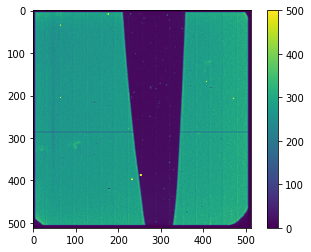

In [21]:
h1, h1_x, h1_y = np.histogram2d(c_NN_all,r_NN_all,range=[[0,512],[0,512]],bins=(512,512))
plt.imshow(h1.T,vmax=500)
plt.colorbar()

(180.0, 230.0)

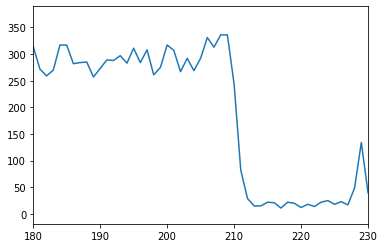

In [24]:
#xcenters = (h1_x[:-1] + h1_x[1:])/2
xcenters = np.arange(len(h1_x)-1)
plt.plot(xcenters,h1[:,10])
plt.xlim(180,230)

In [27]:
x_guess = 210
# 349 for 850 bins
r_edges, x_edges, scurves = [], [], []
for row in range(h1.T.shape[1]):
    
    #if(row == 286): continue
    
    # Perform the fit.
    try:
        L,x0,k,b = fit_scurve(h1.T,row,x_guess,rng=20)
    except:
        print("** Fit failed for row",row)
        L,k,b = None,None,None
        x0 = x_guess
    
    x_edge = int(np.round(x0))
    
    if(abs(x_edge - x_guess) < 2):
        x_guess = x_edge
    
        if(not(L is None)):
            r_edges.append(row)
            x_edges.append(x_edge)
            scurves.append(h1.T[row,x_edge-29:x_edge+30])
            print("-- Fit row",row,": L=",L,"x0=",x0,"k=",k,"b=",b)
    else:
        print("-- NOT INCLUDING row",row,"due to a sudden change in x0 =",x_edge)

r_edges = np.array(r_edges)
x_edges = np.array(x_edges)
scurves = np.array(scurves)

/home/jrenner/miniconda3/envs/tf2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jrenner/miniconda3/envs/tf2/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jrenner/miniconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


** Fit failed for row 0
** Fit failed for row 1
** Fit failed for row 2
-- NOT INCLUDING row 3 due to a sudden change in x0 = 206
-- Fit row 4 : L= -1.3374348782152203 x0= 209.22157515106466 k= 1.334275136066037 b= 1.5029968080648823
-- Fit row 5 : L= 278.90633070332717 x0= 210.37966920856036 k= -3.1688625529261887 b= 14.903256951561447
-- Fit row 6 : L= 297.74413751064594 x0= 210.23755758356842 k= -3.327559546108722 b= 18.713462947863807
-- Fit row 7 : L= 285.076411430849 x0= 210.20311063589634 k= -3.6446283476222954 b= 18.195996318944502
-- Fit row 8 : L= 244.96794634943757 x0= 210.0228880792095 k= -21.92779198520766 b= 59.39894767882824
-- Fit row 9 : L= 285.104202974666 x0= 210.39933008426107 k= -3.0186811604924615 b= 17.58752486516351
-- Fit row 10 : L= 269.344733132616 x0= 210.5246977860743 k= -3.020031399744305 b= 26.983971567009288
-- Fit row 11 : L= 286.77449489539634 x0= 210.6096901199876 k= -2.6622662087270914 b= 17.889297654228432
-- Fit row 12 : L= 284.1622140636089 x0= 21

-- Fit row 90 : L= 266.2392464539742 x0= 216.67832993556672 k= -3.2364963842323333 b= 12.2705538573646
-- Fit row 91 : L= 267.95178658576515 x0= 216.96968618196132 k= -2.623355705941036 b= 13.056057807876071
-- Fit row 92 : L= 260.56435000319914 x0= 216.7041515248123 k= -3.615231786367901 b= 16.580079359463767
-- Fit row 93 : L= 266.95247794419623 x0= 216.62914830096986 k= -2.684011120797754 b= 15.126336253415394
-- Fit row 94 : L= 257.25945024888114 x0= 216.81347922805332 k= -3.5988904543874676 b= 14.590283157501775
-- Fit row 95 : L= 263.53489944463047 x0= 216.9385499754775 k= -9.158788021257443 b= 13.367471394981967
-- Fit row 96 : L= 260.4554088116111 x0= 217.00500475008187 k= -17.202940943448503 b= 14.169066209580746
-- Fit row 97 : L= 259.9290798890287 x0= 217.31106567638807 k= -3.76224375646035 b= 15.409418270710093
-- Fit row 98 : L= 259.26068949622714 x0= 217.12688009648903 k= -3.4645424758990524 b= 15.149839033850135
-- Fit row 99 : L= 254.41134605707026 x0= 217.1737249656029

-- Fit row 184 : L= 258.3361983491635 x0= 224.70950196029776 k= -4.52230864074902 b= 14.273314072876097
-- Fit row 185 : L= 267.93524040366134 x0= 224.77142637416986 k= -3.189364516571258 b= 13.567951751494105
-- Fit row 186 : L= 264.65323496016833 x0= 224.9711712378206 k= -22.10512081262243 b= 16.47546197957874
-- Fit row 187 : L= 267.14244645471274 x0= 224.99356259865328 k= -21.429858061945914 b= 13.626901100011466
-- Fit row 188 : L= 266.73154888798643 x0= 225.16511380861172 k= -3.8840308357430375 b= 13.558016767533857
** Fit failed for row 189
-- Fit row 190 : L= 264.8081455010917 x0= 225.13034402360287 k= -4.188791369077799 b= 13.86598093064822
-- Fit row 191 : L= 259.0465679356817 x0= 225.19924345877246 k= -2.71307045026461 b= 14.253574877195648
-- Fit row 192 : L= 247.81022773634706 x0= 225.03419942702124 k= -17.87209617083722 b= 31.346150434986644
-- Fit row 193 : L= 243.82203219617884 x0= 225.22399712953938 k= -5.253042441303201 b= 39.56247694419887
-- Fit row 194 : L= 262.595

-- Fit row 291 : L= 271.24770036116405 x0= 235.54395567489405 k= -2.920064867936545 b= 14.306090931359744
-- Fit row 292 : L= 270.0537463349759 x0= 235.40041650860755 k= -2.972514808621075 b= 14.823659989127785
-- Fit row 293 : L= 268.7589781455998 x0= 235.85311784564354 k= -3.444684299294879 b= 13.192635255149197
-- Fit row 294 : L= 273.97685530873866 x0= 235.8997624178371 k= -2.9640647644467144 b= 13.220399538825273
-- Fit row 295 : L= 264.2783949619217 x0= 236.0166290011174 k= -23.152086696411224 b= 15.732416952383321
-- Fit row 296 : L= 263.732312412088 x0= 236.12464131424193 k= -4.350776198756955 b= 15.54433447264663
-- Fit row 297 : L= 270.115239260172 x0= 236.07246078174182 k= -2.96898970101949 b= 14.860294561527239
-- Fit row 298 : L= 262.26430475727915 x0= 236.1006611103432 k= -3.4813325536552564 b= 15.031041895044265
-- Fit row 299 : L= 262.9604122594311 x0= 236.3747974228006 k= -2.7495215297486086 b= 13.727667517731032
-- Fit row 300 : L= 267.80075197203706 x0= 236.503235246

** Fit failed for row 397
-- Fit row 398 : L= 267.33912070103423 x0= 248.64609001784405 k= -3.5088216046144463 b= 18.13880479479367
-- Fit row 399 : L= 264.6315641421801 x0= 248.9634516506075 k= -14.149973075165127 b= 19.157252389555172
-- Fit row 400 : L= 271.3677224330371 x0= 249.2998357054237 k= -2.9574523316715564 b= 18.405292770306943
-- Fit row 401 : L= 271.8347123312305 x0= 249.0174917408099 k= -18.746686120757655 b= 20.994758051735364
-- Fit row 402 : L= 269.0008033034911 x0= 249.0399686002212 k= -3.142001500167793 b= 17.430761513119663
-- Fit row 403 : L= 264.29809105998925 x0= 249.3642677221255 k= -3.1127752070364973 b= 16.855032101794283
-- Fit row 404 : L= 262.4747311099876 x0= 249.37095366658033 k= -3.2082646733931726 b= 18.9330236154692
-- Fit row 405 : L= 263.95949845244706 x0= 249.6020549590604 k= -2.853809525181109 b= 20.065002373482244
-- Fit row 406 : L= 268.52328830428826 x0= 249.63957645038943 k= -3.278603503823611 b= 18.5242524830022
-- Fit row 407 : L= 269.990710

-- Fit row 492 : L= 278.3964189120892 x0= 261.0230983527506 k= -17.96488870998176 b= 22.328520049909464
-- Fit row 493 : L= 278.54697850414993 x0= 261.0279444031259 k= -5.871348703315427 b= 20.628225537839757
-- Fit row 494 : L= 286.56871521226225 x0= 260.9917792500406 k= -23.629783468842508 b= 20.589967606092763
-- Fit row 495 : L= 264.3184022201748 x0= 261.0886211432863 k= -4.982116542325768 b= 34.52804429982358
-- Fit row 496 : L= 287.6269221903589 x0= 261.3498319790408 k= -2.8908907040266647 b= 23.29830413366335
-- Fit row 497 : L= 287.9641025130979 x0= 261.62595313662297 k= -3.0776194677536868 b= 19.24628434577337
-- Fit row 498 : L= 292.16189052239827 x0= 261.84033183117384 k= -2.230259000279623 b= 20.388228179040482
-- Fit row 499 : L= 288.97250670067143 x0= 262.11510844591083 k= -3.1116146582806694 b= 21.2109805657782
-- Fit row 500 : L= 281.6945240319775 x0= 262.0234025379767 k= -4.905741515804979 b= 22.192739199916357
-- Fit row 501 : L= 290.3887487731552 x0= 262.416878268541

sigmoid = L / (1 + e^{-k(x-x0))} + b
L = 126617.89886211454
x0 = 29.01047332453882
k = -3.5579352004577856
b = 7789.227645003637


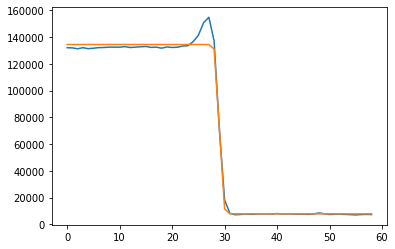

In [33]:
final_scurve = np.sum(scurves[0:479],axis=0)
plt.plot(final_scurve)
ydata = final_scurve
xdata = np.arange(len(final_scurve))
p0 = [np.mean(ydata[ydata > np.mean(ydata)]), 30, 1, min(ydata)]
popt, pcov = curve_fit(sigmoid, xdata, ydata, p0, method='dogbox')
plt.plot(xdata,sigmoid(xdata,*popt))
print("sigmoid = L / (1 + e^{-k(x-x0))} + b")
print("L = {}".format(popt[0]))
print("x0 = {}".format(popt[1]))
print("k = {}".format(popt[2]))
print("b = {}".format(popt[3]))

### S-curve fits for threshold method

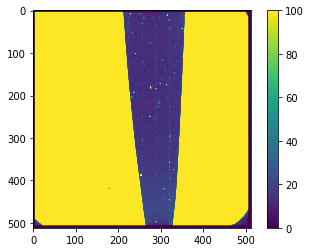

In [37]:
h2, h2_x, h2_y = np.histogram2d(c_th_all,r_th_all,range=[[0,512],[0,512]],bins=(512,512))
plt.imshow(h2.T,vmax=100)
plt.colorbar()

(200.0, 240.0)

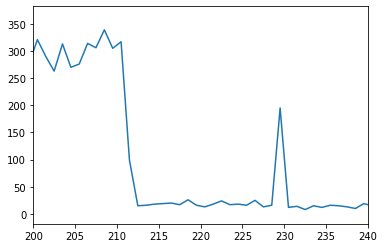

In [38]:
xcenters = (h2_x[:-1] + h2_x[1:])/2
plt.plot(xcenters,h2[:,10])
plt.xlim(200,240)

In [39]:
x_guess = 210
r_edges_th, x_edges_th, scurves_th = [], [], []
for row in range(h2.T.shape[1]):
    
    #if(row == 286): continue
    
    # Perform the fit.
    try:
        L,x0,k,b = fit_scurve(h2.T,row,x_guess)
    except:
        print("** Fit failed for row",row)
        L,k,b = None,None,None
        x0 = x_guess
    
    x_edge = int(np.round(x0))
    if(abs(x_edge - x_guess) < 2):
        x_guess = x_edge
    
        if(not(L is None)):
            r_edges_th.append(row)
            x_edges_th.append(x_edge)
            scurves_th.append(h2.T[row,x_edge-29:x_edge+30])
            print("-- Fit row",row,": L=",L,"x0=",x0,"k=",k,"b=",b)
    else:
        print("-- NOT INCLUDING row",row,"due to a sudden change in x0")

r_edges_th = np.array(r_edges_th)
x_edges_th = np.array(x_edges_th)
scurves_th = np.array(scurves_th)

/home/jrenner/miniconda3/envs/tf2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jrenner/miniconda3/envs/tf2/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jrenner/miniconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


** Fit failed for row 0
** Fit failed for row 1
** Fit failed for row 2
** Fit failed for row 3
** Fit failed for row 4
-- Fit row 5 : L= 278.88970588235605 x0= 210.8967378132558 k= -31.426761221776708 b= 13.541666666666663
-- Fit row 6 : L= 285.45877551020567 x0= 210.91092246354353 k= -31.74636232234923 b= 15.061224489795912
-- Fit row 7 : L= 278.7240816297989 x0= 210.91413974167972 k= -29.688778954105537 b= 14.795918364773273
-- Fit row 8 : L= 251.12326473091093 x0= 210.857571117083 k= -33.319602090601464 b= 38.83673527244515
-- Fit row 9 : L= 335.67753091953506 x0= 210.6467462188396 k= -6.562849370766061 b= 15.9374849589799
-- Fit row 10 : L= 271.2885881444373 x0= 210.96505887970912 k= -25.040098014978184 b= 19.206915959170882
-- Fit row 11 : L= 277.8820552989503 x0= 210.97720408247153 k= -31.576434685748815 b= 15.012877911327767
-- Fit row 12 : L= 271.1249547370154 x0= 211.0141412534976 k= -22.68023659368192 b= 15.862726940638584
-- Fit row 13 : L= 273.1851190619965 x0= 210.9897955

** Fit failed for row 90
-- Fit row 91 : L= 256.1406012265624 x0= 217.0258760389651 k= -21.408185200153966 b= 13.33706734450753
-- Fit row 92 : L= 253.23183640911185 x0= 216.97134268592984 k= -30.4753146564676 b= 15.408163571108563
-- Fit row 93 : L= 259.0107853121234 x0= 216.97638933089655 k= -21.25111701051746 b= 14.328663690511283
-- Fit row 94 : L= 253.09632651616604 x0= 217.01414983188735 k= -32.11478978165812 b= 14.183673476683799
-- Fit row 95 : L= 255.1367346938778 x0= 217.01174232519426 k= -31.41853564374168 b= 14.163265306122293
-- Fit row 96 : L= 257.1950357385499 x0= 217.1960343868119 k= -7.237340585508955 b= 14.004510379972357
** Fit failed for row 97
-- Fit row 98 : L= 252.382523316829 x0= 217.49699983838025 k= -8.173523969636658 b= 13.916924326075534
-- Fit row 99 : L= 256.6213634763494 x0= 217.3637565789878 k= -7.2817490536719145 b= 13.378028441797776
-- Fit row 100 : L= 256.04289215686384 x0= 217.95950176085154 k= -30.47262649534308 b= 13.270833333333243
-- Fit row 101

** Fit failed for row 179
-- Fit row 180 : L= 262.423425374453 x0= 224.2484631872591 k= -6.540261935340492 b= 13.781625382414479
-- Fit row 181 : L= 262.1225490204393 x0= 224.92168504544176 k= -30.466438472245738 b= 12.916666666535102
-- Fit row 182 : L= 260.83483384070206 x0= 224.58120808619418 k= -6.323217147541713 b= 13.734422843567323
-- Fit row 183 : L= 260.915102040819 x0= 224.95966901771195 k= -29.562036816524657 b= 13.24489795918344
-- Fit row 184 : L= 258.93428571428603 x0= 224.9657837996193 k= -31.52053950013604 b= 13.28571428571425
-- Fit row 185 : L= 260.9481246903823 x0= 224.98626352990473 k= -22.217486884394276 b= 13.293177046019167
-- Fit row 186 : L= 260.5528689907523 x0= 225.02781993553637 k= -21.344692314348002 b= 14.133138078592319
-- Fit row 187 : L= 260.7549754759638 x0= 225.03875476643398 k= -15.895296324335176 b= 12.691194094703047
-- Fit row 188 : L= 258.2440581205789 x0= 225.41119205979444 k= -5.388121841610004 b= 12.826499004776085
-- Fit row 189 : L= 257.5958

** Fit failed for row 269
-- Fit row 270 : L= 263.1875000000013 x0= 233.93450864144242 k= -31.20427742770331 b= 14.812499999999979
-- Fit row 271 : L= 264.1355101959782 x0= 233.93565555399755 k= -29.31688654850424 b= 14.224489795609736
-- Fit row 272 : L= 256.4310203881481 x0= 233.9726543865728 k= -31.242031303884282 b= 15.44897961185219
-- Fit row 273 : L= 262.6077551020421 x0= 233.88261245279008 k= -32.9319678175467 b= 14.612244897959183
-- Fit row 274 : L= 266.10000000462793 x0= 233.95353348921378 k= -30.974196105060308 b= 12.999999999414998
** Fit failed for row 275
-- Fit row 276 : L= 261.275086803229 x0= 233.99573749336307 k= -26.242406029373534 b= 14.684683860348418
-- Fit row 277 : L= 262.9615266047618 x0= 234.07545717184527 k= -19.952868988702562 b= 13.790244639881804
-- Fit row 278 : L= 273.27338304043263 x0= 234.3245388588172 k= -5.35423124142016 b= 14.689835659839227
-- Fit row 279 : L= 257.3725490196086 x0= 234.86923854323734 k= -33.9563946592423 b= 15.0
-- Fit row 280 : L

-- Fit row 353 : L= 262.59669858226886 x0= 243.005697783263 k= -20.766939828965338 b= 14.938767101455674
-- Fit row 354 : L= 264.8146938472495 x0= 243.01288552190465 k= -31.278537195268296 b= 16.26530612246886
-- Fit row 355 : L= 266.61548465594416 x0= 243.2080824707338 k= -5.922360305818907 b= 15.765797846112834
-- Fit row 356 : L= 261.9571078431421 x0= 243.9120136534098 k= -30.366167518150288 b= 16.062499999999975
-- Fit row 357 : L= 262.48507124048825 x0= 243.39158864642923 k= -6.584844069705246 b= 16.125888791015324
-- Fit row 358 : L= 261.1372548896425 x0= 243.96616478307322 k= -36.82748386105771 b= 16.66666667898496
-- Fit row 359 : L= 264.70408163265466 x0= 243.9300875493821 k= -30.993057490432758 b= 15.795918367346918
-- Fit row 360 : L= 265.77061224496686 x0= 243.98122602092914 k= -32.52323518464355 b= 16.469387755297408
-- Fit row 361 : L= 263.35916385265983 x0= 243.98089412094393 k= -30.591785432796428 b= 16.75474793694612
-- Fit row 362 : L= 258.2454039376227 x0= 244.019619

** Fit failed for row 446
-- Fit row 447 : L= 267.1104017973721 x0= 255.26536297227034 k= -2.469530548815839 b= 22.30586548669644
-- Fit row 448 : L= 266.94402624029226 x0= 255.02925808395943 k= -19.12871369321968 b= 21.12400811539254
-- Fit row 449 : L= 266.9945064770081 x0= 255.10280571910178 k= -13.624450900806018 b= 20.783072509536577
-- Fit row 450 : L= 264.9224361835038 x0= 255.37241291960765 k= -4.266493102163349 b= 20.783423575060976
-- Fit row 451 : L= 269.4117647058862 x0= 255.9482327047659 k= -29.532606237776594 b= 20.99999999999982
-- Fit row 452 : L= 269.71387754471994 x0= 255.92278675775438 k= -29.152918469679918 b= 21.30612244556198
-- Fit row 453 : L= 266.18612246282805 x0= 255.94896770235803 k= -30.017819891419084 b= 20.693877550445393
-- Fit row 454 : L= 270.34163265306324 x0= 255.97483765260534 k= -29.570370077098303 b= 20.9183673469384
-- Fit row 455 : L= 265.4796856943789 x0= 256.0678167694664 k= -14.387819623599066 b= 21.191684220723285
-- Fit row 456 : L= 268.366

# of NN scurves: 496
# of th scurves: 479
sigmoid = L / (1 + e^{-k(x-x0))} + b
L = 126208.9275588685
x0 = 28.981185426942716
k = -19.417063076461876
b = 8054.1071407522895


/home/jrenner/miniconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


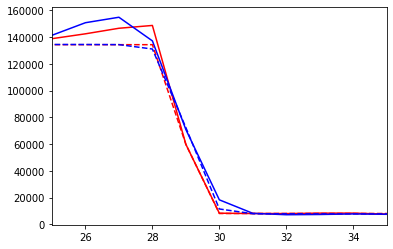

In [46]:
final_scurve_th = np.sum(scurves_th,axis=0)
plt.plot(final_scurve_th,color='red')
plt.plot(final_scurve,color='blue')
ydata = final_scurve_th
xdata = np.arange(len(final_scurve_th))
p0 = [np.mean(ydata[ydata > np.mean(ydata)]), 30, 1, min(ydata)]
popt_th, pcov_th = curve_fit(sigmoid, xdata, ydata, p0, method='dogbox')
plt.plot(xdata,sigmoid(xdata,*popt_th),'--',color='red')
plt.plot(xdata,sigmoid(xdata,*popt),'--',color='blue')
plt.xlim([25,35])
print("# of NN scurves:",len(scurves))
print("# of th scurves:",len(scurves_th))
print("sigmoid = L / (1 + e^{-k(x-x0))} + b")
print("L = {}".format(popt_th[0]))
print("x0 = {}".format(popt_th[1]))
print("k = {}".format(popt_th[2]))
print("b = {}".format(popt_th[3]))

## Backup code

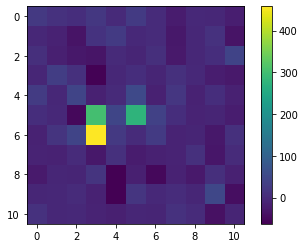

In [47]:
plt.imshow(subimg)
plt.colorbar()

In [25]:
x0 = 105
nrow = 5
rng = 20
xmin = max(0,x0-rng)
xmax = min(h1.T.shape[1],x0+rng)
ydata = h1.T[nrow,xmin:xmax]
xdata = np.arange(xmin,xmax)

# Set an initial guess and perform the fit.
p0 = [np.mean(ydata[ydata > np.mean(ydata)]), x0, 1, min(ydata)]
popt, pcov = curve_fit(sigmoid, xdata, ydata, p0, method='dogbox')

NameError: name 'sigmoid' is not defined

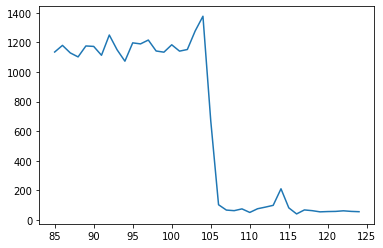

In [79]:
plt.plot(xdata,ydata)

(200.0, 240.0)

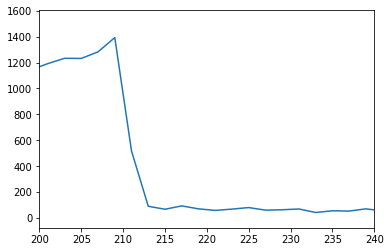

In [15]:
xcenters = (h1_x[:-1] + h1_x[1:])/2
plt.plot(xcenters,h1.T[3,:])
plt.xlim(200,240)

In [ ]:
#plt.imshow(np.average(imgs_medsub,axis=0))
plt.imshow(imgs_th[0][0:11,0:11])
plt.colorbar()

In [ ]:
subimg_halfsize = 5
rmin = 0
rmax = len(available_edges)
cmin = 0
cmax = imgs_th.shape[2]
    
# For each individual thresholded image, choose the sub-images.
valid_subimages_th, valid_subimages = [], []
line_m, line_b = [], []
for iimg in range(1): #len(imgs_th.shape[0]))
    
    img    = imgs[iimg]
    img_th = imgs_th[iimg]
    
    done = (available_edges == -1).all()

    while(not done):
        
        # Choose a random location in the x-edges array.
        rmid = np.random.randint(rmax)
        
        # Make sure the current edge is available.
        if(available_edges[rmid] < 0):
            continue
        
        # Select a window equal to the subimage size in length.
        rstart = rmid - subimg_halfsize
        rend   = rmid + subimg_halfsize + 1
        if(rstart < rmin or rend >= rmax):
            if(rstart < rmin): rstart = rmin
            if(rend >= rmax):  rend = rmax
            available_edges[rstart:rend] = -1
            continue
        
        # Ensure all edges for this image have not yet been used.
        aedges = available_edges[rstart:rend]
        if((aedges > 0).all()):
        
            # Construct the subimage.
            xmid = x_edges[rmid]
            cstart = xmid - subimg_halfsize
            cend   = xmid + subimg_halfsize + 1
            
            # Only continue with a subimage that fits properly in the full image.
            if(cstart >= cmin and cend < cmax):
                
                # Create the subimage.
                subimg    = img[rstart:rend,cstart:cend]
                subimg_th = img_th[rstart:rend,cstart:cend]

                # Check that the (thresholded) subimage is valid.
                if(check_subimage_th(subimg_th)):
                    
                    # Compute the slopes and intercepts.
                    x1 = (x_edges[rstart] - cstart) + 0.5
                    x2 = (x_edges[rend] - cstart) + 0.5
                    if(x2 == x1): x2 = x1-1
                    y1 = 0.5
                    y2 = (rend - rstart) - 0.5
                    m = (y2 - y1) / (x2 - x1)
                    b = y2 - m*x2
                    print("xmid_rel = {}, cstart = {}, cend = {}".format(xmid-cstart,cstart,cend))
                    print("(x1,y1) = ({},{}); (x2,y2) = ({},{})".format(x1,y1,x2,y2))
                    line_m.append(m)
                    line_b.append(b)

                    # Save the subimage.
                    valid_subimages.append(subimg)
                    valid_subimages_th.append(subimg_th)

                    # Remove all edges for this subimage from availability.
                    available_edges[rstart:rend] = -1

                # If the image is not valid, do nothing, but continue the loop.
                
            else:
                available_edges[rstart:rend] = -1
           
        # If not all edges are available, 
        else:
            available_edges[rstart:rend] = -1
        
        # Set the terminating condition.
        done = (available_edges == -1).all()
        print("Number of available edges:",np.sum(available_edges == 1),"/",len(available_edges))

line_m = np.array(line_m)
line_b = np.array(line_b)
valid_subimages = np.array(valid_subimages)
valid_subimages_th = np.array(valid_subimages_th)

# Generate random multi-electron events

In [ ]:
dset = tr.EMDataset("dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)

In [ ]:
frameset  = tr.EMFrameDataset(dset,frame_size=20,nelec_mean=2,nelec_sigma=0.1,noise_mean=683,noise_sigma=11.2,m_line=-2.0,b_line=30.0, lside = 0, res_factor=3)
#frameset = tr.EMFrameDataset(dset,frame_size=4855,nelec_mean=103713,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
#frameset = tr.EMFrameDataset(dset,frame_size=100,nelec_mean=88,nelec_sigma=2,noise_mean=0,noise_sigma=20)
#frameset = tr.EMFrameDataset(dset,frame_size=100,nelec_mean=10,nelec_sigma=1,noise_mean=0,noise_sigma=20)

##### Generate many frames and fit

In [ ]:
def fit_line(fit_img, th = 0.5, pct_rng = 0.2, nbins_hdist = 80):
    
    A = fit_img/np.mean(fit_img)
    nrows = A.shape[0]
    ncols = A.shape[1]
    ncts = np.sum(A[A >= th])
    nzeros = np.sum(1-A[A < th])
    wcts = 1 #nzeros/ncts
    indices = np.indices((nrows,ncols))
    irows = indices[0]
    icols = indices[1]
    print("nzeros = {}, ncts = {}, wcts = {}".format(nzeros,ncts,wcts))

    def count_loss(x):
        m,b = x

        # The loss L is:
        #
        # (number of 0s in the dark region) - wcts*(number of 1s in the dark region)
        # + wcts*(number of 1s in the light region) - (number of 0s in the dark region)
        # 
        # where wcts is the count weight, determined such that the number of counts multiplied by wcts is equal to
        # the number of zeros.
        L = 0
        L1 = np.sum(1-A[(irows < m*icols + b) & (A < th)])
        L2 = np.sum(A[(irows < m*icols + b) & (A >= th)])
        L3 = np.sum(A[(irows >= m*icols + b) & (A >= th)])
        L4 = np.sum(1-A[(irows >= m*icols + b) & (A < th)])

        L = L1 - wcts*L2 + wcts*L3 - L4
        #print("Loss is:",-L,"with L1 =",L1,"L2 =",L2,"L3 =",L3,"L4 =",L4)
        return -L
    
    initial_guess = [-1.5*nrows/ncols,2.0*nrows]
    result = optimize.minimize(count_loss,initial_guess,method='Nelder-Mead',tol=1e-5)
    m,b = result.x
    Lmin = result.fun
    print("m = ",m,"b = ",b,"Lmin=",Lmin)
    
    # Force m and b.
    m = -2.0
    b = 90.0
    print("NOTE: hard-coding m and b")
    
    # Get the loss over a range of the parameters.
    mrng = np.arange(m-pct_rng*m, m+pct_rng*m, 2*pct_rng*m/1000)
    Lrng_m = np.array([count_loss([mval,b])/Lmin for mval in mrng])
    brng = np.arange(b-pct_rng*b, b+pct_rng*b, 2*pct_rng*b/1000)
    Lrng_b = np.array([count_loss([m,bval])/Lmin for bval in brng])
    
    # Get the histogram of mean value vs. distance.
    dist = (5./3.)*(m*icols - irows + b) / (m**2 + 1)                          # compute distance to line for each point
    hw, bb = np.histogram(dist.flatten(),weights=A.flatten(),bins=nbins_hdist)  # weighted histogram
    hh, bb = np.histogram(dist.flatten(),bins=nbins_hdist)                      # unweighted (for normalization)
    hh[hh == 0] = 0.1
    hfinal = hw / hh                                                   # normalize the histogram
    bcenters = (bb[1:] + bb[:-1]) / 2                                  # determine the bin centers
    
    return m,b,Lmin,mrng,Lrng_m,brng,Lrng_b,hfinal,bcenters

# Fit the S-curve to a sigmoid.
def fit_scurve():
    

In [ ]:
# Create some number of events and count them.
th_unet = 0.2
th_classical = 825/4.
evts = np.arange(0,100000)
l_frames, l_labels, l_ct_unet, l_ct_classical = [], [], [], []
for evt in evts:
    frame,label = frameset[evt]
    gnd_truth = label[0]
    
    # Send through the model.
    data = torch.tensor(frame).float().unsqueeze(0).unsqueeze(1).cuda()
    output_score = model(data)
    
    # Compute the predicted pixel values.
    prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()
    ct_unet = (prob > th_unet)
    
    # Count with a single threshold.
    #ct_classical = (frame > th_classical)
    
    # Max argument classical truth.
    #ct_classical = np.zeros(frame.shape)
    #ct_classical[np.unravel_index(np.argmax(frame),frame.shape)] = 1
    
    # Threshold truth.
    ct_classical = label[1]
    
    l_frames.append(frame)
    l_labels.append(gnd_truth)
    l_ct_unet.append(ct_unet)
    l_ct_classical.append(ct_classical)
    
    if((evt-evts[0]) % (len(evts)/100) == 0):
            print("{}% done".format(int((evt-evts[0]) / (len(evts)/100))))
            
l_frames = np.array(l_frames)
l_labels = np.array(l_labels)
l_ct_unet = np.array(l_ct_unet)
l_ct_classical = np.array(l_ct_classical)

# Create a summed frame, label, and count arrays.
frame = np.sum(l_frames,axis=0)
label = np.sum(l_labels,axis=0)
ct_unet = np.sum(l_ct_unet,axis=0)
ct_classical = np.sum(l_ct_classical,axis=0)

In [ ]:
raw_th = 0.99
ct_th = 0.1
m_frame,b_frame,Lmin_frame,mrng_frame,Lrng_m_frame,brng_frame,Lrng_b_frame,hdist_frame,bcenters_frame = fit_line(frame,th=raw_th)
m_label,b_label,Lmin_label,mrng_label,Lrng_m_label,brng_label,Lrng_b_label,hdist_label,bcenters_label = fit_line(label,th=ct_th)
m_unet,b_unet,Lmin_unet,mrng_unet,Lrng_m_unet,brng_unet,Lrng_b_unet,hdist_unet,bcenters_unet = fit_line(ct_unet,th=ct_th)
m_classical,b_classical,Lmin_classical,mrng_classical,Lrng_m_classical,brng_classical,Lrng_b_classical,hdist_classical,bcenters_classical = fit_line(ct_classical,th=ct_th)

In [ ]:
#frame,label = frameset[0]
logscale = False
nrows = frame.shape[0]
ncols = frame.shape[1]

fig = plt.figure()
fig.set_figheight(12.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(221)
if(logscale):
    plt.imshow(np.log(frame))
    cbar = plt.colorbar()
    cbar.set_label("log(counts)")
    #plt.title("Raw frame (log counts, threshold = {})\nm = {:.2f}, b = {:.2f}".format(raw_th,m_frame,b_frame))
    plt.title("Raw frame (log counts)\nm = {:.2f}, b = {:.2f}".format(m_frame,b_frame))
else:
    plt.imshow(frame/np.max(frame))
    cbar = plt.colorbar()
    #plt.title("Raw frame (threshold = {})\nm = {:.2f}, b = {:.2f}".format(raw_th,m_frame,b_frame))
    plt.title("Raw frame\nm = {:.2f}, b = {:.2f}".format(m_frame,b_frame))
xfit = np.arange(0,ncols-1,0.1)
yfit = m_frame*xfit + b_frame
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

ax2 = fig.add_subplot(222)
plt.imshow(label/np.max(label))
#plt.title("Truth (threshold = {})\nm = {:.2f}, b = {:.2f}".format(ct_th,m_label,b_label))
plt.title("Truth\nm = {:.2f}, b = {:.2f}".format(m_label,b_label))
plt.colorbar()
xfit = np.arange(0,ncols-1,0.1)
yfit = m_label*xfit + b_label
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

ax3 = fig.add_subplot(223)
plt.imshow(ct_unet/np.max(ct_unet))
#plt.title("UNet counts (threshold = {})\nm = {:.2f}, b = {:.2f}".format(ct_th,m_unet,b_unet))
plt.title("UNet counts\nm = {:.2f}, b = {:.2f}".format(m_unet,b_unet))
plt.colorbar()
xfit = np.arange(0,ncols-1,0.1)
yfit = m_unet*xfit + b_unet
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

ax4 = fig.add_subplot(224)
plt.imshow(ct_classical/np.max(ct_classical))
#plt.title("Classical counts + line info (threshold = {})\nm = {:.2f}, b = {:.2f}".format(ct_th,m_classical,b_classical))
plt.title("Classical counts + line info\nm = {:.2f}, b = {:.2f}".format(m_classical,b_classical))
plt.colorbar()
xfit = np.arange(0,ncols-1,0.1)
yfit = m_classical*xfit + b_classical
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

print("Total counts, truth:",np.sum(label))
print("Total counts, classical:",np.sum(ct_classical))
print("Total counts, unet:",np.sum(ct_unet))

In [ ]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

frame_mult = 1./(1.-min(hdist_frame))

ax1 = fig.add_subplot(121)
plt.plot(bcenters_frame,frame_mult*(hdist_frame-min(hdist_frame)),'.-',color='black',label='frame')
plt.plot(bcenters_label,hdist_label,'.-',color='green',label='true')
plt.plot(bcenters_unet,hdist_unet,'.-',color='blue',label='UNet')
plt.plot(bcenters_classical,hdist_classical,'.-',color='red',label='classical+line')
plt.xlim([-10,10])
plt.ylim([0.0,3.2])
plt.xlabel("Distance from line (micrometers)")
plt.ylabel("Mean number of normalized counts")
plt.legend()

In [ ]:
# Save s-curve information.
np.savez("scurve_edge_th02_epoch10.npz", bcenters_frame=bcenters_frame, hdist_frame=hdist_frame, bcenters_label=bcenters_label, hdist_label=hdist_label, 
         bcenters_unet=bcenters_unet, hdist_unet=hdist_unet, bcenters_classical=bcenters_classical, 
         hdist_classical=hdist_classical)

In [ ]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121)
plt.plot(mrng_frame/m_frame,Lrng_m_frame,color='black',label='frame')
plt.plot(mrng_label/m_label,Lrng_m_label,color='green',label='true')
plt.plot(mrng_unet/m_unet,Lrng_m_unet,color='blue',label='UNet')
plt.plot(mrng_classical/m_classical,Lrng_m_classical,color='red',label='classical')
plt.xlabel("Parameter m/m$_0$")
plt.ylabel("Relative loss L/L(m$_0$)")
plt.legend()

ax2 = fig.add_subplot(122)
plt.plot(brng_frame/b_frame,Lrng_b_frame,color='black',label='frame')
plt.plot(brng_label/b_label,Lrng_b_label,color='green',label='true')
plt.plot(brng_unet/b_unet,Lrng_b_unet,color='blue',label='UNet')
plt.plot(brng_classical/b_classical,Lrng_b_classical,color='red',label='classical')
plt.xlabel("Parameter b/b$_0$")
plt.ylabel("Relative loss L/L(b$_0$)")
plt.legend()

In [ ]:
np.savez("evt_arrays.npz",evt_arrays=l_evt_arr)

#### Plot s-curve data

In [ ]:
scurve_noedge = np.load("scurve_noedge_th088.npz")
bc_label_noedge = scurve_noedge['bcenters_label']
h_label_noedge = scurve_noedge['hdist_label']
bc_unet_noedge = scurve_noedge['bcenters_unet']
h_unet_noedge = scurve_noedge['hdist_unet']
bc_classical_noedge = scurve_noedge['bcenters_classical']
h_classical_noedge = scurve_noedge['hdist_classical']

scurve_edge = np.load("scurve_edge_th08.npz")
bc_frame_edge = scurve_edge['bcenters_frame']
h_frame_edge = scurve_edge['hdist_frame']
bc_label_edge = scurve_edge['bcenters_label']
h_label_edge = scurve_edge['hdist_label']
bc_unet_edge = scurve_edge['bcenters_unet']
h_unet_edge = scurve_edge['hdist_unet']
bc_classical_edge = scurve_edge['bcenters_classical']
h_classical_edge = scurve_edge['hdist_classical']

scurve_edge10 = np.load("scurve_edge_th08_epoch10.npz")
bc_label_edge10 = scurve_edge10['bcenters_label']
h_label_edge10 = scurve_edge10['hdist_label']
bc_unet_edge10 = scurve_edge10['bcenters_unet']
h_unet_edge10 = scurve_edge10['hdist_unet']
bc_classical_edge10 = scurve_edge10['bcenters_classical']
h_classical_edge10 = scurve_edge10['hdist_classical']

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

frame_mult = 1./(1.-min(h_frame_edge))

ax1 = fig.add_subplot(111)
plt.plot(bc_frame_edge,frame_mult*(h_frame_edge-min(h_frame_edge)),'.-',color='black',label='raw frame, scaled')
plt.plot(bc_classical_edge,h_classical_edge,'.-',color='red',label='classical')
plt.plot(bc_unet_noedge,h_unet_noedge,'.-',color='orange',label='UNet, no edge, epoch 500')
plt.plot(bc_unet_edge10,h_unet_edge10,'.-',color='cyan',label='UNet + edge, epoch 11')
plt.plot(bc_unet_edge,h_unet_edge,'.-',color='blue',label='UNet + edge, epoch 500')
plt.plot(bc_label_edge,h_label_edge,'.-',color='green',label='true')
plt.xlim([-5,5])
plt.ylim([0.0,1.0])
plt.xlabel("Distance from line (pixels)")
plt.ylabel("Mean number of normalized counts")
plt.legend()

##### Examine a large generated frame

In [ ]:
plt.imshow(label[0,0:50,0:50])
plt.colorbar()

In [ ]:
img_sim = frame.flatten()

In [ ]:
#plt.hist(img_sim[(img_sim < 400)],bins=50)
plt.hist(img_sim,bins=50)
plt.xlabel("Pixel values")
plt.ylabel("Counts/bin")
plt.yscale("log")
print("Total pixels:",len(img_sim))
#plt.xlim([0,500])

In [ ]:
np.savez("frame_4855x4855_11occ.npz",frame=frame)

## Train a network (multi-electron)

In [ ]:
modeldir = '/home/jrenner/local/jerenner/emsim/models'
lrate       = 1e-3   # Learning rate to use in the training.
load_model  = False   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 0      # Number of initial epoch
epoch_end   = 200    # Number of final epoch
model_load_checkpoint = "{}/model_init_199.pt".format(modeldir)

# Create the dataset.
# 576x576: 2927 +/- 71
# 100x100: 88 +/- 2
# 50x50: 22 +/- 0.5
#dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)

# "Real-data-like" dataset: occupancy 11, noise_mean=683, noise_sigma=11.2
dset = tr.EMDataset("dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)
#dataset_train   = tr.EMFrameDataset(dset,frame_size=50,nelec_mean=11,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
dataset_train = tr.EMFrameDataset(dset,frame_size=20,nelec_mean=2,nelec_sigma=0.1,noise_mean=683,noise_sigma=11.2,m_line=-2.0,b_line=30.0,res_factor=3)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=50, shuffle=False, collate_fn=tr.my_collate_unet, num_workers=1)

# Define the model.
model = UNet(n_channels=1, n_classes=1)
model.cuda()

optimizer = optim.RMSprop(model.parameters(), lr=lrate, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    model.eval()

In [ ]:
# Run the training.
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    train_loss = tr.train_unet(model, epoch, train_loader, optimizer)
    scheduler.step(train_loss)
    #if(epoch % 50 == 0):
    torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

In [ ]:
torch.save(model.state_dict(), "{}/model_frames_20x20_noise683_2e_bcsloss_edge_unweighted_front_1em4_100kev_{}.pt".format(modeldir,epoch))

In [ ]:
# Plot the training loss and accuracy.
tloss = np.loadtxt("train.txt")

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
plt.plot(tloss[:,0],tloss[:,1],label='training')
plt.legend()
plt.title("Loss")
plt.yscale('log')

ax2 = fig.add_subplot(122);
plt.plot(tloss[:,0],tloss[:,2],label='training')
plt.legend()
plt.title("Accuracy")

#### Test the net

In [ ]:
sigmoid = nn.Sigmoid()
#dset = tr.EMDataset("dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)
#dataset_train   = tr.EMFrameDataset(dset,frame_size=50,nelec_mean=11,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
model.eval()

In [ ]:
# Loop over many events and evaluate the true positives and false positives.
# Store in arrays as:
#
#  [tp0 tp1 tp2 tp3 ... tpN], each number corresponding to a different NN threshold or classical threshold
#
tp_unet = []; fp_unet = []
tp_classical = []; fp_classical = []
#nn_thresholds = np.arange(0.05,1.0,0.1)
nn_thresholds = np.concatenate((np.logspace(-4,-0.1,500), np.logspace(-0.1,0,500)))
#nn_thresholds = np.logspace(-3,0,1000)
classical_thresholds = np.arange(600/4,7000/4,10)
evts = np.arange(100000,101000)
for evt in evts:
    
    # Get the event and truth.
    evt_item = dataset_train[evt]
    evt_arr = evt_item[0]
    evt_lbl = evt_item[1][0]
    
    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    output_score = model(data)
    
    # Compute the predicted pixel values.
    prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()
    
    # Compute the TP and FP values for unet.
    temp_tp = []; temp_fp = []
    for th in nn_thresholds:
        pred = (prob > th)
        tp = np.sum((evt_lbl == 1) & (pred == True))
        fn = np.sum((evt_lbl == 1) & (pred == False))
        if( (tp + fn) > 0): tp = tp / (tp + fn)
        else: tp = 1
        fp = np.sum((evt_lbl == 0) & (pred == True))
        tn = np.sum((evt_lbl == 0) & (pred == False))
        if( (fp + tn) > 0): fp = fp / (fp + tn)
        else: fp = 0
        temp_tp.append(tp)
        temp_fp.append(fp)
    tp_unet.append(temp_tp)
    fp_unet.append(temp_fp)
    
    # Compute the TP and FP values for the classical threshold.
    temp_tp = []; temp_fp = []
    for th in classical_thresholds:
        #pred = (evt_arr > th)
        pred = np.zeros(evt_arr.shape)
        pred[np.unravel_index(np.argmax(evt_arr),evt_arr.shape)] = 1
        tp = np.sum((evt_lbl == 1) & (pred == True))
        fn = np.sum((evt_lbl == 1) & (pred == False))
        if( (tp + fn) > 0): tp = tp / (tp + fn)
        else: tp = 1
        fp = np.sum((evt_lbl == 0) & (pred == True))
        tn = np.sum((evt_lbl == 0) & (pred == False))
        if( (tp + tn) > 0): fp = fp / (fp + tn)
        else: tp = 0
        temp_tp.append(tp)
        temp_fp.append(fp)
    tp_classical.append(temp_tp)
    fp_classical.append(temp_fp)
    
    if((evt-evts[0]) % (len(evts)/100) == 0):
            print("{}% done".format(int((evt-evts[0]) / (len(evts)/100))))
    
tp_unet = np.array(tp_unet)
fp_unet = np.array(fp_unet)
tp_classical = np.array(tp_classical)
fp_classical = np.array(fp_classical)

In [ ]:
tp_rate_unet = np.mean(tp_unet,axis=0)
tp_err_unet = np.std(tp_unet,axis=0)/np.sqrt(tp_unet.shape[0])
fp_rate_unet = np.mean(fp_unet,axis=0)
fp_err_unet = np.std(fp_unet,axis=0)/np.sqrt(fp_unet.shape[0])
tp_rate_classical = np.mean(tp_classical,axis=0)
tp_err_classical = np.std(tp_classical,axis=0)/np.sqrt(tp_classical.shape[0])
fp_rate_classical = np.mean(fp_classical,axis=0)
fp_err_classical = np.std(fp_classical,axis=0)/np.sqrt(fp_classical.shape[0])

plt.errorbar(fp_rate_unet,tp_rate_unet,xerr=fp_err_unet,yerr=tp_err_unet,label='Unet')
plt.errorbar(fp_rate_classical,tp_rate_classical,xerr=fp_err_classical,yerr=tp_err_classical,label='Basic threshold')
plt.xlim([0,0.02])
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

In [ ]:
print("NN ------------------")
for tpr,fpr,th in zip(tp_rate_unet,fp_rate_unet,nn_thresholds):
    print("[Threshold {}] TP = {}, FP = {}".format(th,tpr,fpr))
print("Classical threshold ------------------")
for tpr,fpr,th in zip(tp_rate_classical,fp_rate_classical,classical_thresholds):
    print("[Threshold {}] TP = {}, FP = {}".format(th,tpr,fpr))

In [ ]:
evt_plt = 10008
evt_item = dataset_train[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1][1]

# Send through the model.
data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
#target = torch.tensor(evt_lbl).float().cuda()
output_score = model(data)

# Compute the predicted pixel and (x,y) values.
prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()

# Threshold
# prob = np.zeros(evt_arr.shape)
# prob[evt_arr > 80] = 1

# Determine number of correct pixels
th = 0.2
pred = (prob > th)
nelec = int(np.sum(evt_lbl == 1))
nelec_pred = int(np.sum(pred))
nspace = int(np.sum(evt_lbl == 0))
nelec_coinc = np.sum((evt_lbl == 1) & (pred == True))
nspace_coinc = np.sum((evt_lbl == 0) & (pred == False))
print("{}/{} electrons predicted".format(nelec_pred,nelec))
print("{}/{} electrons coincided exactly".format(nelec_coinc,nelec))
print("{}/{} empty spaces coincided exactly".format(nspace_coinc,nspace))

# Information for drawing the line.
nrows = evt_arr.shape[0]
ncols = evt_arr.shape[1]
indices = np.indices((nrows,ncols))
irows = indices[0]
icols = indices[1]
m = -2*nrows/ncols
b = 80
print("Line drawn: m = {}, b = {}".format(m,b))

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event")

# xfit = np.arange(0,ncols,0.1)
# yfit = m*xfit + b
# plt.plot(xfit[(yfit > 0) & (yfit < nrows)],yfit[(yfit > 0) & (yfit < nrows)])

ax2 = fig.add_subplot(132)
plt.imshow(evt_lbl)
plt.colorbar()
plt.title("Target")

ax3 = fig.add_subplot(133)
#plt.imshow(np.log10(prob))
plt.imshow(prob)
plt.colorbar()
plt.title("{}/{} electrons predicted\n{}/{} electrons coincided exactly\n{}/{} empty spaces coincided exactly".format(nelec_pred,nelec,nelec_coinc,nelec,nspace_coinc,nspace))

#### Test loss function

In [ ]:
# Construct output and label arrays for 5 events.
frames,outputs,labels = [], [], []
for iframe in range(50):
    frame,label = frameset[iframe]
    frames.append(frame)
    outputs.append(label[1])
    labels.append(label)
frames = np.array(frames)
outputs = np.array(outputs)
labels = np.array(labels)
print("Frames shape is:",frames.shape)
print("Outputs shape is:",outputs.shape)
print("Labels shape is:",labels.shape)

# Convert to tensors.
outputs[outputs == 0] = 1e-10
outputs[outputs == 1] = 0.99999999
frames = torch.tensor(frames)
output = torch.tensor(np.log(outputs/(1-outputs)))
target = torch.tensor(labels)

# Compute the loss.
sigma_dist = 1
real_truth = target[:,0,:,:]
th_truth = target[:,1,:,:]
edge_truth = target[:,2,:,:]
dist = target[:,3,:,:]

final_truth = th_truth * edge_truth

wts     = torch.sum(torch.exp(-(dist)**2/(2*sigma_dist**2))*th_truth,axis=(1,2))
wt_norm = torch.sum(th_truth,axis=(1,2))
wt_norm[wt_norm == 0] = 1
wts /= wt_norm
print("Weights are: ",wts)

w_edge = 100
bce_loss = torch.nn.BCEWithLogitsLoss(reduce=False)
sigmoid = torch.nn.Sigmoid()
loss0 = bce_loss(output,final_truth)
loss1 = w_edge*sigmoid(output)*(1-edge_truth)
loss0W = torch.exp(-(dist)**2/(2*sigma_dist**2))*(loss0)
loss1W = torch.exp(-(dist)**2/(2*sigma_dist**2))*(loss1)
loss = torch.mean(torch.exp(-(dist)**2/(2*sigma_dist**2))*(loss0 + loss1))
print("Mean loss is ",loss)
print("Mean loss0 is ",torch.mean(loss0))
print("Mean loss0W is ",torch.mean(loss0W))
print("Mean loss1 is ",torch.mean(loss1))
print("Mean loss1W is ",torch.mean(loss1W))

In [ ]:
dist_mod = torch.sum(torch.abs(dist*(edge_truth-1)),axis=(1,2))
dist_mod.shape

In [ ]:
iframe = 2
show_sum = False

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(16.0)

ax1 = fig.add_subplot(241)
if(show_sum): plt.imshow(np.sum(np.array(sigmoid(output)),axis=0),interpolation=None)
else: plt.imshow(np.array(sigmoid(output[iframe])),interpolation=None)
plt.colorbar()
plt.title("sigmoid(Output)")

ax2 = fig.add_subplot(242)
if(show_sum): plt.imshow(np.sum(np.array(th_truth),axis=0),interpolation=None)
else: plt.imshow(np.array(real_truth[iframe]),interpolation=None)
plt.colorbar()
plt.title("Real truth")

ax3 = fig.add_subplot(243)
if(show_sum): plt.imshow(np.sum(np.array(edge_truth), axis=0))
else: plt.imshow(np.array(edge_truth[iframe]))
plt.colorbar()
plt.title("Edge truth")

ax4 = fig.add_subplot(244)
if(show_sum): plt.imshow(np.sum(np.array(torch.exp(-(dist)**2/(2*sigma_dist**2))),axis=0))
else: plt.imshow(np.array(torch.exp(-(dist)**2/(2*sigma_dist**2))[iframe]))
plt.colorbar()
plt.title("Distance")

ax5 = fig.add_subplot(245)
if(show_sum): plt.imshow(np.sum(np.array(loss0), axis=0))
else: plt.imshow(np.array(loss0[iframe]))
plt.colorbar()
plt.title("Loss0")

ax6 = fig.add_subplot(246)
if(show_sum): plt.imshow(np.sum(np.array(loss1),axis=0))
else: plt.imshow(np.array(loss1[iframe]))
plt.colorbar()
plt.title("Loss1")

ax7 = fig.add_subplot(247)
if(show_sum): plt.imshow(np.sum(np.array(loss0W + loss1W),axis=0))
else: plt.imshow(np.array(loss0W[iframe] + loss1W[iframe]))
# if(show_sum): plt.imshow(np.sum(np.array(dist_mod),axis=0))
# else: plt.imshow(np.array(dist_mod[iframe]))
plt.colorbar()
plt.title("LossW")

In [ ]:
iframe = 2
show_sum = False

fig = plt.figure()
fig.set_figheight(3.0)
fig.set_figwidth(20.0)

ax1 = fig.add_subplot(151)
if(show_sum): plt.imshow(np.sum(frames,axis=0)/np.max(np.sum(frames,axis=0)),interpolation=None)
else: plt.imshow(np.array(frames[iframe]),interpolation=None)
plt.colorbar()
plt.title("Event")

ax2 = fig.add_subplot(152)
if(show_sum): plt.imshow(np.sum(np.array(real_truth),axis=0),interpolation=None)
else: plt.imshow(np.array(real_truth[iframe]),interpolation=None)
plt.colorbar()
plt.title("Real truth")

ax3 = fig.add_subplot(153)
if(show_sum): plt.imshow(np.sum(np.array(th_truth),axis=0),interpolation=None)
else: plt.imshow(np.array(th_truth[iframe]),interpolation=None)
plt.colorbar()
plt.title("Classical threshold")

ax4 = fig.add_subplot(154)
if(show_sum): plt.imshow(np.sum(np.array(edge_truth), axis=0))
else: plt.imshow(np.array(edge_truth[iframe]))
plt.colorbar()
plt.title("Edge truth")

ax5 = fig.add_subplot(155)
if(show_sum): plt.imshow(np.sum(np.array(final_truth), axis=0))
else: plt.imshow(np.array(final_truth[iframe]))
plt.colorbar()
plt.title("Combined truth")

##### Test on real data

In [ ]:
# Evaluate real data
img_data_cut = img_data[-1023:,-1440:]/12
img_data_torch = torch.tensor(img_data_cut).float().unsqueeze(0).unsqueeze(1).cuda()
output_score = model(img_data_torch)
prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()

In [ ]:
# Plot the results of the real data evaluation
logscale = False
view_row_low = -350
view_row_high = -300
view_col_low = -350
view_col_high = -300

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
if(logscale):
    plt.imshow(np.log(img_data_cut[view_row_low:view_row_high,view_col_low:view_col_high]),interpolation='none')
    cbar = plt.colorbar()
    cbar.set_label("log(counts)")
    plt.title("Scaled data (log counts)")
else:
    plt.imshow(img_data_cut[view_row_low:view_row_high,view_col_low:view_col_high],interpolation='none') #np.log(frame))
    cbar = plt.colorbar()
    plt.title("Scaled data")

ax2 = fig.add_subplot(122);
plt.imshow(prob[view_row_low:view_row_high,view_col_low:view_col_high],interpolation='none')
plt.title("U-net output")
plt.colorbar()

In [ ]:
prob.shape

## Real data

In [ ]:
import struct
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize

In [ ]:
# From https://stackoverflow.com/questions/1035340/reading-binary-file-and-looping-over-each-byte
def bytes_from_file(filename, chunksize=4):
    with open(filename, "rb") as f:
        while True:
            chunk = f.read(chunksize)
            if chunk:
                yield struct.unpack('@I', chunk)[0]
            else:
                break

In [ ]:
datfile = "/home/jrenner/local/data/electronsim/stack_1.dat"
freader = iter(bytes_from_file(datfile))

In [ ]:
img = []
for i in range(5760*4092):
    img.append(next(freader))
img = np.array(img)

In [ ]:
# Prepare for input to a NN
img_data = img.reshape([4092,5760])

In [ ]:
#plt.imshow(np.log(img.reshape([5760,4092])),vmin=9.5,vmax=10.5)
#plt.imshow(img.reshape([5760,4092])[-100:,0:100],vmin=750,vmax=10000)
plt.imshow(img_data,interpolation='none',vmin=750,vmax=15000)
plt.colorbar()

## Attempt to fit the edge

In [ ]:
noise_th = 750*12
max_th = 751*12
fit_img = np.copy(img_data)
fit_img[fit_img < noise_th] = 0
fit_img[fit_img >= noise_th] = max_th
fit_img = fit_img/np.max(fit_img)
fit_img = np.array(fit_img,dtype=np.uint8)
print("Min value:",np.min(fit_img),"; max value:",np.max(fit_img))

In [ ]:
plt.imshow(fit_img,interpolation='none')
plt.colorbar()

In [ ]:
A = fit_img
th = 0.5
nrows = A.shape[0]
ncols = A.shape[1]
ncts = np.sum(A >= th)
nzeros = np.sum(A < th)
wcts = nzeros/ncts
indices = np.indices((nrows,ncols))
irows = indices[0]
icols = indices[1]

def count_loss(x):
    m,b = x
    
    # The loss L is:
    #
    # (number of 0s in the dark region) - wcts*(number of 1s in the dark region)
    # + wcts*(number of 1s in the light region) - (number of 0s in the dark region)
    # 
    # where wcts is the count weight, determined such that the number of counts multiplied by wcts is equal to
    # the number of zeros.
    L = 0
    L1 = np.sum((irows < m*icols + b) & (A < th))
    L2 = np.sum((irows < m*icols + b) & (A >= th))
    L3 = np.sum((irows >= m*icols + b) & (A >= th))
    L4 = np.sum((irows >= m*icols + b) & (A < th))
    
    L = L1 - wcts*L2 + wcts*L3 - L4
    print("Loss is:",-L,"with L1 =",L1,"L2 =",L2,"L3 =",L3,"L4 =",L4)
    return -L

In [ ]:
initial_guess = [-nrows/ncols,nrows]
result = optimize.minimize(count_loss,initial_guess,method='Nelder-Mead',tol=1e-6)
m,b = result.x
Lmin = result.fun
print("m = ",m,"b = ",b,"Lmin=",Lmin)

In [ ]:
plt.imshow(fit_img,interpolation='none')
xfit = np.arange(ncols)
yfit = m*xfit + b
plt.plot(xfit[(yfit > 0) & (yfit < nrows)],yfit[(yfit > 0) & (yfit < nrows)])

In [ ]:
# Plot the loss in a range near the parameters.
mrng = np.arange(m-0.1*m, m+0.1*m, 0.2*m/100)
Lrng = np.array([count_loss([mval,b])/Lmin for mval in mrng])
print(mrng)
plt.plot(mrng,Lrng)
plt.xlabel("Parameter m")
plt.ylabel("Relative loss L/L(m$_0$)")

In [ ]:
def auto_canny(image, sigma=0.1):
    v = 255/2. #np.median(image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    print("Lower =",lower,", upper=",upper)
    return cv2.Canny(image, lower, upper)

edges = auto_canny(image=fit_img) 

# Show images for testing
#cv2.imshow('edges', edges)
plt.imshow(edges)
plt.colorbar()

## Fit the noise peak

In [ ]:
fscale = 12.

def gauss(x, amp, mu, sigma):
    if sigma <= 0.:
        return np.inf
    return amp/(2*np.pi)**(0.5)/sigma * np.exp(-0.5*(x-mu)**2./sigma**2)

def gaussexpo(x, amp, mu, sigma, const, mean, x0):
    if sigma <= 0.:
        return np.inf
    return amp/(2*np.pi)**(0.5)/sigma * np.exp(-0.5*(x-mu)**2./sigma**2) + const * np.exp(-(x-x0)/mean)


yh, xh, _ = plt.hist(img[(img/fscale > 7000/fscale) & (img/fscale < 9300/fscale)]/fscale,bins=50)
xh = (xh[1:] + xh[0:-1])/2

#popt, pcov = curve_fit(gaussexpo, xh, yh, [3.0e6, 8200, 300, 1000, 10, -1])
popt, pcov = curve_fit(gauss, xh, yh, [3.0e6, 8200/fscale, 135/fscale])
xfit = np.linspace(xh[0],xh[-1],100)
plt.plot(xfit,gauss(xfit,*popt))
plt.xlabel("Pixel values")
plt.ylabel("Counts/bin")
print("Fit mean:",popt[1])
print("Fit sigma:",popt[2])

In [ ]:
fn = np.load("frame_4855x4855_11occ.npz")
img_sim = fn['frame'].flatten()

In [ ]:
#plt.hist(img[(img > 0) & (img < 10000)],bins=50)
plt.hist(img_sim,bins=50,range=[0,10000],label='MC')
plt.hist(img/12,bins=50,range=[0,10000],label='data')

plt.xlabel("Pixel values")
plt.ylabel("Counts/bin")
plt.yscale("log")
plt.legend()
print("Total pixels:",len(img))
print("Counts near peak",np.sum(img[(img > 29) & (img < 33)]))

In [ ]:
177383690/935130034.

In [ ]:
plt.hist(np.abs(np.random.normal(loc=0,scale=50,size=1000)))

## Train a network (single-electrons)

In [ ]:
#modeldir = '/home/jrenner/local/jerenner/emsim/models'\
modeldir = '/home/jrenner/temp/nersc'
lrate       = 1e-3   # Learning rate to use in the training.
load_model  = False   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 0      # Number of initial epoch
epoch_end   = 2000    # Number of final epoch
model_load_checkpoint = "{}/run_11x11_chi32_60/model_init_599.pt".format(modeldir)

# Create the datasets.
dataset_all   = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
dataset_train = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,nstart=0,nend=-20000,add_shift=0)
dataset_val   = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,nstart=-20000,add_shift=0)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=1000, shuffle=True, collate_fn=tr.my_collate, num_workers=8)
val_loader = DataLoader(dataset_val, batch_size=1000, shuffle=True, collate_fn=tr.my_collate, num_workers=8)
#val_loader = DataLoader(dataset_val, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)
#test_loader = DataLoader(dataset_test, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)

# Define the model.
#model = emnet.FCNet()
model = emnet.basicCNN()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lrate, betas=(0.9, 0.999), eps=1e-6, weight_decay=0.01, amsgrad=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    model.eval()

In [ ]:
# Run the training.
#print("Training with weights",sort_clsweights)
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    tr.train(model, epoch, train_loader, optimizer)
    with torch.no_grad():
        model.eval()
        val_loss = tr.val(model, epoch, val_loader)
        scheduler.step(val_loss)
#     if(epoch % 50 == 0):
#         torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

In [ ]:
torch.save(model.state_dict(), "{}/model_short_training_{}.pt".format(modeldir,epoch))

### Plot the training and validation loss

In [ ]:
# Plot the training and validation losses.
tloss = np.loadtxt("/home/jrenner/temp/nersc/run_11x11_chi32_60_val2_trainsched/train.txt")
vloss = np.loadtxt("/home/jrenner/temp/nersc/run_11x11_chi32_60_val2_trainsched/val.txt")
#vloss = np.loadtxt("/home/jrenner/local/jerenner/emsim/val.txt")

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
plt.plot(tloss[:,0],tloss[:,1],label='training')
plt.plot(vloss[:,0],vloss[:,1],label='validation')
plt.legend()
plt.title("Loss")
plt.yscale('log')

ax2 = fig.add_subplot(122);
plt.plot(tloss[:,0],tloss[:,2],label='training')
plt.plot(vloss[:,0],vloss[:,2],label='validation')
plt.legend()
plt.title("Accuracy")

### Evaluate all events from a dataset

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
model.eval()

In [ ]:
evts = np.arange(100000,110000)
df, evts = emsim_utils.construct_evt_dataframe(dset,evts,model)

In [ ]:
xvals = df['xc_3x3'].values
yvals = df['yc_3x3'].values
rngval = 0.002
plt.hist2d(xvals,yvals,bins=10,range=[[-rngval,rngval],[-rngval,rngval]])
plt.colorbar()

In [ ]:
axes = pd.plotting.scatter_matrix(df[["error_r_NN","error_r_maxpt","error_r_3x3","error_r_3x3_th","error_r_5x5","error_r_5x5_th"]], 
                                  figsize=[15,15], alpha=0.2, hist_kwds={'bins':100})
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        #if i == j:  # only the histograms
        #ax.set_yscale('log')
        ax.set_xlim(0,0.01)
        ax.set_ylim(0,0.01)
            
plt.savefig("errors_scatter_matrix.pdf")

In [ ]:
err_cut = 0.1
rng_cut = 0.005
sigma_cut = 1e9
nbins = 50

df_plt_NN  = df[(df.error_r_3x3 < err_cut)] # & (df.sigma_r_NN < sigma_cut)]
df_plt_3x3 = df[(df.error_r_3x3 < err_cut)] # & (df.sigma_r_NN < sigma_cut)]

plt.hist(df_plt_NN.error_r_NN,range=(0,rng_cut),alpha=0.8,bins=nbins,color='blue',label='NN error')
plt.hist(df_plt_3x3.error_r_3x3,range=(0,rng_cut),alpha=0.8,bins=nbins,color='green',label='3x3 centroid')
plt.xlabel("error $\sqrt{\Delta x^2 + \Delta y^2}$ (mm)")
plt.ylabel("counts/bin")
#plt.yscale('log')
plt.legend()

print("NN events:",len(df_plt_NN[df_plt_NN.error_r_NN < rng_cut]))
print("3x3 events:",len(df_plt_3x3[df_plt_3x3.error_r_3x3 < rng_cut]))
print("Mean NN error:",np.mean(df_plt_NN[df_plt_NN.error_r_NN < rng_cut].error_r_NN))
print("Mean 3x3 error:",np.mean(df_plt_3x3[df_plt_3x3.error_r_3x3 < rng_cut].error_r_3x3))

In [ ]:
print("Mean 3x3 error:",df[(df.error_r_3x3 < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_3x3.mean())
print("Mean NN error: ",df[(df.error_r_NN < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_NN.mean())

In [ ]:
df["error_r_diff"] = df.error_r_NN - df.error_r_3x3

In [ ]:
err_diff_cut = 0.005
plt.hist(df[(df.error_r_diff < err_diff_cut) & (df.error_r_diff > -err_diff_cut) & (df.sigma_r_NN < 0.011)].error_r_diff,alpha=0.8,bins=50,color='blue',label='NN error')
plt.yscale("log")
plt.xlabel("error difference (NN - 3x3-method)")

In [ ]:
df[df.x_true > 0.02][['event','x_true']]

In [ ]:
# Save dataframe and event arrays.
df.to_pickle("evts_80000_to_90000.pkl")
np.savez("evt_arrays.npz",evt_arrays=l_evt_arr)

In [ ]:
df = pd.read_pickle("evts_80000_to_90000.pkl")

In [ ]:
cut_sigma = 0.011

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121)
plt.hist(df[df.sigma_r_NN < cut_sigma].error_r_NN,bins=50)
plt.yscale("log")
plt.xlabel("error $\sqrt{\Delta x^2 + \Delta y^2}$ (mm)")
plt.ylabel("Counts/bin")

ax2 = fig.add_subplot(122)
plt.hist(df[df.sigma_r_NN < cut_sigma].sigma_r_NN,bins=50)
plt.xlabel("$\sqrt{\sigma_x^2 + \sigma_y^2}$ of probability distribution (mm)")
plt.ylabel("Counts/bin")

In [ ]:
eff, mean_err = [], []
cut_sigmas = np.arange(0.003,0.4,0.0005)
for cut_sigma in cut_sigmas:
    df_cut = df[df.sigma_r_NN < cut_sigma]
    
    eff.append(len(df_cut)/len(df))
    mean_err.append(df_cut.error_r_NN.mean())
    
    print("[SIGMA = {}]: EFF = {}, ERR = {}".format(cut_sigma,len(df_cut)/len(df),df_cut.error_r_NN.mean()))

eff = np.array(eff)
mean_err = np.array(mean_err)
plt.plot(mean_err,eff,'.-')
plt.xlabel("Mean error (mm)")
plt.ylabel("Efficiency")


### Test the net for individual events

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
softmax = nn.Softmax(dim=1)
model.eval()

In [ ]:
evt_plt = 80388
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]

SHIFTED_ERR_RANGE_MIN = emnet.PIXEL_ERR_RANGE_MIN # - dset.add_shift*emnet.PIXEL_SIZE
SHIFTED_ERR_RANGE_MAX = emnet.PIXEL_ERR_RANGE_MAX # + dset.add_shift*emnet.PIXEL_SIZE
#ERR_PIXEL_SIZE = emnet.PIXEL_SIZE*(2*dset.add_shift+1)/emnet.ERR_SIZE
ERR_PIXEL_SIZE = (emnet.PIXEL_ERR_RANGE_MAX - emnet.PIXEL_ERR_RANGE_MIN)/emnet.ERR_SIZE
print("Error grid pixel size is {}".format(ERR_PIXEL_SIZE))

x_errgrid = np.arange(0,emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
y_errgrid = np.arange(0,emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
print(x_errgrid)

xbin = int(emnet.ERR_SIZE*(evt_lbl[0] - SHIFTED_ERR_RANGE_MIN)/(SHIFTED_ERR_RANGE_MAX - SHIFTED_ERR_RANGE_MIN))
xbin = max(xbin,0)
xbin = min(xbin,emnet.ERR_SIZE-1)

ybin = int(emnet.ERR_SIZE*(evt_lbl[1] - SHIFTED_ERR_RANGE_MIN)/(SHIFTED_ERR_RANGE_MAX - SHIFTED_ERR_RANGE_MIN))
ybin = max(ybin,0)
ybin = min(ybin,emnet.ERR_SIZE-1)

print("Computed index:",(ybin*emnet.ERR_SIZE) + xbin,"for max added shift:",dset.add_shift)

# Send through the model.
data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
target = torch.tensor(np.array(evt_err_ind)).long().cuda()
output_score = model(data)

# Compute the predicted pixel and (x,y) values.
prob = np.array(softmax(output_score).cpu().detach().numpy()).reshape([emnet.ERR_SIZE,emnet.ERR_SIZE])
ipred = np.argmax(prob)
xpred = int(ipred % emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
ypred = int(ipred / emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
#print("[Evt",evt,"]: Index is",evt_err_ind,"with predicted",ipred,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))

# Compute the sigmas of the distribution.
sigma_x0, sigma_y0 = emsim_utils.compute_sigmas(prob,ERR_PIXEL_SIZE,SHIFTED_ERR_RANGE_MIN)
popt, pcov = emsim_utils.fit_sigmas(prob,x_errgrid,y_errgrid,xpred,ypred,sigma_x0,sigma_y0,ERR_PIXEL_SIZE)
fit_data = emsim_utils.mult_gaussFun_Fit((x_errgrid,y_errgrid),*popt).reshape([emnet.ERR_SIZE,emnet.ERR_SIZE])
print("Gaussian fit parameters A*exp(-0.5*((x-x0)**2/varX + (y-y0)**2/varY)) + C:")
print("A = {}".format(popt[0]))
print("(x0, y0) = ({},{})".format(popt[1],popt[2]))
print("(sigma_x, sigma_y) = ({},{})".format(popt[3]**0.5,popt[4]**0.5))
print("C = {}".format(popt[5]))

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift ({:.3e},{:.3e}); index {}".format(evt_plt,evt_lbl[0],evt_lbl[1],evt_err_ind))

ax2 = fig.add_subplot(132)
ax2.plot([xbin],[ybin],color='red',marker='o',markersize=10)
plt.imshow(prob)
plt.colorbar()
plt.title("Incidence point within prediction grid")

ax3 = fig.add_subplot(133)
plt.imshow(fit_data)
plt.colorbar()
plt.title("2D Gaussian fit")

# Misc. code

In [ ]:
# Look at many events:
xpred_err, ypred_err = [], []
for evt_plt in np.arange(8000,9999):
    
    evt_item = dset[evt_plt]
    evt_arr = evt_item[0]
    evt_lbl = evt_item[1]
    evt_err_ind = evt_item[2]

    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    target = torch.tensor(np.array(evt_err_ind)).long().cuda()

    output_score = model(data)
    prob = np.argmax(np.array(softmax(output_score).cpu().detach().numpy()).reshape([10,10]))
    xpred = (prob % tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN + 0.005/tr.ERR_SIZE/2
    ypred = (prob / tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN + 0.005/tr.ERR_SIZE/2
    print("[Evt",evt_plt,"]: Index is",evt_err_ind,"with predicted",prob,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))
    
    xpred_err.append(xpred-evt_lbl[0])
    ypred_err.append(ypred-evt_lbl[1])
xpred_err = np.array(xpred_err)
ypred_err = np.array(ypred_err)

In [ ]:
fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121);
plt.hist(xpred_err)
plt.xlabel("error in x-prediction (mm)")
print(np.where(abs(xpred_err) > 0.001))

ax2 = fig.add_subplot(122)
plt.hist(ypred_err)
plt.xlabel("error in y-prediction (mm)")


#### For debugging the 3x3 sum operations

In [ ]:
aa = np.ones([6,6])
aa[0,2] = 4
aa[1,2] = 2
aa[3,2] = 8
aa[4,2] = -2
aa[3,1] = 5
aa[5,0] = 10
aa

In [ ]:
max_init   = np.unravel_index(aa.argmax(),aa.shape)
nbsum_init = tr.sum_neighbors(aa,max_init,remove=True)
print("Max at",max_init,"and neighbor sum",nbsum_init)
aa

### Evaluate a dataset for noise

In [ ]:
Nevts = 1000
noise_arr = np.arange(0.,100.,50.)
r_mean, r_sigma = [], []
for noise in noise_arr:
    print("Running for noise",noise)
    dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",0,noise)
    
    shifts_x, shifts_y, shifts_r = [], [], []
    for evt in range(Nevts):
        evt_arr,evt_lbl = dset[evt]
        xs,ys = evt_lbl[0],evt_lbl[1]
        shifts_x.append(xs)
        shifts_y.append(ys)
        shifts_r.append((xs**2 + ys**2)**0.5)
    
    shifts_r = np.array(shifts_r)
    r_mean.append(np.mean(shifts_r))
    r_sigma.append(np.std(shifts_r))

In [ ]:
plt.errorbar(noise_arr,r_mean,yerr=np.array(r_sigma)/Nevts**0.5)
plt.xlabel("$\sigma$ noise (electrons)")
plt.ylabel("r-error (mm)")

### Read a dataset and examine individual events

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_shift=10,add_noise=True)

In [ ]:
evt_plt = 8
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift {}; index {}".format(evt_plt,evt_lbl,evt_err_ind))

In [ ]:
shifts_x, shifts_y, shifts_r = [], [], []
for evt in range(1000):
    evt_arr,evt_lbl,evt_err_ind = dset[evt]
    xs,ys = evt_lbl[0],evt_lbl[1]
    shifts_x.append(xs)
    shifts_y.append(ys)
    shifts_r.append((xs**2 + ys**2)**0.5)

In [ ]:
plt.hist(shifts_r,bins=100)
plt.yscale('log')

### Plot events directly from dataframe

In [ ]:
df = pd.read_pickle("dataframes/EM_4um_back_10M_300keV.pkl")

In [ ]:
evt_plt = 97
evt_arr = np.zeros([101,101])
df_evt = df[df.event == evt_plt]
for row,col,counts in zip(df_evt['row'].values,df_evt['col'].values,df_evt['counts'].values):
    evt_arr[row,col] += counts
plt.imshow(np.log(0.1 + evt_arr))
plt.colorbar()
plt.title("Event {}; max at {}".format(evt_plt,np.unravel_index(evt_arr.argmax(),evt_arr.shape)))